# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$?

In [1]:
# Import everything needed
from collections import OrderedDict
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet, Param, Nonlinearity
from utils import highest_eig, mk_rand_matrix, mk_rand_matrix_envals, mk_rand_matrix_3cycl, mk_rand_matrix_transtrngl

rng = np.random.default_rng()

In [2]:
# Define some arbitrary parameters
def create_process_3d(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.94])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process_3d(rng)

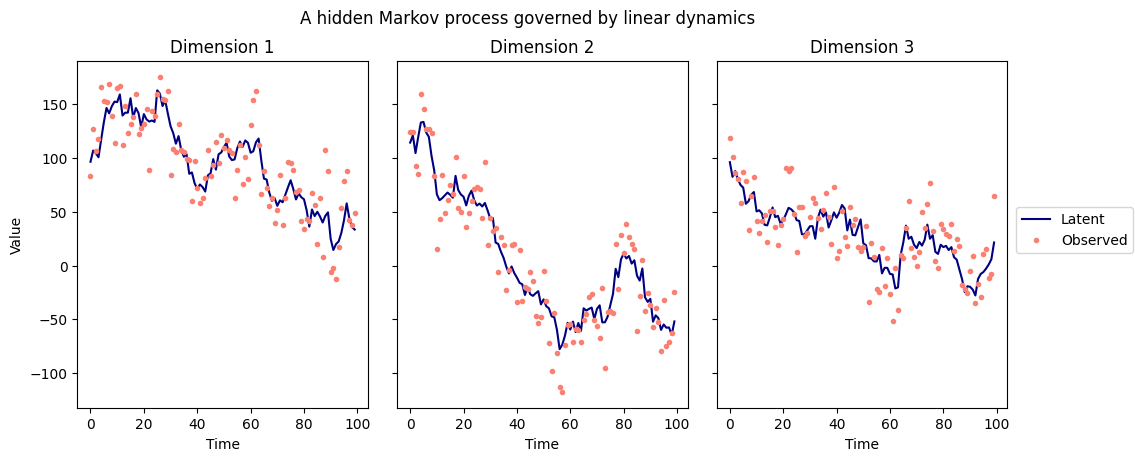

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

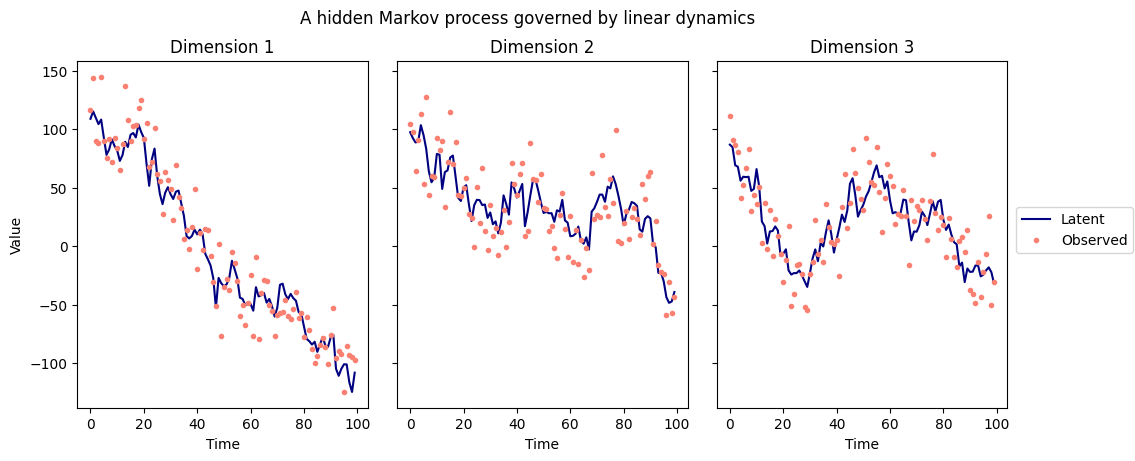

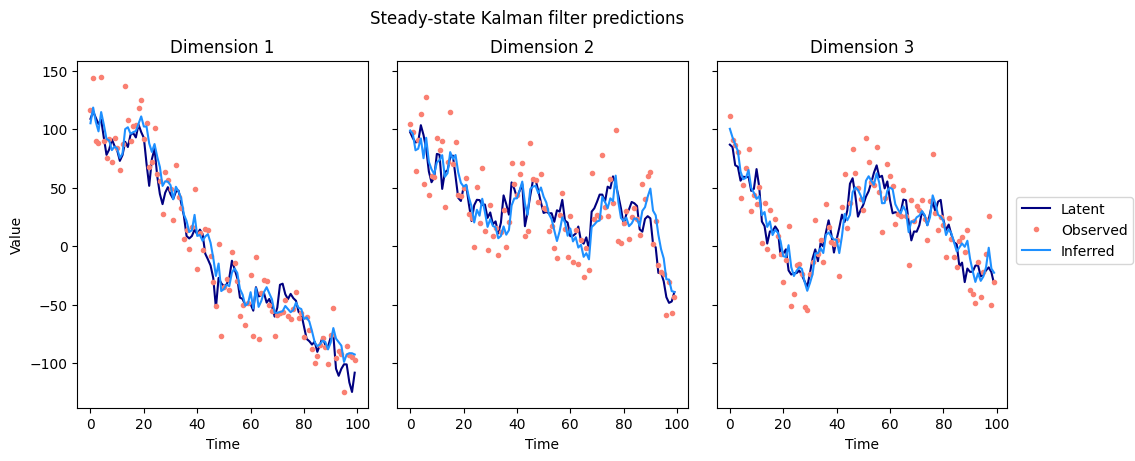

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

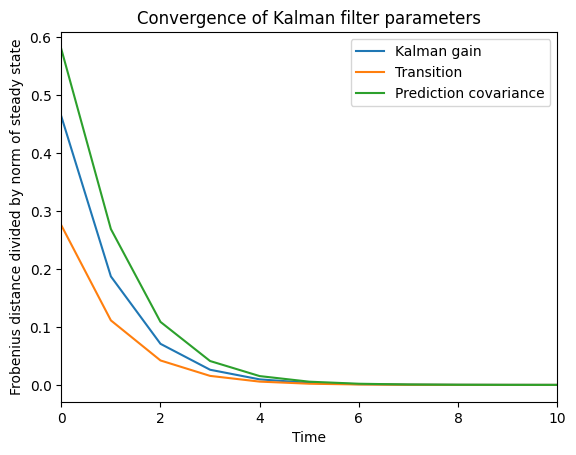

In [5]:
# Let's check how well the Kalman filter converges to the steady-state Kalman filter.
Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
plt.plot(np.arange(proc.num_steps), K_infty_dist/np.linalg.norm(kf.K_infty, ord='fro'), label='Kalman gain')
plt.plot(np.arange(proc.num_steps), M_infty_dist/np.linalg.norm(kf.M_infty, ord='fro'), label='Transition')
plt.plot(np.arange(proc.num_steps), Sigma_infty_dist/np.linalg.norm(kf.Sigma_infty, ord='fro'), label='Prediction covariance')
plt.title('Convergence of Kalman filter parameters')
plt.xlabel('Time')
plt.ylabel('Frobenius distance divided by norm of steady state')
plt.xlim(0,10)
plt.legend()
plt.show()


In [6]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng, np.array([0.98, 0.96, 0.94]))
proc = create_process_3d(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [7]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(3):
        M = mk_rand_matrix(rng, 3)
        for i in tqdm.tqdm(range(10)):
            c = i/10
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(np.linalg.norm(M2 - kf.M_infty, ord='fro'))
            losses.append(np.mean(Ls))
    return np.array(distances), np.array(losses)

# distances, losses = test_M_landscape()

In [8]:
# Let's try plotting our results
# plt.scatter(distances[:10], losses[:10])
# plt.scatter(distances[10:20], losses[10:20])
# plt.scatter(distances[20:], losses[20:])
# plt.xlabel('Frobenius distance between M and the optimal value')
# plt.ylabel('Average loss (100 simulated trials)')
# plt.title('Loss vs distance from Kalman filter theory')
# plt.show()

In [9]:
# What happens when we train the neural net on this task?
def compare_nn_kalman(rng, proc, epsilons, batch_size=40, mask=None, train_vars=None, nonlin=Nonlinearity.ID):
    if mask is None:
        mask = np.full((proc.n, proc.n), 1)
    
    ts, xs, ys = proc.simulate()
    print('A =', proc.A)
    print('Eigenvalues = ', np.linalg.eig(proc.A).eigenvalues)
    
    nn = NeuralNet(0.1*mk_rand_matrix(rng, proc.n),
                   0.1*mk_rand_matrix(rng, proc.n),
                   np.eye(proc.n),
                   proc.x0,
                   mask=mask,
                   train_vars=train_vars,
                   nonlin=nonlin)
    
    _, _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    print('W =', nn.W)
    
    losses, _, _, _ = nn.train(epsilons, batch_size, proc)
    plt.plot(np.log10(losses))
    plt.title('Log loss over time')
    plt.xlabel('Batch')
    plt.ylabel('Log mean loss')
    plt.show()
    
    _, _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    print('W =', nn.W)
    
    # How does it compare to a Kalman filter?
    kf = SteadyStateKalmanFilter(proc)
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)
    print('W =', np.eye(proc.n))

    kf_nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(proc.n), proc.x0)
    losses = kf_nn.batch_test(batch_size, proc)
    print('Mean loss', np.mean(losses))

# compare_nn_kalman(rng, proc, np.concatenate((np.full(10, 1e-6), np.full(30, 2e-7), np.full(50, 1e-7), np.full(50, 5e-8), np.full(30, 1e-8))))

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity. Can we plot a loss landscape for the task?

In [10]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
a_vals = np.array([-0.95, -0.8, 0, 0.8, 0.95])
num_a_ticks = a_vals.shape[0]
mk_range = 0.99
num_trials_per = 40
W = np.array([[1]])

In [11]:
def find_nn_values_A_M_K_1d(num_nns=2):
    mks = [] # mks[i][j] contains the values of M and K for the jth trial with the ith value of A

    for i, a_ in enumerate(a_vals):
        A = np.array([[a_]])
        mks_i = []
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, 1), 0.1*mk_rand_matrix(rng, 1), np.eye(1), proc.x0,
                           train_vars={Param.M, Param.K})
            _, Ms, Ks, _ = nn.train(np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
                                    num_trials_per, proc, print_loss=False, progress_bar=False)
            mks_i.append((Ms.flatten(), Ks.flatten()))
        mks.append(mks_i)

    return mks

# mks = find_nn_values_A_M_K_1d()

In [12]:
def test_A_M_K_loss_landscape_1d():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    W = np.array([[1]])
    
    for i1, a_ in tqdm.tqdm(enumerate(a_vals), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

# losses = test_A_M_K_loss_landscape_1d()

In [13]:
# norm = matplotlib.colors.Normalize(3, 4.8)
# for i1, a_ in enumerate(a_vals):

#    # Loss landscape
#    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#    plt.xlabel('M')
#    plt.ylabel('K')

#    # Where does the Kalman filter fall?
#    A = np.array([[a_]])
#    proc = create_1d_process(rng, A)
#    kf = SteadyStateKalmanFilter(proc)
#    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
#    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
#                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

#    # What about the RNNs?
#    colors = ['red', 'tomato']
#    for j in range(2):
#        plt.plot(mks[i1][j][0], mks[i1][j][1], color=colors[j], linestyle='-', marker='o', markersize=3)
   
#    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
#    plt.xlim(-1*mk_range, mk_range)
#    plt.ylim(-1*mk_range, mk_range)
#    plt.colorbar(c)
#    plt.show()

In [14]:
#def test_mk(proc, m_, k_):
#    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
#    nn = NeuralNet(M, K, W, proc.x0)
#    proc = create_1d_process(rng, A)
#    losses = nn.batch_test(100, proc)
#    print(np.mean(losses))

#A = np.array([[a_vals[-1]]])
#proc = create_1d_process(rng, A)
#kf = SteadyStateKalmanFilter(proc)

#m_ = mks[-1][0][0][-1]
#k_ = mks[-1][0][1][-1]
#test_mk(proc, m_, k_)
#test_mk(proc, kf.M_infty, kf.K_infty)

#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.array([[m_]]), np.array([[k_]]), np.eye(1), proc.x0)
#_, _, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

In [15]:
# # What about two dimensions?
# def create_2d_process(rng, A):
#     x0 = np.array([100, 100])
#     sigma_process = 10
#     Sigma_process = (sigma_process**2)*np.eye(2)
#     O = np.eye(2)
#     sigma_obs = 20
#     Sigma_obs = (sigma_obs**2)*np.eye(2)
#     num_steps = 50
#     return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

# batch_size = 5
# num_a_ticks = 5
# num_ticks = 20
# A = mk_rand_matrix_envals(rng, np.array([0.9, 0.97]))
# proc = create_2d_process(rng, A)
# kf = SteadyStateKalmanFilter(proc)
# mk_range = 0.99
# num_trials_per = 40
# W = np.eye(2)

In [16]:
# def test_K_loss_landscape_2d():
#     M = kf.M_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_k1, k_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_k2, k_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             K = mk_rand_matrix_envals(rng, np.array([k_ev1, k_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_k1,i_k2] = np.mean(Ls)
    
#     return losses

# #losses_K = test_K_loss_landscape_2d()

In [17]:
# def test_M_loss_landscape_2d():
#     K = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M = mk_rand_matrix_envals(rng, 2, np.array([m_ev1, m_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M = test_M_loss_landscape_2d()

In [18]:
# def test_M_loss_landscape_2d_diagentry():
#     K = kf.K_infty
#     M = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M[0,0] = m1
#             M[1,1] = m2
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M_diag = test_M_loss_landscape_2d_diagentry()

In [19]:
# Loss landscape
#norm = matplotlib.colors.Normalize(4, 6)
#c = plt.imshow(np.log10(losses_M_diag.T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#plt.xlabel('M diag 1')
#plt.ylabel('M diag 2')

# Where does the Kalman filter fall?
#envals = (kf.M_infty[0,0], kf.M_infty[1,1])
#plt.plot(envals[0], envals[1], color='black', marker='o')
#plt.annotate('Kalman filter', (envals[0], envals[1]),
#             xytext=(envals[0]-0.2, envals[1]+0.05), color='black')

# What about the RNNs?
#plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')

#plt.title(f'M Log-Loss Landscape')
#plt.xlim(-1*mk_range, mk_range)
#plt.ylim(-1*mk_range, mk_range)
#plt.colorbar(c)
#plt.show()

In [20]:
#kf = SteadyStateKalmanFilter(proc)
#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.diag((0,0.5)), kf.K_infty, np.eye(2), proc.x0)
#_, _, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

#print(kf.Sigma_infty)

# Exploration 3
The goal of this exploration is to work out some possible bugs with the implementation of the Kalman filter (why does the covariance matrix not converge properly?) and find an appropriate method to systematically determine values of the buy-in period (at what time step do we start the loss calculation?) and input gain.

First bug solved: the issue was that I was plotting the distance between the posterior estimate covariance and the steady-state estimate covariance when I should have been plotting the distance between the prior estimate covariance and the steady-state estimate covariance instead. Now the graph looks as expected.

Let's experiment next with simulating 1D processes and checking how long the buy-in period is.

In [21]:
def create_process_1d_more_parameters(rng, a, sigma_process, sigma_obs):
    A = np.array([[a]])
    x0 = np.array([100])
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.eye(1)
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps, start_from=0)

def time_of_convergence(proc, eps=0.05, i=0):
    kf = SteadyStateKalmanFilter(proc)
    Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
    for i in range(proc.num_steps-1,-1,-1):
        if Sigma_infty_dist[i] > eps:
            return i+1
        if K_infty_dist[i] > eps:
            return i+1
        if M_infty_dist[i] > eps:
            return i+1
    return 0

def plot_1d_kalman_convergence_dynamics():
    num_points = 100
    a_vals = np.linspace(0.01,0.99,num_points)
    t_vals = np.zeros(num_points)
    for i in range(num_points):
        proc = create_process_1d_more_parameters(rng, a_vals[i], 10, 25)
        t_vals[i] = time_of_convergence(proc)
    plt.plot(a_vals, t_vals, label='Actual trend')
    plt.plot(a_vals, -1/np.log(a_vals), label='Proportional to time constant')
    plt.plot(a_vals, 11*a_vals+2, label='Roughly linear')
    plt.title('Length of buy-in period vs largest eigenvalue (1D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.ylim(0,12)
    plt.legend()
    plt.show()

#plot_1d_kalman_convergence_dynamics()

It looks like the fit is not proportional to the time constant of the process, as I would have expected, but instead is roughly linear! Choosing a buy-in time period of eleven times the value of A plus two should be sufficient for letting the Kalman filter converge. What if we try changing the noise parameters?

In [22]:
def plot_1d_kalman_convergence_noise():
    num_points = 30
    max_proc_noise = 50
    max_obs_noise = 50
    sigma_proc_vals = np.linspace(1,max_proc_noise,num_points)
    sigma_obs_vals = np.linspace(1,max_obs_noise,num_points)
    t_vals = np.zeros((num_points,num_points))
    for i in range(num_points):
        for j in range(num_points):
            proc = create_process_1d_more_parameters(rng, 0.99, sigma_proc_vals[i], sigma_obs_vals[j])
            t_vals[i,j] = time_of_convergence(proc)
    norm = matplotlib.colors.Normalize(0, 11)
    plt.imshow(t_vals, extent=(1,max_obs_noise,1,max_proc_noise), origin='lower', norm=norm)
    x_vals = np.linspace(1, max_obs_noise, 200)
    plt.plot(x_vals, x_vals/2, color='red')
    plt.title('Length of buy-in period vs noise (1D)')
    plt.xlabel('Observation noise standard deviation')
    plt.ylabel('Process noise standard deviation')
    plt.xlim(1, max_obs_noise)
    plt.ylim(1, max_proc_noise)
    plt.colorbar()
    plt.show()

#plot_1d_kalman_convergence_noise()

Process and observation noise seem to make the convergence take much longer when the observation noise is high and the process noise is very low. A=0.99 originally took 11 steps, and most of this graph is in the non-yellow region where the number of steps needed is below 11 steps, as long as the observation noise is less than twice the process noise (which is the red line).

Now, let's try it with multi-dimensional processes.

In [23]:
def create_process_3d_based_on_envals(rng, enval1, enval2, enval3):
    A = mk_rand_matrix_envals(rng, np.array([enval1, enval2, enval3]))
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def plot_3d_kalman_convergence_dynamics():
    max_envals = []
    t_vals = []
    num_points = 10
    enval_space = np.linspace(0.01,0.99,num_points)
    for enval1 in enval_space:
        for enval2 in enval_space:
            for enval3 in enval_space:
                try:
                    proc = create_process_3d_based_on_envals(rng, enval1, enval2, enval3)
                    t_vals.append(time_of_convergence(proc))
                    max_envals.append(max(enval1, enval2, enval3))
                except sklearn.exceptions.ConvergenceWarning:
                    pass
    
    plt.scatter(max_envals, t_vals)
    plt.title('Length of buy-in period vs largest eigenvalue (3D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.show()

#plot_3d_kalman_convergence_dynamics()

The graph has roughly the same shape as in the 1D case, which is reassuring, although there are some matrices which are outliers. Let's check one of them by hand. All in all, I conclude that if the process noise is more than half the observation noise, then a buy-in period of a little bit more than 10 times the largest eigenvalue of the dynamics matrix should suffice.

Next, how do we deal with the input gain?

In [24]:
def find_appropriate_gain(proc, M):
    # return best K?
    pass

def plot_gain_function():
    norm = matplotlib.colors.Normalize(3, 4.8)
    for i1, a_ in enumerate(a_vals):
    
        # Loss landscape
        c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
        plt.xlabel('M')
        plt.ylabel('K')
    
        # Best values for K, given M?
        ms = np.linspace(-1*mk_range, mk_range, 100)
        ks = []
        proc = create_1d_process(rng, np.array([[a_]]))
        for m_ in ms:
            K = find_appropriate_gain(proc, np.array([[m_]]))
            ks.append(K[0,0])
        ks = np.array(ks)
        plt.plot(ms, ks, color='red')
        
        plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
        plt.xlim(-1*mk_range, mk_range)
        plt.ylim(-1*mk_range, mk_range)
        plt.colorbar(c)
        plt.show()

#plot_gain_function()

# Exploration 4
Now, what if we add some structure onto our connectivity matrix?

In [25]:
# Let's see if the loss is impacted by a mask

def mk_nd_proc(rng, n, envals=None, A=None):
    if A is None:
        if envals is None:
            envals = np.linspace(0.8, 0.95, n)
        A = mk_rand_matrix_envals(rng, envals)
    x0 = np.full(n, 100)
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(n)
    O = np.eye(n)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(n)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def test_masks(rng, n, masks, etas, envals=None, A=None, nonlin=Nonlinearity.ID):
    num_processes = 1
    num_nns = 3
    batch_size = 40
    processes = []
    data = [] # loss indexed by process number, then number of connections, then pattern
    for process_num in range(num_processes):
        data_this_rep = dict()
        proc = mk_nd_proc(rng, n, envals=envals, A=A)
    
        print('Process dynamics:', proc.A)
        print('Eigenvalues:', np.linalg.eig(proc.A).eigenvalues)
        kf = SteadyStateKalmanFilter(proc)
        print('Kalman filter M:', kf.M_infty)
        print('Kalman filter K:', kf.K_infty)
        nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(n), proc.x0)
        Ls = nn.batch_test(batch_size, proc)
        print('Kalman filter loss:', np.mean(Ls))

        max_val_A = np.max(np.abs(proc.A))

        for name, mask in tqdm.tqdm(masks.items()):
            num_connections = np.count_nonzero(mask)
            losses = []
            trial_num = 1
            while True:
                if trial_num > 100:
                    raise FloatingPointError(f'Gradient descent of {num_nns} networks unsuccessful after 100 attempts')
                try:
                    print(f'Testing {name}, Trial {trial_num}')
                    nn = NeuralNet(0.1*max_val_A*mk_rand_matrix(rng, n), 0.1*max_val_A*mk_rand_matrix(rng, n),
                                   np.eye(n), proc.x0, mask=mask, nonlin=nonlin)
                    Ls, _, _, _ = nn.train(etas, batch_size, proc,
                                           print_loss=False, progress_bar=False)
                    loss = Ls[-1]
                    losses.append(loss)
                    print('NN M:', nn.M)
                    print('NN K:', nn.K)
                    print('NN W:', nn.W)
                    print('Loss:', loss)
                    if len(losses) >= num_nns:
                        break
                    trial_num += 1
                except FloatingPointError:
                    trial_num += 1
            min_loss = np.min(losses)
            if num_connections in data_this_rep:
                data_this_rep[num_connections][name] = min_loss
            else:
                data_this_rep[num_connections] = {name: min_loss}
        processes.append(proc)
        data.append(data_this_rep)
        
        N = len(data_this_rep)
        fig, axs = plt.subplots(1, N, sharey=True, squeeze=False)
        axs = np.reshape(axs, (N,))
        fig.set_size_inches(12, 4.5)
        for i, (num_connections, d) in enumerate(data_this_rep.items()):
            xticks = np.arange(len(d))
            axs[i].bar(xticks, d.values())
            axs[i].set_xticks(xticks, d.keys(), rotation=90)
            axs[i].set_title(f'Process {process_num},\n{num_connections} connections')
        axs[0].set_ylabel('Loss')
        plt.show()

    return data

In [26]:
masks_one_neuron = {
    'Empty': np.array([[0]]),
    'One loop': np.array([[1]])
}

masks_two_neurons = {
    'Empty': np.array([
        [0, 0],
        [0, 0]
    ]),
    'One loop': np.array([
        [1, 0],
        [0, 0]
    ]),
    'Unidirectional': np.array([
        [0, 1],
        [0, 0]
    ]),
    'Two loops': np.array([
        [1, 0],
        [0, 1]
    ]),
    'Loop pointing outward': np.array([
        [1, 0],
        [1, 0]
    ]),
    'Loop pointing inward': np.array([
        [0, 0],
        [1, 1]
    ]),
    'Bidirectional': np.array([
        [0, 1],
        [1, 0]
    ]),
    'Loop pointing to loop': np.array([
        [1, 0],
        [1, 1]
    ]),
    'Loop with bidirectional': np.array([
        [1, 1],
        [1, 0]
    ]),
    'Full': np.array([
        [1, 1],
        [1, 1]
    ])
}
two_neuron_configs_all_loops = ['Empty', 'Unidirectional', 'Bidirectional']

masks_three_neurons_all_loops = {
    'Empty': np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]),
    'Unidirectional': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Source': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Linear': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 1]
    ]),
    'Bidirectional out': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Transitive triangle': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Bidirectional in': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Cycle': np.array([
        [1, 0, 1],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Bidirectional source': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Two bidirectionals': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional loop': np.array([
        [1, 1, 0],
        [1, 1, 1],
        [1, 0, 1]
    ]),
    'Bidirectional sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [1, 1, 1]
    ]),
    'Full minus one': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Full': np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ])
}
three_neuron_configs_all_loops = list(masks_three_neurons_all_loops)

## One neuron

In [48]:
# proc = mk_nd_proc(rng, 1,
#                   A=np.array([[0.95]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(10, 1e-5), np.full(10, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))))

Process dynamics: [[0.95]]
Eigenvalues: [0.95]
Kalman filter M: [[0.60049406]]
Kalman filter K: [[0.36790099]]
Kalman filter loss: 2863.8734163242457


  0%|                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.]]
NN K: [[0.97517847]]
NN W: [[0.87029541]]
Loss: 6024.859562663873
Testing Empty, Trial 2
NN M: [[0.]]
NN K: [[0.86864306]]
NN W: [[0.98016738]]
Loss: 6114.8380239513845
Testing Empty, Trial 3


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 1/2 [02:17<02:17, 137.52s/it]

NN M: [[0.]]
NN K: [[0.84752589]]
NN W: [[1.01181494]]
Loss: 6141.47739665569
Testing One loop, Trial 1
NN M: [[0.47750779]]
NN K: [[0.39181734]]
NN W: [[1.22824444]]
Loss: 3028.029746256412
Testing One loop, Trial 2
NN M: [[0.49650416]]
NN K: [[0.40336163]]
NN W: [[1.15822787]]
Loss: 2907.613381767997
Testing One loop, Trial 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:40<00:00, 110.32s/it]

NN M: [[0.49510272]]
NN K: [[0.38187669]]
NN W: [[1.2151017]]
Loss: 2817.624758609206


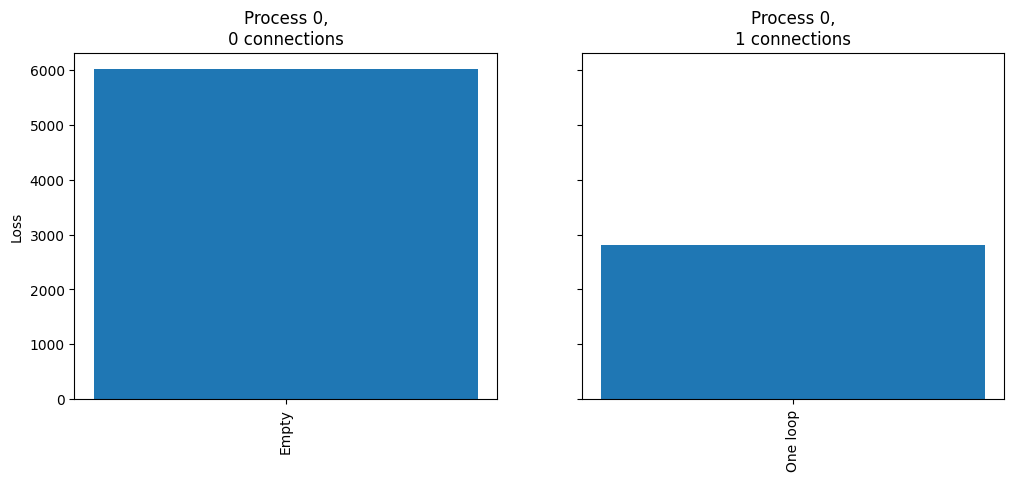

[{0: {'Empty': 6024.859562663873}, 1: {'One loop': 2817.624758609206}}]

In [49]:
test_masks(rng, 1, masks_one_neuron, np.concatenate((np.full(10, 1e-5), np.full(10, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))),
           A=np.array([[0.95]]))

## Two neurons

### Near-diagonal

In [50]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0.8, 0.03], [-0.03, 0.95]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 0.8   0.03]
 [-0.03  0.95]]
Eigenvalues: [0.80626136 0.94373864]
Kalman filter M: [[ 0.55231287  0.01881604]
 [-0.02055463  0.60034482]]
Kalman filter K: [[0.30968365 0.00199311]
 [0.00199311 0.36799514]]
Kalman filter loss: 4858.552240707745


  0%|                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.22905302 1.16860742]
 [0.18873692 0.85907818]]
NN W: [[ 0.43379647 -0.51545542]
 [-0.10711859  1.02163348]]
Loss: 8261.597659544563
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.2080367  1.14399288]
 [0.23541718 0.87392117]]
NN W: [[ 0.46223197 -0.52619966]
 [-0.1485717   1.04890228]]
Loss: 8315.554954256037
Testing Empty, Trial 3


 10%|███████████████                                                                                                                                        | 1/10 [01:44<15:42, 104.72s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.23902409 1.14800239]
 [0.19185983 0.81160888]]
NN W: [[ 0.42577065 -0.51393722]
 [-0.10979215  1.09390811]]
Loss: 8220.495242768426
Testing One loop, Trial 1
NN M: [[0.50227735 0.        ]
 [0.         0.        ]]
NN K: [[0.58255337 0.18941318]
 [0.21295376 0.92926267]]
NN W: [[ 0.65046645 -0.19701279]
 [-0.04156452  0.8432557 ]]
Loss: 8032.781035752824
Testing One loop, Trial 2
NN M: [[0.4937581 0.       ]
 [0.        0.       ]]
NN K: [[0.52735233 0.15431114]
 [0.17712123 0.8743562 ]]
NN W: [[ 0.7148354  -0.17301153]
 [-0.02547783  0.90037053]]
Loss: 8321.084364377635
Testing One loop, Trial 3


 20%|██████████████████████████████▍                                                                                                                         | 2/10 [03:20<13:13, 99.25s/it]

NN M: [[0.49048933 0.        ]
 [0.         0.        ]]
NN K: [[0.62486592 0.2221218 ]
 [0.23115015 0.94942771]]
NN W: [[ 0.62472006 -0.21462681]
 [-0.04764451  0.83035008]]
Loss: 8077.417887362698
Testing Unidirectional, Trial 1
NN M: [[0.        0.8284938]
 [0.        0.       ]]
NN K: [[1.07174165 0.80293024]
 [0.0066102  0.61630573]]
NN W: [[ 0.34773084 -0.53783763]
 [ 0.12820824  0.99796003]]
Loss: 8921.274850987256
Testing Unidirectional, Trial 2
NN M: [[0.         0.61253693]
 [0.         0.        ]]
NN K: [[1.07306742 0.70865994]
 [0.15849962 0.74773112]]
NN W: [[ 0.41798696 -0.4880476 ]
 [ 0.00702902  0.99526118]]
Loss: 8709.501861201756
Testing Unidirectional, Trial 3


 30%|█████████████████████████████████████████████▌                                                                                                          | 3/10 [04:44<10:47, 92.47s/it]

NN M: [[0.         0.85347332]
 [0.         0.        ]]
NN K: [[ 0.99963214  0.71147058]
 [-0.05684747  0.56047241]]
NN W: [[ 0.33593839 -0.49459919]
 [ 0.19472081  1.0022228 ]]
Loss: 8354.301347284612
Testing Two loops, Trial 1
NN M: [[0.52392868 0.        ]
 [0.         0.44221581]]
NN K: [[ 0.67026825  0.25489502]
 [-0.03333825  0.39129092]]
NN W: [[ 0.5232235  -0.30506953]
 [ 0.06116128  1.22502369]]
Loss: 5272.159387787988
Testing Two loops, Trial 2
NN M: [[0.50229329 0.        ]
 [0.         0.51555087]]
NN K: [[0.59444742 0.08965446]
 [0.08882    0.42049487]]
NN W: [[ 0.63549934 -0.06413117]
 [-0.13388367  1.06302308]]
Loss: 5333.839815380748
Testing Two loops, Trial 3


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 4/10 [06:12<09:03, 90.61s/it]

NN M: [[0.51869538 0.        ]
 [0.         0.4868453 ]]
NN K: [[ 0.49036722  0.14341044]
 [-0.00746017  0.40258071]]
NN W: [[ 0.72845201 -0.19533817]
 [ 0.03442495  1.12719549]]
Loss: 5595.952025307945
Testing Loop pointing outward, Trial 1
NN M: [[0.55071754 0.        ]
 [0.25679406 0.        ]]
NN K: [[ 0.48642854  0.40254078]
 [-0.07110181  0.44253987]]
NN W: [[ 0.61672242 -0.58053291]
 [-0.00927747  1.22203988]]
Loss: 6643.88596979077
Testing Loop pointing outward, Trial 2
NN M: [[0.43305521 0.        ]
 [0.16441235 0.        ]]
NN K: [[ 0.49802482  0.4708437 ]
 [-0.37942809  0.26336137]]
NN W: [[ 0.4239016  -0.42634483]
 [ 0.52095581  0.98584407]]
Loss: 7196.808074579594
Testing Loop pointing outward, Trial 3


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [07:33<07:15, 87.14s/it]

NN M: [[0.54645718 0.        ]
 [0.27251223 0.        ]]
NN K: [[ 0.46748729  0.23481006]
 [-0.02074621  0.56627075]]
NN W: [[ 0.68852773 -0.30807367]
 [-0.03907919  1.12882415]]
Loss: 7363.764490332719
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.02765917 0.30405786]]
NN K: [[0.99296612 0.57923958]
 [0.09375874 0.46156824]]
NN W: [[ 0.47858583 -0.26653721]
 [-0.18661998  1.39246386]]
Loss: 6589.44272140334
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.10421113 0.29106572]]
NN K: [[ 0.89418995  0.77367848]
 [-0.12994928  0.38509726]]
NN W: [[ 0.41748267 -0.34240236]
 [ 0.098199    1.18177218]]
Loss: 6936.004091767434
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6/10 [08:50<05:34, 83.61s/it]

NN M: [[0.         0.        ]
 [0.11051724 0.40986788]]
NN K: [[ 0.75322011  0.62345458]
 [-0.18046816  0.29797363]]
NN W: [[ 0.50876577 -0.32537676]
 [ 0.21892025  1.20070843]]
Loss: 6732.511582661509
Testing Bidirectional, Trial 1
NN M: [[0.         0.67855404]
 [0.22103032 0.        ]]
NN K: [[ 0.65173483  0.64903336]
 [-0.06191762  0.42580696]]
NN W: [[ 0.47494099 -0.5352681 ]
 [ 0.04196845  1.18159125]]
Loss: 7601.661761693179
Testing Bidirectional, Trial 2
NN M: [[0.         0.50096866]
 [0.2974689  0.        ]]
NN K: [[ 0.54082896  0.5140615 ]
 [-0.24399542  0.25037518]]
NN W: [[ 0.49335793 -0.41505745]
 [ 0.41411729  1.13376406]]
Loss: 7375.453815763913
Testing Bidirectional, Trial 3


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7/10 [10:05<04:03, 81.04s/it]

NN M: [[0.         0.6320218 ]
 [0.27448284 0.        ]]
NN K: [[ 0.60368718  0.59544314]
 [-0.20176806  0.360615  ]]
NN W: [[ 0.44504145 -0.44515157]
 [ 0.25583479  0.94369782]]
Loss: 7365.467633025311
Testing Loop pointing to loop, Trial 1
NN M: [[0.50986289 0.        ]
 [0.10158379 0.38558114]]
NN K: [[ 0.45612614  0.23327941]
 [-0.05302643  0.40189479]]
NN W: [[ 0.80159042 -0.40048837]
 [-0.01507771  1.18557624]]
Loss: 5367.122160595106
Testing Loop pointing to loop, Trial 2
NN M: [[0.55404507 0.        ]
 [0.11558143 0.40671616]]
NN K: [[ 0.40579231  0.16061085]
 [-0.00805995  0.38220371]]
NN W: [[ 0.85015102 -0.32898266]
 [-0.1625476   1.30094356]]
Loss: 5410.391565919031
Testing Loop pointing to loop, Trial 3


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8/10 [11:33<02:46, 83.26s/it]

NN M: [[0.49832007 0.        ]
 [0.17805626 0.16213512]]
NN K: [[ 0.46099721  0.33924899]
 [-0.1667402   0.36650147]]
NN W: [[ 0.65734475 -0.52343949]
 [ 0.18520541  1.23052919]]
Loss: 6628.5641379460485
Testing Loop with bidirectional, Trial 1
NN M: [[0.42698976 0.27066743]
 [0.14425203 0.        ]]
NN K: [[ 0.55305385  0.30970824]
 [-0.19380489  0.38531512]]
NN W: [[ 0.52344519 -0.47008945]
 [ 0.29868406  1.1735869 ]]
Loss: 6217.370444464218
Testing Loop with bidirectional, Trial 2
NN M: [[0.39336473 0.32278294]
 [0.2209412  0.        ]]
NN K: [[ 0.54537536  0.28773609]
 [-0.08439268  0.42784468]]
NN W: [[ 0.58441865 -0.4810101 ]
 [ 0.073462    1.23421985]]
Loss: 7072.0158553902265
Testing Loop with bidirectional, Trial 3


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9/10 [13:09<01:27, 87.11s/it]

NN M: [[0.4371472  0.20953636]
 [0.24283308 0.        ]]
NN K: [[0.61163295 0.23590773]
 [0.04799708 0.50901176]]
NN W: [[ 0.57299975 -0.34656685]
 [-0.12689321  1.28052725]]
Loss: 7232.798725354412
Testing Full, Trial 1
NN M: [[0.35898088 0.27166551]
 [0.06533746 0.47986326]]
NN K: [[0.51891147 0.05390756]
 [0.05878611 0.39003072]]
NN W: [[ 0.77402658 -0.27538015]
 [-0.2101406   1.18581218]]
Loss: 5685.270123864819
Testing Full, Trial 2
NN M: [[0.41985983 0.19171233]
 [0.13858516 0.21971394]]
NN K: [[ 0.53725617  0.31013255]
 [-0.0689027   0.36645269]]
NN W: [[ 0.65277875 -0.54616582]
 [ 0.02587279  1.3809673 ]]
Loss: 6010.955812723439
Testing Full, Trial 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:44<00:00, 88.42s/it]

NN M: [[0.44660711 0.20791816]
 [0.08023025 0.44083804]]
NN K: [[ 0.53108821  0.15776098]
 [-0.01530211  0.39626683]]
NN W: [[ 0.70246741 -0.38448931]
 [-0.07776537  1.16659738]]
Loss: 5378.316263258153


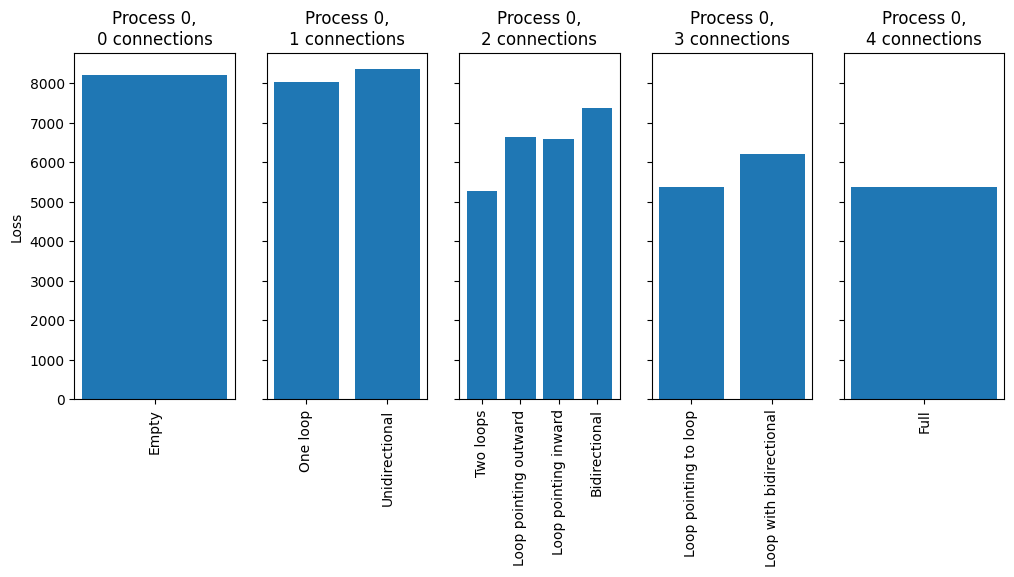

[{0: {'Empty': 8220.495242768426},
  1: {'One loop': 8032.781035752824, 'Unidirectional': 8354.301347284612},
  2: {'Two loops': 5272.159387787988,
   'Loop pointing outward': 6643.88596979077,
   'Loop pointing inward': 6589.44272140334,
   'Bidirectional': 7365.467633025311},
  3: {'Loop pointing to loop': 5367.122160595106,
   'Loop with bidirectional': 6217.370444464218},
  4: {'Full': 5378.316263258153}}]

In [51]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0.8, 0.03], [-0.03, 0.95]]))

### Eigenvalues far apart

In [52]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[1, -0.1], [1.4, -0.3]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 1.  -0.1]
 [ 1.4 -0.3]]
Eigenvalues: [ 0.88150729 -0.18150729]
Kalman filter M: [[ 0.47978222 -0.02417192]
 [ 0.68600942 -0.16400652]]
Kalman filter K: [[0.31191267 0.14878936]
 [0.14878936 0.40371516]]
Kalman filter loss: 5467.656432394075


  0%|                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.9366549  0.82277762]
 [0.95986125 1.2838562 ]]
NN W: [[ 0.71463214 -0.24656918]
 [-0.37518581  0.66217188]]
Loss: 7342.5702777336965
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.95687608 0.88135885]
 [0.76661853 1.11147972]]
NN W: [[ 0.6881087  -0.29743493]
 [-0.26960415  0.70415464]]
Loss: 7108.538540027017
Testing Empty, Trial 3


 10%|███████████████▏                                                                                                                                        | 1/10 [01:36<14:29, 96.64s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.83122514 0.66108827]
 [0.97573853 1.28988835]]
NN W: [[ 0.68567536 -0.13740862]
 [-0.40073893  0.63339123]]
Loss: 7722.86334018198
Testing One loop, Trial 1
NN M: [[0.38213659 0.        ]
 [0.         0.        ]]
NN K: [[0.53018194 0.46738098]
 [0.41766641 0.83837104]]
NN W: [[ 0.71400752 -0.22363102]
 [ 0.11054188  0.57309379]]
Loss: 6586.669070904047
Testing One loop, Trial 2
NN M: [[0.41526513 0.        ]
 [0.         0.        ]]
NN K: [[0.44843652 0.33831025]
 [0.46389855 0.84764684]]
NN W: [[ 0.75339179 -0.11416738]
 [ 0.11942448  0.56778824]]
Loss: 5807.1004427284715
Testing One loop, Trial 3


 20%|██████████████████████████████▍                                                                                                                         | 2/10 [03:13<12:51, 96.48s/it]

NN M: [[0.37079378 0.        ]
 [0.         0.        ]]
NN K: [[0.39637336 0.30541867]
 [0.51752438 0.90163653]]
NN W: [[ 0.8832599  -0.09600439]
 [ 0.03282143  0.59540359]]
Loss: 6509.55674429703
Testing Unidirectional, Trial 1
NN M: [[0.         0.42334814]
 [0.         0.        ]]
NN K: [[0.57045625 0.42594172]
 [0.51886695 0.81078415]]
NN W: [[ 0.67461198 -0.1649085 ]
 [ 0.04346598  0.6194374 ]]
Loss: 6554.716665453542
Testing Unidirectional, Trial 2
NN M: [[0.         0.23520915]
 [0.         0.        ]]
NN K: [[0.49446773 0.27751116]
 [0.76641546 1.10472919]]
NN W: [[ 0.68333847 -0.00451529]
 [-0.0869936   0.51322617]]
Loss: 7310.163249071292
Testing Unidirectional, Trial 3


 30%|█████████████████████████████████████████████▌                                                                                                          | 3/10 [04:50<11:17, 96.76s/it]

NN M: [[0.         0.30535056]
 [0.         0.        ]]
NN K: [[0.45758601 0.21657386]
 [0.66679484 0.97201473]]
NN W: [[ 0.65974692  0.03441114]
 [-0.02278288  0.55140422]]
Loss: 6908.008105639415
Testing Two loops, Trial 1
NN M: [[0.35306098 0.        ]
 [0.         0.37733483]]
NN K: [[0.35497296 0.17877549]
 [0.25553091 0.36368448]]
NN W: [[ 0.89045408  0.10330683]
 [-0.09998457  1.07014004]]
Loss: 5534.58619205835
Testing Two loops, Trial 2
NN M: [[0.40034483 0.        ]
 [0.         0.36651122]]
NN K: [[0.50448453 0.36678711]
 [0.21727972 0.43132006]]
NN W: [[ 0.69765898 -0.14766607]
 [ 0.19293416  0.68879632]]
Loss: 5833.218980410775
Testing Two loops, Trial 3


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 4/10 [06:27<09:41, 96.92s/it]

NN M: [[0.37389741 0.        ]
 [0.         0.35370955]]
NN K: [[0.44900859 0.27051366]
 [0.21915021 0.41983694]]
NN W: [[ 0.76905934 -0.02940931]
 [ 0.11196371  0.85973512]]
Loss: 5973.572347118327
Testing Loop pointing outward, Trial 1
NN M: [[0.4058453 0.       ]
 [0.4084549 0.       ]]
NN K: [[0.34579271 0.31259246]
 [0.23334204 0.51211287]]
NN W: [[ 0.82395473 -0.06387793]
 [-0.06231162  0.87678795]]
Loss: 5902.176059231239
Testing Loop pointing outward, Trial 2
NN M: [[0.42069766 0.        ]
 [0.54216572 0.        ]]
NN K: [[0.51823708 0.27104476]
 [0.39146807 0.61380208]]
NN W: [[ 0.64897418 -0.017728  ]
 [-0.32648704  0.82421303]]
Loss: 5758.426893106339
Testing Loop pointing outward, Trial 3


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [08:05<08:07, 97.43s/it]

NN M: [[0.38040635 0.        ]
 [0.4035647  0.        ]]
NN K: [[0.53891251 0.29376826]
 [0.29261299 0.50751671]]
NN W: [[ 0.73085164 -0.09626429]
 [-0.18728062  0.92762821]]
Loss: 5299.770111655372
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.34504461 0.16867394]]
NN K: [[0.61817531 0.3800876 ]
 [0.08639207 0.45144051]]
NN W: [[0.72108441 0.0587829 ]
 [0.16507234 0.77464737]]
Loss: 6536.884129332567
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.33252879 0.32683142]]
NN K: [[0.58335119 0.27244988]
 [0.23515694 0.3129418 ]]
NN W: [[0.65436775 0.20085813]
 [0.00615113 0.81204782]]
Loss: 6255.186139478996
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6/10 [09:43<06:29, 97.50s/it]

NN M: [[0.         0.        ]
 [0.43724552 0.16510273]]
NN K: [[0.65347005 0.33632209]
 [0.48605146 0.63066867]]
NN W: [[ 0.60555629  0.10079299]
 [-0.29521604  0.69378446]]
Loss: 6517.634682613673
Testing Bidirectional, Trial 1
NN M: [[0.         0.37093521]
 [0.44000908 0.        ]]
NN K: [[0.43027884 0.18948328]
 [0.35183422 0.5314323 ]]
NN W: [[ 0.69816442  0.04606856]
 [-0.11065219  0.80171204]]
Loss: 5844.347627378728
Testing Bidirectional, Trial 2
NN M: [[0.         0.34488368]
 [0.39165698 0.        ]]
NN K: [[0.34704237 0.23690951]
 [0.30184822 0.40837879]]
NN W: [[ 0.91550039 -0.03124955]
 [ 0.07725907  0.84524954]]
Loss: 5699.575638737499
Testing Bidirectional, Trial 3


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7/10 [11:21<04:52, 97.65s/it]

NN M: [[0.         0.38172864]
 [0.40815658 0.        ]]
NN K: [[0.49549647 0.37673128]
 [0.25358676 0.53015115]]
NN W: [[ 0.83350219 -0.23274002]
 [ 0.03686567  0.69673577]]
Loss: 5800.716556139401
Testing Loop pointing to loop, Trial 1
NN M: [[0.36572874 0.        ]
 [0.17335395 0.19976137]]
NN K: [[0.37276496 0.50762803]
 [0.32225869 0.34492137]]
NN W: [[0.52937148 0.07381656]
 [0.15452492 0.69605977]]
Loss: 5862.042268870628
Testing Loop pointing to loop, Trial 2
NN M: [[0.38422783 0.        ]
 [0.29958674 0.20737054]]
NN K: [[0.28185203 0.30981243]
 [0.2353713  0.35561464]]
NN W: [[ 0.90471929 -0.04472696]
 [ 0.113595    0.78822175]]
Loss: 6112.196344077085
Testing Loop pointing to loop, Trial 3


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8/10 [12:59<03:15, 97.80s/it]

NN M: [[0.34235472 0.        ]
 [0.31190166 0.06213268]]
NN K: [[0.41492523 0.2761191 ]
 [0.21032378 0.47940949]]
NN W: [[ 0.9389071 -0.1273812]
 [ 0.0403295  0.8640429]]
Loss: 5513.017202973468
Testing Loop with bidirectional, Trial 1
NN M: [[0.12800865 0.26588867]
 [0.40165293 0.        ]]
NN K: [[0.48332969 0.31729346]
 [0.34159174 0.56220722]]
NN W: [[ 0.74856043 -0.11428598]
 [-0.25345078  0.91885724]]
Loss: 5794.34318157342
Testing Loop with bidirectional, Trial 2
NN M: [[0.10326402 0.30571684]
 [0.40931493 0.        ]]
NN K: [[0.3884775  0.23835283]
 [0.3360307  0.47311617]]
NN W: [[ 0.71660372  0.0308859 ]
 [-0.13317012  0.89971725]]
Loss: 5812.651783746269
Testing Loop with bidirectional, Trial 3


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9/10 [14:38<01:38, 98.12s/it]

NN M: [[0.41542906 0.12576612]
 [0.25272545 0.        ]]
NN K: [[0.18836583 0.21628392]
 [0.43707279 0.48408923]]
NN W: [[0.67144932 0.17456146]
 [0.09746115 0.7660347 ]]
Loss: 6245.560503188797
Testing Full, Trial 1
NN M: [[0.21810937 0.13012862]
 [0.21964107 0.39908371]]
NN K: [[0.49219661 0.31189096]
 [0.53901476 0.34302139]]
NN W: [[ 0.80564592 -0.11838092]
 [-0.01643261  0.52794737]]
Loss: 6533.565395982789
Testing Full, Trial 2
NN M: [[0.11618522 0.20719682]
 [0.18248915 0.30342802]]
NN K: [[0.44539103 0.20376315]
 [0.28612072 0.33535029]]
NN W: [[ 0.87856317 -0.02496233]
 [-0.15754083  0.99956596]]
Loss: 5745.377868994337
Testing Full, Trial 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:16<00:00, 97.65s/it]

NN M: [[0.14946212 0.12948137]
 [0.16661584 0.44317915]]
NN K: [[0.40071526 0.14894865]
 [0.33141228 0.34083767]]
NN W: [[ 0.81772914  0.09494456]
 [-0.25630105  0.83020515]]
Loss: 6061.497019282162


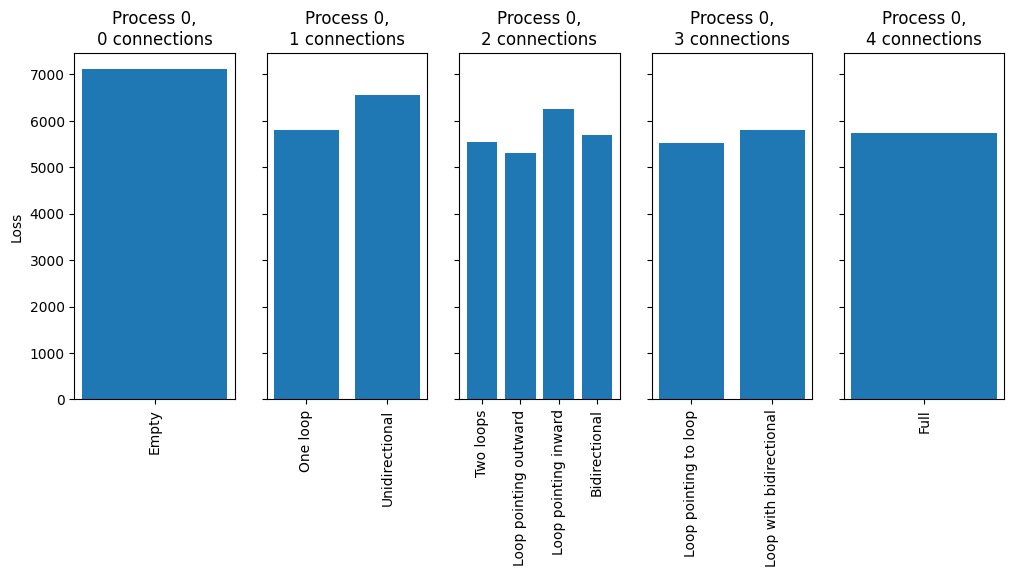

[{0: {'Empty': 7108.538540027017},
  1: {'One loop': 5807.1004427284715, 'Unidirectional': 6554.716665453542},
  2: {'Two loops': 5534.58619205835,
   'Loop pointing outward': 5299.770111655372,
   'Loop pointing inward': 6255.186139478996,
   'Bidirectional': 5699.575638737499},
  3: {'Loop pointing to loop': 5513.017202973468,
   'Loop with bidirectional': 5794.34318157342},
  4: {'Full': 5745.377868994337}}]

In [53]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[1, -0.1], [1.4, -0.3]]))

### Off-diagonal

In [54]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0, 0.95], [0.8, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[0.   0.95]
 [0.8  0.  ]]
Eigenvalues: [ 0.87177979 -0.87177979]
Kalman filter M: [[0.         0.61670586]
 [0.54254392 0.        ]]
Kalman filter K: [[0.35083594 0.        ]
 [0.         0.3218201 ]]
Kalman filter loss: 5035.676825603494


  0%|                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.26367984 0.69499169]
 [0.96883541 1.31851294]]
NN W: [[ 0.71282632 -0.35448198]
 [-0.46029706  0.63078393]]
Loss: 7445.154358948504
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.36477972 0.77432331]
 [0.89367515 1.29522463]]
NN W: [[ 0.62512879 -0.34520953]
 [-0.38107263  0.6183953 ]]
Loss: 7951.024343465018
Testing Empty, Trial 3


 10%|███████████████▏                                                                                                                                        | 1/10 [01:39<14:54, 99.34s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.3245369  0.77710513]
 [0.9428651  1.28684174]]
NN W: [[ 0.69942811 -0.39840066]
 [-0.45602901  0.67238624]]
Loss: 8572.219040905706
Testing One loop, Trial 1
NN M: [[0.37563991 0.        ]
 [0.         0.        ]]
NN K: [[0.58084194 0.31152047]
 [0.40574559 1.16356772]]
NN W: [[ 0.92777153 -0.31149134]
 [-0.11815984  0.48994754]]
Loss: 8578.631493361687
Testing One loop, Trial 2
NN M: [[0.36112179 0.        ]
 [0.         0.        ]]
NN K: [[0.6142697  0.37960463]
 [0.38901723 1.13246758]]
NN W: [[ 0.91010395 -0.37701883]
 [-0.12766447  0.52819714]]
Loss: 7980.513331429484
Testing One loop, Trial 3


 20%|██████████████████████████████▍                                                                                                                         | 2/10 [03:18<13:13, 99.22s/it]

NN M: [[0.26541004 0.        ]
 [0.         0.        ]]
NN K: [[0.76320743 0.38181402]
 [0.73155279 1.37454084]]
NN W: [[ 0.87470195 -0.28500048]
 [-0.27885295  0.46087028]]
Loss: 8745.626195581699
Testing Unidirectional, Trial 1
NN M: [[0.         0.35236019]
 [0.         0.        ]]
NN K: [[0.75867357 0.31548415]
 [0.55046039 1.23914875]]
NN W: [[ 0.69899025 -0.2180465 ]
 [-0.18135977  0.47734613]]
Loss: 7927.2031278338545
Testing Unidirectional, Trial 2
NN M: [[0.         0.28681846]
 [0.         0.        ]]
NN K: [[0.77795276 0.36298238]
 [0.61185404 1.28717303]]
NN W: [[ 0.75468701 -0.25168706]
 [-0.21762254  0.47438955]]
Loss: 7102.718419092943
Testing Unidirectional, Trial 3


 30%|█████████████████████████████████████████████▌                                                                                                          | 3/10 [04:56<11:31, 98.78s/it]

NN M: [[0.         0.29008009]
 [0.         0.        ]]
NN K: [[0.7242848  0.28938268]
 [0.58771082 1.28832005]]
NN W: [[ 0.76558904 -0.21011333]
 [-0.21040798  0.45876421]]
Loss: 7644.471584039304
Testing Two loops, Trial 1
NN M: [[0.38449839 0.        ]
 [0.         0.46831823]]
NN K: [[0.65234229 0.13978026]
 [0.23929692 0.5636801 ]]
NN W: [[ 0.80187432 -0.1218278 ]
 [-0.26080121  0.77734121]]
Loss: 7661.401049577294
Testing Two loops, Trial 2
NN M: [[0.43014733 0.        ]
 [0.         0.45956538]]
NN K: [[0.69464143 0.25490099]
 [0.28734388 0.68461549]]
NN W: [[ 0.7479089  -0.22159259]
 [-0.24969569  0.69519488]]
Loss: 8472.567372758302
Testing Two loops, Trial 3


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 4/10 [06:35<09:52, 98.77s/it]

NN M: [[0.42606599 0.        ]
 [0.         0.47117962]]
NN K: [[0.75651273 0.25786673]
 [0.24417776 0.58792775]]
NN W: [[ 0.68686931 -0.2259837 ]
 [-0.22713213  0.77990921]]
Loss: 9134.56672264134
Testing Loop pointing outward, Trial 1
NN M: [[0.59861156 0.        ]
 [0.4517681  0.        ]]
NN K: [[0.81152533 0.37886447]
 [0.14488829 0.58930912]]
NN W: [[ 0.64550882 -0.50919343]
 [-0.27059542  0.79193576]]
Loss: 6439.683344179839
Testing Loop pointing outward, Trial 2
NN M: [[0.54445764 0.        ]
 [0.52172732 0.        ]]
NN K: [[0.61309525 0.26103485]
 [0.09156387 0.5492326 ]]
NN W: [[ 0.84472922 -0.45972661]
 [-0.24856558  0.80635254]]
Loss: 6398.338351481783
Testing Loop pointing outward, Trial 3


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [08:14<08:14, 98.94s/it]

NN M: [[0.55735666 0.        ]
 [0.44053232 0.        ]]
NN K: [[0.65022672 0.31712181]
 [0.05912675 0.53080136]]
NN W: [[ 0.76596062 -0.51554871]
 [-0.2068939   0.84036534]]
Loss: 6690.21311897847
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.24741869 0.10977913]]
NN K: [[1.26756386 0.4139401 ]
 [0.2655299  0.52521814]]
NN W: [[ 0.47532435 -0.12921662]
 [-0.22503073  0.86178431]]
Loss: 6914.793911133378
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.31699303 0.26217871]]
NN K: [[1.07035205 0.2266364 ]
 [0.20595283 0.47770316]]
NN W: [[ 0.54983892 -0.01032543]
 [-0.23182093  0.75657239]]
Loss: 7249.47903796203
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6/10 [09:53<06:35, 98.94s/it]

NN M: [[0.         0.        ]
 [0.22645042 0.23990591]]
NN K: [[1.19051291 0.29952983]
 [0.34759785 0.52704838]]
NN W: [[ 0.49596652 -0.04314634]
 [-0.31091214  0.80572394]]
Loss: 7488.921673582685
Testing Bidirectional, Trial 1
NN M: [[0.         0.62115886]
 [0.57081    0.        ]]
NN K: [[0.57462037 0.25796018]
 [0.25450088 0.53088236]]
NN W: [[ 0.76870523 -0.35002399]
 [-0.32298215  0.7596397 ]]
Loss: 5237.266380109929
Testing Bidirectional, Trial 2
NN M: [[0.         0.61850375]
 [0.65707305 0.        ]]
NN K: [[0.72459994 0.35210574]
 [0.40610991 0.67164868]]
NN W: [[ 0.64189035 -0.33758444]
 [-0.3393617   0.59621402]]
Loss: 4942.083467762195
Testing Bidirectional, Trial 3


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7/10 [11:33<04:57, 99.25s/it]

NN M: [[0.         0.65019002]
 [0.54414088 0.        ]]
NN K: [[0.5881084  0.20023101]
 [0.20218875 0.5096102 ]]
NN W: [[ 0.68971909 -0.25732815]
 [-0.23128569  0.71926482]]
Loss: 5477.291364818247
Testing Loop pointing to loop, Trial 1
NN M: [[0.53610652 0.        ]
 [0.39216868 0.08639252]]
NN K: [[0.73649536 0.20575646]
 [0.12526822 0.52507639]]
NN W: [[ 0.66144885 -0.30610357]
 [-0.24067103  0.84017231]]
Loss: 7004.80756878457
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.54756793  0.        ]
 [ 0.54238867 -0.07518637]]
NN K: [[0.65825748 0.27912991]
 [0.12769378 0.57969277]]
NN W: [[ 0.78085937 -0.43826219]
 [-0.26033721  0.8059782 ]]
Loss: 6631.103177794837
Testing Loop pointing to loop, Trial 3


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8/10 [13:12<03:18, 99.15s/it]

NN M: [[0.5000329  0.        ]
 [0.42917289 0.12597854]]
NN K: [[0.62816232 0.14450211]
 [0.13122131 0.49433314]]
NN W: [[ 0.79034515 -0.24748967]
 [-0.27502085  0.85714006]]
Loss: 7949.149955949879
Testing Loop with bidirectional, Trial 1
NN M: [[0.29637403 0.33638546]
 [0.52532502 0.        ]]
NN K: [[0.56535931 0.22621346]
 [0.10499566 0.56149912]]
NN W: [[ 0.83048959 -0.42056842]
 [-0.24957562  0.79017738]]
Loss: 5392.019631666273
Testing Loop with bidirectional, Trial 2
NN M: [[0.18887396 0.46684651]
 [0.52308692 0.        ]]
NN K: [[0.58588179 0.15423603]
 [0.11281539 0.51197688]]
NN W: [[ 0.75696349 -0.31490862]
 [-0.20982264  0.77428925]]
Loss: 5221.581229032267
Testing Loop with bidirectional, Trial 3


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9/10 [14:52<01:39, 99.57s/it]

NN M: [[0.15220717 0.45212929]
 [0.55885267 0.        ]]
NN K: [[0.52779707 0.21209974]
 [0.1428143  0.54020941]]
NN W: [[ 0.87257339 -0.38525779]
 [-0.26081196  0.77861621]]
Loss: 5431.641588740041
Testing Full, Trial 1
NN M: [[0.07927645 0.55601126]
 [0.4365544  0.07771888]]
NN K: [[0.58863763 0.20864695]
 [0.19110058 0.50312868]]
NN W: [[ 0.83116844 -0.39084381]
 [-0.33422362  0.90134797]]
Loss: 5339.3625564062695
Testing Full, Trial 2
NN M: [[0.19837496 0.37316592]
 [0.32889955 0.22205093]]
NN K: [[0.58566225 0.08541095]
 [0.1244295  0.49639884]]
NN W: [[ 0.82718242 -0.2502098 ]
 [-0.28209547  0.8843491 ]]
Loss: 6232.861759911486
Testing Full, Trial 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:32<00:00, 99.26s/it]

NN M: [[ 0.20139581  0.42610789]
 [ 0.55846911 -0.07183497]]
NN K: [[0.56992247 0.24596694]
 [0.17106191 0.523378  ]]
NN W: [[ 0.85121983 -0.43996524]
 [-0.28334278  0.84194854]]
Loss: 5145.514620380551


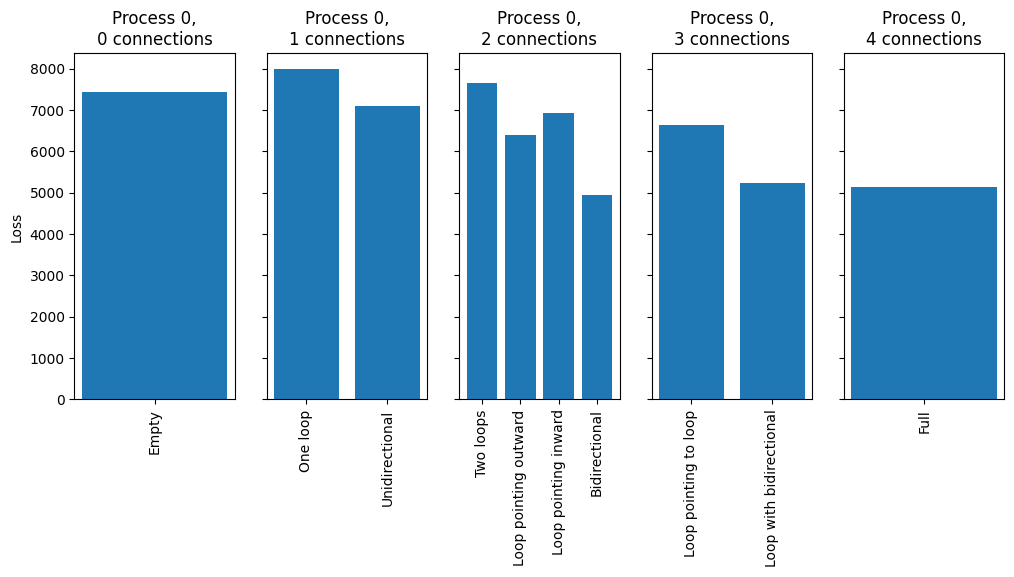

[{0: {'Empty': 7445.154358948504},
  1: {'One loop': 7980.513331429484, 'Unidirectional': 7102.718419092943},
  2: {'Two loops': 7661.401049577294,
   'Loop pointing outward': 6398.338351481783,
   'Loop pointing inward': 6914.793911133378,
   'Bidirectional': 4942.083467762195},
  3: {'Loop pointing to loop': 6631.103177794837,
   'Loop with bidirectional': 5221.581229032267},
  4: {'Full': 5145.514620380551}}]

In [55]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0.95], [0.8, 0]]))

### Rotational

In [56]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0.5, 0.8],[-0.8, 0.5]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))))

Process dynamics: [[ 0.5  0.8]
 [-0.8  0.5]]
Eigenvalues: [0.5+0.8j 0.5-0.8j]
Kalman filter M: [[ 0.31748527  0.50797643]
 [-0.50797643  0.31748527]]
Kalman filter K: [[ 3.65029463e-01  0.00000000e+00]
 [-2.46169098e-18  3.65029463e-01]]
Kalman filter loss: 5006.216403683191


  0%|                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.9011395  0.05447906]
 [0.01094838 0.87497222]]
NN W: [[ 0.92322581 -0.06470541]
 [-0.01881231  0.95201683]]
Loss: 10791.302216118293
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.95430885  0.03429553]
 [-0.08504441  0.8669579 ]]
NN W: [[ 0.86597553 -0.03553177]
 [ 0.08151821  0.95721554]]
Loss: 12356.882615044282
Testing Empty, Trial 3


 10%|███████████████▏                                                                                                                                        | 1/10 [01:38<14:49, 98.88s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.93312008  0.01391375]
 [-0.06090089  0.88322323]]
NN W: [[ 0.89215544 -0.01811858]
 [ 0.05491416  0.94128256]]
Loss: 12139.842736130457
Testing One loop, Trial 1
NN M: [[0.33457342 0.        ]
 [0.         0.        ]]
NN K: [[0.64825084 0.28832456]
 [0.16196403 0.80162858]]
NN W: [[ 1.07739964 -0.11767431]
 [-0.24981707  1.07094887]]
Loss: 10595.168683869098
Testing One loop, Trial 2
NN M: [[0.37724762 0.        ]
 [0.         0.        ]]
NN K: [[0.60193222 0.43828455]
 [0.1018672  0.80419237]]
NN W: [[ 1.06283969 -0.31029806]
 [-0.17236819  1.08806286]]
Loss: 10002.242402614313
Testing One loop, Trial 3


 20%|██████████████████████████████▍                                                                                                                         | 2/10 [03:19<13:17, 99.71s/it]

NN M: [[0.34222711 0.        ]
 [0.         0.        ]]
NN K: [[0.69085287 0.34752457]
 [0.10478373 0.80379204]]
NN W: [[ 0.98374485 -0.1617973 ]
 [-0.15750358  1.06678261]]
Loss: 10502.275464299444
Testing Unidirectional, Trial 1
NN M: [[0.         0.43725771]
 [0.         0.        ]]
NN K: [[ 0.55319835 -0.14856427]
 [ 0.05713332  0.81943245]]
NN W: [[ 1.01801168  0.00907836]
 [-0.04050254  1.00975412]]
Loss: 10124.244541349393
Testing Unidirectional, Trial 2
NN M: [[ 0.          0.40302895]
 [-0.          0.        ]]
NN K: [[ 0.59513008 -0.28140635]
 [-0.02191278  0.83905291]]
NN W: [[1.00942714 0.16177858]
 [0.05976383 1.00371538]]
Loss: 9808.726263012406
Testing Unidirectional, Trial 3


 30%|█████████████████████████████████████████████▌                                                                                                          | 3/10 [04:59<11:38, 99.77s/it]

NN M: [[0.         0.48665176]
 [0.         0.        ]]
NN K: [[ 0.50056872 -0.22442739]
 [ 0.11625172  0.80533356]]
NN W: [[ 1.02284672  0.1126871 ]
 [-0.10633315  1.0096951 ]]
Loss: 9950.673427446742
Testing Two loops, Trial 1
NN M: [[ 0.3972214   0.        ]
 [-0.          0.26643472]]
NN K: [[ 0.61426425  0.43847926]
 [-0.2620199   0.73509527]]
NN W: [[ 0.97078923 -0.21476026]
 [ 0.05900909  0.96476968]]
Loss: 10533.409475827297
Testing Two loops, Trial 2
NN M: [[0.28889891 0.        ]
 [0.         0.23784865]]
NN K: [[ 0.72582239  0.32115542]
 [-0.24919994  0.75365646]]
NN W: [[ 0.94558419 -0.1385828 ]
 [ 0.0723454   0.95965286]]
Loss: 10451.87833780674
Testing Two loops, Trial 3


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 4/10 [06:39<10:00, 100.00s/it]

NN M: [[0.35029669 0.        ]
 [0.         0.21477188]]
NN K: [[ 0.75787076  0.46520139]
 [-0.17439716  0.69308743]]
NN W: [[ 0.82980698 -0.23618006]
 [ 0.01192553  1.08567779]]
Loss: 11005.007382836984
Testing Loop pointing outward, Trial 1
NN M: [[ 0.34568938  0.        ]
 [-0.39166943  0.        ]]
NN K: [[0.7042392  0.33949338]
 [0.08852828 0.55223854]]
NN W: [[ 0.92576735 -0.13960225]
 [ 0.10145549  1.04396276]]
Loss: 9079.623089654197
Testing Loop pointing outward, Trial 2
NN M: [[ 0.28237861  0.        ]
 [-0.34656063  0.        ]]
NN K: [[0.63448393 0.26605768]
 [0.20327438 0.54696539]]
NN W: [[ 1.12331701 -0.19270289]
 [-0.09495535  1.1674678 ]]
Loss: 9202.138387472809
Testing Loop pointing outward, Trial 3


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [08:20<08:21, 100.28s/it]

NN M: [[ 0.33653642  0.        ]
 [-0.36360868  0.        ]]
NN K: [[0.74679588 0.3208283 ]
 [0.16705451 0.60223223]]
NN W: [[ 0.90561089 -0.10402182]
 [-0.01114563  1.00450951]]
Loss: 8929.107898712016
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.39458196  0.2743827 ]]
NN K: [[ 0.8597105  -0.05324529]
 [-0.12190645  0.55318231]]
NN W: [[0.98266408 0.05910795]
 [0.06938219 0.89706701]]
Loss: 9474.71231772757
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.37021063  0.22775012]]
NN K: [[ 0.8369021  -0.08060497]
 [ 0.00707834  0.46639835]]
NN W: [[ 0.99743324  0.09861984]
 [-0.03564082  1.07461262]]
Loss: 9461.008494279566
Testing Loop pointing inward, Trial 3


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6/10 [10:01<06:42, 100.69s/it]

NN M: [[ 0.          0.        ]
 [-0.48281799  0.2743028 ]]
NN K: [[ 0.85188998 -0.06250769]
 [ 0.03435166  0.4758545 ]]
NN W: [[ 0.97870288  0.0666154 ]
 [-0.07472101  0.93034393]]
Loss: 9423.577018465045
Testing Bidirectional, Trial 1
NN M: [[ 0.          0.49388813]
 [-0.32097006  0.        ]]
NN K: [[ 0.62022243 -0.25109814]
 [ 0.01438162  0.57573891]]
NN W: [[ 0.9372214  -0.0108704 ]
 [ 0.19310071  1.08471094]]
Loss: 7867.531818014235
Testing Bidirectional, Trial 2
NN M: [[ 0.          0.50511213]
 [-0.40785577  0.        ]]
NN K: [[ 0.52122822 -0.22285511]
 [ 0.2269771   0.49664323]]
NN W: [[ 1.01709967  0.02550178]
 [-0.04876596  1.09934288]]
Loss: 8160.663999943589
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7/10 [12:02<05:21, 107.30s/it]

NN M: [[ 0.          0.4526109 ]
 [-0.39908924  0.        ]]
NN K: [[ 0.47397841 -0.29391043]
 [ 0.28383509  0.51494488]]
NN W: [[ 1.05786575  0.19567387]
 [-0.18935094  1.03209991]]
Loss: 8171.698734719069
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.24825287  0.        ]
 [-0.37191001  0.20224715]]
NN K: [[0.76334198 0.11713672]
 [0.02357102 0.45781731]]
NN W: [[ 0.98380635  0.08473362]
 [-0.02422041  1.09072614]]
Loss: 8470.385385443471
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.34416399  0.        ]
 [-0.32529682  0.240403  ]]
NN K: [[ 0.68501248  0.34227247]
 [-0.00965875  0.48213845]]
NN W: [[ 0.96264068 -0.12973424]
 [ 0.01085553  1.12179142]]
Loss: 8297.027455269174
Testing Loop pointing to loop, Trial 3


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8/10 [14:34<04:02, 121.48s/it]

NN M: [[ 0.27869117  0.        ]
 [-0.38712068  0.19078035]]
NN K: [[0.77825753 0.05540786]
 [0.12119852 0.51508556]]
NN W: [[ 0.95034219  0.19075977]
 [-0.16536098  0.97040163]]
Loss: 8668.08123611618
Testing Loop with bidirectional, Trial 1
NN M: [[ 0.33172845  0.45331229]
 [-0.42001194  0.        ]]
NN K: [[ 0.46736077 -0.09205104]
 [ 0.10123365  0.50049487]]
NN W: [[1.01989037 0.15363579]
 [0.04913639 1.07144445]]
Loss: 6370.490060356284
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.42545071  0.44157211]
 [-0.50583377  0.        ]]
NN K: [[0.46255076 0.11290424]
 [0.0581454  0.5007555 ]]
NN W: [[ 0.8947536  -0.08671598]
 [ 0.20519733  0.97611777]]
Loss: 6434.616743550912
Testing Loop with bidirectional, Trial 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9/10 [17:05<02:10, 130.86s/it]

NN M: [[ 0.34469359  0.53140757]
 [-0.40934847  0.        ]]
NN K: [[ 0.40447707 -0.00303832]
 [ 0.15877716  0.38693062]]
NN W: [[ 1.04903582  0.06087927]
 [-0.00695538  1.29131459]]
Loss: 6256.944700178955
Testing Full, Trial 1
NN M: [[ 0.33961732  0.42689435]
 [-0.40037772  0.34135594]]
NN K: [[ 0.41953042  0.09817783]
 [-0.07070022  0.44700582]]
NN W: [[ 0.98244917 -0.0543648 ]
 [ 0.01113463  0.99461554]]
Loss: 5698.044076765526
Testing Full, Trial 2
NN M: [[ 0.26821819  0.41164892]
 [-0.44548428  0.2969382 ]]
NN K: [[0.44858458 0.04269195]
 [0.03138821 0.38030569]]
NN W: [[ 1.04429601 -0.01745254]
 [-0.04413818  1.11355635]]
Loss: 5778.764480998991
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [19:34<00:00, 117.43s/it]

NN M: [[ 0.29369142  0.50587867]
 [-0.37296675  0.24651453]]
NN K: [[0.44445024 0.09891275]
 [0.05223551 0.37840083]]
NN W: [[ 0.96934527 -0.10317753]
 [-0.01857919  1.21844374]]
Loss: 5925.024196956214


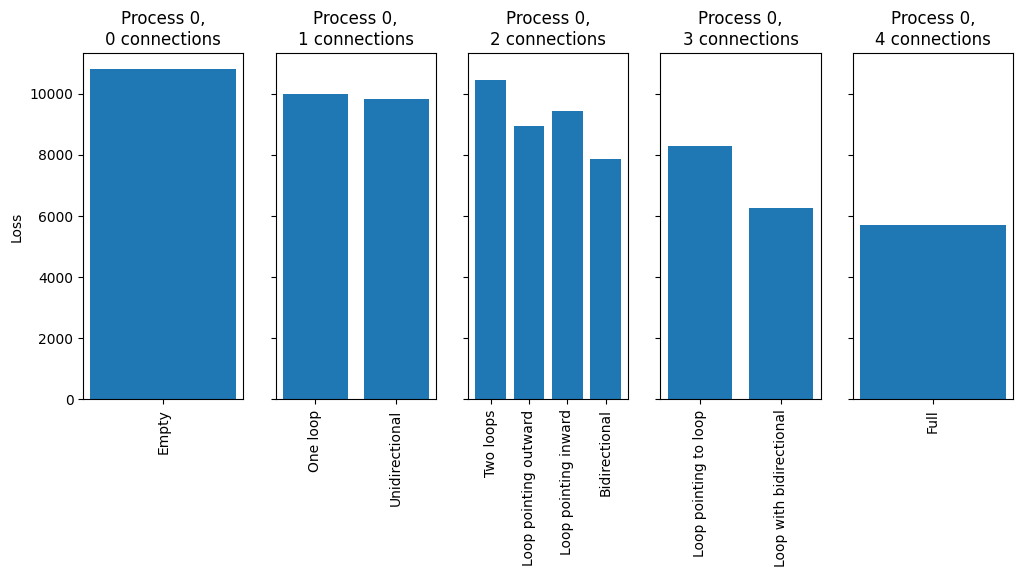

[{0: {'Empty': 10791.302216118293},
  1: {'One loop': 10002.242402614313, 'Unidirectional': 9808.726263012406},
  2: {'Two loops': 10451.87833780674,
   'Loop pointing outward': 8929.107898712016,
   'Loop pointing inward': 9423.577018465045,
   'Bidirectional': 7867.531818014235},
  3: {'Loop pointing to loop': 8297.027455269174,
   'Loop with bidirectional': 6256.944700178955},
  4: {'Full': 5698.044076765526}}]

In [57]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))),
           A=np.array([[0.5, 0.8],[-0.8, 0.5]]))

## Three neurons

### Fully connected, three distinct eigenvalues

In [58]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.3, -0.3, -0.9], [-0.1, 0.9, -0.1], [0.2, 0.1, 1.2]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(100, 5e-7), np.full(40, 1e-7))))

Process dynamics: [[ 0.3 -0.3 -0.9]
 [-0.1  0.9 -0.1]
 [ 0.2  0.1  1.2]]
Eigenvalues: [0.54384472 0.9        0.95615528]
Kalman filter M: [[ 0.21456445 -0.14178882 -0.38083142]
 [-0.05114364  0.57434273 -0.07343981]
 [ 0.16588759  0.03080532  0.58988455]]
Kalman filter K: [[ 0.37595227 -0.0334215  -0.15346141]
 [-0.0334215   0.35267976 -0.01780964]
 [-0.15346141 -0.01780964  0.39184935]]
Kalman filter loss: 8270.099232061486


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.20295983 0.         0.        ]
 [0.         0.10615615 0.        ]
 [0.         0.         0.22842711]]
NN K: [[ 0.66796187 -0.22805217 -0.33259706]
 [ 0.35034258  0.35880578 -0.50990952]
 [-0.28544139  0.44891527  0.68576915]]
NN W: [[ 0.83110868  0.12924474  0.08103465]
 [-0.348666    1.05434982  0.51123663]
 [ 0.20147109 -0.62774437  0.41697313]]
Loss: 12104.509957990778
Testing Empty, Trial 2
NN M: [[0.30025167 0.         0.        ]
 [0.         0.12509751 0.        ]
 [0.         0.         0.25364171]]
NN K: [[ 0.62061979 -0.14265779 -0.37164702]
 [ 0.24925028  0.47171504 -0.47541647]
 [-0.53367807  0.29516854  0.89864131]]
NN W: [[ 0.73603275  0.01722078 -0.01695703]
 [-0.10170521  1.11257729  0.44375844]
 [ 0.26947976 -0.37571531  0.49203936]]
Loss: 11892.76544492278
Testing Empty, Trial 3


  6%|█████████▎                                                                                                                                           | 1/16 [06:05<1:31:23, 365.58s/it]

NN M: [[0.26609826 0.         0.        ]
 [0.         0.21792273 0.        ]
 [0.         0.         0.24409882]]
NN K: [[ 0.52936896 -0.38052113 -0.39857521]
 [ 0.36084097  0.38161155 -0.61322317]
 [-0.28173929  0.44864145  0.65955599]]
NN W: [[ 0.73111547  0.26705646  0.11551013]
 [-0.37779819  0.78202253  0.43996933]
 [ 0.18565462 -0.48147849  0.41338295]]
Loss: 10505.17312997942
Testing Unidirectional, Trial 1
NN M: [[0.26227394 0.         0.        ]
 [0.09914984 0.20764839 0.        ]
 [0.         0.         0.24416656]]
NN K: [[ 0.49843966 -0.48395904 -0.32997417]
 [ 0.55122689  0.50473174 -0.69841496]
 [-0.24041254  0.25727741  0.63632587]]
NN W: [[ 0.68508062  0.36654599  0.26268389]
 [-0.52926823  0.58271067  0.428977  ]
 [ 0.2013906  -0.23910225  0.58813815]]
Loss: 11365.025530373545
Testing Unidirectional, Trial 2
NN M: [[0.19226849 0.         0.        ]
 [0.11415585 0.12129691 0.        ]
 [0.         0.         0.26908932]]
NN K: [[ 0.40984731 -0.00948053 -0.10763887]
 

 12%|██████████████████▋                                                                                                                                  | 2/16 [12:08<1:24:54, 363.90s/it]

NN M: [[0.2718951  0.         0.        ]
 [0.17608411 0.11466061 0.        ]
 [0.         0.         0.27767624]]
NN K: [[ 0.47435639 -0.23526822 -0.24482728]
 [ 0.33330661  0.51587563 -0.56390796]
 [-0.3109791   0.27871066  0.63023268]]
NN W: [[ 0.78620224  0.21378202 -0.05222749]
 [-0.47581671  0.8550209   0.49003209]
 [ 0.36466286 -0.34059114  0.63670265]]
Loss: 11549.533655621039
Testing Source, Trial 1
NN M: [[0.23325803 0.         0.        ]
 [0.24094014 0.19451098 0.        ]
 [0.12072995 0.         0.29233551]]
NN K: [[ 0.3806158  -0.34158342 -0.0905097 ]
 [ 0.42952304  0.55844086 -0.44223771]
 [-0.5894692  -0.03426061  0.8751177 ]]
NN W: [[ 0.74954261  0.30930533 -0.11828358]
 [-0.93081904  0.68847285  0.18070073]
 [ 0.20818302  0.20951902  0.63681485]]
Loss: 11924.851106761245
Testing Source, Trial 2
NN M: [[0.25526172 0.         0.        ]
 [0.01363621 0.18834002 0.        ]
 [0.2452505  0.         0.37638048]]
NN K: [[ 0.40542135 -0.1761868  -0.09765738]
 [ 0.27482345  0

 19%|███████████████████████████▉                                                                                                                         | 3/16 [16:27<1:08:27, 315.95s/it]

NN M: [[0.27410328 0.         0.        ]
 [0.19874955 0.05804432 0.        ]
 [0.19703159 0.         0.36822071]]
NN K: [[ 0.49727353 -0.06903077 -0.24728827]
 [ 0.078991    0.61635385 -0.36053658]
 [-0.52580338 -0.01477979  0.89732674]]
NN W: [[ 0.97487811 -0.05402167 -0.06563194]
 [-0.42702456  1.116574    0.19845476]
 [ 0.18373579 -0.01213395  0.5418118 ]]
Loss: 12132.292584507632
Testing Bidirectional, Trial 1
NN M: [[ 0.36279297 -0.0778278   0.        ]
 [ 0.14430311  0.02707132  0.        ]
 [ 0.          0.          0.3018475 ]]
NN K: [[ 0.46260173 -0.00472885 -0.18887732]
 [ 0.05653924  0.6182364  -0.26086966]
 [-0.61074691  0.03745424  0.93567768]]
NN W: [[ 0.74329242 -0.07977229 -0.18923832]
 [-0.1724633   1.16025522  0.20670882]
 [ 0.41411207 -0.0748672   0.55847547]]
Loss: 11848.163676957629
Testing Bidirectional, Trial 2
NN M: [[0.07081235 0.19069725 0.        ]
 [0.26396504 0.13166962 0.        ]
 [0.         0.         0.21506911]]
NN K: [[ 0.37223714 -0.17355523 -0.142

 25%|█████████████████████████████████████▊                                                                                                                 | 4/16 [19:28<52:34, 262.86s/it]

NN M: [[0.18891958 0.1157044  0.        ]
 [0.04493833 0.21547576 0.        ]
 [0.         0.         0.23568406]]
NN K: [[ 0.37624177 -0.33959686 -0.05799433]
 [ 0.26483226  0.46092374 -0.33710302]
 [-0.39408371  0.06109668  0.7371069 ]]
NN W: [[ 0.92166599  0.32687727 -0.15972999]
 [-0.55937288  1.05027956  0.36230597]
 [ 0.28485206 -0.03590366  0.70161291]]
Loss: 11135.429533313882
Testing Linear, Trial 1
NN M: [[ 0.22010572  0.          0.        ]
 [ 0.34715366 -0.09616096  0.        ]
 [ 0.          0.01054141  0.17659548]]
NN K: [[ 0.53675902  0.02784159 -0.26207675]
 [ 0.28098668  0.56940202 -0.63627761]
 [-0.46809755  0.33322683  0.69487967]]
NN W: [[ 1.03024635 -0.13915135 -0.13959479]
 [-0.27965782  0.93638541  0.63532312]
 [ 0.38797178 -0.46159381  0.5062786 ]]
Loss: 12910.756935185802
Testing Linear, Trial 2
NN M: [[ 0.27465306  0.          0.        ]
 [ 0.31021735  0.01452883  0.        ]
 [ 0.         -0.0583265   0.25483718]]
NN K: [[ 0.41110594 -0.00328259 -0.23790754

 31%|███████████████████████████████████████████████▏                                                                                                       | 5/16 [22:32<42:57, 234.28s/it]

NN M: [[0.24511243 0.         0.        ]
 [0.28022484 0.08256827 0.        ]
 [0.         0.09338928 0.23609742]]
NN K: [[ 0.493567   -0.18481914 -0.22716763]
 [ 0.46135342  0.55669248 -0.7987504 ]
 [-0.46812112  0.35616267  0.61810318]]
NN W: [[ 0.9007024   0.14522321  0.01100423]
 [-0.4442457   0.66450318  0.59526623]
 [ 0.36731939 -0.39114197  0.44497572]]
Loss: 11396.44302090981
Testing Sink, Trial 1
NN M: [[ 0.29173586  0.          0.        ]
 [ 0.13392838  0.11693655 -0.19240511]
 [ 0.          0.          0.30540435]]
NN K: [[ 0.37592658 -0.04155832 -0.05015214]
 [-0.07747818  0.73954826 -0.26242882]
 [-0.4506943  -0.1097026   0.74819953]]
NN W: [[ 0.94727499 -0.13686062 -0.35085381]
 [-0.26019742  0.93047031  0.28375638]
 [ 0.51036418  0.08358827  0.73163207]]
Loss: 11252.947312581484
Testing Sink, Trial 2
NN M: [[ 0.3720111   0.          0.        ]
 [ 0.32185573  0.06242971 -0.12070002]
 [ 0.          0.          0.38646767]]
NN K: [[ 0.43645582 -0.34151611 -0.22022332]
 [-

 38%|████████████████████████████████████████████████████████▋                                                                                              | 6/16 [25:33<36:02, 216.22s/it]

NN M: [[ 0.28187974  0.          0.        ]
 [ 0.14746193 -0.06622893 -0.21903928]
 [ 0.          0.          0.24757727]]
NN K: [[ 4.45733097e-01  2.93245153e-02 -1.26397222e-01]
 [ 4.01709151e-04  7.09680326e-01 -3.35747380e-01]
 [-4.46812180e-01  1.12695755e-02  7.34742686e-01]]
NN W: [[ 0.92944017 -0.20211082 -0.31940218]
 [-0.16772285  1.09026029  0.47963211]
 [ 0.38178421 -0.13157556  0.6986978 ]]
Loss: 13933.650947638753
Testing Bidirectional out, Trial 1
NN M: [[0.12766486 0.1970348  0.        ]
 [0.08548341 0.14391522 0.        ]
 [0.24737912 0.         0.32071593]]
NN K: [[ 0.342371   -0.15794755 -0.1809378 ]
 [ 0.23121246  0.42318551 -0.54024066]
 [-0.38728159  0.35875726  0.60202476]]
NN W: [[ 1.17066646  0.01152078 -0.13738845]
 [-0.42894284  0.98286014  0.56538856]
 [ 0.30037175 -0.5301838   0.50193928]]
Loss: 12088.2036396258
Testing Bidirectional out, Trial 2
NN M: [[0.1463358  0.17155743 0.        ]
 [0.22053345 0.00728553 0.        ]
 [0.20548298 0.         0.2608194

 44%|██████████████████████████████████████████████████████████████████                                                                                     | 7/16 [28:26<30:19, 202.19s/it]

NN M: [[0.2730584  0.09805737 0.        ]
 [0.03165339 0.18694622 0.        ]
 [0.20318118 0.         0.24929285]]
NN K: [[ 0.4100606  -0.16211648 -0.11980556]
 [ 0.26114565  0.56170032 -0.42514553]
 [-0.60524179  0.13689055  0.7289892 ]]
NN W: [[ 0.90879116  0.02198102 -0.19584749]
 [-0.33792421  0.99781943  0.41062784]
 [ 0.25386035 -0.17703725  0.58257986]]
Loss: 11224.22740137641
Testing Transitive triangle, Trial 1
NN M: [[ 0.22683327  0.          0.        ]
 [ 0.29220486  0.03533708  0.        ]
 [-0.0038718   0.04897198  0.19316725]]
NN K: [[ 0.48264555 -0.25426833 -0.21474887]
 [ 0.44969978  0.53655512 -0.67860743]
 [-0.48641144  0.28264385  0.93047984]]
NN W: [[ 0.8853406   0.27181235  0.06839619]
 [-0.62748394  0.84246334  0.44282826]
 [ 0.34581153 -0.25815844  0.47821776]]
Loss: 12282.345809733406
Testing Transitive triangle, Trial 2
NN M: [[ 0.19950816  0.          0.        ]
 [ 0.26414076 -0.00257836  0.        ]
 [ 0.0381876   0.15444565  0.27014061]]
NN K: [[ 0.4893064

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 8/16 [31:20<25:44, 193.00s/it]

NN M: [[ 0.21500786  0.          0.        ]
 [ 0.39032217 -0.08605395  0.        ]
 [ 0.24617105  0.17881762  0.35778394]]
NN K: [[ 0.44081187 -0.0178543  -0.20401752]
 [ 0.2486298   0.66021514 -0.58528713]
 [-0.65398415  0.06253509  0.93356925]]
NN W: [[ 1.16990439 -0.07208266 -0.11107264]
 [-0.50668894  1.01325857  0.40107202]
 [ 0.19410523 -0.22653891  0.39942583]]
Loss: 13940.515401590237
Testing Bidirectional in, Trial 1
NN M: [[ 0.01554736  0.11587573 -0.15309752]
 [ 0.15332847  0.13354451  0.        ]
 [ 0.          0.          0.31626494]]
NN K: [[ 0.42590199 -0.09185225 -0.13200513]
 [-0.02215638  0.59066176 -0.28988198]
 [-0.50239526  0.03635121  0.97952035]]
NN W: [[ 0.88806224 -0.14717783 -0.16344821]
 [-0.08659837  1.13805206  0.23126164]
 [ 0.34556657 -0.0783413   0.53658934]]
Loss: 11718.708592370498
Testing Bidirectional in, Trial 2
NN M: [[-0.04551369  0.23217769 -0.12589301]
 [ 0.04391629  0.22150353  0.        ]
 [ 0.          0.          0.10008071]]
NN K: [[ 0.307

 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 9/16 [34:12<21:46, 186.61s/it]

NN M: [[ 0.25831702 -0.01719175 -0.24333779]
 [ 0.14197871  0.13394785  0.        ]
 [ 0.          0.          0.18837577]]
NN K: [[ 0.30602674 -0.48055725 -0.44371409]
 [ 0.18562592  0.52696745 -0.21680439]
 [-0.26075348  0.01314476  0.72221688]]
NN W: [[ 0.65828068  0.39980568  0.02334272]
 [-0.59194615  0.87913372 -0.10369651]
 [ 0.0909655  -0.03547653  0.81639575]]
Loss: 12456.099649902046
Testing Cycle, Trial 1
NN M: [[ 0.30555269  0.         -0.05480871]
 [ 0.36490999 -0.05260124  0.        ]
 [ 0.          0.11975009  0.29083515]]
NN K: [[ 0.48318879 -0.25008892 -0.41455946]
 [ 0.05473     0.63319513 -0.37183736]
 [-0.37681747 -0.09959163  0.71074907]]
NN W: [[ 0.63754845  0.13144463 -0.0998214 ]
 [-0.59704047  1.01725844  0.10460176]
 [ 0.15919818  0.0878144   0.83416608]]
Loss: 14380.913491134004
Testing Cycle, Trial 2
NN M: [[ 0.15127399  0.         -0.11580879]
 [ 0.10269899  0.21856     0.        ]
 [ 0.          0.08160318  0.18211606]]
NN K: [[ 0.37020677 -0.30999167 -0.0

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 10/16 [37:05<18:14, 182.49s/it]

NN M: [[ 0.04730381  0.         -0.12059792]
 [ 0.39056412 -0.03270904  0.        ]
 [ 0.         -0.01223245  0.22005016]]
NN K: [[ 0.40324802 -0.00244793 -0.09266194]
 [ 0.2318484   0.57982622 -0.57558936]
 [-0.66260954  0.18756865  0.81879569]]
NN W: [[ 0.91114581 -0.01654078 -0.2277638 ]
 [-0.16535941  1.10154639  0.59040624]
 [ 0.49459768 -0.22798414  0.50275689]]
Loss: 13975.019815094001
Testing Bidirectional source, Trial 1
NN M: [[0.17765819 0.11493911 0.        ]
 [0.17808    0.09359961 0.        ]
 [0.0029028  0.09989763 0.22702899]]
NN K: [[ 0.49923776 -0.23667432 -0.29334699]
 [ 0.35271111  0.52015389 -0.70393087]
 [-0.45355533  0.32579548  0.84212125]]
NN W: [[ 0.92249203  0.07307243  0.04002864]
 [-0.44028759  0.84497719  0.48755685]
 [ 0.23526421 -0.3773602   0.401751  ]]
Loss: 12134.33980259993
Testing Bidirectional source, Trial 2
NN M: [[-0.18992865  0.12859063  0.        ]
 [ 0.43000015  0.12436115  0.        ]
 [ 0.21257593  0.04276322  0.00659157]]
NN K: [[ 0.19912

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 11/16 [39:59<14:58, 179.76s/it]

NN M: [[ 0.29060201  0.04338594  0.        ]
 [ 0.17358977  0.01141839  0.        ]
 [ 0.20591312 -0.11783074  0.22144444]]
NN K: [[ 0.36708557  0.03391839 -0.19456042]
 [ 0.2133298   0.47634787 -0.5525111 ]
 [-0.57481687  0.34416254  0.6985946 ]]
NN W: [[ 1.01294615 -0.17030593 -0.26895362]
 [-0.13945243  1.09640089  0.6119572 ]
 [ 0.33272534 -0.4794596   0.44182686]]
Loss: 12484.032917064755
Testing Two bidirectionals, Trial 1
NN M: [[ 0.34564008 -0.0493922  -0.25025411]
 [ 0.25868868  0.02691722  0.        ]
 [ 0.21638863  0.          0.10569992]]
NN K: [[ 0.4578317  -0.37561833 -0.41023107]
 [ 0.29270924  0.6072481  -0.51688231]
 [-0.31316728  0.16530862  0.45386327]]
NN W: [[ 0.57093514  0.3579587   0.22364574]
 [-0.63174444  0.77118091  0.21309024]
 [-0.0483402  -0.28346144  0.81943598]]
Loss: 13359.972144617204
Testing Two bidirectionals, Trial 2
NN M: [[ 0.16662276  0.01149364 -0.17563246]
 [ 0.10058155  0.1065743   0.        ]
 [ 0.12427454  0.          0.32325073]]
NN K: [[ 0

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 12/16 [42:53<11:51, 177.96s/it]

NN M: [[-0.13058873  0.02362459  0.01829412]
 [ 0.34735073  0.28242452  0.        ]
 [ 0.45946303  0.          0.28987238]]
NN K: [[ 0.08462248 -0.13423237  0.27256552]
 [ 0.91457965  0.46988512 -1.08014216]
 [-0.25793472  0.49058823  0.14226581]]
NN W: [[ 0.73344759  0.3692712  -0.34126709]
 [-0.6186531   0.17473848  0.95854538]
 [ 0.53107219 -0.19726781  0.28937656]]
Loss: 12412.657719020188
Testing Bidirectional loop, Trial 1
NN M: [[ 0.2457154   0.15837721  0.        ]
 [ 0.00806277  0.01242107 -0.41132172]
 [ 0.38030639  0.          0.26211782]]
NN K: [[ 0.22742402 -0.06556251 -0.03022657]
 [ 0.31669777  0.76959216 -0.62139911]
 [-0.65275149  0.13578057  0.56256039]]
NN W: [[ 0.96584793 -0.08817006 -0.45997086]
 [-0.27449001  0.78212165  0.81131784]
 [ 0.09111847 -0.23768455  0.38236531]]
Loss: 14923.2876800675
Testing Bidirectional loop, Trial 2
NN M: [[ 0.07532909  0.14055515  0.        ]
 [ 0.01912696  0.20206109 -0.207986  ]
 [ 0.28135477  0.          0.30472774]]
NN K: [[ 0.3

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 13/16 [45:46<08:49, 176.45s/it]

NN M: [[ 0.2742803   0.02237994  0.        ]
 [ 0.0658739   0.1005218  -0.09377861]
 [ 0.08714271  0.          0.26117695]]
NN K: [[ 0.51501196 -0.10055833 -0.33687819]
 [-0.09701959  0.59765781 -0.12159162]
 [-0.25245872 -0.0991026   0.62680616]]
NN W: [[ 0.94602592 -0.04432446  0.0065293 ]
 [-0.18385112  1.15127406  0.06110899]
 [ 0.01103924  0.07516769  0.87233389]]
Loss: 11457.482607431424
Testing Bidirectional sink, Trial 1
NN M: [[ 0.2623768   0.          0.        ]
 [ 0.34690339 -0.12486217 -0.52774261]
 [ 0.14480302  0.04516319  0.1990688 ]]
NN K: [[ 0.4114283  -0.01154321 -0.1336471 ]
 [ 0.45309565  0.70078529 -0.82674646]
 [-0.56490513  0.3651303   0.58992343]]
NN W: [[ 1.06315734  0.03415397 -0.19012116]
 [-0.21554894  0.55189995  0.87426104]
 [ 0.37315555 -0.38116366  0.28790209]]
Loss: 15760.767783385605
Testing Bidirectional sink, Trial 2
NN M: [[ 0.265342    0.          0.        ]
 [ 0.04270465 -0.01843099 -0.28993008]
 [ 0.12223104  0.06347599  0.34457872]]
NN K: [[ 0

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 14/16 [48:40<05:51, 175.89s/it]

NN M: [[ 0.26039408  0.          0.        ]
 [ 0.0309141   0.12772749 -0.13887264]
 [ 0.25172225  0.06950354  0.43290958]]
NN K: [[ 0.41457026 -0.12282808 -0.11161279]
 [-0.0045982   0.60331118 -0.16630193]
 [-0.33758808 -0.04172059  0.59853597]]
NN W: [[ 1.11655613  0.0632584  -0.20731109]
 [-0.30796473  1.09186022  0.19531907]
 [ 0.1169022  -0.01105286  0.75089548]]
Loss: 10761.379295023238
Testing Full minus one, Trial 1
NN M: [[ 0.11283509  0.14948694  0.01688998]
 [-0.0056481   0.23391864  0.        ]
 [ 0.13206487 -0.06696854  0.02695538]]
NN K: [[ 0.1994369  -0.33398609  0.11775674]
 [ 0.49253575  0.52906118 -0.67046556]
 [-0.56009482  0.30723944  0.53411288]]
NN W: [[ 0.93474803  0.2857412  -0.31597299]
 [-0.29180563  0.71560978  0.87116101]
 [ 0.40827895 -0.18017116  0.58667924]]
Loss: 13385.239610071574
Testing Full minus one, Trial 2
NN M: [[ 0.10940531  0.0685273  -0.10230463]
 [ 0.40409557 -0.09633297  0.        ]
 [ 0.31479368 -0.12077409  0.33282372]]
NN K: [[ 0.3890488

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 15/16 [51:34<02:55, 175.27s/it]

NN M: [[ 0.09569419  0.06893182 -0.15843845]
 [ 0.10312906  0.14611087  0.        ]
 [ 0.32095403 -0.16238643  0.374368  ]]
NN K: [[ 0.39551869  0.02161424 -0.14295446]
 [ 0.02090151  0.53047085 -0.43946862]
 [-0.42632103  0.23444551  0.72548502]]
NN W: [[ 1.0606306  -0.20804879 -0.18182203]
 [-0.11993181  1.12317509  0.41577441]
 [ 0.19016579 -0.24700047  0.5817038 ]]
Loss: 11104.369515631344
Testing Full, Trial 1
NN M: [[-0.11183303  0.10659557  0.18248373]
 [ 0.33313618  0.1440497  -0.50187176]
 [ 0.16498966  0.09219     0.09108905]]
NN K: [[ 0.26040146 -0.13072532  0.22318218]
 [ 0.65973812  0.54311249 -1.01578143]
 [-0.36848858  0.5610626   0.25818249]]
NN W: [[ 0.81355819  0.37365071 -0.2743138 ]
 [-0.29185424  0.16100967  0.98222451]
 [ 0.51308285 -0.36593942  0.14149224]]
Loss: 15145.675151345791
Testing Full, Trial 2
NN M: [[ 0.09040366  0.15556455  0.04966013]
 [ 0.21265328  0.00135794 -0.17221452]
 [ 0.62681563 -0.23233453  0.30982306]]
NN K: [[ 0.44752702  0.08030303 -0.213

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [54:29<00:00, 204.34s/it]

NN M: [[ 0.15854699  0.20621757  0.10031079]
 [-0.09589799  0.18014211 -0.40650957]
 [ 0.22725883  0.01393973  0.31023717]]
NN K: [[ 0.3753348  -0.46684177 -0.18292397]
 [ 0.18609864  0.43620221 -0.27199144]
 [-0.39623905 -0.07341434  0.53894159]]
NN W: [[ 0.93851313  0.30494316 -0.07554652]
 [-0.63601784  0.94598267  0.45771551]
 [-0.01118707  0.07850329  0.85502403]]
Loss: 12989.110842008315


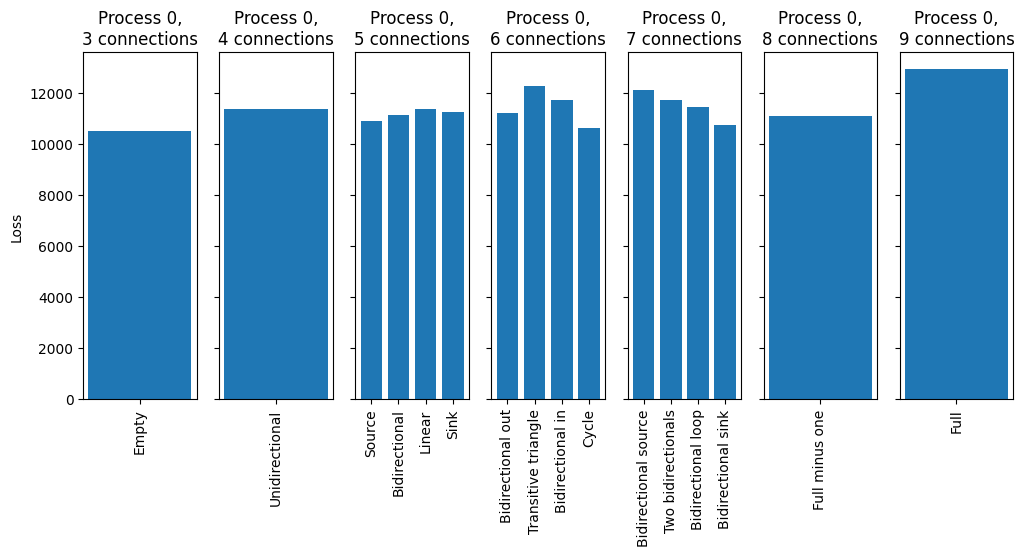

[{3: {'Empty': 10505.17312997942},
  4: {'Unidirectional': 11365.025530373545},
  5: {'Source': 10889.81653090333,
   'Bidirectional': 11135.429533313882,
   'Linear': 11396.44302090981,
   'Sink': 11252.947312581484},
  6: {'Bidirectional out': 11224.22740137641,
   'Transitive triangle': 12282.345809733406,
   'Bidirectional in': 11718.708592370498,
   'Cycle': 10620.80371840711},
  7: {'Bidirectional source': 12134.33980259993,
   'Two bidirectionals': 11748.472993876128,
   'Bidirectional loop': 11457.482607431424,
   'Bidirectional sink': 10761.379295023238},
  8: {'Full minus one': 11104.369515631344},
  9: {'Full': 12953.8021078036}}]

In [59]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(100, 5e-7), np.full(40, 1e-7))),
           A=np.array([[0.3, -0.3, -0.9], [-0.1, 0.9, -0.1], [0.2, 0.1, 1.2]]))

### 2D rotation, plus scaling

In [60]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))))

Process dynamics: [[ 0.6  0.8  0. ]
 [-0.8  0.6  0. ]
 [ 0.   0.   0.9]]
Eigenvalues: [0.6+0.8j 0.6-0.8j 0.9+0.j ]
Kalman filter M: [[ 0.36576708  0.48768944  0.        ]
 [-0.48768944  0.36576708  0.        ]
 [ 0.          0.          0.58788979]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18  0.00000000e+00]
 [ 1.17873672e-17  3.90388203e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.46789125e-01]]
Kalman filter loss: 8538.957570365214


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.36741778 0.         0.        ]
 [0.         0.26864311 0.        ]
 [0.         0.         0.42510196]]
NN K: [[ 0.55322281  0.15366241  0.16051978]
 [-0.26295352  0.43583251  0.30424661]
 [-0.09338218 -0.33202113  0.61127268]]
NN W: [[ 1.28810148 -0.03673924 -0.30321268]
 [ 0.12421539  1.41264621 -0.57933402]
 [ 0.30963929  0.35665491  0.55895763]]
Loss: 15664.942501211237
Testing Empty, Trial 2
NN M: [[0.48116319 0.         0.        ]
 [0.         0.12698209 0.        ]
 [0.         0.         0.33999083]]
NN K: [[ 0.4747032   0.36450933 -0.03154987]
 [-0.13248398  0.60318976  0.27336955]
 [ 0.03895917 -0.25313719  0.68005705]]
NN W: [[ 1.31986825 -0.18239812  0.1114573 ]
 [ 0.09758404  1.27698553 -0.40067687]
 [ 0.08293026  0.30731132  0.71912807]]
Loss: 16486.26905255973
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:12<18:00, 72.04s/it]

NN M: [[0.0906571  0.         0.        ]
 [0.         0.397457   0.        ]
 [0.         0.         0.61848742]]
NN K: [[ 0.58858406 -0.14937107 -0.14533664]
 [-0.09801072  0.55894413 -0.03177301]
 [ 0.0920451   0.01944434  0.64944365]]
NN W: [[ 1.45879782  0.45494185  0.16531776]
 [-0.33502273  1.348088   -0.00429141]
 [-0.08580725  0.00844218  0.50451589]]
Loss: 15693.13120061713
Testing Unidirectional, Trial 1
NN M: [[ 0.34640191  0.          0.        ]
 [-0.32540211  0.11304124  0.        ]
 [ 0.          0.          0.29159122]]
NN K: [[ 0.537638    0.21159814 -0.01218427]
 [-0.05188278  0.46606444 -0.43344635]
 [-0.02725701  0.25409727  0.87692169]]
NN W: [[ 1.40273912e+00 -5.54425098e-02 -4.88796239e-04]
 [ 2.04879176e-01  1.19307235e+00  4.96176762e-01]
 [-8.65705328e-02 -2.43961306e-01  5.68950377e-01]]
Loss: 14230.232871469494
Testing Unidirectional, Trial 2
NN M: [[ 0.30234775  0.          0.        ]
 [-0.21622157  0.20871747  0.        ]
 [ 0.          0.          0.527

 12%|███████████████████                                                                                                                                     | 2/16 [02:23<16:44, 71.75s/it]

NN M: [[ 0.01214816  0.          0.        ]
 [-0.3486213   0.14543929  0.        ]
 [ 0.          0.          0.6085903 ]]
NN K: [[ 0.60637097 -0.33733686  0.08826624]
 [ 0.32378307  0.43168487  0.02902268]
 [-0.01602146  0.05391333  0.69234953]]
NN W: [[ 1.20104937  0.61222165 -0.05794628]
 [-0.70750673  1.07529106  0.04588771]
 [ 0.0126762  -0.05043956  0.50300023]]
Loss: 14350.17612757444
Testing Source, Trial 1
NN M: [[ 0.34727542  0.          0.        ]
 [-0.17831267  0.19164215  0.        ]
 [ 0.0633266   0.          0.47222175]]
NN K: [[ 0.50855687  0.14698744 -0.25208613]
 [-0.00331361  0.56149688  0.17953927]
 [ 0.27437552 -0.00325271  0.76893647]]
NN W: [[ 1.37124737  0.16239138  0.32735524]
 [ 0.02102108  1.27082707 -0.25323615]
 [-0.25264596  0.12884184  0.50887182]]
Loss: 13676.084647598793
Testing Source, Trial 2
NN M: [[ 0.47656688  0.          0.        ]
 [-0.25861701  0.1956073   0.        ]
 [ 0.30192571  0.          0.45784054]]
NN K: [[ 0.44513094  0.34811238  0.

 19%|████████████████████████████▌                                                                                                                           | 3/16 [03:35<15:31, 71.63s/it]

NN M: [[ 0.41827806  0.          0.        ]
 [-0.15436167  0.2820668   0.        ]
 [-0.01337577  0.          0.56112549]]
NN K: [[ 0.38141669  0.44691705 -0.25987913]
 [-0.32327212  0.51215632 -0.16124991]
 [ 0.17071021  0.10695157  0.81369418]]
NN W: [[ 1.18448248 -0.4862668   0.250257  ]
 [ 0.43363035  1.11520586  0.19895436]
 [-0.14100379  0.04983965  0.42827911]]
Loss: 13474.500354177242
Testing Bidirectional, Trial 1
NN M: [[ 0.29032443  0.11476829  0.        ]
 [-0.19828665  0.35687522  0.        ]
 [ 0.          0.          0.62337385]]
NN K: [[ 5.31362568e-01  1.83658625e-01 -1.34226814e-02]
 [-3.81762834e-01  6.05939141e-01 -2.00412507e-01]
 [-6.43244988e-04 -7.83888987e-03  7.37228396e-01]]
NN W: [[ 1.23649236e+00 -1.46264072e-01  1.02489121e-02]
 [ 3.27161269e-01  9.48940697e-01  1.58898861e-01]
 [ 2.82989405e-03 -5.35157276e-04  4.43933786e-01]]
Loss: 11562.597797340397
Testing Bidirectional, Trial 2
NN M: [[ 0.04436477  0.31524992  0.        ]
 [-0.25687973  0.35914361  

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [04:46<14:18, 71.50s/it]

NN M: [[ 0.28447508  0.19158756  0.        ]
 [-0.24407447  0.14836604  0.        ]
 [ 0.          0.          0.56638361]]
NN K: [[ 4.40753964e-01  2.59630070e-01 -1.34851160e-01]
 [-1.71533660e-01  4.60185946e-01  5.85013037e-02]
 [-5.05429159e-04 -6.94551743e-02  6.29677645e-01]]
NN W: [[ 1.25334651 -0.49711873  0.17561921]
 [ 0.51217853  1.316788   -0.05140666]
 [ 0.06067043  0.04106115  0.6020569 ]]
Loss: 11260.981290429223
Testing Linear, Trial 1
NN M: [[ 0.13354564  0.          0.        ]
 [-0.36429325  0.2048722   0.        ]
 [ 0.         -0.02761288  0.44098375]]
NN K: [[ 0.53269846 -0.06140881  0.30853062]
 [ 0.11726601  0.42398045 -0.06077401]
 [-0.29951152  0.00280658  0.64983461]]
NN W: [[ 1.38683346  0.35861303 -0.38565402]
 [-0.18344779  1.35193043  0.32159795]
 [ 0.38179723 -0.07310562  0.58246356]]
Loss: 13403.590703374619
Testing Linear, Trial 2
NN M: [[ 0.3512137   0.          0.        ]
 [-0.27516281  0.1216741   0.        ]
 [ 0.         -0.09922257  0.27459505]

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [05:57<13:05, 71.41s/it]

NN M: [[ 0.26369481  0.          0.        ]
 [-0.20072286  0.08952234  0.        ]
 [ 0.          0.26716343  0.34036974]]
NN K: [[ 0.54914801 -0.00084859 -0.44049925]
 [ 0.23901547  0.45809304  0.34589619]
 [ 0.0990721  -0.27073155  0.77898721]]
NN W: [[ 1.25164015  0.54273444  0.35555121]
 [-0.29524889  1.24046397 -0.56904673]
 [-0.21811659  0.20474284  0.43627357]]
Loss: 13690.520869651064
Testing Sink, Trial 1
NN M: [[ 0.39987769  0.          0.        ]
 [-0.31301462  0.18975354  0.17640875]
 [ 0.          0.          0.41484206]]
NN K: [[ 0.48043001  0.22154793  0.21562028]
 [ 0.03945165  0.49873037 -0.16511539]
 [-0.35159122  0.02405707  0.65767203]]
NN W: [[ 1.27964399e+00  5.65574642e-02 -4.03391493e-01]
 [-3.96709759e-04  1.18530834e+00  9.06425699e-02]
 [ 3.74933563e-01 -1.62321168e-01  6.12879087e-01]]
Loss: 13207.206065091532
Testing Sink, Trial 2
NN M: [[ 0.31049961  0.          0.        ]
 [-0.19636991  0.2862441   0.09831732]
 [ 0.          0.          0.38342554]]
NN

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [07:09<11:54, 71.42s/it]

NN M: [[ 0.4404324   0.          0.        ]
 [-0.22870023  0.16413392  0.01241253]
 [ 0.          0.          0.39630396]]
NN K: [[ 0.40809836  0.42450186 -0.15747938]
 [-0.09476521  0.42032678  0.38096012]
 [ 0.24406622 -0.20225061  0.68311172]]
NN W: [[ 1.24915301 -0.29556438  0.42900491]
 [ 0.43854078  1.21608707 -0.46913358]
 [-0.05926621  0.35142316  0.56335699]]
Loss: 13835.097242857086
Testing Bidirectional out, Trial 1
NN M: [[ 0.2830136   0.14818703  0.        ]
 [-0.36477293  0.10762875  0.        ]
 [ 0.06119934  0.          0.65527471]]
NN K: [[ 0.45634326  0.27974443  0.03444186]
 [-0.14896605  0.45842687 -0.03101096]
 [-0.01949841 -0.08108613  0.64826496]]
NN W: [[ 1.19076615 -0.49696891 -0.04787711]
 [ 0.61076241  1.22688575  0.01635037]
 [ 0.0671932   0.04285926  0.45753738]]
Loss: 10885.391199687347
Testing Bidirectional out, Trial 2
NN M: [[ 0.37398308  0.35575354  0.        ]
 [-0.32210157 -0.05584794  0.        ]
 [ 0.15335608  0.          0.39190509]]
NN K: [[ 0.4

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [08:20<10:42, 71.37s/it]

NN M: [[ 0.24584635  0.33882083  0.        ]
 [-0.07148515  0.37774913  0.        ]
 [ 0.03900444  0.          0.7155455 ]]
NN K: [[ 0.46638694 -0.12264897 -0.07811367]
 [-0.06144861  0.59873724  0.07205716]
 [ 0.03881073 -0.06539933  0.79479653]]
NN W: [[ 1.17853679  0.3096259   0.00833986]
 [-0.29154274  1.19433035 -0.06410765]
 [ 0.00197818  0.04531551  0.30220457]]
Loss: 11814.873523308317
Testing Transitive triangle, Trial 1
NN M: [[ 0.24249873  0.          0.        ]
 [-0.18169446  0.30718517  0.        ]
 [ 0.1545386   0.08491176  0.50513239]]
NN K: [[ 0.59506852  0.03287696 -0.09819976]
 [ 0.00234197  0.42586895  0.18096144]
 [ 0.044319   -0.14372178  0.96090758]]
NN W: [[ 1.4049196   0.28141577  0.04620993]
 [-0.24052096  1.42543371 -0.22814922]
 [-0.04196973  0.1978823   0.4060698 ]]
Loss: 13118.596322865778
Testing Transitive triangle, Trial 2
NN M: [[ 0.23219403  0.          0.        ]
 [-0.07638352  0.23816447  0.        ]
 [ 0.22341979 -0.18635059  0.50297411]]
NN K: [[

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [09:31<09:30, 71.29s/it]

NN M: [[ 0.1488455   0.          0.        ]
 [-0.1902485   0.23892185  0.        ]
 [ 0.13357254 -0.04332973  0.53326534]]
NN K: [[ 0.58266923 -0.00682504  0.03733871]
 [-0.05727159  0.50509644  0.09258328]
 [-0.00194363 -0.03546115  0.82777427]]
NN W: [[ 1.54162381  0.1779156  -0.05984083]
 [-0.05438974  1.36706831 -0.09008647]
 [ 0.04765725  0.10063448  0.4834561 ]]
Loss: 13157.356679082257
Testing Bidirectional in, Trial 1
NN M: [[ 0.33077728  0.11862416 -0.13194883]
 [-0.18709161  0.14098837  0.        ]
 [ 0.          0.          0.25442189]]
NN K: [[ 0.48282336  0.06234421  0.22516426]
 [ 0.02454847  0.4715968   0.26979819]
 [-0.20131479 -0.33248694  0.74900346]]
NN W: [[ 1.26360382  0.09829933 -0.2523098 ]
 [-0.2114284   1.33360569 -0.33122328]
 [ 0.26624922  0.36999038  0.65060432]]
Loss: 12370.962301224537
Testing Bidirectional in, Trial 2
NN M: [[ 0.26411898  0.27755479  0.05829476]
 [-0.3183049   0.12900909  0.        ]
 [ 0.          0.          0.18967672]]
NN K: [[ 0.505

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [10:42<08:18, 71.28s/it]

NN M: [[ 0.31047127  0.33179303  0.26381669]
 [-0.26212584  0.04105047  0.        ]
 [ 0.          0.          0.47426811]]
NN K: [[ 0.38201791 -0.19190842 -0.02173898]
 [ 0.26889533  0.48216265 -0.31581486]
 [-0.00859122  0.31119823  0.59147676]]
NN W: [[ 1.09722213  0.54591856  0.00501626]
 [-0.40751087  0.97654799  0.432052  ]
 [-0.02984592 -0.33708602  0.6424238 ]]
Loss: 10992.195197243389
Testing Cycle, Trial 1
NN M: [[ 0.20691428  0.         -0.04883858]
 [-0.42935046  0.10996001  0.        ]
 [ 0.          0.01862478  0.35605199]]
NN K: [[ 0.56569067 -0.0735926   0.26432608]
 [ 0.17731146  0.38334255  0.29869358]
 [-0.16681928 -0.26580406  0.72181696]]
NN W: [[ 1.31806766  0.25907531 -0.40226417]
 [-0.37830154  1.27296559 -0.1559796 ]
 [ 0.20108488  0.25925861  0.60564166]]
Loss: 13724.710742553614
Testing Cycle, Trial 2
NN M: [[ 0.43956289  0.         -0.04577718]
 [-0.1886194   0.31039494  0.        ]
 [ 0.          0.06592134  0.48298814]]
NN K: [[ 0.43997527  0.27983891  0.1

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [11:53<07:07, 71.20s/it]

NN M: [[ 0.11190626  0.         -0.08200405]
 [-0.23649418  0.20500158  0.        ]
 [ 0.          0.03777054  0.6618938 ]]
NN K: [[ 0.60928752 -0.02632619 -0.12238101]
 [-0.03418206  0.4989438   0.02189715]
 [ 0.10317828  0.03977693  0.68129611]]
NN W: [[ 1.46248109  0.16275619  0.2227117 ]
 [ 0.00675439  1.36777435 -0.07175546]
 [-0.10408552  0.00857997  0.4169974 ]]
Loss: 13297.043549012096
Testing Bidirectional source, Trial 1
NN M: [[ 0.14417171  0.37451236  0.        ]
 [-0.2363842   0.00057667  0.        ]
 [ 0.13246591  0.08449013  0.54957675]]
NN K: [[ 0.46095273 -0.16304512  0.05182737]
 [ 0.27220719  0.52089616  0.02351597]
 [ 0.007498   -0.00636084  1.15785641]]
NN W: [[ 1.23039577  0.29207395 -0.03648673]
 [-0.351354    1.3449581   0.00203954]
 [-0.04128439  0.05951865  0.33584108]]
Loss: 12250.133793484292
Testing Bidirectional source, Trial 2
NN M: [[ 0.22028076  0.38389437  0.        ]
 [-0.16669437  0.24860414  0.        ]
 [ 0.18303417 -0.08647646  0.3693222 ]]
NN K: 

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [13:04<05:55, 71.18s/it]

NN M: [[-0.04179318  0.34197206  0.        ]
 [-0.26681488  0.31695379  0.        ]
 [ 0.13841294  0.12107973  0.42987991]]
NN K: [[ 0.52108551 -0.27937863  0.10596805]
 [ 0.07284964  0.46315932 -0.01739583]
 [ 0.0583861   0.03545078  0.92506539]]
NN W: [[ 1.25570683  0.26632662 -0.05461006]
 [-0.3730718   1.27502752  0.06562456]
 [-0.15902791  0.05157776  0.54215799]]
Loss: 12290.67173134622
Testing Two bidirectionals, Trial 1
NN M: [[ 0.09881516  0.40532378  0.06592035]
 [-0.24503011  0.30427462  0.        ]
 [ 0.28410065  0.          0.57589521]]
NN K: [[ 0.46933139 -0.11866985 -0.02583401]
 [ 0.03858224  0.44650905 -0.29603276]
 [-0.19887216  0.26000709  0.76999603]]
NN W: [[ 1.25927898  0.07178807  0.0792981 ]
 [-0.20775763  1.33139913  0.30997895]
 [ 0.03015111 -0.09614794  0.45453768]]
Loss: 11890.162534397674
Testing Two bidirectionals, Trial 2
NN M: [[ 0.35909013  0.17625349 -0.03900363]
 [-0.16696183  0.38015461  0.        ]
 [-0.03232597  0.          0.50745448]]
NN K: [[ 0.

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [14:16<04:44, 71.21s/it]

NN M: [[ 0.47417186  0.16887647  0.00527187]
 [-0.32112178 -0.0334025   0.        ]
 [ 0.13715478  0.          0.55876866]]
NN K: [[ 0.47036586  0.32572751  0.0963368 ]
 [ 0.03982083  0.59002691  0.14979943]
 [-0.07888636 -0.09832421  0.64001896]]
NN W: [[ 1.08464434 -0.25240704 -0.15597192]
 [ 0.23062597  1.21850634 -0.12595165]
 [ 0.09880007  0.1112525   0.54222966]]
Loss: 13267.423061429989
Testing Bidirectional loop, Trial 1
NN M: [[ 0.13706729  0.2879543   0.        ]
 [-0.25270752  0.12122578  0.05691921]
 [-0.03335146  0.          0.46690913]]
NN K: [[ 0.40711437 -0.17697706  0.21643545]
 [ 0.19163414  0.55920909  0.1018285 ]
 [-0.1531286  -0.06853178  0.87932129]]
NN W: [[ 1.32480879  0.32521243 -0.26959798]
 [-0.39268344  1.19858042 -0.00835706]
 [ 0.15829552  0.00653275  0.49916796]]
Loss: 11495.927448792723
Testing Bidirectional loop, Trial 2
NN M: [[ 0.36816519  0.0922841   0.        ]
 [-0.31016442  0.2498819   0.07427491]
 [ 0.01361272  0.          0.33326377]]
NN K: [[ 0

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [15:27<03:33, 71.14s/it]

NN M: [[ 0.10612185  0.28861752  0.        ]
 [-0.33836532  0.17327708 -0.02933461]
 [ 0.08357227  0.          0.53074936]]
NN K: [[ 0.50450528  0.02887231  0.11825449]
 [-0.01313078  0.49913924 -0.09377921]
 [-0.11797782  0.06873721  0.90268802]]
NN W: [[ 1.33020794 -0.21865571 -0.09373316]
 [ 0.18582596  1.26162909  0.13770312]
 [ 0.03112536 -0.05747341  0.43941259]]
Loss: 10392.055628524267
Testing Bidirectional sink, Trial 1
NN M: [[ 0.20258131  0.          0.        ]
 [-0.23769943  0.19370819  0.02787703]
 [ 0.15870471  0.15463545  0.5564832 ]]
NN K: [[ 0.48097782  0.1754632  -0.08354687]
 [-0.02509887  0.49029183  0.00807001]
 [-0.07780346 -0.05723925  0.93281343]]
NN W: [[ 1.70786431 -0.23441181  0.10039293]
 [ 0.07346596  1.45789502 -0.0714448 ]
 [-0.01362277  0.06131136  0.410944  ]]
Loss: 12939.625905431021
Testing Bidirectional sink, Trial 2
NN M: [[ 9.86699214e-02  0.00000000e+00  0.00000000e+00]
 [-4.21058007e-01  1.94823450e-01  4.00282695e-04]
 [ 7.37935925e-02  4.39002

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [16:38<02:22, 71.18s/it]

NN M: [[ 0.46710774  0.          0.        ]
 [-0.21001129  0.11963933  0.01293384]
 [ 0.28797485 -0.29890709  0.59628011]]
NN K: [[ 0.47656806  0.32775357  0.15331783]
 [-0.08833118  0.60962236 -0.0883164 ]
 [-0.12617417  0.1084905   0.82403553]]
NN W: [[ 1.26950292 -0.17032267 -0.18274672]
 [ 0.23692228  1.22743715  0.03881411]
 [ 0.14881207  0.02057582  0.34418448]]
Loss: 13971.865411012648
Testing Full minus one, Trial 1
NN M: [[-0.12013455  0.4097316   0.06432844]
 [-0.31505945  0.21720749  0.        ]
 [ 0.11610388  0.22175396  0.47264006]]
NN K: [[ 0.50427459 -0.30109002 -0.10003267]
 [ 0.22512371  0.38057032 -0.14136444]
 [ 0.03557316  0.15689003  0.95376162]]
NN W: [[ 1.16731718  0.29668142  0.08118128]
 [-0.55721058  1.40385246  0.12230496]
 [-0.17349348 -0.0531324   0.48011614]]
Loss: 12406.516611595225
Testing Full minus one, Trial 2
NN M: [[ 0.33289795  0.12930537  0.01694279]
 [-0.32506188  0.23188721  0.        ]
 [ 0.0970234  -0.00423949  0.50274955]]
NN K: [[ 0.4721618

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [17:49<01:11, 71.17s/it]

NN M: [[ 0.17460657  0.25071068  0.05309224]
 [-0.30810982  0.17510077  0.        ]
 [ 0.26530981  0.12425405  0.61371801]]
NN K: [[ 0.48211827  0.00507886  0.12121697]
 [-0.00077058  0.50124942  0.03440227]
 [-0.10882567 -0.1092      0.6355886 ]]
NN W: [[ 1.40305939 -0.11662735 -0.20887806]
 [ 0.0650199   1.32417098  0.0191066 ]
 [ 0.05642489  0.14738488  0.46877969]]
Loss: 10956.257448779905
Testing Full, Trial 1
NN M: [[ 0.09164694  0.22517664  0.10848528]
 [-0.16250214  0.33926945 -0.03980188]
 [ 0.13688648 -0.14358373  0.35196962]]
NN K: [[ 0.43724954 -0.03438448 -0.52895227]
 [-0.2097624   0.37884691 -0.35907995]
 [ 0.18327148  0.53122346  0.57377762]]
NN W: [[ 1.14180189 -0.40155905  0.59428322]
 [-0.02692052  1.22993135  0.5755197 ]
 [-0.3673894  -0.3004906   0.5162213 ]]
Loss: 13852.75878415751
Testing Full, Trial 2
NN M: [[ 0.22262789  0.34814183 -0.04154588]
 [-0.20094329  0.04751709  0.03270811]
 [ 0.13321852  0.01926527  0.37136147]]
NN K: [[ 0.46436939 -0.04188573 -0.1415

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [19:00<00:00, 71.29s/it]

NN M: [[ 0.19710443  0.17419284  0.00507995]
 [-0.24217842  0.2465722  -0.03300268]
 [ 0.18650522  0.01587194  0.29590859]]
NN K: [[ 0.49492134  0.18367736 -0.16786334]
 [-0.0864475   0.51750658  0.03185798]
 [ 0.16270253  0.03703095  0.87166075]]
NN W: [[ 1.27998843 -0.27348361  0.20225619]
 [ 0.1672198   1.24281081 -0.03058172]
 [-0.25336962  0.16911292  0.64723996]]
Loss: 11293.658641660648


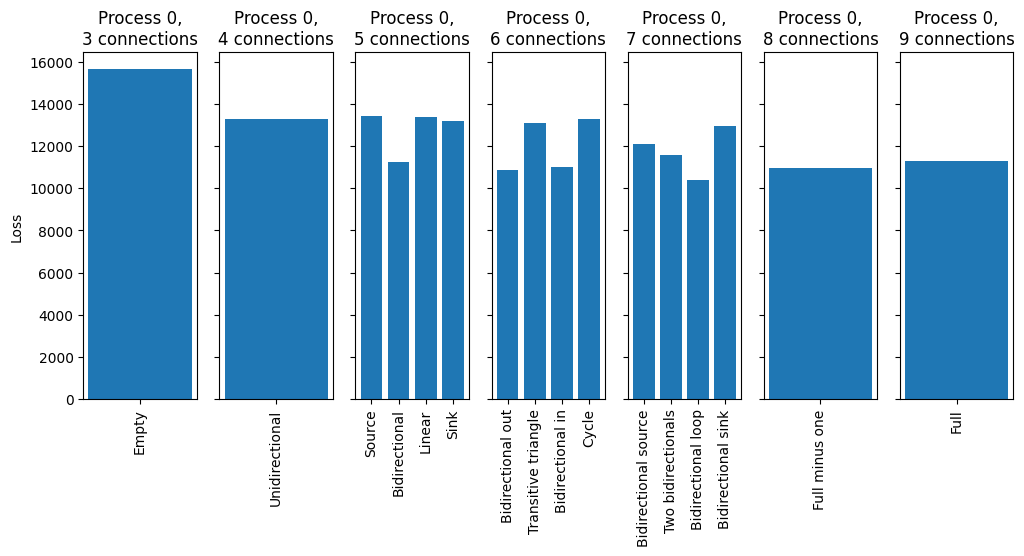

[{3: {'Empty': 15664.942501211237},
  4: {'Unidirectional': 13307.040792553273},
  5: {'Source': 13444.4709522438,
   'Bidirectional': 11260.981290429223,
   'Linear': 13403.590703374619,
   'Sink': 13207.206065091532},
  6: {'Bidirectional out': 10885.391199687347,
   'Transitive triangle': 13118.596322865778,
   'Bidirectional in': 10992.195197243389,
   'Cycle': 13297.043549012096},
  7: {'Bidirectional source': 12105.930633362412,
   'Two bidirectionals': 11581.13931574648,
   'Bidirectional loop': 10392.055628524267,
   'Bidirectional sink': 12939.625905431021},
  8: {'Full minus one': 10956.257448779905},
  9: {'Full': 11293.658641660648}}]

In [61]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))),
           A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))

### Transitive triangle with loops, one negative connection

In [62]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-6), np.full(15, 1e-7), np.full(30, 3e-8), np.full(30, 1e-8))))

Process dynamics: [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
Kalman filter K: [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]
Kalman filter loss: 9220.366430737236


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.1842076   0.          0.        ]
 [ 0.          0.17064258  0.        ]
 [ 0.          0.          0.36950622]]
NN K: [[ 0.21840231  0.18817104 -0.03853775]
 [ 0.29876859  0.70204298 -0.41990858]
 [ 0.48728557 -0.0775058   0.38953264]]
NN W: [[ 8.99374683e-01 -4.12293625e-04  6.80828888e-02]
 [ 3.20967199e-02  7.02126960e-01  4.25694980e-01]
 [-1.58407714e-01 -3.11027620e-01  1.21867718e+00]]
Loss: 16519.93942433455
Testing Empty, Trial 2
NN M: [[-0.11613515  0.          0.        ]
 [ 0.          0.10446002  0.        ]
 [ 0.          0.          0.35611489]]
NN K: [[ 0.22009407  0.29082833  0.23869946]
 [ 0.37924068  0.9344475  -0.14772098]
 [ 0.30079519 -0.23989507  0.41590525]]
NN W: [[ 0.78355628 -0.01568905 -0.201104  ]
 [-0.05827934  0.72750381  0.10633162]
 [ 0.41536282 -0.10900182  1.22285262]]
Loss: 15605.886303479265
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:31<22:54, 91.65s/it]

NN M: [[-0.05642409  0.          0.        ]
 [ 0.          0.16812182  0.        ]
 [ 0.          0.          0.32529984]]
NN K: [[ 0.17044966  0.22480658  0.00685448]
 [ 0.40290921  0.67823181 -0.31100642]
 [ 0.35114047 -0.10361732  0.47033459]]
NN W: [[ 0.87816107  0.00741095  0.03149976]
 [ 0.12546092  0.76175386  0.28920313]
 [-0.0688165  -0.18357342  1.23030381]]
Loss: 14684.764593624132
Testing Unidirectional, Trial 1
NN M: [[-0.11497384  0.          0.        ]
 [ 0.11209783  0.18129485  0.        ]
 [ 0.          0.          0.3321459 ]]
NN K: [[ 0.20013755  0.3041493   0.11384055]
 [ 0.37132759  0.88188523 -0.09617732]
 [ 0.26684482 -0.14193711  0.45533855]]
NN W: [[ 0.79603667 -0.01520612 -0.07715225]
 [-0.09040841  0.7402127   0.06938904]
 [ 0.12622943 -0.14925727  1.28975294]]
Loss: 13460.105573618686
Testing Unidirectional, Trial 2
NN M: [[-0.04896187  0.          0.        ]
 [ 0.14638403  0.18606349  0.        ]
 [ 0.          0.          0.37559675]]
NN K: [[ 0.1832331

 12%|███████████████████                                                                                                                                     | 2/16 [03:03<21:23, 91.66s/it]

NN M: [[-0.17445381  0.          0.        ]
 [ 0.20151568  0.31135099  0.        ]
 [ 0.          0.          0.3572764 ]]
NN K: [[ 0.17629349  0.28099296  0.05880932]
 [ 0.49476568  0.52470958 -0.28127845]
 [ 0.48987941 -0.1186728   0.40248827]]
NN W: [[ 9.06286573e-01  1.20174020e-02 -9.26337013e-03]
 [ 2.45148913e-02  6.87620306e-01  2.82517516e-01]
 [ 4.18757897e-04 -2.90030318e-01  1.25351478e+00]]
Loss: 17360.48509137675
Testing Source, Trial 1
NN M: [[-0.06451203  0.          0.        ]
 [ 0.50611798  0.27626757  0.        ]
 [ 0.39395662  0.          0.27591678]]
NN K: [[ 0.2822869   0.32707329  0.18669724]
 [ 0.24620696  0.46418665 -0.25128408]
 [ 0.39079542 -0.09342906  0.34296144]]
NN W: [[ 0.85584375  0.09960772 -0.10641573]
 [ 0.1275099   0.76855647  0.18816785]
 [ 0.11964236 -0.58775328  1.33450364]]
Loss: 14655.658326912158
Testing Source, Trial 2
NN M: [[0.01167984 0.         0.        ]
 [0.33429829 0.28973979 0.        ]
 [0.41929166 0.         0.22081671]]
NN K: [[

 19%|████████████████████████████▌                                                                                                                           | 3/16 [04:34<19:49, 91.54s/it]

NN M: [[-0.17913971  0.          0.        ]
 [ 0.22573685  0.24471296  0.        ]
 [ 0.15118883  0.          0.28490375]]
NN K: [[ 0.45682249  0.21847179  0.14551464]
 [ 0.41644301  0.7750268  -0.31829739]
 [ 0.2827612  -0.06859357  0.42201718]]
NN W: [[ 0.86157244  0.0138327  -0.1224883 ]
 [ 0.07110854  0.59535088  0.24576281]
 [ 0.20172311 -0.28959316  1.27893249]]
Loss: 13373.360896812897
Testing Bidirectional, Trial 1
NN M: [[-0.11737125  0.03534423  0.        ]
 [ 0.0154984   0.30524819  0.        ]
 [ 0.          0.          0.30663294]]
NN K: [[ 0.25459062  0.33419034  0.10866699]
 [ 0.35617003  0.71342313 -0.17662309]
 [ 0.45191249 -0.10287893  0.38590408]]
NN W: [[ 0.76348207 -0.03444019 -0.08023279]
 [-0.05171605  0.71159642  0.22685651]
 [ 0.41074657 -0.42209867  1.34093872]]
Loss: 16024.827244738257
Testing Bidirectional, Trial 2
NN M: [[-0.13429919  0.04315783  0.        ]
 [ 0.39312943  0.12903864  0.        ]
 [ 0.          0.          0.31045493]]
NN K: [[ 0.28271376 

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [06:06<18:17, 91.45s/it]

NN M: [[-0.27227243  0.13935798  0.        ]
 [ 0.14284924  0.15876903  0.        ]
 [ 0.          0.          0.41855202]]
NN K: [[ 0.19815126  0.32900866 -0.04382645]
 [ 0.39857947  0.68927388 -0.32456431]
 [ 0.50150404 -0.18616866  0.38411757]]
NN W: [[ 0.85207554 -0.09478494  0.08577429]
 [-0.07113962  0.72845565  0.28101835]
 [-0.00232649 -0.23312195  1.1891857 ]]
Loss: 17569.18764993259
Testing Linear, Trial 1
NN M: [[-0.10103086  0.          0.        ]
 [ 0.2707904   0.27963069  0.        ]
 [ 0.          0.15160478  0.32750133]]
NN K: [[ 0.16869062  0.35168735  0.0787294 ]
 [ 0.51728857  0.54453047  0.07857439]
 [ 0.24004399 -0.25742952  0.47771013]]
NN W: [[ 0.87517797 -0.08405157 -0.03221592]
 [ 0.0352678   0.84145949 -0.19689611]
 [-0.18458447 -0.1440413   1.28597623]]
Loss: 15823.835914607684
Testing Linear, Trial 2
NN M: [[-0.1682646   0.          0.        ]
 [ 0.18671196  0.15859433  0.        ]
 [ 0.         -0.3383334   0.25248182]]
NN K: [[ 0.20972606  0.29842709 -0.

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [07:37<16:46, 91.49s/it]

NN M: [[-0.09747237  0.          0.        ]
 [ 0.13244207  0.18979665  0.        ]
 [ 0.         -0.08926323  0.23815556]]
NN K: [[ 0.20577033  0.33708992  0.04579808]
 [ 0.45735466  0.50300677 -0.2217756 ]
 [ 0.41578665 -0.1106848   0.42172768]]
NN W: [[ 8.91625296e-01 -2.37821401e-02 -9.33823430e-04]
 [ 3.00056743e-02  7.70861646e-01  1.54500175e-01]
 [ 1.40642969e-01 -2.15116440e-01  1.43438386e+00]]
Loss: 19118.483407159976
Testing Sink, Trial 1
NN M: [[ 0.00982579  0.          0.        ]
 [ 0.25483752  0.1243857  -0.05254635]
 [ 0.          0.          0.2738894 ]]
NN K: [[ 0.20476223  0.35749266  0.07803741]
 [ 0.33034454  0.71025886 -0.16048284]
 [ 0.39990894 -0.19938027  0.43927573]]
NN W: [[ 0.86452823 -0.03306704 -0.03798959]
 [ 0.04757559  0.71879795  0.10898673]
 [ 0.24279927 -0.2047153   1.37622901]]
Loss: 17420.366396305886
Testing Sink, Trial 2
NN M: [[-0.12845817  0.          0.        ]
 [ 0.0604598   0.28180134  0.05054892]
 [ 0.          0.          0.34839456]]
NN

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [09:09<15:14, 91.47s/it]

NN M: [[-0.07857068  0.          0.        ]
 [ 0.28813218  0.04803788  0.01786531]
 [ 0.          0.          0.31552084]]
NN K: [[ 0.31624692  0.35368643  0.01645822]
 [ 0.44783411  0.81490842 -0.2066784 ]
 [ 0.27649529 -0.18979844  0.4498481 ]]
NN W: [[ 9.23520915e-01 -9.45110023e-02  4.90550336e-04]
 [-8.51533198e-02  6.71818537e-01  7.02218783e-02]
 [ 1.60301765e-01 -9.51641628e-02  1.34844049e+00]]
Loss: 14281.881252775522
Testing Bidirectional out, Trial 1
NN M: [[-0.2746303   0.13600512  0.        ]
 [ 0.02032021  0.13505222  0.        ]
 [ 0.10452594  0.          0.31700931]]
NN K: [[ 0.0708397   0.13730853 -0.03344752]
 [ 0.38306484  0.69075568 -0.2807278 ]
 [ 0.38562107  0.00355408  0.39012156]]
NN W: [[ 0.75727856 -0.0070234   0.10562821]
 [-0.17273273  0.81953055  0.32337345]
 [-0.26029055 -0.44842754  1.36395505]]
Loss: 15366.585315683838
Testing Bidirectional out, Trial 2
NN M: [[-0.27591766  0.07317868  0.        ]
 [-0.03128811  0.17225816  0.        ]
 [-0.18572852  0

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [10:40<13:44, 91.58s/it]

NN M: [[-0.2427737   0.03854452  0.        ]
 [ 0.1813969   0.188947    0.        ]
 [ 0.08428984  0.          0.31811262]]
NN K: [[ 0.20848053  0.25579188  0.18781454]
 [ 0.42876027  0.67849141 -0.21260802]
 [ 0.35343004 -0.14620098  0.44336068]]
NN W: [[ 0.8642982   0.06343998 -0.09562843]
 [ 0.0052193   0.76761206  0.16151697]
 [-0.01204844 -0.18701246  1.30419717]]
Loss: 15103.864861507464
Testing Transitive triangle, Trial 1
NN M: [[-0.12916329  0.          0.        ]
 [-0.03374835  0.14582487  0.        ]
 [-0.11765339 -0.01621065  0.35578712]]
NN K: [[ 0.01482451  0.1765517  -0.13036899]
 [ 0.36680275  0.58707283 -0.22124571]
 [ 0.34646642 -0.1707699   0.45411253]]
NN W: [[ 0.79847331 -0.0340386   0.104256  ]
 [-0.05237398  0.89370141  0.1644357 ]
 [-0.05579122 -0.0901958   1.19082365]]
Loss: 16714.57957550676
Testing Transitive triangle, Trial 2
NN M: [[-0.14773502  0.          0.        ]
 [ 0.25646776  0.18505189  0.        ]
 [-0.07812752 -0.00527348  0.41768104]]
NN K: [[ 

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [12:12<12:12, 91.54s/it]

NN M: [[-0.17530059  0.          0.        ]
 [ 0.27163638  0.00085432  0.        ]
 [ 0.16760758 -0.12915105  0.24828067]]
NN K: [[ 0.28125373  0.29231417  0.22004181]
 [ 0.46198405  0.55629971 -0.20143369]
 [ 0.2454487  -0.23782807  0.47308481]]
NN W: [[ 0.88495861  0.01765208 -0.16172913]
 [ 0.02401427  0.91095229  0.0493987 ]
 [ 0.08005842  0.14532763  1.31871416]]
Loss: 16774.08617078803
Testing Bidirectional in, Trial 1
NN M: [[-0.30184109  0.03935706  0.20179371]
 [ 0.29652512  0.3349232   0.        ]
 [ 0.          0.          0.34763912]]
NN K: [[ 0.24566019  0.36806898  0.10740326]
 [ 0.4033968   0.48449509 -0.2506613 ]
 [ 0.54630835 -0.19786087  0.39897207]]
NN W: [[ 0.67899183  0.04101588 -0.10092882]
 [ 0.04027879  0.77522456  0.26033708]
 [ 0.24452909 -0.26766559  1.24344366]]
Loss: 17837.131064762852
Testing Bidirectional in, Trial 2
NN M: [[-0.25318986  0.06914285  0.11203108]
 [ 0.45372911  0.09325687  0.        ]
 [ 0.          0.          0.3649851 ]]
NN K: [[ 0.2604

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [13:44<10:41, 91.61s/it]

NN M: [[-0.26124437  0.12047549  0.03670024]
 [ 0.29269028  0.29326891  0.        ]
 [ 0.          0.          0.29507911]]
NN K: [[ 0.20782779  0.30181     0.09617253]
 [ 0.41388293  0.68094485 -0.09409438]
 [ 0.19832364 -0.23742455  0.50047566]]
NN W: [[ 0.72807536  0.02720477 -0.01331341]
 [-0.00598516  0.70525513  0.05014921]
 [ 0.00939033  0.07767809  1.30646807]]
Loss: 12430.266051528102
Testing Cycle, Trial 1
NN M: [[-0.27671482  0.          0.10726911]
 [ 0.31154757  0.27893246  0.        ]
 [ 0.         -0.09097928  0.33951893]]
NN K: [[ 0.29718454  0.31336999  0.00430334]
 [ 0.46092068  0.43490361 -0.0852603 ]
 [ 0.24775011 -0.13992068  0.45625071]]
NN W: [[ 0.81282011 -0.02726764 -0.04329329]
 [ 0.07771961  0.87683102  0.01189996]
 [ 0.04278922 -0.0685872   1.25555276]]
Loss: 14027.324226273684
Testing Cycle, Trial 2
NN M: [[-0.21239434  0.         -0.07236326]
 [ 0.04235869  0.09442405  0.        ]
 [ 0.         -0.18824966  0.34376974]]
NN K: [[ 0.25420033  0.27569712 -0.1

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [15:15<09:08, 91.48s/it]

NN M: [[-0.22666121  0.          0.29447311]
 [ 0.35695485  0.28436787  0.        ]
 [ 0.         -0.19999336  0.2293198 ]]
NN K: [[ 0.24132842  0.46248481  0.18275269]
 [-0.12830692  0.40496341 -0.493192  ]
 [ 0.61885479 -0.05066719  0.25027103]]
NN W: [[ 0.6415217   0.13919883 -0.07887341]
 [ 0.33588207  0.64551182  0.34171274]
 [ 0.14277158 -0.48959957  1.15602493]]
Loss: 21952.75484019289
Testing Bidirectional source, Trial 1
NN M: [[-0.27911219 -0.05849779  0.        ]
 [ 0.41303366  0.31508341  0.        ]
 [ 0.15365514 -0.09987252  0.28816805]]
NN K: [[ 0.32582988  0.35463501  0.24787767]
 [ 0.33559236  0.47318909 -0.30249422]
 [ 0.2484096  -0.06172274  0.45856567]]
NN W: [[ 0.8463136   0.0524197  -0.15861215]
 [ 0.0725708   0.85280506  0.2783897 ]
 [-0.04659636 -0.18815568  1.17373724]]
Loss: 13518.854149987834
Testing Bidirectional source, Trial 2
NN M: [[-0.10283388 -0.01555249  0.        ]
 [ 0.47766312  0.18743772  0.        ]
 [ 0.49867967 -0.17167296  0.22838367]]
NN K: [

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [16:46<07:37, 91.42s/it]

NN M: [[ 0.09060388  0.02027761  0.        ]
 [ 0.01377664  0.31253442  0.        ]
 [ 0.49399875 -0.07207696  0.15938856]]
NN K: [[ 0.38391247  0.13027122  0.3482375 ]
 [ 0.24400495  0.56910748 -0.20504667]
 [ 0.1700143  -0.19796291  0.27140402]]
NN W: [[ 0.72487702  0.2124669  -0.24874756]
 [ 0.27532903  0.92503841  0.23372452]
 [ 0.35273582 -0.31430014  1.18786105]]
Loss: 14207.308616121702
Testing Two bidirectionals, Trial 1
NN M: [[-0.23015259  0.02655529  0.05459964]
 [ 0.26682923  0.14263569  0.        ]
 [ 0.12515491  0.          0.29800044]]
NN K: [[ 0.2657512   0.32985721  0.08585859]
 [ 0.22732765  0.84366435 -0.04056632]
 [ 0.07121101 -0.17386821  0.50937925]]
NN W: [[ 0.75176099 -0.01908191 -0.06498748]
 [ 0.00731296  0.77329562 -0.02168212]
 [ 0.00575465 -0.03221806  1.25431593]]
Loss: 12654.742708719237
Testing Two bidirectionals, Trial 2
NN M: [[ 0.06497305  0.09816612 -0.09918207]
 [-0.06891181  0.17188882  0.        ]
 [-0.35550714  0.          0.15954377]]
NN K: [[-0

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [18:18<06:05, 91.45s/it]

NN M: [[-0.27090837  0.13315833 -0.05798005]
 [ 0.17830211  0.24967068  0.        ]
 [-0.17199401  0.          0.25818942]]
NN K: [[-0.17154635  0.26472585 -0.10804115]
 [ 0.41733482  0.5115094  -0.29177095]
 [ 0.58751893 -0.02609069  0.35288423]]
NN W: [[ 0.73658496 -0.12336964  0.12282271]
 [-0.22666826  0.69235664  0.26382123]
 [-0.18136147 -0.48203373  1.2656675 ]]
Loss: 24037.39987024525
Testing Bidirectional loop, Trial 1
NN M: [[-0.14231979  0.02723314  0.        ]
 [ 0.30328581  0.32711866 -0.01093641]
 [-0.13375847  0.          0.33581815]]
NN K: [[ 0.20606825  0.25500797 -0.11555418]
 [ 0.46947006  0.69025253 -0.25735392]
 [ 0.26532485  0.05509393  0.38474512]]
NN W: [[ 0.88761703 -0.09256428  0.10745393]
 [-0.26940321  0.63936179  0.32830223]
 [-0.17240679 -0.29492799  1.27509427]]
Loss: 13021.0151862904
Testing Bidirectional loop, Trial 2
NN M: [[-0.20410196  0.11464299  0.        ]
 [ 0.15533926  0.37359799  0.10419124]
 [ 0.2378793   0.          0.32123559]]
NN K: [[ 0.29

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [19:49<04:34, 91.39s/it]

NN M: [[-0.18624243 -0.05086627  0.        ]
 [ 0.20302125  0.22372584  0.17195102]
 [ 0.26075334  0.          0.27576551]]
NN K: [[ 0.33438857  0.35577088 -0.00470929]
 [ 0.42234789  0.62232672 -0.3371773 ]
 [ 0.41792832 -0.1635226   0.49226594]]
NN W: [[ 0.844079   -0.05488124 -0.00356679]
 [-0.01050699  0.68708795  0.15793853]
 [-0.12295993 -0.17526784  1.29478019]]
Loss: 15830.689968572959
Testing Bidirectional sink, Trial 1
NN M: [[-0.09164411  0.          0.        ]
 [ 0.35122376  0.3742005  -0.03392205]
 [ 0.37969944 -0.05716718  0.30556772]]
NN K: [[ 0.31672983  0.28186954  0.20811437]
 [ 0.48955801  0.51054737 -0.11915618]
 [ 0.16663175 -0.284766    0.36549836]]
NN W: [[ 8.63250199e-01  7.10148411e-02 -1.37104065e-01]
 [ 8.88512294e-02  6.30471207e-01 -3.41362761e-04]
 [ 8.11985338e-02 -3.38588510e-02  1.35471826e+00]]
Loss: 14923.18440315239
Testing Bidirectional sink, Trial 2
NN M: [[-0.21397527  0.          0.        ]
 [ 0.05076899  0.16826457 -0.14085837]
 [ 0.0973595  -

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [21:21<03:03, 91.60s/it]

NN M: [[-0.05288406  0.          0.        ]
 [ 0.38478018  0.10554294  0.0418777 ]
 [ 0.3342423  -0.34226933  0.2330027 ]]
NN K: [[ 0.33863477  0.34423501  0.27469372]
 [ 0.3780326   0.45807606 -0.32618729]
 [ 0.12208797  0.00819016  0.36161366]]
NN W: [[ 0.77719909  0.01651946 -0.21179487]
 [ 0.03289077  0.90950238  0.15472083]
 [ 0.26688734 -0.27591221  1.15948879]]
Loss: 12868.590024483841
Testing Full minus one, Trial 1
NN M: [[-0.07246673 -0.0928564   0.13079695]
 [ 0.06422152  0.18755201  0.        ]
 [ 0.45577827 -0.25136671  0.07149329]]
NN K: [[ 0.44122155  0.09318116  0.30304934]
 [ 0.56510043  0.46195947 -0.44678809]
 [ 0.24602504 -0.07799463  0.26933113]]
NN W: [[ 0.75913553  0.23601868 -0.2452402 ]
 [ 0.25261213  0.81122872  0.30311183]
 [ 0.17245056 -0.20447364  1.1517291 ]]
Loss: 17925.89221533201
Testing Full minus one, Trial 2
NN M: [[-0.2885383   0.12271756  0.09216275]
 [ 0.39470892  0.11554103  0.        ]
 [ 0.19575356 -0.20580639  0.260977  ]]
NN K: [[ 0.33592129

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [22:53<01:31, 91.61s/it]

NN M: [[-0.31614363  0.09144375  0.24310767]
 [ 0.23059242  0.24947184  0.        ]
 [ 0.38252532 -0.14744579  0.21096708]]
NN K: [[ 0.27661656  0.2433115   0.25722906]
 [ 0.31417296  0.45868745 -0.2400499 ]
 [ 0.33180465 -0.10126014  0.34085703]]
NN W: [[ 0.6769657   0.15528424 -0.18558946]
 [ 0.11976318  0.94769532  0.19179145]
 [ 0.17235043 -0.40868215  1.22127111]]
Loss: 13344.578355746897
Testing Full, Trial 1
NN M: [[-0.21921725  0.00341348 -0.09033371]
 [ 0.00955057  0.18818062 -0.22308381]
 [-0.01172023  0.00517228  0.34721795]]
NN K: [[ 0.08129066  0.04389635 -0.12308784]
 [ 0.34985859  0.51578776 -0.15897573]
 [ 0.18558225 -0.11091779  0.32555662]]
NN W: [[ 0.64267024 -0.00661475  0.12939458]
 [-0.06559465  0.60170737  0.09562526]
 [-0.37749455 -0.31980969  1.45585926]]
Loss: 25377.398984566087
Testing Full, Trial 2
NN M: [[-0.28758044  0.10546571 -0.07030026]
 [-0.21232038  0.40186413  0.05428942]
 [ 0.12700955 -0.05053304  0.33070072]]
NN K: [[ 0.16058046  0.04614745 -0.023

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [24:25<00:00, 91.58s/it]

NN M: [[-0.41909217 -0.05596012 -0.00078487]
 [-0.13367063  0.13437287  0.02828834]
 [-0.22489658 -0.14623989  0.26428261]]
NN K: [[-0.12505406 -0.01892634 -0.1725069 ]
 [ 0.2396565   0.54811182 -0.38399152]
 [ 0.28707061 -0.02155325  0.42012424]]
NN W: [[ 0.75583289 -0.05007663  0.03480378]
 [-0.40114161  0.71737448  0.18149283]
 [ 0.0697016  -0.267072    1.19225206]]
Loss: 21091.769664100604


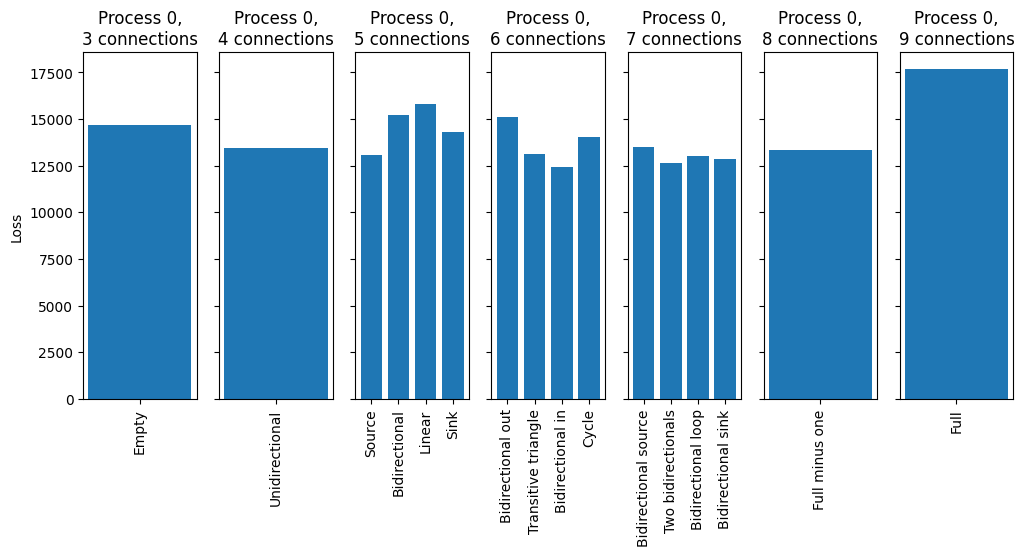

[{3: {'Empty': 14684.764593624132},
  4: {'Unidirectional': 13460.105573618686},
  5: {'Source': 13062.130160535093,
   'Bidirectional': 15189.307044670564,
   'Linear': 15823.835914607684,
   'Sink': 14281.881252775522},
  6: {'Bidirectional out': 15103.864861507464,
   'Transitive triangle': 13145.759309724928,
   'Bidirectional in': 12430.266051528102,
   'Cycle': 14027.324226273684},
  7: {'Bidirectional source': 13518.854149987834,
   'Two bidirectionals': 12654.742708719237,
   'Bidirectional loop': 13021.0151862904,
   'Bidirectional sink': 12868.590024483841},
  8: {'Full minus one': 13344.578355746897},
  9: {'Full': 17680.941948573152}}]

In [63]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 1e-7), np.full(30, 3e-8), np.full(30, 1e-8))),
           A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))

### Transitive triangle with loops, all positive connections

In [64]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, 0.8, 0.8]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 1e-7), np.full(40, 1e-8), np.full(20, 1e-9))))

Process dynamics: [[0.8 0.  0. ]
 [0.8 0.8 0. ]
 [0.8 0.8 0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.47360177 -0.1043154  -0.04853596]
 [ 0.32563549  0.38141492 -0.13263969]
 [ 0.19711075  0.24564672  0.3782864 ]]
Kalman filter K: [[0.27760354 0.06972429 0.06066996]
 [0.06972429 0.35743174 0.16579961]
 [0.06066996 0.16579961 0.52714199]]
Kalman filter loss: 8987.27294865916


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.23086489  0.          0.        ]
 [ 0.         -0.11446286  0.        ]
 [ 0.          0.          0.34238201]]
NN K: [[ 0.3185338   0.12773321 -0.01078091]
 [ 0.12206845  0.12341647  0.31926078]
 [ 0.12180397  0.31021715  0.41645872]]
NN W: [[ 0.69653568 -0.16444719  0.09263981]
 [ 0.2955787   0.73379606 -0.05306715]
 [ 0.15617878  0.12666857  1.30479069]]
Loss: 22746.770928142872
Testing Empty, Trial 2
NN M: [[0.16498613 0.         0.        ]
 [0.         0.01690829 0.        ]
 [0.         0.         0.13089299]]
NN K: [[0.01526738 0.10572725 0.21957036]
 [0.28450604 0.29759465 0.1994225 ]
 [0.22564259 0.19970822 0.44120081]]
NN W: [[ 0.69079612 -0.1687577  -0.22386198]
 [ 0.07937013  0.89688428 -0.12114832]
 [ 0.57467544  0.28911126  1.33927433]]
Loss: 29114.112384381413
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:32<23:03, 92.25s/it]

NN M: [[-0.32096331  0.          0.        ]
 [ 0.         -0.05793936  0.        ]
 [ 0.          0.          0.35359018]]
NN K: [[0.47678665 0.23104197 0.22097773]
 [0.13238609 0.33183137 0.25458536]
 [0.33169385 0.2443419  0.47862489]]
NN W: [[ 0.63926592 -0.08233878 -0.09745988]
 [ 0.16729469  0.87438644 -0.12941319]
 [-0.08465063  0.27000742  1.12396532]]
Loss: 18556.263515539376
Testing Unidirectional, Trial 1
NN M: [[-0.24380575  0.          0.        ]
 [ 0.3182625   0.25589239  0.        ]
 [ 0.          0.          0.2893797 ]]
NN K: [[-0.01427854 -0.00459946  0.02731217]
 [ 0.10029319  0.31368077  0.40933826]
 [ 0.20479368  0.15485617  0.444156  ]]
NN W: [[ 0.56538822 -0.06291526  0.07398469]
 [-0.22035969  0.65785108 -0.33831212]
 [ 0.25749333  0.24482737  1.23204108]]
Loss: 23964.162189775667
Testing Unidirectional, Trial 2
NN M: [[-0.24399099  0.          0.        ]
 [-0.08275457 -0.09102735  0.        ]
 [ 0.          0.          0.34463295]]
NN K: [[ 0.38977867  0.1622

 12%|███████████████████                                                                                                                                     | 2/16 [03:04<21:32, 92.29s/it]

NN M: [[-0.59953331  0.          0.        ]
 [-0.08201255  0.15974477  0.        ]
 [ 0.          0.          0.27163402]]
NN K: [[0.03843298 0.06598606 0.07801309]
 [0.63544399 0.49161164 0.31988616]
 [0.25253389 0.27407049 0.42108843]]
NN W: [[ 0.65607688  0.03602787 -0.0432949 ]
 [-0.16688873  0.8158797  -0.32104298]
 [ 0.15488322  0.36173365  1.20827081]]
Loss: 27751.937782115263
Testing Source, Trial 1
NN M: [[-0.36040814  0.          0.        ]
 [-0.22527028  0.08923148  0.        ]
 [ 0.08397803  0.          0.2967588 ]]
NN K: [[0.08678037 0.05187787 0.11943168]
 [0.32859847 0.46256209 0.21393069]
 [0.36968293 0.1846373  0.39563254]]
NN W: [[ 0.3563687   0.10859668 -0.0669048 ]
 [-0.25556474  0.98815253 -0.14770417]
 [ 0.12270811  0.30869485  1.37822877]]
Loss: 23445.255441355832
Testing Source, Trial 2
NN M: [[-0.19580848  0.          0.        ]
 [ 0.33612985 -0.01246579  0.        ]
 [ 0.03851829  0.          0.2691769 ]]
NN K: [[0.10907534 0.16733594 0.22039806]
 [0.182023

 19%|████████████████████████████▌                                                                                                                           | 3/16 [04:36<19:56, 92.06s/it]

NN M: [[-0.38951915  0.          0.        ]
 [ 0.26750166  0.05611239  0.        ]
 [ 0.0261901   0.          0.44044313]]
NN K: [[0.45031468 0.04248188 0.14588253]
 [0.2044992  0.16470524 0.2605127 ]
 [0.29775942 0.35363751 0.37976298]]
NN W: [[ 0.60664973 -0.10058734 -0.01795723]
 [-0.07806475  0.60698361 -0.01888989]
 [ 0.02977068  0.095054    1.16338624]]
Loss: 22742.430398589073
Testing Bidirectional, Trial 1
NN M: [[-0.51439789 -0.17378076  0.        ]
 [ 0.22289181  0.07930697  0.        ]
 [ 0.          0.          0.38203213]]
NN K: [[ 0.35570754 -0.00143204 -0.00182185]
 [ 0.2122499   0.29928065  0.34483565]
 [ 0.23526311  0.24171747  0.37915979]]
NN W: [[ 0.40147194  0.0298433   0.03911811]
 [-0.15779893  0.84457065 -0.25311642]
 [-0.0227926   0.29493163  1.23687649]]
Loss: 22000.52313837021
Testing Bidirectional, Trial 2
NN M: [[-0.434906    0.08291668  0.        ]
 [ 0.30822544  0.04057112  0.        ]
 [ 0.          0.          0.08939197]]
NN K: [[0.19325481 0.16401273 

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [06:08<18:24, 92.07s/it]

NN M: [[-0.4663974   0.02838205  0.        ]
 [ 0.35787586  0.09146694  0.        ]
 [ 0.          0.          0.16556642]]
NN K: [[0.35179923 0.10651391 0.21518976]
 [0.09363925 0.24090599 0.19306604]
 [0.21167593 0.27185555 0.43945118]]
NN W: [[ 0.52421568 -0.09695723 -0.05661968]
 [-0.10890387  0.94301149 -0.16896557]
 [ 0.15836795  0.47397476  1.34802445]]
Loss: 33139.74373426991
Testing Linear, Trial 1
NN M: [[ 0.13590828  0.          0.        ]
 [-0.04173095 -0.39398128  0.        ]
 [ 0.         -0.17667333  0.04966978]]
NN K: [[ 0.17968657  0.31947852  0.26713924]
 [ 0.50410271  0.46436591 -0.02348227]
 [-0.22671613  0.4911839   0.47835144]]
NN W: [[ 0.53504534  0.08408008 -0.30867564]
 [ 0.33410822  0.82585786  0.05062399]
 [ 0.65414425 -0.19126868  1.27028994]]
Loss: 27805.723432075967
Testing Linear, Trial 2
NN M: [[-0.27584174  0.          0.        ]
 [-0.08225331  0.05793848  0.        ]
 [ 0.          0.21802961  0.24229492]]
NN K: [[0.38710673 0.09435163 0.01486797]
 [

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [07:40<16:53, 92.10s/it]

NN M: [[-0.4644067   0.          0.        ]
 [ 0.15721709  0.0575925   0.        ]
 [ 0.          0.26093461  0.32937507]]
NN K: [[ 0.31068088  0.0859212  -0.09943929]
 [ 0.20184546  0.38243     0.24432975]
 [ 0.10512325  0.27720983  0.3324783 ]]
NN W: [[ 4.89969115e-01  2.94670080e-02  5.77888201e-02]
 [-2.90587826e-04  9.05035015e-01 -1.49299702e-01]
 [-4.26527368e-01  3.07807923e-01  1.21617428e+00]]
Loss: 18806.757790686574
Testing Sink, Trial 1
NN M: [[-0.16404086  0.          0.        ]
 [ 0.39002959 -0.01634662  0.17226197]
 [ 0.          0.          0.41742725]]
NN K: [[0.28729224 0.16268254 0.11470872]
 [0.21928571 0.2811384  0.26665493]
 [0.16954212 0.38535533 0.35654385]]
NN W: [[ 0.73630246 -0.07240024 -0.04316022]
 [ 0.05565027  0.70448989 -0.22355919]
 [ 0.06161148  0.10107669  1.24646395]]
Loss: 24429.223046865543
Testing Sink, Trial 2
NN M: [[-0.58054752  0.          0.        ]
 [-0.0398756   0.09852256  0.05474806]
 [ 0.          0.          0.09055586]]
NN K: [[ 0.

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [09:12<15:20, 92.05s/it]

NN M: [[-0.4488143   0.          0.        ]
 [ 0.26649181  0.09820817 -0.0190588 ]
 [ 0.          0.          0.43515144]]
NN K: [[ 0.37077975 -0.0148056  -0.00193227]
 [ 0.11297704  0.25266441  0.286496  ]
 [ 0.30877841  0.23024901  0.39256921]]
NN W: [[ 0.47775233 -0.14045021  0.08733864]
 [-0.00939108  0.86236127 -0.14862167]
 [-0.22579161  0.22931263  1.15727109]]
Loss: 21073.07199484848
Testing Bidirectional out, Trial 1
NN M: [[-0.01185491  0.01073634  0.        ]
 [ 0.26626249 -0.22290436  0.        ]
 [-0.32839395  0.          0.27842727]]
NN K: [[-0.05995956 -0.05376143 -0.31430838]
 [ 0.64860918  0.64384543  0.21761002]
 [ 0.14545964  0.30415946  0.3387596 ]]
NN W: [[ 0.67818155  0.25963966  0.26995705]
 [-0.10254893  0.63631678  0.01820878]
 [-0.28819994  0.24450318  1.20779192]]
Loss: 21642.008718336445
Testing Bidirectional out, Trial 2
NN M: [[-0.04650289  0.12824399  0.        ]
 [ 0.01457132 -0.03007291  0.        ]
 [ 0.28743592  0.          0.29272334]]
NN K: [[0.207

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [10:44<13:46, 91.87s/it]

NN M: [[ 0.03060182  0.19523878  0.        ]
 [ 0.061121   -0.16270347  0.        ]
 [ 0.36610186  0.          0.32185095]]
NN K: [[0.25476598 0.17473103 0.37778144]
 [0.23464863 0.32569829 0.09515919]
 [0.22263609 0.29615821 0.39666588]]
NN W: [[ 0.76051262 -0.15533314 -0.31974279]
 [ 0.15358571  0.59381571  0.01493708]
 [ 0.08116932 -0.16209984  1.05588123]]
Loss: 18652.55085217958
Testing Transitive triangle, Trial 1
NN M: [[ 0.06182909  0.          0.        ]
 [-0.06694758 -0.05269086  0.        ]
 [ 0.31350735  0.23040305  0.14678928]]
NN K: [[0.00593829 0.07989247 0.39398636]
 [0.18726091 0.43667794 0.40004448]
 [0.13467683 0.36446072 0.25224052]]
NN W: [[ 0.55101118 -0.24118306 -0.16761458]
 [-0.05459752  0.84439141 -0.22686308]
 [ 0.38733882  0.17266108  1.12672779]]
Loss: 23619.78141983023
Testing Transitive triangle, Trial 2
NN M: [[ 0.04768904  0.          0.        ]
 [ 0.23691877  0.22363347  0.        ]
 [ 0.44299742  0.39785202 -0.09237352]]
NN K: [[ 0.06771407  0.18668

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [12:15<12:13, 91.72s/it]

NN M: [[ 0.07579562  0.          0.        ]
 [ 0.1658657  -0.55218265  0.        ]
 [ 0.56748406 -0.20156313  0.20914604]]
NN K: [[0.30062023 0.13743373 0.38432091]
 [0.55325237 0.217247   0.19397747]
 [0.02816805 0.36809848 0.35264963]]
NN W: [[ 0.58416327 -0.14321394 -0.25232005]
 [ 0.24242995  0.64202817 -0.072013  ]
 [ 0.32922934 -0.01049884  1.04620277]]
Loss: 21751.725703467127
Testing Bidirectional in, Trial 1
NN M: [[-0.59262705  0.17716306 -0.05650841]
 [-0.20614384 -0.03823498  0.        ]
 [ 0.          0.          0.36963389]]
NN K: [[ 0.62958812  0.21059937 -0.19286233]
 [ 0.63011426  0.61314237  0.13202721]
 [ 0.22776104  0.37318523  0.48109231]]
NN W: [[ 0.60498436  0.00686057  0.08311299]
 [-0.16932713  0.59833843  0.00741765]
 [-0.25465647 -0.23480365  1.16677242]]
Loss: 16585.39073376289
Testing Bidirectional in, Trial 2
NN M: [[-0.49564521  0.08769612  0.09933749]
 [ 0.28017196 -0.04449221  0.        ]
 [ 0.          0.          0.25999052]]
NN K: [[0.71359447 0.289

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [13:47<10:43, 91.95s/it]

NN M: [[-0.34799406  0.05733399 -0.10151739]
 [-0.23442035 -0.02483276  0.        ]
 [ 0.          0.          0.25662579]]
NN K: [[ 0.39301816 -0.01010092 -0.16568506]
 [ 0.24229227  0.20434738  0.24438249]
 [ 0.24449124  0.31979515  0.41746414]]
NN W: [[ 0.36274432  0.21681074  0.02798477]
 [ 0.06490089  0.6495231  -0.00588188]
 [-0.13471951  0.14289177  1.41562884]]
Loss: 31262.57386128815
Testing Cycle, Trial 1
NN M: [[-0.67018558  0.         -0.0495339 ]
 [ 0.11355741  0.01919365  0.        ]
 [ 0.         -0.00506348  0.29915203]]
NN K: [[0.35706552 0.24445561 0.03069913]
 [0.5501747  0.29901339 0.16842693]
 [0.2403882  0.36207022 0.40766617]]
NN W: [[ 0.11370538  0.15788063 -0.02336476]
 [-0.09590993  0.76539539  0.01010164]
 [ 0.06817657  0.03025677  1.42338311]]
Loss: 24406.486974418407
Testing Cycle, Trial 2
NN M: [[ 0.0816104   0.         -0.01742787]
 [ 0.06871086 -0.23180349  0.        ]
 [ 0.         -0.01270551  0.30880352]]
NN K: [[-0.02844667  0.15421818  0.11773599]
 

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [15:19<09:11, 91.83s/it]

NN M: [[-0.27146449  0.          0.05534723]
 [-0.0023076   0.02429702  0.        ]
 [ 0.          0.2074213   0.24577755]]
NN K: [[0.21193704 0.32317865 0.13197235]
 [0.19959922 0.33387078 0.1611173 ]
 [0.22797677 0.27276614 0.36652495]]
NN W: [[ 0.49722892 -0.03939851 -0.09046028]
 [ 0.09501208  1.03336824 -0.09785457]
 [ 0.2739638   0.27508171  1.3853958 ]]
Loss: 27504.270959438487
Testing Bidirectional source, Trial 1
NN M: [[ 0.29875801 -0.31823948  0.        ]
 [ 0.03248339 -0.39134552  0.        ]
 [-0.49078424 -0.02253829  0.01485854]]
NN K: [[-0.11452021 -0.0721327  -0.29146179]
 [ 0.10467993  0.39670127  0.33264835]
 [ 0.40482886  0.49299537  0.31507181]]
NN W: [[ 0.49393673  0.01967987  0.42496669]
 [-0.01723593  0.66899674 -0.01835518]
 [-0.33362022  0.10439533  1.10335914]]
Loss: 24290.74613367927
Testing Bidirectional source, Trial 2
NN M: [[-0.06201923  0.08173947  0.        ]
 [ 0.09414071  0.24278483  0.        ]
 [ 0.24370832  0.35776169  0.1407148 ]]
NN K: [[ 0.37167

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [16:51<07:38, 91.75s/it]

NN M: [[-0.53286953  0.03304384  0.        ]
 [-0.24081439  0.20997659  0.        ]
 [ 0.0358481   0.38691487  0.22085232]]
NN K: [[ 0.1627671  -0.00405529 -0.17860365]
 [ 0.1466683   0.3863957   0.23800711]
 [ 0.17386433  0.33342323  0.30938876]]
NN W: [[ 0.70943594  0.15086204  0.04957188]
 [-0.30682061  0.84210785 -0.28357576]
 [-0.09307552  0.33920737  1.19491721]]
Loss: 24259.749458247086
Testing Two bidirectionals, Trial 1
NN M: [[-0.08060168  0.07700292  0.13672136]
 [ 0.12442373  0.04051555  0.        ]
 [ 0.0524659   0.          0.24038799]]
NN K: [[ 0.05172986 -0.01648564  0.07761025]
 [ 0.17591625  0.19101469  0.31140584]
 [ 0.31698535  0.33556306  0.38772001]]
NN W: [[ 0.40256668 -0.11676711 -0.01537106]
 [-0.52855945  0.72621787  0.00528464]
 [ 0.11870294  0.19042751  1.4447244 ]]
Loss: 30513.16767084219
Testing Two bidirectionals, Trial 2
NN M: [[-0.33699042 -0.05383715  0.05185715]
 [-0.12184859  0.05698234  0.        ]
 [ 0.10143604  0.          0.1792735 ]]
NN K: [[-0.

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [18:23<06:08, 92.08s/it]

NN M: [[-0.19135801  0.06421394  0.27416384]
 [-0.07429453  0.15115971  0.        ]
 [ 0.37981525  0.          0.27467799]]
NN K: [[-0.16858145 -0.04671378  0.34416305]
 [ 0.18587923  0.32408847  0.25221065]
 [ 0.27569431  0.39152542  0.3005542 ]]
NN W: [[ 0.51856841 -0.26964339 -0.17472345]
 [-0.00258664  0.93963158 -0.15866873]
 [ 0.17716284  0.23924988  1.06786279]]
Loss: 24631.582886608267
Testing Bidirectional loop, Trial 1
NN M: [[ 0.050284   -0.0651645   0.        ]
 [ 0.06890239 -0.21704257  0.09081444]
 [ 0.31367376  0.          0.23261384]]
NN K: [[0.31683133 0.13716802 0.2037388 ]
 [0.24927268 0.23806131 0.23445406]
 [0.34120896 0.28301249 0.37675957]]
NN W: [[ 0.58111426 -0.01146653 -0.14990622]
 [ 0.11866102  1.01487053 -0.19699316]
 [ 0.37624929  0.21081784  1.25332273]]
Loss: 30413.515237158943
Testing Bidirectional loop, Trial 2
NN M: [[-0.53362249  0.1184597   0.        ]
 [ 0.10321812  0.04984473  0.10232478]
 [-0.10515574  0.          0.25523003]]
NN K: [[0.48633655 

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [19:55<04:35, 91.92s/it]

NN M: [[-0.41877671 -0.03715269  0.        ]
 [-0.02661954 -0.05540872 -0.1251448 ]
 [-0.12126429  0.          0.35440155]]
NN K: [[0.27642425 0.15073979 0.08442518]
 [0.30357544 0.34146859 0.06216679]
 [0.21948448 0.38191617 0.45801353]]
NN W: [[ 0.39512921  0.00449092 -0.01057445]
 [ 0.20002414  0.7332478   0.19098068]
 [-0.18912229 -0.10533668  1.23908408]]
Loss: 17906.819075932406
Testing Bidirectional sink, Trial 1
NN M: [[-0.54679239  0.          0.        ]
 [ 0.0851535  -0.06244868 -0.0657369 ]
 [-0.1653264   0.08958018  0.30623145]]
NN K: [[ 0.16810822  0.10098356 -0.10588479]
 [ 0.68523198  0.4926625   0.11467822]
 [ 0.12168019  0.33390205  0.43715808]]
NN W: [[ 0.40586136  0.43469942 -0.01479696]
 [ 0.02199016  0.54645807  0.12685389]
 [ 0.02679411 -0.11834064  1.33158723]]
Loss: 17436.05682307616
Testing Bidirectional sink, Trial 2
NN M: [[-0.3680469   0.          0.        ]
 [ 0.22087674 -0.03992835  0.21120245]
 [-0.13951317 -0.01326787  0.32814189]]
NN K: [[ 0.40538235 

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [21:26<03:03, 91.75s/it]

NN M: [[0.05338907 0.         0.        ]
 [0.0364438  0.03443237 0.21150741]
 [0.18133287 0.04533023 0.07561942]]
NN K: [[0.21509578 0.22280145 0.12216537]
 [0.27061966 0.31002566 0.10004291]
 [0.17425989 0.3799401  0.38506248]]
NN W: [[ 0.67661541 -0.18873171 -0.0630578 ]
 [-0.02751281  0.91427108 -0.13209951]
 [ 0.30960762  0.28803886  1.52269988]]
Loss: 36990.421716903125
Testing Full minus one, Trial 1
NN M: [[-0.43793551  0.02959555  0.14815502]
 [-0.20959734  0.30246803  0.        ]
 [-0.08376616  0.38881037  0.12909459]]
NN K: [[ 0.20367625 -0.11699205 -0.18307142]
 [ 0.3295304   0.419403    0.32481495]
 [ 0.27371404  0.31132724  0.28123757]]
NN W: [[ 0.44585322  0.00409566  0.06616113]
 [ 0.14021451  0.68927269 -0.31964944]
 [-0.09508981  0.35033695  1.1304424 ]]
Loss: 31261.42531496113
Testing Full minus one, Trial 2
NN M: [[-0.51765912  0.12210754 -0.07921085]
 [-0.08793861  0.32937528  0.        ]
 [ 0.16858401  0.34967987  0.08936813]]
NN K: [[0.09481837 0.18991344 0.10512

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [22:59<01:31, 91.97s/it]

NN M: [[-0.17459174 -0.15535947  0.16539232]
 [ 0.08596784 -0.43465763  0.        ]
 [-0.06906905 -0.14616909  0.41113885]]
NN K: [[ 0.1766754  -0.1524846  -0.20864873]
 [ 0.21918599  0.07077859  0.02798189]
 [ 0.30497084  0.41078249  0.36460741]]
NN W: [[ 0.84874416 -0.26542856  0.14391414]
 [-0.21640961  1.25879129  0.18528108]
 [-0.27079488 -0.20479807  1.2568624 ]]
Loss: 30508.872175630502
Testing Full, Trial 1
NN M: [[-0.36616074 -0.16313599 -0.07338801]
 [ 0.21248343  0.1612161   0.014131  ]
 [-0.03015281  0.14390744  0.32679572]]
NN K: [[ 0.12360818 -0.06832747  0.10425565]
 [ 0.31882214  0.31920721  0.23443701]
 [ 0.06097515  0.3419151   0.36349944]]
NN W: [[ 0.48899601  0.05508524  0.02054109]
 [ 0.0496602   0.85098279 -0.16458025]
 [ 0.05908275  0.10936398  1.31844559]]
Loss: 20125.750930463793
Testing Full, Trial 2
NN M: [[-0.14207248 -0.38661455 -0.0668104 ]
 [-0.01243372 -0.3037046   0.088991  ]
 [-0.09762962 -0.17099274  0.28408417]]
NN K: [[ 0.20844048  0.15681359 -0.122

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [24:30<00:00, 91.93s/it]

NN M: [[-0.38933327  0.26963576 -0.09721134]
 [ 0.02098509 -0.41585629  0.03421727]
 [-0.17574614 -0.03127996  0.12206061]]
NN K: [[ 0.19005678 -0.17715047 -0.22683988]
 [ 0.26801128  0.3248212  -0.00078907]
 [ 0.41297426  0.44795766  0.469032  ]]
NN W: [[ 0.58919889  0.06739531  0.22308914]
 [-0.29214474  0.65778891  0.12771995]
 [-0.20914813 -0.25004098  1.39694483]]
Loss: 30721.16989219051


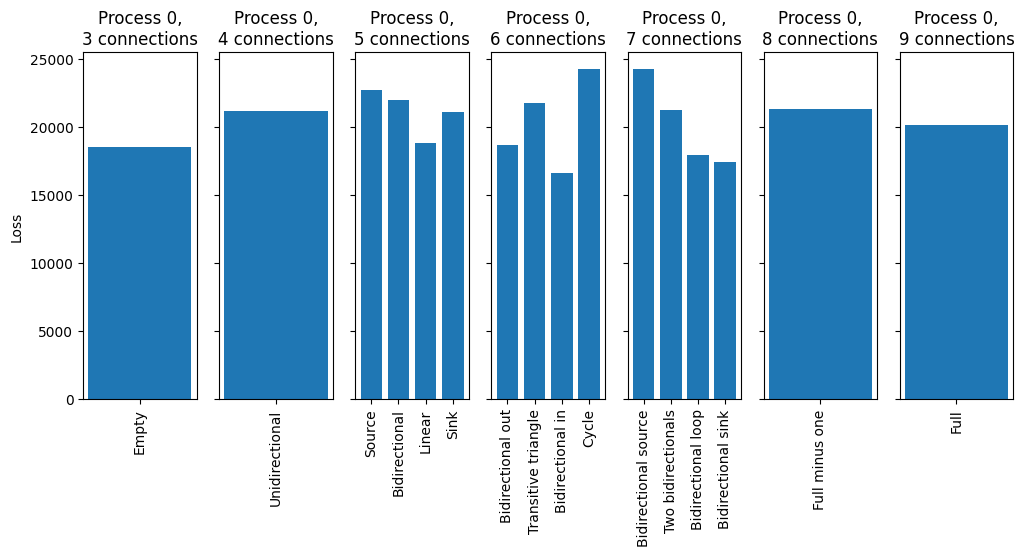

[{3: {'Empty': 18556.263515539376},
  4: {'Unidirectional': 21183.836974509184},
  5: {'Source': 22742.430398589073,
   'Bidirectional': 22000.52313837021,
   'Linear': 18806.757790686574,
   'Sink': 21073.07199484848},
  6: {'Bidirectional out': 18652.55085217958,
   'Transitive triangle': 21751.725703467127,
   'Bidirectional in': 16585.39073376289,
   'Cycle': 24267.7363555962},
  7: {'Bidirectional source': 24259.749458247086,
   'Two bidirectionals': 21279.28882766292,
   'Bidirectional loop': 17906.819075932406,
   'Bidirectional sink': 17436.05682307616},
  8: {'Full minus one': 21327.39773189897},
  9: {'Full': 20125.750930463793}}]

In [65]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 1e-7), np.full(40, 1e-8), np.full(20, 1e-9))),
           A=np.array([[0.8, 0, 0], [0.8, 0.8, 0], [0.8, 0.8, 0.8]]))

### Transitive triangle without loops, all positive connections

In [66]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0],[0.95, 0.0, 0], [0.95, 0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[0.   0.   0.  ]
 [0.95 0.   0.  ]
 [0.95 0.95 0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889 -0.07174766  0.        ]
 [ 0.49686747  0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8369.646046670372


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.01062702 0.         0.        ]
 [0.         0.18042592 0.        ]
 [0.         0.         0.31139479]]
NN K: [[ 0.19795512 -0.02237494 -0.04934573]
 [ 0.02024189  0.5193098   0.44135198]
 [ 0.03528996  0.69862621  1.53593621]]
NN W: [[ 1.00246955  0.01159132  0.02330071]
 [ 0.01228839  0.89648413 -0.20474336]
 [-0.00739182 -0.22158529  0.31810252]]
Loss: 9116.589168636401
Testing Empty, Trial 2
NN M: [[-0.01448104  0.          0.        ]
 [ 0.          0.19584722  0.        ]
 [ 0.          0.          0.31286971]]
NN K: [[ 0.19801711 -0.00853623 -0.01616738]
 [ 0.03317748  0.53570819  0.4708566 ]
 [ 0.04086249  0.66156143  1.45918421]]
NN W: [[ 1.0124088   0.00360483  0.00869115]
 [-0.01805877  0.88060223 -0.23195358]
 [-0.02200186 -0.20145391  0.33265836]]
Loss: 9680.888962140603
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:11<17:45, 71.05s/it]

NN M: [[-0.00638428  0.          0.        ]
 [ 0.          0.18647587  0.        ]
 [ 0.          0.          0.30525041]]
NN K: [[1.96845278e-01 1.01177619e-03 6.32628249e-03]
 [2.78374138e-02 5.30750781e-01 4.60197150e-01]
 [3.41852881e-02 6.70548377e-01 1.48907448e+00]]
NN W: [[ 1.00634474e+00 -6.10268799e-04 -2.47925376e-03]
 [-1.26878637e-02  8.85087276e-01 -2.21974388e-01]
 [ 3.95331671e-03 -2.22645288e-01  3.37565229e-01]]
Loss: 9727.086948716364
Testing Unidirectional, Trial 1
NN M: [[-0.03768387  0.          0.        ]
 [ 0.39189781  0.03075625  0.        ]
 [ 0.          0.          0.33718059]]
NN K: [[ 0.2091104  -0.00830423  0.03816823]
 [ 0.00939236  0.36338614  0.17589112]
 [ 0.04074548  0.66129784  1.51544069]]
NN W: [[ 0.99534501  0.02291145 -0.01853493]
 [-0.01411186  0.97383782 -0.065399  ]
 [-0.00667444 -0.12105394  0.26174329]]
Loss: 9356.216645009752
Testing Unidirectional, Trial 2
NN M: [[ 0.04476358  0.         -0.        ]
 [ 0.33726696  0.04960155  0.       

 12%|███████████████████                                                                                                                                     | 2/16 [02:22<16:37, 71.23s/it]

NN M: [[-0.04155435  0.          0.        ]
 [ 0.39009199  0.02269837  0.        ]
 [ 0.          0.          0.32935553]]
NN K: [[0.2118574  0.01216062 0.06341558]
 [0.00933864 0.38310955 0.20124413]
 [0.03771442 0.70290437 1.55815524]]
NN W: [[ 1.00019482 -0.00946084 -0.02576018]
 [-0.00815771  0.9501751  -0.07619943]
 [-0.01138192 -0.13651205  0.26133282]]
Loss: 9078.480224838942
Testing Source, Trial 1
NN M: [[0.01414147 0.         0.        ]
 [0.47025949 0.09681197 0.        ]
 [0.77296828 0.         0.29160992]]
NN K: [[ 0.22061481 -0.03876437 -0.1733908 ]
 [-0.01403616  0.39792202  0.25150899]
 [-0.0161814   0.29752675  0.86075729]]
NN W: [[ 0.95489689  0.03101483  0.13754793]
 [ 0.05050753  0.87116772 -0.13227145]
 [ 0.04271585 -0.14777644  0.59126066]]
Loss: 9289.960093700964
Testing Source, Trial 2
NN M: [[-0.00471427  0.          0.        ]
 [ 0.50390806  0.07109818  0.        ]
 [ 0.76834478  0.          0.25491206]]
NN K: [[ 0.22166403  0.03755795 -0.08016403]
 [-0.0011

 19%|████████████████████████████▌                                                                                                                           | 3/16 [03:33<15:25, 71.17s/it]

NN M: [[0.01619904 0.         0.        ]
 [0.43527843 0.08560634 0.        ]
 [0.7788326  0.         0.27260625]]
NN K: [[ 0.21564487  0.01100524 -0.1194424 ]
 [ 0.00313695  0.39340402  0.23958415]
 [-0.00446573  0.28251271  0.80289805]]
NN W: [[ 0.96693217 -0.03284772  0.10133473]
 [ 0.00235531  0.91348495 -0.15086169]
 [-0.00447991 -0.14897759  0.6203966 ]]
Loss: 9524.003957411609
Testing Bidirectional, Trial 1
NN M: [[-0.04449472 -0.00944474  0.        ]
 [ 0.4590616  -0.02684397  0.        ]
 [ 0.          0.          0.34600269]]
NN K: [[ 0.20759318 -0.0233379  -0.012668  ]
 [-0.00699045  0.30901653  0.07967995]
 [ 0.06603401  0.66050656  1.49478822]]
NN W: [[ 0.98823544  0.02396091  0.00870787]
 [ 0.03325324  0.9870499  -0.00395799]
 [-0.0467296  -0.11359794  0.2518646 ]]
Loss: 9335.862038937592
Testing Bidirectional, Trial 2
NN M: [[-0.00683361  0.01790775  0.        ]
 [ 0.35589073 -0.00715014  0.        ]
 [ 0.          0.          0.33221659]]
NN K: [[ 0.21208184 -0.02682612

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [04:44<14:13, 71.12s/it]

NN M: [[-0.0216103  -0.03576179  0.        ]
 [ 0.32337533 -0.02371354  0.        ]
 [ 0.          0.          0.3382364 ]]
NN K: [[ 0.21263511 -0.0433494  -0.05557261]
 [ 0.01201928  0.29631512  0.01016493]
 [ 0.05395051  0.7309098   1.56677302]]
NN W: [[ 0.97398116  0.02171684  0.03181438]
 [-0.05807423  0.96100238  0.03238835]
 [-0.02153916 -0.21378365  0.24121803]]
Loss: 9338.541006318388
Testing Linear, Trial 1
NN M: [[-0.00275146  0.          0.        ]
 [ 0.40866776  0.04607171  0.        ]
 [ 0.          0.67845205  0.13997056]]
NN K: [[ 0.21140941 -0.05948935 -0.08731969]
 [ 0.02553704  0.3359504   0.10987618]
 [-0.00367479  0.44157043  1.12931099]]
NN W: [[ 0.98348653  0.05113149  0.0634559 ]
 [-0.01400589  0.97843994 -0.0303905 ]
 [ 0.06163709 -0.11162192  0.40192669]]
Loss: 8900.03044054436
Testing Linear, Trial 2
NN M: [[-0.04027872  0.          0.        ]
 [ 0.46084454 -0.09759764  0.        ]
 [ 0.          0.79779816  0.16032618]]
NN K: [[ 0.2126711  -0.01563648 -0.03

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [05:55<13:01, 71.05s/it]

NN M: [[-0.02239843  0.          0.        ]
 [ 0.44018632  0.02054713  0.        ]
 [ 0.          0.8038857   0.09442917]]
NN K: [[ 0.21376803 -0.03768804 -0.05295695]
 [ 0.03541401  0.33348128  0.10681394]
 [ 0.01309435  0.40049321  1.03548614]]
NN W: [[ 0.98064923  0.04233626  0.04280181]
 [-0.03037073  0.97920586 -0.03235941]
 [ 0.04078521 -0.12854661  0.44813936]]
Loss: 8768.838462312828
Testing Sink, Trial 1
NN M: [[ 0.00681337  0.          0.        ]
 [ 0.343723   -0.05959983  0.05471676]
 [ 0.          0.          0.33220604]]
NN K: [[ 0.2054746  -0.07580641 -0.14421364]
 [ 0.00738907  0.38379048  0.18517497]
 [ 0.06869756  0.72641937  1.55077632]]
NN W: [[ 0.97573223  0.04080746  0.06789645]
 [-0.00575504  0.95647493 -0.07373174]
 [-0.03552605 -0.22194809  0.26761107]]
Loss: 9373.625802886501
Testing Sink, Trial 2
NN M: [[-0.0301819   0.          0.        ]
 [ 0.3756625  -0.00576476  0.01934656]
 [ 0.          0.          0.33199019]]
NN K: [[ 2.11495477e-01 -2.68654868e-02 

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [07:06<11:50, 71.09s/it]

NN M: [[ 0.0313168   0.          0.        ]
 [ 0.25958554 -0.00736751  0.00843733]
 [ 0.          0.          0.31587641]]
NN K: [[ 0.20761348 -0.07757881 -0.10030058]
 [ 0.01124307  0.36968664  0.09481231]
 [ 0.03884096  0.78147814  1.57925104]]
NN W: [[ 0.99348712  0.0697716   0.05008809]
 [-0.01075827  0.8949454  -0.01116454]
 [ 0.03526661 -0.24073296  0.26054198]]
Loss: 9292.52219043152
Testing Bidirectional out, Trial 1
NN M: [[ 0.0157453  -0.05581772  0.        ]
 [ 0.41347297  0.07477556  0.        ]
 [ 0.82119421  0.          0.28151927]]
NN K: [[ 0.2204768  -0.00724198 -0.07662185]
 [ 0.00838482  0.38541914  0.22623058]
 [-0.00463183  0.38866721  0.98314361]]
NN W: [[ 0.97165133  0.01125862  0.06043581]
 [-0.01549905  0.9281881  -0.121009  ]
 [ 0.02316376 -0.18770503  0.49967257]]
Loss: 9324.966405883966
Testing Bidirectional out, Trial 2
NN M: [[ 0.01592533 -0.02814474  0.        ]
 [ 0.42880242  0.08867436  0.        ]
 [ 0.79187061  0.          0.2394272 ]]
NN K: [[ 0.2215

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [08:17<10:40, 71.14s/it]

NN M: [[ 0.01370478 -0.06153524  0.        ]
 [ 0.44665304  0.12206648  0.        ]
 [ 0.74940984  0.          0.28783621]]
NN K: [[ 0.22061167 -0.00336617 -0.08702746]
 [ 0.00231231  0.43424607  0.29774808]
 [-0.01286439  0.26512972  0.76919385]]
NN W: [[ 0.94423244  0.02097825  0.07688515]
 [ 0.00891559  0.86064922 -0.20399329]
 [ 0.02115475 -0.12082225  0.6437326 ]]
Loss: 9624.320001212804
Testing Transitive triangle, Trial 1
NN M: [[-0.0253359   0.          0.        ]
 [ 0.47314472  0.06137734  0.        ]
 [ 0.59101576  0.51281369  0.06465548]]
NN K: [[ 0.22041439 -0.0303122  -0.07992868]
 [ 0.00429225  0.37582551  0.18495106]
 [-0.00101446  0.22868477  0.68110709]]
NN W: [[ 0.9790869   0.01856767  0.0747577 ]
 [-0.00688026  0.9256176  -0.11748054]
 [ 0.00236046 -0.15314841  0.70159072]]
Loss: 8591.373917774597
Testing Transitive triangle, Trial 2
NN M: [[-0.02245526  0.          0.        ]
 [ 0.50523153  0.02482421  0.        ]
 [ 0.56970424  0.4734367   0.07255145]]
NN K: [[ 0

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [09:28<09:28, 71.09s/it]

NN M: [[-0.0251743   0.          0.        ]
 [ 0.43768315  0.01741801  0.        ]
 [ 0.70510158  0.30952252  0.15718114]]
NN K: [[ 0.21536182 -0.00332357 -0.08289684]
 [-0.00645785  0.3592591   0.11341281]
 [ 0.00247217  0.19283609  0.55497324]]
NN W: [[ 0.94737691 -0.01144833  0.08478159]
 [ 0.02316105  0.93185359 -0.02934151]
 [-0.02108665 -0.15899764  0.81599981]]
Loss: 8953.66996563664
Testing Bidirectional in, Trial 1
NN M: [[-0.01285204 -0.00940814  0.00115152]
 [ 0.28632245 -0.00428131  0.        ]
 [ 0.          0.          0.32725687]]
NN K: [[ 2.14442998e-01 -3.57155947e-02 -1.84063654e-02]
 [ 9.57451391e-04  3.40327884e-01  8.67015049e-02]
 [ 3.36740676e-02  7.57789192e-01  1.58166927e+00]]
NN W: [[ 0.99057334  0.04462643  0.01204454]
 [ 0.00731828  0.95420306 -0.0091771 ]
 [ 0.00584456 -0.23626761  0.25580518]]
Loss: 9647.993501358165
Testing Bidirectional in, Trial 2
NN M: [[-0.05492272  0.09285342 -0.02308992]
 [ 0.2834123   0.02940232  0.        ]
 [ 0.          0.    

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [10:40<08:17, 71.14s/it]

NN M: [[-0.07001684  0.03162709  0.01033567]
 [ 0.35703482  0.01633933  0.        ]
 [ 0.          0.          0.32424559]]
NN K: [[0.20703166 0.005526   0.05130152]
 [0.01325388 0.38972416 0.21179365]
 [0.03926523 0.70289378 1.53682255]]
NN W: [[ 0.99800213  0.02389734 -0.03449988]
 [-0.02466837  0.93528034 -0.08174865]
 [-0.01498111 -0.20038517  0.27913774]]
Loss: 9122.340566568186
Testing Cycle, Trial 1
NN M: [[-0.01073313  0.         -0.00185874]
 [ 0.43907585  0.05065191  0.        ]
 [ 0.          0.73826377  0.10325694]]
NN K: [[ 0.2117841  -0.03076998 -0.0222845 ]
 [ 0.03265851  0.38702831  0.19114278]
 [ 0.01993234  0.508584    1.20964914]]
NN W: [[ 0.99300674  0.01773487  0.01896623]
 [-0.01772338  0.93148406 -0.08908999]
 [ 0.01253847 -0.16750253  0.37674526]]
Loss: 8841.609632612035
Testing Cycle, Trial 2
NN M: [[-0.04271934  0.         -0.00719401]
 [ 0.4458502  -0.00825707  0.        ]
 [ 0.          0.77952903  0.12347025]]
NN K: [[ 0.2109633  -0.0236643  -0.02669279]
 [

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [11:51<07:07, 71.19s/it]

NN M: [[ 0.00149434  0.         -0.01057241]
 [ 0.39207838  0.06120061  0.        ]
 [ 0.          0.68990697  0.12364396]]
NN K: [[ 0.21021807 -0.05773469 -0.0784007 ]
 [ 0.02473338  0.37434589  0.16421023]
 [ 0.01359063  0.51708583  1.21069093]]
NN W: [[ 0.98534519  0.03342996  0.05992379]
 [-0.006998    0.93688346 -0.06640906]
 [ 0.04117283 -0.16505598  0.37621187]]
Loss: 9021.712312740248
Testing Bidirectional source, Trial 1
NN M: [[-0.03815161 -0.09376515  0.        ]
 [ 0.41402472  0.07948124  0.        ]
 [ 0.51470026  0.47671323  0.12921093]]
NN K: [[ 0.22256427 -0.0561589  -0.12019723]
 [ 0.00628574  0.35626474  0.12482434]
 [-0.00634953  0.16151061  0.55739256]]
NN W: [[ 0.94570857  0.04864553  0.16726477]
 [-0.03142779  0.91467409 -0.04975945]
 [ 0.02037501 -0.09403932  0.81428336]]
Loss: 8751.769964421343
Testing Bidirectional source, Trial 2
NN M: [[ 0.01224294 -0.06444423  0.        ]
 [ 0.45768661  0.01905533  0.        ]
 [ 0.61434083  0.51945542  0.10683376]]
NN K: [[

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [13:02<05:55, 71.09s/it]

NN M: [[-0.03414343 -0.04779433  0.        ]
 [ 0.48027614  0.05407204  0.        ]
 [ 0.56780843  0.56046537  0.09725635]]
NN K: [[ 0.22287258 -0.02822984 -0.06247688]
 [ 0.00853738  0.37231964  0.16535683]
 [ 0.00841378  0.29030057  0.83517423]]
NN W: [[ 0.98247486  0.03033412  0.06246034]
 [ 0.01480916  0.91390442 -0.07857412]
 [-0.00728698 -0.13403269  0.56403752]]
Loss: 8750.483445865637
Testing Two bidirectionals, Trial 1
NN M: [[ 0.02534835 -0.10763503  0.00357796]
 [ 0.37650111  0.06456642  0.        ]
 [ 0.80554042  0.          0.28140298]]
NN K: [[ 2.24714996e-01  2.06723593e-02 -5.11539336e-02]
 [-4.05274670e-04  3.41866111e-01  1.19346734e-01]
 [ 2.14639330e-02  3.27311471e-01  8.13458818e-01]]
NN W: [[ 0.93080688 -0.02722575  0.05086715]
 [ 0.03651169  0.96321549 -0.04182853]
 [-0.09439951 -0.15373547  0.56925481]]
Loss: 8894.987993731125
Testing Two bidirectionals, Trial 2
NN M: [[-0.00376599 -0.05989221 -0.00475862]
 [ 0.45620478  0.06340847  0.        ]
 [ 0.74656829  0

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [14:13<04:44, 71.05s/it]

NN M: [[-0.01888404  0.03327833 -0.02696706]
 [ 0.46795831  0.01529139  0.        ]
 [ 0.82806495  0.          0.24766409]]
NN K: [[ 0.22045843  0.04009495 -0.02661216]
 [-0.00216753  0.36659421  0.18192657]
 [-0.01195738  0.34306637  0.8893047 ]]
NN W: [[ 0.94699201 -0.04823832  0.0248406 ]
 [ 0.0057461   0.95227731 -0.09889009]
 [ 0.00788529 -0.16309859  0.53704293]]
Loss: 9197.894473529534
Testing Bidirectional loop, Trial 1
NN M: [[ 0.01435524 -0.05375684  0.        ]
 [ 0.4476598   0.0987682   0.02651542]
 [ 0.77236983  0.          0.28030516]]
NN K: [[ 0.22376355  0.01604322 -0.07461955]
 [ 0.0091081   0.45848827  0.33379334]
 [ 0.0149857   0.3347282   0.88911221]]
NN W: [[ 0.96565705 -0.03288746  0.07303595]
 [ 0.0139103   0.84772562 -0.21643653]
 [-0.04676085 -0.16994328  0.57167029]]
Loss: 9257.304932532137
Testing Bidirectional loop, Trial 2
NN M: [[ 0.06344331 -0.08122292  0.        ]
 [ 0.35789225  0.07629477 -0.01157573]
 [ 0.8362173   0.          0.26820174]]
NN K: [[ 0.2

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [15:24<03:33, 71.13s/it]

NN M: [[ 0.04880559 -0.04487609  0.        ]
 [ 0.38629427  0.13605251 -0.02403249]
 [ 0.87787432  0.          0.23825991]]
NN K: [[ 0.20368286  0.0478488  -0.04449502]
 [ 0.00832043  0.42259195  0.25761271]
 [-0.013054    0.26482954  0.73877971]]
NN W: [[ 0.98025335 -0.06570692  0.04892976]
 [-0.00139274  0.8713848  -0.1711835 ]
 [ 0.02270963 -0.16278864  0.67246627]]
Loss: 9090.253477684004
Testing Bidirectional sink, Trial 1
NN M: [[-0.04654775  0.          0.        ]
 [ 0.45856792  0.10341763 -0.01338688]
 [ 0.55495167  0.52511016  0.05713585]]
NN K: [[ 0.22154874 -0.02720167 -0.06330677]
 [ 0.01445272  0.38551135  0.15780834]
 [ 0.0099443   0.22182114  0.64907844]]
NN W: [[ 0.96035777  0.02960818  0.05452211]
 [-0.03596769  0.89183351 -0.09789634]
 [-0.02796556 -0.14309905  0.72318977]]
Loss: 8712.809925438774
Testing Bidirectional sink, Trial 2
NN M: [[-0.03237199  0.          0.        ]
 [ 0.52440948  0.02540361  0.01855272]
 [ 0.58198311  0.50517611  0.047128  ]]
NN K: [[ 0.2

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [16:35<02:22, 71.05s/it]

NN M: [[-2.65577699e-02  0.00000000e+00  0.00000000e+00]
 [ 4.39047709e-01  5.24970444e-04  1.58063230e-02]
 [ 7.22444488e-01  4.34824913e-01  1.08607222e-01]]
NN K: [[ 0.22469966  0.01084748 -0.03001524]
 [ 0.00324957  0.4416656   0.2044095 ]
 [ 0.01862787  0.42700115  0.89532248]]
NN W: [[ 0.98121516 -0.02718023  0.02316564]
 [ 0.0110687   0.83186889 -0.09810341]
 [-0.03054924 -0.31650033  0.56133107]]
Loss: 9050.621674949576
Testing Full minus one, Trial 1
NN M: [[-0.00747002 -0.06259595  0.00210982]
 [ 0.44081136  0.03637014  0.        ]
 [ 0.60487143  0.41102846  0.11628313]]
NN K: [[ 0.22127762 -0.00599577 -0.04567283]
 [ 0.00382616  0.36380369  0.13029318]
 [ 0.0087692   0.2061807   0.59371177]]
NN W: [[ 9.53635766e-01 -2.60456987e-02  6.88066670e-02]
 [ 3.82005308e-04  9.25723082e-01 -5.92994198e-02]
 [-2.87131552e-02 -1.48911380e-01  7.71535990e-01]]
Loss: 8757.05147103433
Testing Full minus one, Trial 2
NN M: [[-0.02051095 -0.01947012 -0.00821875]
 [ 0.45375708  0.04972257  0

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [17:46<01:11, 71.04s/it]

NN M: [[-0.00080625 -0.08886713  0.01694846]
 [ 0.45753399  0.09703094  0.        ]
 [ 0.55836792  0.43218694  0.07906497]]
NN K: [[ 2.22424074e-01 -2.43941066e-02 -7.41846569e-02]
 [ 3.63021890e-04  4.14137068e-01  2.20986830e-01]
 [ 9.74531469e-03  1.61149876e-01  5.87040242e-01]]
NN W: [[ 0.94836495  0.00989623  0.09754868]
 [ 0.0116469   0.86989718 -0.15954102]
 [-0.04904335 -0.0554385   0.76713355]]
Loss: 8631.780755118421
Testing Full, Trial 1
NN M: [[-5.67762623e-03 -1.83785674e-02 -7.33589603e-03]
 [ 5.03953076e-01 -4.13423904e-04  4.72571094e-02]
 [ 6.26555037e-01  4.18665263e-01  9.64549189e-02]]
NN K: [[ 0.22923952  0.002967   -0.02688237]
 [ 0.00573368  0.44136092  0.26705943]
 [ 0.00094414  0.35820604  0.85596666]]
NN W: [[ 0.95441273 -0.01663588  0.02847222]
 [-0.00684727  0.88379874 -0.17955437]
 [ 0.01667677 -0.22045241  0.58291656]]
Loss: 8578.626803537714
Testing Full, Trial 2
NN M: [[ 0.00183128 -0.10225438  0.02181296]
 [ 0.49506243  0.05522467  0.03931784]
 [ 0.582

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [18:57<00:00, 71.10s/it]

NN M: [[-0.03346148 -0.0294421  -0.00359228]
 [ 0.42156753  0.07354499 -0.0020908 ]
 [ 0.58701126  0.50666028  0.10148928]]
NN K: [[ 0.22501141 -0.01713962 -0.03574808]
 [ 0.01769168  0.40346051  0.16569166]
 [ 0.0070615   0.32285367  0.80703789]]
NN W: [[ 9.59514109e-01  9.72077067e-05  3.91984446e-02]
 [-4.67271675e-02  8.75402853e-01 -8.56285863e-02]
 [-1.44467848e-02 -1.98447480e-01  5.95030383e-01]]
Loss: 8877.223535623483


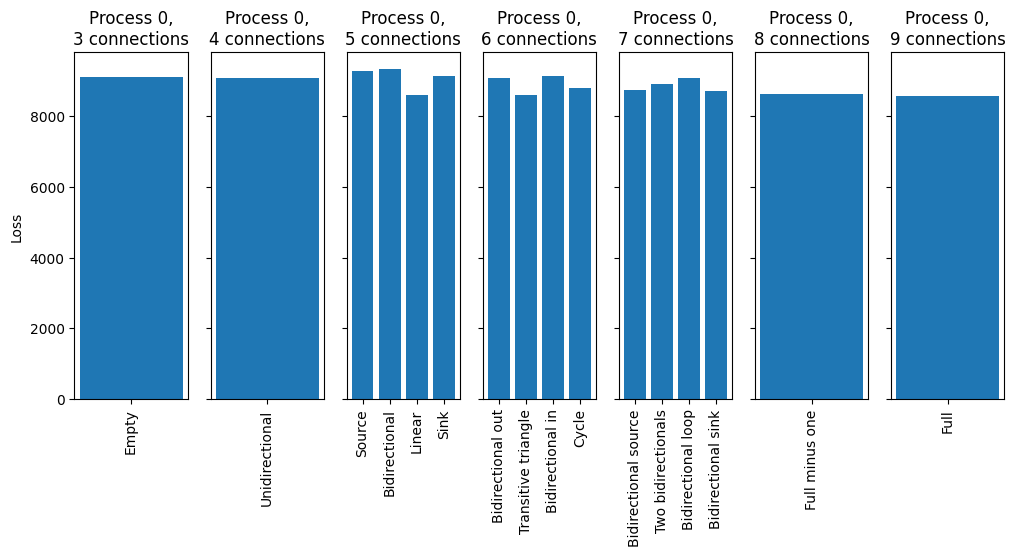

[{3: {'Empty': 9116.589168636401},
  4: {'Unidirectional': 9078.480224838942},
  5: {'Source': 9272.736706415675,
   'Bidirectional': 9335.862038937592,
   'Linear': 8606.655981908285,
   'Sink': 9130.888396672819},
  6: {'Bidirectional out': 9069.958395852314,
   'Transitive triangle': 8591.373917774597,
   'Bidirectional in': 9122.340566568186,
   'Cycle': 8802.375400397894},
  7: {'Bidirectional source': 8750.483445865637,
   'Two bidirectionals': 8894.987993731125,
   'Bidirectional loop': 9090.253477684004,
   'Bidirectional sink': 8712.809925438774},
  8: {'Full minus one': 8631.780755118421},
  9: {'Full': 8578.626803537714}}]

In [67]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, 0.95, 0]]))

### Transitive triangle without loops, one negative connection

In [68]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0],[0.95, 0.0, 0], [0.95, -0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 0.    0.    0.  ]
 [ 0.95  0.    0.  ]
 [ 0.95 -0.95  0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889  0.07174766  0.        ]
 [ 0.49686747 -0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8789.722083658215


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.00125947  0.          0.        ]
 [ 0.          0.37889373  0.        ]
 [ 0.          0.         -0.0746849 ]]
NN K: [[ 0.19849566  0.00662318  0.00259414]
 [ 0.03599522  0.4118695   0.16825276]
 [-0.00539556  0.14215807  0.66693352]]
NN W: [[ 1.00376471 -0.00859949 -0.00223547]
 [-0.02044897  0.81944677 -0.02912612]
 [ 0.01438834 -0.10943573  0.79064139]]
Loss: 9651.082349763828
Testing Empty, Trial 2
NN M: [[-0.01968306  0.          0.        ]
 [ 0.          0.37126921  0.        ]
 [ 0.          0.         -0.08132248]]
NN K: [[ 0.20235625  0.01900924 -0.00740493]
 [ 0.03277944  0.41490748  0.18240516]
 [-0.00218743  0.15008649  0.68915638]]
NN W: [[ 0.99639845 -0.0304364   0.01275923]
 [-0.01215653  0.82619612 -0.05029179]
 [ 0.00147756 -0.11267319  0.76891935]]
Loss: 9555.779141074712
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:10<17:43, 70.92s/it]

NN M: [[-0.00176846  0.          0.        ]
 [ 0.          0.39379182  0.        ]
 [ 0.          0.         -0.0788589 ]]
NN K: [[ 0.20058999 -0.00629221 -0.01950128]
 [ 0.03516569  0.41777505  0.15593536]
 [ 0.00112788  0.19235198  0.6779091 ]]
NN W: [[ 1.0057302  -0.00450577  0.02924053]
 [-0.02884107  0.79677657 -0.00924012]
 [-0.02083001 -0.17364059  0.78029568]]
Loss: 9391.554210415428
Testing Unidirectional, Trial 1
NN M: [[-0.02443373  0.          0.        ]
 [ 0.43617235  0.17969806  0.        ]
 [ 0.          0.         -0.08499408]]
NN K: [[ 2.14434210e-01 -1.11804873e-02 -1.06327657e-02]
 [ 8.69723726e-03  3.36326356e-01  1.41804329e-01]
 [ 4.64991905e-04  1.18418408e-01  6.88793089e-01]]
NN W: [[ 0.97464851  0.01025205  0.01008061]
 [-0.02017843  0.94071141 -0.05450598]
 [-0.02091025 -0.03175069  0.75967477]]
Loss: 9286.41148073236
Testing Unidirectional, Trial 2
NN M: [[-0.01371263  0.          0.        ]
 [ 0.42877136  0.19919036  0.        ]
 [ 0.          0.        

 12%|███████████████████                                                                                                                                     | 2/16 [02:21<16:33, 70.98s/it]

NN M: [[ 0.00277426  0.          0.        ]
 [ 0.47038185  0.17954351  0.        ]
 [ 0.          0.         -0.07619641]]
NN K: [[ 0.21340337 -0.00460361  0.00343465]
 [-0.00593641  0.3200208   0.10702463]
 [-0.0143779   0.17760493  0.6824478 ]]
NN W: [[ 9.78772410e-01 -6.46126695e-04 -2.82251487e-03]
 [ 4.07278117e-02  9.48895825e-01 -1.02995469e-02]
 [ 1.85006754e-02 -1.39819136e-01  7.71274006e-01]]
Loss: 9103.397123804192
Testing Source, Trial 1
NN M: [[-0.01133896  0.          0.        ]
 [ 0.43234539  0.20020441  0.        ]
 [ 0.09613385  0.         -0.10520364]]
NN K: [[ 0.2187153  -0.03663627 -0.02743995]
 [ 0.00533564  0.33061038  0.13399953]
 [-0.00890148  0.14874073  0.67535233]]
NN W: [[ 9.75408295e-01  2.34195991e-02  3.57356503e-02]
 [-7.99053279e-04  9.52457278e-01 -5.14524069e-02]
 [-4.15039951e-03 -9.34938848e-02  7.75383937e-01]]
Loss: 9198.580758335645
Testing Source, Trial 2
NN M: [[-0.02968255  0.          0.        ]
 [ 0.46193989  0.18205749  0.        ]
 [ 0

 19%|████████████████████████████▌                                                                                                                           | 3/16 [03:33<15:25, 71.22s/it]

NN M: [[-0.09305539  0.          0.        ]
 [ 0.42262431  0.21487616  0.        ]
 [ 0.24387898  0.         -0.15828055]]
NN K: [[ 0.22385262 -0.05257705  0.0060164 ]
 [ 0.00930676  0.31984355  0.11594445]
 [ 0.00105328  0.06788294  0.6236628 ]]
NN W: [[ 9.76878561e-01  6.82809261e-02  3.12117169e-04]
 [-1.78527910e-02  9.53236841e-01 -2.39082902e-02]
 [-3.31153658e-02 -6.96119236e-03  8.10595953e-01]]
Loss: 8856.041063895073
Testing Bidirectional, Trial 1
NN M: [[ 0.0354369  -0.04711407  0.        ]
 [ 0.3718361   0.23459668  0.        ]
 [ 0.          0.         -0.08072141]]
NN K: [[ 0.20655378 -0.02924547 -0.04538546]
 [ 0.00739756  0.32601522  0.14097809]
 [-0.01374102  0.16036724  0.67793457]]
NN W: [[ 0.99771728  0.0360525   0.04567518]
 [ 0.00440845  0.95517995 -0.05049836]
 [ 0.03961797 -0.11407014  0.77503588]]
Loss: 9055.398891145765
Testing Bidirectional, Trial 2
NN M: [[-0.00863534 -0.04037676  0.        ]
 [ 0.35110372  0.27561809  0.        ]
 [ 0.          0.         

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [04:44<14:13, 71.13s/it]

NN M: [[ 0.02164931 -0.03610183  0.        ]
 [ 0.45238243  0.16702498  0.        ]
 [ 0.         -0.         -0.08507996]]
NN K: [[ 0.21158596 -0.02232572 -0.03174583]
 [-0.00125587  0.31857438  0.12138212]
 [-0.01431959  0.10159612  0.66883269]]
NN W: [[ 1.00111971  0.03090355  0.03249576]
 [ 0.01403332  0.96523128 -0.04212724]
 [ 0.03224118 -0.00282831  0.78033736]]
Loss: 9248.773596206853
Testing Linear, Trial 1
NN M: [[-0.04015837  0.          0.        ]
 [ 0.48769311  0.16031005  0.        ]
 [ 0.         -0.38470619  0.10344422]]
NN K: [[ 0.22169319 -0.05688257 -0.02415398]
 [-0.02371234  0.37138195  0.16542131]
 [ 0.00993365  0.14354948  0.46521269]]
NN W: [[ 0.96962295  0.09414597  0.02092298]
 [ 0.01760968  0.8969286  -0.09037753]
 [-0.00971114 -0.0357956   0.95827558]]
Loss: 8701.953126939643
Testing Linear, Trial 2
NN M: [[-0.0239267   0.          0.        ]
 [ 0.48808658  0.15815845  0.        ]
 [ 0.         -0.35960439  0.08208125]]
NN K: [[ 0.21453768 -0.03249749 -0.0

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [05:55<13:03, 71.23s/it]

NN M: [[-0.03560082  0.          0.        ]
 [ 0.50948683  0.15305715  0.        ]
 [ 0.         -0.37317264  0.09110845]]
NN K: [[ 0.21014889 -0.02739283 -0.01694278]
 [-0.02275716  0.36541707  0.15603314]
 [ 0.00446562  0.16881304  0.50462573]]
NN W: [[ 1.00165768  0.04146083  0.02032748]
 [-0.00149592  0.90088307 -0.07124464]
 [-0.00512448 -0.07581384  0.90697208]]
Loss: 8837.793825383405
Testing Sink, Trial 1
NN M: [[ 0.00796006  0.          0.        ]
 [ 0.45963121  0.14270014  0.03535801]
 [ 0.          0.         -0.08127704]]
NN K: [[ 0.21516138 -0.03632741 -0.03196647]
 [ 0.0079074   0.31727989  0.10690877]
 [-0.01517023  0.1242166   0.68913266]]
NN W: [[ 0.98279529  0.05416896  0.03301337]
 [-0.02491883  0.96827951 -0.02769846]
 [ 0.01817027 -0.03966233  0.75669   ]]
Loss: 9347.474568654867
Testing Sink, Trial 2
NN M: [[ 0.00431522  0.          0.        ]
 [ 0.44163806  0.15420351  0.06263593]
 [ 0.          0.         -0.07782345]]
NN K: [[ 0.2132938  -0.03970534 -0.04809

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [07:07<11:52, 71.22s/it]

NN M: [[-0.01041679  0.          0.        ]
 [ 0.32732687  0.2030658   0.07755417]
 [ 0.         -0.         -0.07768287]]
NN K: [[ 0.21143741 -0.0173551  -0.0408286 ]
 [ 0.02054662  0.34823276  0.11288034]
 [ 0.00892916  0.10389524  0.66737374]]
NN W: [[ 0.99502241  0.007664    0.05075773]
 [-0.03320603  0.89456678 -0.00823991]
 [-0.01760007 -0.02813194  0.77541669]]
Loss: 9339.632600535839
Testing Bidirectional out, Trial 1
NN M: [[ 0.03883544  0.01693001  0.        ]
 [ 0.50360041  0.09805592  0.        ]
 [-0.19681821  0.          0.00153916]]
NN K: [[0.19323471 0.02562394 0.02676325]
 [0.00162685 0.33071717 0.13940561]
 [0.01632557 0.10090065 0.66106862]]
NN W: [[ 1.00898073 -0.05125679 -0.02914881]
 [ 0.00267022  0.9532242  -0.06788255]
 [-0.043577    0.02445517  0.78661864]]
Loss: 9055.435433429735
Testing Bidirectional out, Trial 2
NN M: [[-0.07115886  0.00448543  0.        ]
 [ 0.43370737  0.20114408  0.        ]
 [ 0.17540079  0.         -0.13114531]]
NN K: [[ 0.21729376 -0.

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [08:17<10:40, 71.13s/it]

NN M: [[-0.03590885 -0.06312839  0.        ]
 [ 0.40828647  0.26631021  0.        ]
 [ 0.2611195  -0.         -0.14916047]]
NN K: [[ 0.22264763 -0.05803306 -0.02387451]
 [-0.00282796  0.35776834  0.12567937]
 [-0.01818525  0.12969114  0.6221919 ]]
NN W: [[ 0.98023777  0.069188    0.01883375]
 [ 0.03819304  0.87969692 -0.0134347 ]
 [ 0.04640798 -0.10659918  0.82033293]]
Loss: 9006.434795347664
Testing Transitive triangle, Trial 1
NN M: [[-0.03256488  0.          0.        ]
 [ 0.43947258  0.20663256  0.        ]
 [ 0.23010604 -0.40746559  0.03572143]]
NN K: [[ 0.22784941 -0.05586803 -0.03252348]
 [-0.00395857  0.35365863  0.14520197]
 [-0.00114778  0.12671313  0.48849192]]
NN W: [[ 0.9609461   0.060199    0.04433937]
 [-0.01983016  0.9054959  -0.05420474]
 [ 0.0163714  -0.04754958  0.91203887]]
Loss: 8583.196485577397
Testing Transitive triangle, Trial 2
NN M: [[ 0.01272293  0.          0.        ]
 [ 0.41633527  0.20034644  0.        ]
 [ 0.09665615 -0.33008719  0.05371741]]
NN K: [[ 0

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [09:29<09:29, 71.13s/it]

NN M: [[-0.04839241  0.          0.        ]
 [ 0.43825447  0.20430937  0.        ]
 [ 0.2690715  -0.38881866  0.00852933]]
NN K: [[ 0.22983216 -0.04774692 -0.01102418]
 [-0.00587541  0.33557661  0.12353753]
 [-0.01554807  0.13446265  0.49313157]]
NN W: [[ 0.96569619  0.06557937  0.01230059]
 [-0.01655975  0.94442168 -0.03549851]
 [ 0.05520153 -0.08424367  0.91975207]]
Loss: 8710.068475740487
Testing Bidirectional in, Trial 1
NN M: [[-0.01423326 -0.02086785  0.01198701]
 [ 0.37322003  0.24539148  0.        ]
 [ 0.          0.         -0.07538184]]
NN K: [[ 0.20965254 -0.01806372 -0.03557313]
 [ 0.00914883  0.33903857  0.13771338]
 [-0.01124715  0.15371736  0.68249753]]
NN W: [[ 0.9926031   0.01314466  0.04106536]
 [-0.00439232  0.9138587  -0.03120556]
 [ 0.015664   -0.10918016  0.77031442]]
Loss: 9357.025622890817
Testing Bidirectional in, Trial 2
NN M: [[ 0.00784244 -0.03171966 -0.00183086]
 [ 0.40861286  0.21525512  0.        ]
 [ 0.         -0.         -0.07664441]]
NN K: [[ 0.21157

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [10:40<08:19, 71.29s/it]

NN M: [[-0.07156124  0.03032847  0.00999639]
 [ 0.46879946  0.17564271  0.        ]
 [ 0.         -0.         -0.08199888]]
NN K: [[ 0.20816939  0.0043679   0.00653315]
 [-0.00185531  0.31366938  0.09526104]
 [ 0.00199061  0.14384975  0.68254256]]
NN W: [[ 0.98575749 -0.0139453   0.00326186]
 [ 0.02385615  0.95270688  0.0043586 ]
 [-0.04770808 -0.08016789  0.76766741]]
Loss: 9288.442701753262
Testing Cycle, Trial 1
NN M: [[-2.75474964e-04  0.00000000e+00 -1.80747955e-02]
 [ 4.91323453e-01  1.43300371e-01  0.00000000e+00]
 [ 0.00000000e+00 -4.05105927e-01  1.12230540e-01]]
NN K: [[ 0.21666557 -0.03832986 -0.01886656]
 [-0.02601648  0.36154297  0.16601037]
 [-0.00210419  0.13350767  0.45772273]]
NN W: [[ 0.98305852  0.04590623  0.01908837]
 [ 0.00952624  0.91133537 -0.09690046]
 [ 0.04813366 -0.00339538  0.95715424]]
Loss: 9182.647655928253
Testing Cycle, Trial 2
NN M: [[-0.01115361  0.         -0.00401795]
 [ 0.54927687  0.11134838  0.        ]
 [ 0.         -0.38281234  0.10001035]]
NN

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [11:51<07:07, 71.25s/it]

NN M: [[ 0.0053198   0.         -0.01354969]
 [ 0.47437311  0.16733285  0.        ]
 [ 0.         -0.35100151  0.08320308]]
NN K: [[ 0.21685032 -0.02504769 -0.00101703]
 [-0.02791354  0.35642487  0.13762045]
 [-0.01212528  0.18233323  0.4979565 ]]
NN W: [[ 0.98392398  0.02397948 -0.00431387]
 [ 0.01705831  0.92051117 -0.04571218]
 [ 0.05209206 -0.11300796  0.93321296]]
Loss: 8826.534289207126
Testing Bidirectional source, Trial 1
NN M: [[-0.0503127  -0.00264742  0.        ]
 [ 0.54055641  0.13589995  0.        ]
 [ 0.21108024 -0.43863678  0.07172171]]
NN K: [[ 0.21848994 -0.03620497 -0.02466549]
 [-0.01102186  0.34596108  0.15731147]
 [ 0.00132418  0.08073355  0.42848276]]
NN W: [[ 0.99109371  0.05797749  0.03217695]
 [-0.00866261  0.90286268 -0.1060009 ]
 [ 0.0012978   0.0329208   0.97895013]]
Loss: 8492.52182435769
Testing Bidirectional source, Trial 2
NN M: [[-0.06110238 -0.02346067  0.        ]
 [ 0.45770785  0.21578112  0.        ]
 [ 0.26422504 -0.40823407  0.01861626]]
NN K: [[ 

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [13:02<05:55, 71.16s/it]

NN M: [[-0.03575167 -0.00705133  0.        ]
 [ 0.4667092   0.19350065  0.        ]
 [ 0.30284029 -0.40709484  0.00907332]]
NN K: [[ 0.2220965  -0.02283637 -0.02149681]
 [-0.0168401   0.34938736  0.11601504]
 [-0.0025323   0.12551296  0.4738931 ]]
NN W: [[ 0.97498263  0.0104589   0.03373386]
 [ 0.03991307  0.91156563 -0.01076179]
 [ 0.01698017 -0.07791006  0.93649466]]
Loss: 8748.088190523511
Testing Two bidirectionals, Trial 1
NN M: [[-0.02831149  0.01730734  0.00054199]
 [ 0.52028177  0.12555205  0.        ]
 [ 0.02695676  0.         -0.08862989]]
NN K: [[ 0.20677153 -0.00137305  0.00985325]
 [ 0.00102262  0.31034527  0.09256847]
 [ 0.0050875   0.11231469  0.67504507]]
NN W: [[ 9.99769738e-01 -1.42004492e-02 -7.00724998e-03]
 [-6.06691991e-04  9.74163462e-01 -9.29880404e-03]
 [-3.17240581e-02 -2.16927987e-02  7.71283708e-01]]
Loss: 9392.481713599505
Testing Two bidirectionals, Trial 2
NN M: [[-0.02079354 -0.01479722 -0.00307762]
 [ 0.47733678  0.17245192  0.        ]
 [ 0.15372301  0

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [14:14<04:44, 71.24s/it]

NN M: [[-0.04982462  0.00864784 -0.00699236]
 [ 0.52876922  0.11911245  0.        ]
 [ 0.11156335 -0.         -0.11808144]]
NN K: [[ 2.10064437e-01 -1.88566513e-02  1.51270233e-02]
 [ 6.58583346e-04  2.94611786e-01  8.10343631e-02]
 [-1.75010347e-02  8.27223965e-02  6.60915044e-01]]
NN W: [[ 0.99143328  0.02724627 -0.02576468]
 [-0.00886597  1.00860014 -0.00592434]
 [ 0.0031431   0.00695165  0.77967857]]
Loss: 9438.02537213958
Testing Bidirectional loop, Trial 1
NN M: [[ 0.02749577 -0.03694195  0.        ]
 [ 0.42362005  0.15699753  0.04812361]
 [ 0.05437038 -0.         -0.09133009]]
NN K: [[ 0.21143685 -0.02479402 -0.0430776 ]
 [ 0.00301944  0.32288525  0.08553425]
 [-0.01438833  0.1209267   0.67549739]]
NN W: [[ 0.99576615  0.02484118  0.04250296]
 [ 0.00624732  0.95672963  0.01329053]
 [ 0.05243983 -0.05535506  0.77451832]]
Loss: 8958.975806443344
Testing Bidirectional loop, Trial 2
NN M: [[-0.0243474  -0.0289202   0.        ]
 [ 0.35195991  0.23100395  0.06934952]
 [ 0.15360906  0.

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [15:25<03:33, 71.25s/it]

NN M: [[-0.05172414  0.01487747  0.        ]
 [ 0.4270195   0.15833286  0.07724471]
 [ 0.10725342  0.         -0.10176517]]
NN K: [[ 0.22024037 -0.03545614 -0.03906078]
 [ 0.01106362  0.31658226  0.05296264]
 [ 0.00474319  0.11765856  0.64237226]]
NN W: [[ 0.98276617  0.03890528  0.06236988]
 [-0.02932309  0.93965011  0.05312631]
 [-0.04953272 -0.05937527  0.79861769]]
Loss: 9647.40496834453
Testing Bidirectional sink, Trial 1
NN M: [[-0.02546887  0.          0.        ]
 [ 0.49006756  0.13698737  0.07307889]
 [ 0.28615612 -0.43212322  0.02690611]]
NN K: [[ 0.22188695 -0.03094263 -0.06312741]
 [-0.01444203  0.33544865  0.0790058 ]
 [ 0.00211661  0.10038558  0.43070052]]
NN W: [[ 0.98047918  0.04113535  0.09371302]
 [ 0.0163762   0.92481686  0.028378  ]
 [-0.01271857 -0.02330448  0.98597346]]
Loss: 8741.252687544003
Testing Bidirectional sink, Trial 2
NN M: [[-0.05208817  0.          0.        ]
 [ 0.44768034  0.18695044  0.06076332]
 [ 0.32302105 -0.42347563 -0.00896047]]
NN K: [[ 0.22

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [16:36<02:22, 71.29s/it]

NN M: [[ 0.0388525   0.          0.        ]
 [ 0.477674    0.12429326  0.08214921]
 [ 0.10943515 -0.35841654  0.05301309]]
NN K: [[ 0.21602374 -0.00901544 -0.03984292]
 [-0.0243137   0.36831     0.10759599]
 [ 0.00080496  0.1474542   0.49843546]]
NN W: [[ 0.97821522 -0.03414392  0.0487379 ]
 [ 0.04233609  0.87993584  0.00599321]
 [ 0.032721   -0.07368455  0.91704584]]
Loss: 8634.213867349643
Testing Full minus one, Trial 1
NN M: [[-0.02936356 -0.04262381 -0.00700743]
 [ 0.43903284  0.2222837   0.        ]
 [ 0.31072114 -0.43407574  0.00420145]]
NN K: [[ 0.2240382  -0.05410292 -0.02883719]
 [-0.00936363  0.34495546  0.12766557]
 [-0.00562454  0.09045791  0.45470288]]
NN W: [[ 9.71312842e-01  9.26442899e-02  1.52040695e-02]
 [-3.45535207e-03  9.06139806e-01 -3.06470986e-02]
 [ 1.36622761e-02 -9.33754836e-04  9.39654969e-01]]
Loss: 8860.32130965536
Testing Full minus one, Trial 2
NN M: [[-0.0852675   0.00883512  0.00979542]
 [ 0.55230284  0.12464275  0.        ]
 [ 0.18345742 -0.46072776

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [17:48<01:11, 71.24s/it]

NN M: [[-0.0162635  -0.00743894 -0.00650552]
 [ 0.54836653  0.1301003   0.        ]
 [ 0.19821036 -0.42804016  0.06010246]]
NN K: [[ 0.21559279 -0.029773   -0.01344258]
 [-0.01612668  0.3476598   0.13617004]
 [ 0.00359835  0.12275146  0.46917269]]
NN W: [[ 0.99650902  0.02838288  0.01359872]
 [ 0.01583919  0.9189848  -0.06755288]
 [-0.00224385 -0.03561584  0.93257737]]
Loss: 8700.428884027662
Testing Full, Trial 1
NN M: [[-0.01642797  0.0053498  -0.00577532]
 [ 0.47731374  0.15024742  0.04572644]
 [ 0.20308724 -0.3935959   0.05397006]]
NN K: [[ 0.2203451  -0.02210702 -0.03286443]
 [-0.01695477  0.35000532  0.12806088]
 [ 0.00163068  0.14879103  0.47654647]]
NN W: [[ 0.99755918  0.01115079  0.04190198]
 [ 0.00650654  0.91736124 -0.03337356]
 [ 0.00298797 -0.09686034  0.94668285]]
Loss: 8687.820822206293
Testing Full, Trial 2
NN M: [[-0.02427387  0.00118935 -0.01297187]
 [ 0.46045137  0.18815307  0.05533203]
 [ 0.3179989  -0.44442808  0.00163392]]
NN K: [[ 0.22782824 -0.03461139 -0.02807

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [18:59<00:00, 71.20s/it]

NN M: [[-0.01990351  0.01210971 -0.01896101]
 [ 0.44568601  0.14977048  0.08108396]
 [ 0.20880236 -0.39976574  0.05319438]]
NN K: [[ 0.22826339 -0.04077932 -0.04513166]
 [-0.02125635  0.3577229   0.11196729]
 [ 0.00698418  0.10537136  0.42330841]]
NN W: [[ 0.98862408  0.05827495  0.05354544]
 [ 0.00570973  0.89286086 -0.00939011]
 [-0.01516758 -0.0307508   1.02009928]]
Loss: 8380.699742485935


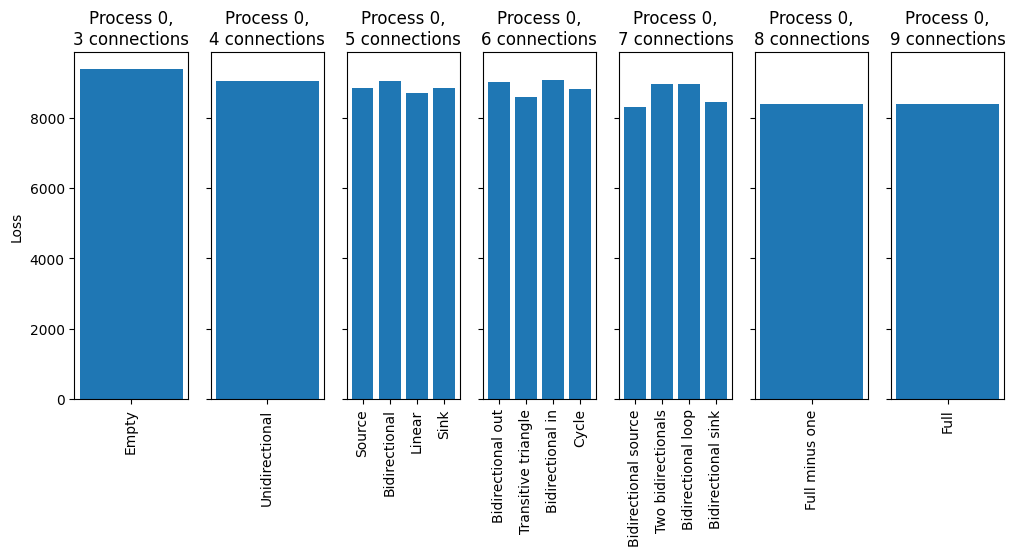

[{3: {'Empty': 9391.554210415428},
  4: {'Unidirectional': 9040.92362783165},
  5: {'Source': 8856.041063895073,
   'Bidirectional': 9055.398891145765,
   'Linear': 8701.953126939643,
   'Sink': 8857.627143526097},
  6: {'Bidirectional out': 9006.434795347664,
   'Transitive triangle': 8583.196485577397,
   'Bidirectional in': 9064.54923679792,
   'Cycle': 8826.534289207126},
  7: {'Bidirectional source': 8319.446748369355,
   'Two bidirectionals': 8975.707147011242,
   'Bidirectional loop': 8958.975806443344,
   'Bidirectional sink': 8445.90108885906},
  8: {'Full minus one': 8398.59669926504},
  9: {'Full': 8380.699742485935}}]

In [69]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, -0.95, 0]]))

### Cycle

In [70]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0.95], [0.95, 0, 0], [0, 0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(10, 1e-7), np.full(10, 5e-8), np.full(10, 5e-9), np.full(10, 1e-11))))

Process dynamics: [[0.   0.   0.95]
 [0.95 0.   0.  ]
 [0.   0.95 0.  ]]
Eigenvalues: [-0.475+0.82272413j -0.475-0.82272413j  0.95 +0.j        ]
Kalman filter M: [[0.         0.         0.60049406]
 [0.60049406 0.         0.        ]
 [0.         0.60049406 0.        ]]
Kalman filter K: [[0.36790099 0.         0.        ]
 [0.         0.36790099 0.        ]
 [0.         0.         0.36790099]]
Kalman filter loss: 8089.36987983085


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.25316608 0.         0.        ]
 [0.         0.21781439 0.        ]
 [0.         0.         0.10087038]]
NN K: [[ 0.57742465  0.12348179  0.25714441]
 [ 0.18866906  0.55496387  0.11600597]
 [-0.04600613  0.09508813  0.65362735]]
NN W: [[ 1.0088081  -0.16296642 -0.21151543]
 [-0.15136711  1.0740917  -0.05274452]
 [ 0.1092438  -0.00760123  1.02959929]]
Loss: 19056.949621470572
Testing Empty, Trial 2
NN M: [[0.02849482 0.         0.        ]
 [0.         0.3065679  0.        ]
 [0.         0.         0.23217785]]
NN K: [[0.68150321 0.00563601 0.1024686 ]
 [0.34032677 0.54033763 0.11197216]
 [0.15999119 0.17175695 0.5823081 ]]
NN W: [[ 1.09270432  0.09630479 -0.07995563]
 [-0.35437601  1.03677127 -0.20647507]
 [-0.17703392 -0.22253775  1.18096838]]
Loss: 15881.336134557747
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:11<17:49, 71.27s/it]

NN M: [[ 0.28155593  0.          0.        ]
 [ 0.          0.17498135  0.        ]
 [ 0.          0.         -0.13035585]]
NN K: [[ 0.52358513  0.29204292  0.22036972]
 [ 0.09234748  0.52443047  0.26732014]
 [ 0.21263324 -0.13005853  0.68814038]]
NN W: [[ 0.84533154 -0.27658     0.05157764]
 [ 0.09426936  1.04562721 -0.45157916]
 [ 0.11050921  0.15078088  0.90007116]]
Loss: 22517.500116921623
Testing Unidirectional, Trial 1
NN M: [[0.0709186  0.         0.        ]
 [0.17429006 0.13546037 0.        ]
 [0.         0.         0.24123819]]
NN K: [[0.72649441 0.08875878 0.09655241]
 [0.16272469 0.48682    0.08597553]
 [0.12930831 0.21061725 0.54245492]]
NN W: [[ 1.06009568 -0.02778867 -0.06473511]
 [-0.09611456  1.04578524 -0.04369974]
 [-0.21203691 -0.1405347   1.11987105]]
Loss: 16577.426660970435
Testing Unidirectional, Trial 2
NN M: [[-0.09808596  0.          0.        ]
 [ 0.20830451  0.25304291  0.        ]
 [ 0.          0.          0.29888777]]
NN K: [[ 0.63539204 -0.10963123  0.0

 12%|███████████████████                                                                                                                                     | 2/16 [02:22<16:33, 70.97s/it]

NN M: [[0.35088165 0.         0.        ]
 [0.20297682 0.16800778 0.        ]
 [0.         0.         0.26774644]]
NN K: [[0.57446443 0.16252694 0.18126962]
 [0.11266163 0.5479949  0.08241556]
 [0.08304388 0.20810011 0.62778625]]
NN W: [[ 1.02122356 -0.27350155 -0.12698678]
 [-0.06529461  1.05109505 -0.2072777 ]
 [-0.14326354 -0.23112345  1.14217364]]
Loss: 17468.176060012163
Testing Source, Trial 1
NN M: [[-0.10225354  0.          0.        ]
 [ 0.28093513  0.16134346  0.        ]
 [-0.07058267  0.          0.23397997]]
NN K: [[ 0.70039065 -0.0075484  -0.04497297]
 [ 0.25974432  0.43219335  0.0696646 ]
 [ 0.10207312  0.14515826  0.54661129]]
NN W: [[ 1.02528611  0.08869822  0.24559214]
 [-0.35471564  1.01741863  0.03362842]
 [-0.18852678  0.05407315  1.0214002 ]]
Loss: 15784.906274951343
Testing Source, Trial 2
NN M: [[ 0.30844714  0.          0.        ]
 [ 0.35511105 -0.02355395  0.        ]
 [-0.02650064  0.          0.33692453]]
NN K: [[ 0.55204896 -0.02079905  0.19433253]
 [ 0.05

 19%|████████████████████████████▌                                                                                                                           | 3/16 [03:33<15:23, 71.04s/it]

NN M: [[0.35654815 0.         0.        ]
 [0.21794816 0.20261858 0.        ]
 [0.31042697 0.         0.00692657]]
NN K: [[ 0.47805486  0.11759061  0.25451319]
 [ 0.21211571  0.52022841  0.08055992]
 [-0.01678286  0.12719418  0.63781572]]
NN W: [[ 1.14760423 -0.0117074  -0.47069485]
 [-0.20262717  0.95081178 -0.07582823]
 [-0.00670902 -0.19262067  1.04742139]]
Loss: 16746.7772533679
Testing Bidirectional, Trial 1
NN M: [[0.09197368 0.10644217 0.        ]
 [0.22016188 0.06114489 0.        ]
 [0.         0.         0.32862502]]
NN K: [[0.69302412 0.24704808 0.0926208 ]
 [0.07351581 0.5061928  0.05686641]
 [0.17675781 0.29477251 0.60805803]]
NN W: [[ 1.0925484  -0.32183082 -0.07297164]
 [-0.02600019  1.06923666 -0.03393289]
 [-0.37347594 -0.27916901  1.04909162]]
Loss: 15933.04447833309
Testing Bidirectional, Trial 2
NN M: [[0.20571681 0.33526601 0.        ]
 [0.16435977 0.3908522  0.        ]
 [0.         0.         0.23666046]]
NN K: [[ 0.49497487  0.08441751  0.18786597]
 [ 0.08786084 

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [04:44<14:13, 71.10s/it]

NN M: [[0.10238328 0.37120943 0.        ]
 [0.30399449 0.19030369 0.        ]
 [0.         0.         0.09555423]]
NN K: [[0.51523076 0.14344141 0.12422856]
 [0.04311692 0.39132057 0.26797506]
 [0.04808855 0.02686845 0.5907901 ]]
NN W: [[ 0.92874379 -0.30917099  0.05465138]
 [-0.13293143  0.88377908 -0.1331261 ]
 [-0.01590492  0.13055507  1.0674342 ]]
Loss: 18525.91625403562
Testing Linear, Trial 1
NN M: [[ 0.3054819   0.          0.        ]
 [ 0.37393839 -0.1560151   0.        ]
 [ 0.          0.11788761  0.266404  ]]
NN K: [[ 0.57756115  0.16652701  0.13479828]
 [-0.05119553  0.60015803  0.03665398]
 [ 0.0850863   0.2245279   0.52604827]]
NN W: [[ 1.04835661 -0.24221574 -0.12027535]
 [ 0.0426437   1.02124332 -0.02165553]
 [-0.19953269 -0.20648983  1.08475156]]
Loss: 14031.56351623151
Testing Linear, Trial 2
NN M: [[0.04615883 0.         0.        ]
 [0.15759423 0.24083339 0.        ]
 [0.         0.22434914 0.04678224]]
NN K: [[0.72052794 0.0394829  0.01823687]
 [0.20277532 0.512186

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [05:55<13:03, 71.18s/it]

NN M: [[ 0.1842479   0.          0.        ]
 [ 0.26996513 -0.13341738  0.        ]
 [ 0.          0.24415274  0.12328563]]
NN K: [[0.72064565 0.34161535 0.16420912]
 [0.00412964 0.60486351 0.17230836]
 [0.19648608 0.22868201 0.59116581]]
NN W: [[ 0.97688025 -0.42237288 -0.05887271]
 [ 0.14109043  1.02453675 -0.22349274]
 [-0.20086883 -0.12037285  0.94947823]]
Loss: 14195.466723246547
Testing Sink, Trial 1
NN M: [[0.02208241 0.         0.        ]
 [0.19095466 0.14542294 0.07655231]
 [0.         0.         0.13971995]]
NN K: [[ 0.56740703 -0.06202294  0.10651305]
 [ 0.24937805  0.43545017  0.0724962 ]
 [ 0.15503814  0.30559551  0.6277415 ]]
NN W: [[ 1.07957601  0.21036714  0.01503578]
 [-0.20397832  0.81105377  0.12371251]
 [ 0.05687542 -0.26019237  0.95784863]]
Loss: 18523.576337957762
Testing Sink, Trial 2
NN M: [[0.04485584 0.         0.        ]
 [0.03057175 0.20257125 0.27604185]
 [0.         0.         0.18711572]]
NN K: [[ 0.51587614 -0.07133636  0.0569484 ]
 [ 0.25509092  0.438

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [07:06<11:51, 71.19s/it]

NN M: [[0.17672836 0.         0.        ]
 [0.13942911 0.1002986  0.21837402]
 [0.         0.         0.24517232]]
NN K: [[0.51146422 0.01775718 0.11065187]
 [0.28626076 0.48864206 0.0591622 ]
 [0.31470823 0.20998819 0.70416081]]
NN W: [[ 1.03861995  0.03580169  0.04988098]
 [-0.21637623  0.85834339 -0.07169816]
 [-0.20792384 -0.34312353  0.98935205]]
Loss: 19948.242022958188
Testing Bidirectional out, Trial 1
NN M: [[-0.18625747  0.16766739  0.        ]
 [ 0.11490932  0.38348408  0.        ]
 [-0.03098154  0.          0.31163507]]
NN K: [[ 0.52076244 -0.11475466 -0.11263535]
 [ 0.2779772   0.43951273  0.09686363]
 [ 0.11281499  0.19383645  0.53822548]]
NN W: [[ 1.10696628  0.24251495  0.10157598]
 [-0.35087957  0.99545289 -0.24228417]
 [-0.01465522 -0.22529835  1.05697003]]
Loss: 16551.065222969406
Testing Bidirectional out, Trial 2
NN M: [[0.23420976 0.02151268 0.        ]
 [0.23544192 0.0719509  0.        ]
 [0.23869667 0.         0.2811418 ]]
NN K: [[0.57931904 0.2849817  0.0521347

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [08:17<10:40, 71.12s/it]

NN M: [[ 0.25105965  0.15124402  0.        ]
 [ 0.20668284  0.03369038  0.        ]
 [ 0.15300755  0.         -0.14386984]]
NN K: [[0.48084968 0.12847683 0.3362349 ]
 [0.16747488 0.57848182 0.18210425]
 [0.01468899 0.05570223 0.64582538]]
NN W: [[ 0.88767221 -0.03072683 -0.42390285]
 [-0.11562055  0.99223023 -0.16695095]
 [ 0.18404645 -0.13880945  1.0232819 ]]
Loss: 17864.285016264075
Testing Transitive triangle, Trial 1
NN M: [[-0.08171739  0.          0.        ]
 [ 0.0910778   0.26414203  0.        ]
 [-0.11013279  0.33970344  0.28018071]]
NN K: [[ 0.58510827  0.0430313  -0.1449391 ]
 [ 0.21188522  0.61136163  0.08152376]
 [ 0.22039043  0.20213763  0.45327827]]
NN W: [[ 1.00579205 -0.07312025  0.33392192]
 [-0.01073277  1.03364367 -0.22230415]
 [-0.31332211 -0.36614052  0.89364671]]
Loss: 14295.520912314203
Testing Transitive triangle, Trial 2
NN M: [[ 0.00046143  0.          0.        ]
 [ 0.20019424  0.287216    0.        ]
 [-0.08166725  0.25770309  0.08983559]]
NN K: [[0.6089880

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [09:28<09:28, 71.09s/it]

NN M: [[ 0.24245504  0.          0.        ]
 [ 0.41535786 -0.13521215  0.        ]
 [ 0.31648413  0.16209696  0.20703667]]
NN K: [[ 0.59853291  0.23818563  0.17276178]
 [-0.04482847  0.57832096 -0.10311133]
 [-0.05917856  0.24294222  0.32435793]]
NN W: [[ 1.15816397 -0.15295552 -0.34336736]
 [ 0.05818646  1.02278221 -0.00696987]
 [ 0.04873866 -0.45076453  0.9416383 ]]
Loss: 14522.158635284106
Testing Bidirectional in, Trial 1
NN M: [[ 0.20311227 -0.11715837  0.26349049]
 [ 0.3105084  -0.24244401  0.        ]
 [ 0.          0.          0.2858147 ]]
NN K: [[ 0.47125703  0.24620222  0.08949744]
 [-0.16391514  0.55228896  0.03997982]
 [ 0.10863973  0.23988115  0.55256425]]
NN W: [[ 1.05859376 -0.46175073 -0.11519584]
 [ 0.19519765  0.98977093  0.02643751]
 [-0.31980234 -0.19205568  1.192225  ]]
Loss: 14445.760657439718
Testing Bidirectional in, Trial 2
NN M: [[0.13222724 0.14116866 0.2630642 ]
 [0.4130102  0.11268272 0.        ]
 [0.         0.         0.09638033]]
NN K: [[0.51969968 0.19

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [10:39<08:17, 71.02s/it]

NN M: [[0.25070585 0.09946937 0.19811662]
 [0.27254466 0.07098968 0.        ]
 [0.         0.         0.17913758]]
NN K: [[0.44908438 0.00204472 0.15749975]
 [0.14539346 0.48704148 0.08341005]
 [0.03818548 0.14341928 0.57819628]]
NN W: [[ 1.00775835 -0.0915889  -0.18126904]
 [-0.29550002  1.2118677  -0.05347534]
 [-0.00612763 -0.16978264  1.22905129]]
Loss: 14839.421174511284
Testing Cycle, Trial 1
NN M: [[0.19780784 0.         0.22996871]
 [0.26216886 0.13540065 0.        ]
 [0.         0.21768974 0.16786224]]
NN K: [[0.49850509 0.09345065 0.10415761]
 [0.1681862  0.54646888 0.01908494]
 [0.1231551  0.24411026 0.58760921]]
NN W: [[ 1.02240658 -0.14464601 -0.12138085]
 [-0.17294703  1.01670705 -0.05289715]
 [-0.20284455 -0.30996113  1.09142384]]
Loss: 13038.686461474823
Testing Cycle, Trial 2
NN M: [[ 0.18092452  0.          0.28855509]
 [ 0.15793303 -0.09300806  0.        ]
 [ 0.          0.06451547  0.25080634]]
NN K: [[ 0.30214555  0.21292384  0.21501622]
 [-0.05373572  0.5689455   

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [11:51<07:07, 71.18s/it]

NN M: [[-1.80251526e-01  0.00000000e+00  3.85450919e-01]
 [ 3.34047272e-04  2.43483705e-01  0.00000000e+00]
 [ 0.00000000e+00  1.70657019e-01  1.40210537e-01]]
NN K: [[ 0.49128853  0.04450505 -0.06642438]
 [ 0.30345476  0.59504756  0.09509513]
 [ 0.16851779  0.19708395  0.56905765]]
NN W: [[ 0.9805061   0.15585019 -0.04401369]
 [-0.20769171  0.97493764 -0.10862186]
 [-0.22370632 -0.26283148  1.10662671]]
Loss: 14493.137724316155
Testing Bidirectional source, Trial 1
NN M: [[0.13554916 0.10959883 0.        ]
 [0.24038847 0.194106   0.        ]
 [0.21033527 0.07460889 0.08222862]]
NN K: [[0.54542074 0.1077211  0.19408876]
 [0.15704462 0.45419116 0.05843221]
 [0.08160896 0.12023784 0.56331753]]
NN W: [[ 1.13452873 -0.02734535 -0.25160359]
 [-0.14650574  1.11918031 -0.15404294]
 [-0.02785107 -0.29132748  1.11775187]]
Loss: 16907.011487945565
Testing Bidirectional source, Trial 2
NN M: [[0.18586258 0.11592371 0.        ]
 [0.30273795 0.13345032 0.        ]
 [0.05572433 0.28302815 0.03997874

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [13:02<05:56, 71.21s/it]

NN M: [[0.32174386 0.22627445 0.        ]
 [0.3872916  0.16055096 0.        ]
 [0.03978311 0.27886588 0.09107074]]
NN K: [[ 0.53200306  0.13098812  0.19331029]
 [-0.00333306  0.48367263  0.09709573]
 [-0.09350115  0.09583097  0.52792927]]
NN W: [[ 1.05162793 -0.39564275 -0.27891112]
 [-0.14673818  0.91485871 -0.14505128]
 [ 0.04719124 -0.08062812  0.88582344]]
Loss: 14327.221400224993
Testing Two bidirectionals, Trial 1
NN M: [[-0.10522469  0.20638695  0.24719525]
 [ 0.24936558  0.22794144  0.        ]
 [ 0.05535216  0.          0.21267673]]
NN K: [[0.55649982 0.1677718  0.10897231]
 [0.16967597 0.38937163 0.19939781]
 [0.07005031 0.18821115 0.58145237]]
NN W: [[ 1.11310158 -0.09713548 -0.27972549]
 [-0.21622918  0.93117974 -0.05582154]
 [-0.22369365  0.00780056  1.05756665]]
Loss: 17384.803323534295
Testing Two bidirectionals, Trial 2
NN M: [[0.27856122 0.23429034 0.14914284]
 [0.32134195 0.05876878 0.        ]
 [0.29367562 0.         0.01530472]]
NN K: [[0.39994281 0.12671982 0.15892

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [14:13<04:45, 71.28s/it]

NN M: [[ 0.31037045  0.36414797  0.02329197]
 [ 0.26156119  0.22618633  0.        ]
 [ 0.29491935  0.         -0.18642424]]
NN K: [[ 0.21170325  0.27698149  0.15862129]
 [ 0.20904092  0.23421418  0.36328275]
 [-0.00245965 -0.24525752  0.4657255 ]]
NN W: [[ 0.52534199  0.06172705 -0.19745125]
 [ 0.14341779  0.59810068 -0.48482908]
 [ 0.04602048  0.11785955  1.06517527]]
Loss: 25334.378627498507
Testing Bidirectional loop, Trial 1
NN M: [[0.18282611 0.2550476  0.        ]
 [0.10087251 0.28502974 0.05280316]
 [0.06301019 0.         0.04938045]]
NN K: [[ 0.49660763  0.01043593  0.24057873]
 [ 0.20093169  0.47461393  0.14910022]
 [-0.00252173  0.07526615  0.60856639]]
NN W: [[ 0.77483069  0.1090278  -0.30161947]
 [-0.24109621  1.03592537 -0.20986834]
 [ 0.10755825 -0.02715687  1.03936791]]
Loss: 17307.002752392473
Testing Bidirectional loop, Trial 2
NN M: [[0.26406078 0.20872801 0.        ]
 [0.12954166 0.09825244 0.09176882]
 [0.27431518 0.         0.15960148]]
NN K: [[0.45454888 0.2130802

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [15:25<03:34, 71.38s/it]

NN M: [[0.0953411  0.31743033 0.        ]
 [0.07790194 0.02944872 0.27335332]
 [0.08959185 0.         0.29056992]]
NN K: [[0.53762161 0.04245389 0.17795559]
 [0.13381946 0.48944731 0.12837992]
 [0.17233659 0.22072176 0.35195603]]
NN W: [[ 0.91046323 -0.13993998 -0.0226228 ]
 [-0.32378014  1.05540366  0.07414801]
 [ 0.12054335 -0.14098652  0.79923235]]
Loss: 22421.628808700283
Testing Bidirectional sink, Trial 1
NN M: [[0.20371007 0.         0.        ]
 [0.18001936 0.21000489 0.01968372]
 [0.15148861 0.12271851 0.15143529]]
NN K: [[ 0.60338238  0.13750574  0.26638769]
 [ 0.15360333  0.43544565 -0.04147604]
 [ 0.05629988  0.28211038  0.55599004]]
NN W: [[ 1.09244436 -0.09679395 -0.23164159]
 [-0.07923772  0.91118229  0.08546019]
 [ 0.1193358  -0.44695696  0.88400269]]
Loss: 18920.533001811873
Testing Bidirectional sink, Trial 2
NN M: [[ 0.02305515  0.          0.        ]
 [ 0.18680674  0.24783375 -0.09220947]
 [-0.09790596  0.41619325 -0.21248451]]
NN K: [[ 0.68696215  0.06062191  0.14

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [16:37<02:22, 71.50s/it]

NN M: [[ 0.15208646  0.          0.        ]
 [ 0.19509398 -0.33086052  0.25217616]
 [ 0.17772658  0.03790543  0.39946471]]
NN K: [[ 0.67249412  0.29617853  0.12861105]
 [-0.09672237  0.61164953  0.04001367]
 [ 0.15833094  0.31956262  0.36746729]]
NN W: [[ 1.10535049 -0.28301624 -0.12026926]
 [ 0.06352086  0.96593623 -0.02562362]
 [-0.14567705 -0.4641782   0.85297478]]
Loss: 16796.9664546191
Testing Full minus one, Trial 1
NN M: [[ 0.39169625 -0.00496634  0.32585074]
 [ 0.20255868 -0.06406047  0.        ]
 [ 0.06445327  0.05426221  0.28436498]]
NN K: [[ 0.35335823  0.14749474  0.24469532]
 [-0.06892181  0.58789364  0.07204213]
 [ 0.09741504  0.18858824  0.47348795]]
NN W: [[ 0.7497556  -0.34293565 -0.13229222]
 [-0.03805394  1.06848635  0.03702828]
 [-0.03133642 -0.14957384  0.88620654]]
Loss: 19498.3093852134
Testing Full minus one, Trial 2
NN M: [[-0.12694314  0.13893761  0.11573958]
 [ 0.24367072  0.22866217  0.        ]
 [-0.13040475  0.24980164  0.09991207]]
NN K: [[0.6808942  0.0

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [17:48<01:11, 71.49s/it]

NN M: [[ 0.27049832  0.10335183  0.19005856]
 [ 0.15375185 -0.02227661  0.        ]
 [ 0.18028866  0.02022916 -0.03447816]]
NN K: [[0.46274967 0.23568277 0.30985637]
 [0.02155768 0.59324344 0.16017783]
 [0.01751421 0.10910971 0.60428134]]
NN W: [[ 0.93254713 -0.33515991 -0.35961836]
 [-0.01248924  1.09162376 -0.13107147]
 [ 0.08736638 -0.20302882  0.9791218 ]]
Loss: 15475.329380140287
Testing Full, Trial 1
NN M: [[0.04600045 0.11276337 0.17421509]
 [0.19340539 0.22559431 0.01627517]
 [0.12251552 0.32569498 0.0272829 ]]
NN K: [[0.56485468 0.06711665 0.19100492]
 [0.27996485 0.55612072 0.03552729]
 [0.10313548 0.15200921 0.59166528]]
NN W: [[ 0.96239862  0.06382843 -0.26078419]
 [-0.32049299  1.03584153 -0.10270711]
 [ 0.00694056 -0.36693887  0.97440498]]
Loss: 12476.969341321916
Testing Full, Trial 2
NN M: [[-0.12442377  0.16273458  0.26591671]
 [ 0.21592833  0.30806421  0.18582931]
 [-0.07208417  0.40243172 -0.00068132]]
NN K: [[ 0.59464529 -0.06159294 -0.01446569]
 [ 0.29938276  0.453

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [19:00<00:00, 71.26s/it]

NN M: [[ 0.02798798  0.23633148  0.24207003]
 [ 0.21034598  0.1450332   0.04596278]
 [ 0.05982873  0.23459289 -0.06180466]]
NN K: [[ 0.54314695  0.09321773  0.12439061]
 [ 0.15857712  0.52805762  0.20731544]
 [-0.01041731 -0.08651261  0.56280673]]
NN W: [[ 1.01743742 -0.22925984 -0.09210332]
 [-0.32519289  1.05782007 -0.12364251]
 [-0.01369313  0.05153691  1.09409496]]
Loss: 12313.226998832793


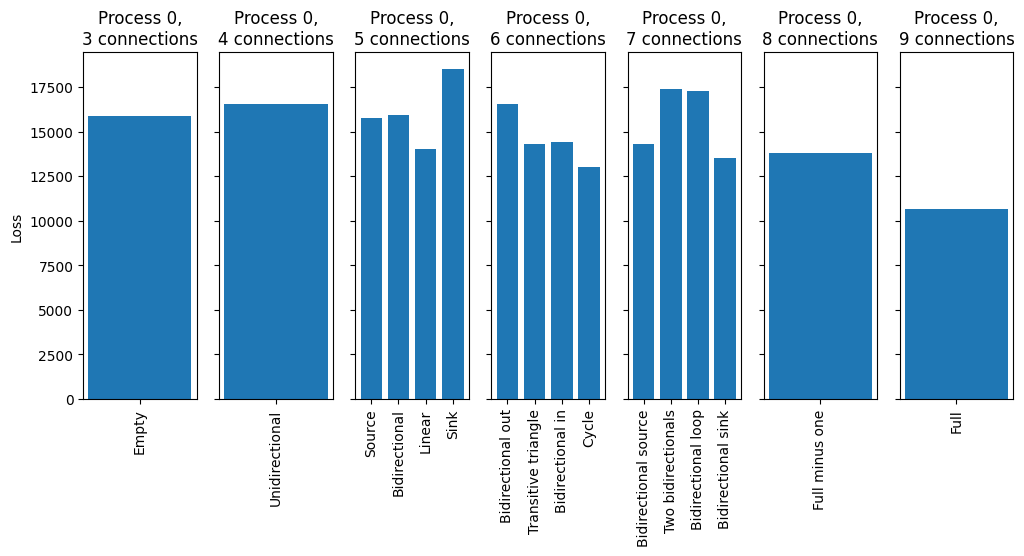

[{3: {'Empty': 15881.336134557747},
  4: {'Unidirectional': 16577.426660970435},
  5: {'Source': 15784.906274951343,
   'Bidirectional': 15933.04447833309,
   'Linear': 14031.56351623151,
   'Sink': 18523.576337957762},
  6: {'Bidirectional out': 16551.065222969406,
   'Transitive triangle': 14295.520912314203,
   'Bidirectional in': 14445.760657439718,
   'Cycle': 13038.686461474823},
  7: {'Bidirectional source': 14327.221400224993,
   'Two bidirectionals': 17384.803323534295,
   'Bidirectional loop': 17307.002752392473,
   'Bidirectional sink': 13548.157744263142},
  8: {'Full minus one': 13805.587698855332},
  9: {'Full': 10642.710712735648}}]

In [71]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(10, 1e-7), np.full(10, 5e-8), np.full(10, 5e-9), np.full(10, 1e-11))),
           A=np.array([[0, 0, 0.95], [0.95, 0, 0], [0, 0.95, 0]]))

### Asymmetric bidirectional

In [72]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0.4, 0.5], [0.5, 0, 0.4], [0.4, 0.5, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 5e-8))))

Process dynamics: [[0.  0.4 0.5]
 [0.5 0.  0.4]
 [0.4 0.5 0. ]]
Eigenvalues: [ 0.9 +0.j         -0.45+0.08660254j -0.45-0.08660254j]
Kalman filter M: [[-0.0351183   0.27299045  0.35001764]
 [ 0.35001764 -0.0351183   0.27299045]
 [ 0.27299045  0.35001764 -0.0351183 ]]
Kalman filter K: [[0.26874846 0.03902033 0.03902033]
 [0.03902033 0.26874846 0.03902033]
 [0.03902033 0.03902033 0.26874846]]
Kalman filter loss: 5985.836123083344


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.38018854 0.         0.        ]
 [0.         0.36781336 0.        ]
 [0.         0.         0.39216491]]
NN K: [[0.4193817  0.23485123 0.22105314]
 [0.24037622 0.41412964 0.22869067]
 [0.23318825 0.22581185 0.41252336]]
NN W: [[ 0.87811116 -0.12408269 -0.11638665]
 [-0.11375812  0.88515529 -0.12212165]
 [-0.13846361 -0.12284956  0.88451437]]
Loss: 7179.902769344131
Testing Empty, Trial 2
NN M: [[0.39804726 0.         0.        ]
 [0.         0.40894833 0.        ]
 [0.         0.         0.36410019]]
NN K: [[0.37284812 0.188784   0.22753157]
 [0.20041943 0.33693711 0.18578733]
 [0.21862426 0.21141239 0.392072  ]]
NN W: [[ 0.871842   -0.073841   -0.11668534]
 [-0.09210956  0.90882589 -0.07120795]
 [-0.1024205  -0.07308982  0.87045414]]
Loss: 7088.942296147603
Testing Empty, Trial 3


  6%|█████████▍                                                                                                                                             | 1/16 [01:51<27:59, 111.96s/it]

NN M: [[0.36774599 0.         0.        ]
 [0.         0.36717003 0.        ]
 [0.         0.         0.34367294]]
NN K: [[0.4050142  0.24706092 0.24291178]
 [0.22347242 0.41734068 0.23135765]
 [0.25189206 0.26902709 0.44599939]]
NN W: [[ 0.88370714 -0.12390559 -0.12355305]
 [-0.09558529  0.88586502 -0.12957789]
 [-0.11389916 -0.14428802  0.85390388]]
Loss: 6937.807922325446
Testing Unidirectional, Trial 1
NN M: [[0.32775891 0.         0.        ]
 [0.20760004 0.20162584 0.        ]
 [0.         0.         0.37567552]]
NN K: [[0.42020091 0.21483199 0.22426248]
 [0.18424036 0.37594782 0.18029183]
 [0.23075132 0.21062592 0.40528617]]
NN W: [[ 0.88938053 -0.11705449 -0.06459479]
 [-0.12113663  0.89639157 -0.05241013]
 [-0.11674813 -0.08504907  0.85555243]]
Loss: 7259.681582090283
Testing Unidirectional, Trial 2
NN M: [[0.33730448 0.         0.        ]
 [0.29675701 0.05513004 0.        ]
 [0.         0.         0.33786221]]
NN K: [[0.39763855 0.26716202 0.23350741]
 [0.16066706 0.38100446

 12%|██████████████████▉                                                                                                                                    | 2/16 [03:44<26:10, 112.21s/it]

NN M: [[0.33373297 0.         0.        ]
 [0.29946289 0.09336495 0.        ]
 [0.         0.         0.35297211]]
NN K: [[0.42217533 0.22535719 0.23861446]
 [0.1880747  0.37903614 0.17685164]
 [0.1892435  0.20505498 0.36868178]]
NN W: [[ 0.87278497 -0.13155469 -0.07477923]
 [-0.12030282  0.89628036 -0.05295108]
 [-0.06057544 -0.05829808  0.89278562]]
Loss: 7044.614339592255
Testing Source, Trial 1
NN M: [[0.35045783 0.         0.        ]
 [0.27209058 0.17934942 0.        ]
 [0.28509163 0.         0.16236088]]
NN K: [[0.42798883 0.23774636 0.23153899]
 [0.15408664 0.34450451 0.17059481]
 [0.14081362 0.15706436 0.34597009]]
NN W: [[ 0.86815803 -0.11911004 -0.11335366]
 [-0.09362862  0.9012685  -0.08947367]
 [-0.08978336 -0.08389006  0.91858463]]
Loss: 6703.3207496718915
Testing Source, Trial 2
NN M: [[0.38763751 0.         0.        ]
 [0.25720444 0.17548718 0.        ]
 [0.21968393 0.         0.18413705]]
NN K: [[0.40646984 0.25665074 0.24958903]
 [0.15086943 0.37161856 0.17606032]
 [

 19%|████████████████████████████▎                                                                                                                          | 3/16 [05:35<24:15, 111.95s/it]

NN M: [[0.35506834 0.         0.        ]
 [0.24536414 0.22003295 0.        ]
 [0.20827431 0.         0.19599031]]
NN K: [[0.42340294 0.21978549 0.2312982 ]
 [0.15685199 0.35451347 0.1540281 ]
 [0.19972532 0.20318332 0.37555083]]
NN W: [[ 0.8737707  -0.09721093 -0.11617187]
 [-0.11230675  0.92630266 -0.09569321]
 [-0.11457243 -0.08807569  0.89261517]]
Loss: 7043.437708108834
Testing Bidirectional, Trial 1
NN M: [[0.15449198 0.20691903 0.        ]
 [0.15798665 0.20291976 0.        ]
 [0.         0.         0.33456225]]
NN K: [[0.39873563 0.20281038 0.21294999]
 [0.23350325 0.41760674 0.20809089]
 [0.18011578 0.21313997 0.38548293]]
NN W: [[ 0.88362897 -0.12128788 -0.05560747]
 [-0.14587333  0.8662374  -0.04571215]
 [-0.04160196 -0.06598099  0.8895173 ]]
Loss: 6919.406557686045
Testing Bidirectional, Trial 2
NN M: [[0.16826004 0.18170504 0.        ]
 [0.23312322 0.13612438 0.        ]
 [0.         0.         0.31581425]]
NN K: [[0.42883413 0.22203095 0.25311925]
 [0.22225942 0.39457901 0

 25%|█████████████████████████████████████▊                                                                                                                 | 4/16 [07:28<22:25, 112.13s/it]

NN M: [[0.1372291  0.20838577 0.        ]
 [0.23183078 0.14360575 0.        ]
 [0.         0.         0.35076633]]
NN K: [[0.38241646 0.21172625 0.23673129]
 [0.18168709 0.35056449 0.21525515]
 [0.19686262 0.18842671 0.36471873]]
NN W: [[ 0.88172781 -0.1362717  -0.02711145]
 [-0.12261678  0.89489129 -0.01698205]
 [-0.05898049 -0.04333387  0.88804532]]
Loss: 7405.147379600645
Testing Linear, Trial 1
NN M: [[0.36854743 0.         0.        ]
 [0.28526386 0.1293094  0.        ]
 [0.         0.20430761 0.21157233]]
NN K: [[0.41997665 0.21056346 0.2290963 ]
 [0.19521484 0.38541472 0.15894472]
 [0.2059541  0.19255402 0.37515068]]
NN W: [[ 0.88391857 -0.12171102 -0.1037978 ]
 [-0.0956972   0.90401982 -0.09828094]
 [-0.09697053 -0.11707328  0.90524358]]
Loss: 7300.414773177283
Testing Linear, Trial 2
NN M: [[0.38787702 0.         0.        ]
 [0.18969607 0.26186254 0.        ]
 [0.         0.18163162 0.23512003]]
NN K: [[0.40614173 0.17172017 0.23646192]
 [0.23731905 0.34336996 0.20552351]
 [0

 31%|███████████████████████████████████████████████▏                                                                                                       | 5/16 [09:20<20:32, 112.02s/it]

NN M: [[0.35844333 0.         0.        ]
 [0.25553274 0.1741328  0.        ]
 [0.         0.27747615 0.13664076]]
NN K: [[0.41968699 0.20943547 0.24281963]
 [0.20729183 0.36946496 0.17993749]
 [0.18728165 0.19333755 0.39494286]]
NN W: [[ 0.87606751 -0.10265553 -0.11085347]
 [-0.10887357  0.8980222  -0.10767834]
 [-0.10333442 -0.11642154  0.90510764]]
Loss: 6951.8811621915065
Testing Sink, Trial 1
NN M: [[0.39047776 0.         0.        ]
 [0.23440838 0.02363688 0.17412982]
 [0.         0.         0.33862611]]
NN K: [[0.37987972 0.18314313 0.21306383]
 [0.16765565 0.38483537 0.16161754]
 [0.2309866  0.23428446 0.41551649]]
NN W: [[ 0.89597408 -0.08286281 -0.10147884]
 [-0.07519648  0.89903234 -0.10644116]
 [-0.07939277 -0.13213366  0.88113614]]
Loss: 7220.3076034888745
Testing Sink, Trial 2
NN M: [[0.33771401 0.         0.        ]
 [0.17175905 0.0828044  0.19940881]
 [0.         0.         0.3608288 ]]
NN K: [[0.43929018 0.22388486 0.24514732]
 [0.18578984 0.35928593 0.18491652]
 [0.2

 38%|████████████████████████████████████████████████████████▋                                                                                              | 6/16 [11:12<18:39, 111.97s/it]

NN M: [[0.37078897 0.         0.        ]
 [0.2080701  0.04293255 0.21970674]
 [0.         0.         0.35938172]]
NN K: [[0.39432884 0.17037636 0.20604235]
 [0.18060807 0.35722015 0.17031391]
 [0.25044355 0.23116724 0.40904419]]
NN W: [[ 0.9035767  -0.06569205 -0.08744693]
 [-0.08652906  0.87546922 -0.10700946]
 [-0.100404   -0.12811691  0.86189594]]
Loss: 6959.643543604895
Testing Bidirectional out, Trial 1
NN M: [[0.16113706 0.22763144 0.        ]
 [0.19614747 0.19593598 0.        ]
 [0.25263206 0.         0.19669914]]
NN K: [[0.40800644 0.20607751 0.21055416]
 [0.21285862 0.40064434 0.22414158]
 [0.16284813 0.15625306 0.36941674]]
NN W: [[ 0.89091693 -0.12625799 -0.0938559 ]
 [-0.13817044  0.88784993 -0.09126089]
 [-0.0999386  -0.10183953  0.92105766]]
Loss: 7059.570338641715
Testing Bidirectional out, Trial 2
NN M: [[0.25816167 0.17151202 0.        ]
 [0.23301087 0.20679137 0.        ]
 [0.17972779 0.         0.26835833]]
NN K: [[0.40043417 0.25260968 0.23689908]
 [0.1845283  0.37

 44%|██████████████████████████████████████████████████████████████████                                                                                     | 7/16 [13:04<16:48, 112.03s/it]

NN M: [[0.26891754 0.17424962 0.        ]
 [0.30391852 0.08626589 0.        ]
 [0.26342638 0.         0.17272569]]
NN K: [[0.38706518 0.23837789 0.23146078]
 [0.16213765 0.40911987 0.18319542]
 [0.17374614 0.20162584 0.38376615]]
NN W: [[ 0.86946471 -0.15323202 -0.1273398 ]
 [-0.09499996  0.89625253 -0.09424707]
 [-0.10975296 -0.13315064  0.89857574]]
Loss: 6925.016289277609
Testing Transitive triangle, Trial 1
NN M: [[0.35523989 0.         0.        ]
 [0.22101565 0.19521997 0.        ]
 [0.20954696 0.19498626 0.03515683]]
NN K: [[0.42374947 0.22776481 0.2339643 ]
 [0.20890142 0.40029194 0.20795802]
 [0.17230698 0.15947289 0.37337344]]
NN W: [[ 0.88657535 -0.12141099 -0.10705141]
 [-0.12211264  0.89518903 -0.12812243]
 [-0.09792287 -0.09520592  0.89995982]]
Loss: 6903.8685101057
Testing Transitive triangle, Trial 2
NN M: [[0.37801381 0.         0.        ]
 [0.24842078 0.18366401 0.        ]
 [0.13151561 0.22046039 0.10217047]]
NN K: [[0.38572934 0.21067041 0.22450003]
 [0.20129854 0.

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 8/16 [14:56<14:55, 111.97s/it]

NN M: [[0.3384932  0.         0.        ]
 [0.22268962 0.18159652 0.        ]
 [0.12871396 0.16692488 0.12560165]]
NN K: [[0.40827314 0.20158105 0.21689974]
 [0.20606599 0.38129604 0.17565342]
 [0.15939998 0.19015133 0.36191875]]
NN W: [[ 0.900359   -0.08433074 -0.08898012]
 [-0.10150196  0.91048075 -0.09990961]
 [-0.06516442 -0.100124    0.90100418]]
Loss: 7285.870509231034
Testing Bidirectional in, Trial 1
NN M: [[0.15294181 0.1609693  0.17956978]
 [0.19144483 0.21732654 0.        ]
 [0.         0.         0.34626905]]
NN K: [[0.36877185 0.17425801 0.20475102]
 [0.21917437 0.3624537  0.23467088]
 [0.17052204 0.19817509 0.3801898 ]]
NN W: [[ 0.86900788 -0.14881569 -0.08104998]
 [-0.14767255  0.8665134  -0.07219138]
 [-0.04550735 -0.05643038  0.90601084]]
Loss: 7111.9426762711155
Testing Bidirectional in, Trial 2
NN M: [[-0.026746    0.16970462  0.27633271]
 [ 0.18190457  0.19243304  0.        ]
 [ 0.          0.          0.37541062]]
NN K: [[0.38175202 0.16380946 0.18454418]
 [0.22465

 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 9/16 [16:48<13:04, 112.05s/it]

NN M: [[0.04392658 0.19028748 0.20369456]
 [0.20990785 0.17476059 0.        ]
 [0.         0.         0.32956603]]
NN K: [[0.37875911 0.20115514 0.2128508 ]
 [0.23909494 0.39385398 0.24681748]
 [0.20118854 0.20968272 0.41098933]]
NN W: [[ 0.87022232 -0.13716771 -0.07240686]
 [-0.14936176  0.86386025 -0.08691862]
 [-0.07092148 -0.06797892  0.89167683]]
Loss: 7146.431251445026
Testing Cycle, Trial 1
NN M: [[0.10374291 0.         0.29265836]
 [0.24027964 0.1846937  0.        ]
 [0.         0.23529489 0.17322778]]
NN K: [[0.41159358 0.1801635  0.1900079 ]
 [0.19588211 0.37816221 0.20272777]
 [0.21581688 0.21641841 0.41565064]]
NN W: [[ 0.90439719 -0.10775075 -0.10511231]
 [-0.10003126  0.89941461 -0.11756018]
 [-0.14072762 -0.10485497  0.88080676]]
Loss: 6688.250830721748
Testing Cycle, Trial 2
NN M: [[0.22347352 0.         0.21400588]
 [0.26580623 0.16553978 0.        ]
 [0.         0.28316793 0.16390498]]
NN K: [[0.4006597  0.21692166 0.23222116]
 [0.22672249 0.41176619 0.192901  ]
 [0.1

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 10/16 [18:40<11:11, 111.99s/it]

NN M: [[0.25365015 0.         0.16802652]
 [0.20465172 0.24022285 0.        ]
 [0.         0.22458846 0.1927986 ]]
NN K: [[0.40900205 0.20059762 0.22559687]
 [0.25084612 0.38182428 0.20662384]
 [0.19870456 0.19123771 0.39173632]]
NN W: [[ 0.88054853 -0.12264521 -0.12045196]
 [-0.14516996  0.86937262 -0.12762987]
 [-0.11751241 -0.11454118  0.90400956]]
Loss: 7036.213322727371
Testing Bidirectional source, Trial 1
NN M: [[0.23257832 0.23996892 0.        ]
 [0.2336284  0.16005985 0.        ]
 [0.20159203 0.07800311 0.14707445]]
NN K: [[0.34966988 0.17287788 0.22143274]
 [0.18087349 0.3723586  0.20862847]
 [0.18115797 0.18731366 0.39032602]]
NN W: [[ 0.89557898 -0.12017859 -0.12217498]
 [-0.10420401  0.91613063 -0.09628939]
 [-0.10357762 -0.11479918  0.90246127]]
Loss: 6588.443189233428
Testing Bidirectional source, Trial 2
NN M: [[0.209084   0.21205042 0.        ]
 [0.21450953 0.18265735 0.        ]
 [0.18605893 0.16497582 0.10060482]]
NN K: [[0.41993239 0.23326361 0.20572314]
 [0.2205707

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 11/16 [20:33<09:21, 112.28s/it]

NN M: [[0.18659634 0.22131407 0.        ]
 [0.24977615 0.17185075 0.        ]
 [0.14449485 0.14561647 0.1474811 ]]
NN K: [[0.4077258  0.21387032 0.23878   ]
 [0.21084736 0.40638952 0.21587338]
 [0.21215567 0.18234883 0.40160139]]
NN W: [[ 0.87917506 -0.13257922 -0.1175694 ]
 [-0.12832468  0.89240574 -0.13047136]
 [-0.12278271 -0.11495226  0.88281607]]
Loss: 6957.307230684475
Testing Two bidirectionals, Trial 1
NN M: [[-0.0170057   0.15516303  0.27239074]
 [ 0.07676706  0.33961554  0.        ]
 [ 0.08789657  0.          0.30381284]]
NN K: [[0.33240831 0.14677866 0.16931085]
 [0.20567791 0.38548522 0.21345583]
 [0.21268395 0.23362289 0.40192718]]
NN W: [[ 0.89596701 -0.0700188  -0.05679158]
 [-0.12513196  0.89420133 -0.11339634]
 [-0.10137759 -0.13268542  0.88413261]]
Loss: 6876.7475269908555
Testing Two bidirectionals, Trial 2
NN M: [[0.23087224 0.20519858 0.08242313]
 [0.14452184 0.20992963 0.        ]
 [0.18679484 0.         0.19971472]]
NN K: [[0.28779576 0.16344811 0.19215279]
 [0.2

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 12/16 [22:24<07:28, 112.09s/it]

NN M: [[0.13969899 0.25686932 0.07427494]
 [0.22592853 0.14232688 0.        ]
 [0.24227087 0.         0.18646077]]
NN K: [[0.34796568 0.20581769 0.24196502]
 [0.22775792 0.3925037  0.24334128]
 [0.14503658 0.14754676 0.36843414]]
NN W: [[ 0.85035692 -0.12400455 -0.11493248]
 [-0.13617718  0.88936201 -0.10090561]
 [-0.0821833  -0.08961762  0.92428195]]
Loss: 6727.251415267805
Testing Bidirectional loop, Trial 1
NN M: [[ 0.28688813  0.21174284  0.        ]
 [ 0.21828953 -0.00884157  0.24462692]
 [ 0.24352628  0.          0.17575449]]
NN K: [[0.32239359 0.20833081 0.24083949]
 [0.14258867 0.38572002 0.19247856]
 [0.19047809 0.21262074 0.3956421 ]]
NN W: [[ 0.85596683 -0.14190757 -0.12089817]
 [-0.12406755  0.89581475 -0.09706035]
 [-0.10994537 -0.13299336  0.89403384]]
Loss: 6740.255785017228
Testing Bidirectional loop, Trial 2
NN M: [[0.14199519 0.24713057 0.        ]
 [0.13393652 0.10324118 0.24615508]
 [0.23277137 0.         0.1831854 ]]
NN K: [[0.40476583 0.19206238 0.21117729]
 [0.19

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 13/16 [24:18<05:37, 112.47s/it]

NN M: [[0.20229534 0.19322531 0.        ]
 [0.13224776 0.01153714 0.25225928]
 [0.21898299 0.         0.1845295 ]]
NN K: [[0.39587425 0.22883697 0.22362107]
 [0.17545918 0.39866987 0.19873135]
 [0.21773007 0.23177535 0.41025002]]
NN W: [[ 0.89478561 -0.11990868 -0.11810838]
 [-0.10840896  0.90047257 -0.09306217]
 [-0.12102774 -0.13827721  0.88474671]]
Loss: 6888.724825261114
Testing Bidirectional sink, Trial 1
NN M: [[0.33992818 0.         0.        ]
 [0.24796287 0.10116659 0.07306615]
 [0.24957357 0.11122861 0.0869066 ]]
NN K: [[0.40134397 0.24461362 0.2534908 ]
 [0.18991685 0.38099895 0.19925138]
 [0.18072828 0.18741492 0.34528863]]
NN W: [[ 0.88592742 -0.12595696 -0.09975875]
 [-0.09972143  0.88987945 -0.11081408]
 [-0.07382506 -0.11296846  0.88226015]]
Loss: 7070.331758052152
Testing Bidirectional sink, Trial 2
NN M: [[0.34514349 0.         0.        ]
 [0.22755196 0.16056351 0.09208771]
 [0.19781374 0.1673129  0.06942182]]
NN K: [[0.43513766 0.21837104 0.21688805]
 [0.1671531  0.

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 14/16 [26:09<03:44, 112.20s/it]

NN M: [[0.3609146  0.         0.        ]
 [0.22413152 0.10603927 0.09357033]
 [0.118955   0.14524329 0.17478144]]
NN K: [[0.40716995 0.20909737 0.21460522]
 [0.20317804 0.36589803 0.19870392]
 [0.20361549 0.17403078 0.3260892 ]]
NN W: [[ 0.8825803  -0.10360852 -0.08088413]
 [-0.08310482  0.89059559 -0.12056233]
 [-0.0688647  -0.10355613  0.893881  ]]
Loss: 6771.6060369608485
Testing Full minus one, Trial 1
NN M: [[0.18369844 0.13638076 0.17866666]
 [0.22789971 0.16315338 0.        ]
 [0.20802595 0.09774991 0.12750503]]
NN K: [[0.39570206 0.22587356 0.22532893]
 [0.17719788 0.38102137 0.19077995]
 [0.21903305 0.24611163 0.41778271]]
NN W: [[ 0.84968165 -0.13701086 -0.168097  ]
 [-0.0961385   0.91965566 -0.10256263]
 [-0.15375145 -0.12585842  0.86093381]]
Loss: 7069.32120135159
Testing Full minus one, Trial 2
NN M: [[0.12333827 0.18850039 0.16386726]
 [0.18890459 0.19708817 0.        ]
 [0.25150354 0.07173265 0.1167634 ]]
NN K: [[0.39348511 0.25619242 0.23172659]
 [0.20560566 0.37481463

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 15/16 [28:02<01:52, 112.48s/it]

NN M: [[0.09387654 0.1994365  0.13656641]
 [0.15190258 0.22921252 0.        ]
 [0.10264021 0.1289213  0.2316032 ]]
NN K: [[0.34636674 0.19004367 0.18062624]
 [0.19514628 0.40307922 0.18157914]
 [0.19611174 0.22473191 0.34590613]]
NN W: [[ 0.91640919 -0.09080048 -0.10152517]
 [-0.10012912  0.92319781 -0.0920336 ]
 [-0.12342688 -0.12372088  0.888253  ]]
Loss: 7041.357602263781
Testing Full, Trial 1
NN M: [[-0.02888292  0.1848383   0.23058808]
 [ 0.08506903  0.15713076  0.15502694]
 [ 0.14265116  0.0932735   0.23044699]]
NN K: [[0.37273007 0.17552932 0.17606476]
 [0.21004517 0.39403854 0.22953662]
 [0.22003495 0.18087248 0.35485426]]
NN W: [[ 0.91339651 -0.08599165 -0.08398355]
 [-0.11398447  0.90095204 -0.1245686 ]
 [-0.12971213 -0.10218377  0.88328081]]
Loss: 6840.99733234517
Testing Full, Trial 2
NN M: [[0.14143471 0.16150292 0.14109228]
 [0.15277096 0.11820761 0.12752297]
 [0.19827086 0.06415441 0.15596454]]
NN K: [[0.3920769  0.24564274 0.23401337]
 [0.20754957 0.39993637 0.18484514]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [29:54<00:00, 112.18s/it]

NN M: [[0.10555803 0.14248371 0.20147934]
 [0.1595307  0.20213785 0.13527385]
 [0.16842788 0.2070681  0.10927015]]
NN K: [[0.38603648 0.20235635 0.21965705]
 [0.25010613 0.36576521 0.21247623]
 [0.21908466 0.20844055 0.36367751]]
NN W: [[ 0.88150003 -0.12659434 -0.13463366]
 [-0.15256618  0.86036036 -0.15146695]
 [-0.12489816 -0.14784377  0.86627256]]
Loss: 6687.6054723374355


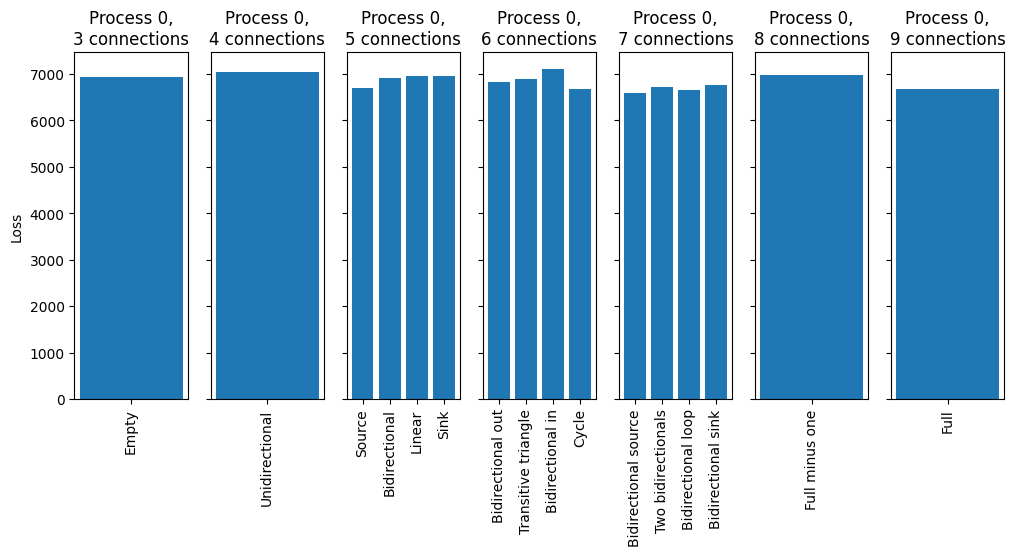

[{3: {'Empty': 6937.807922325446},
  4: {'Unidirectional': 7044.614339592255},
  5: {'Source': 6703.3207496718915,
   'Bidirectional': 6919.406557686045,
   'Linear': 6951.8811621915065,
   'Sink': 6959.643543604895},
  6: {'Bidirectional out': 6834.939335427483,
   'Transitive triangle': 6903.8685101057,
   'Bidirectional in': 7111.9426762711155,
   'Cycle': 6688.250830721748},
  7: {'Bidirectional source': 6588.443189233428,
   'Two bidirectionals': 6727.251415267805,
   'Bidirectional loop': 6654.528860552874,
   'Bidirectional sink': 6771.6060369608485},
  8: {'Full minus one': 6977.880784181051},
  9: {'Full': 6687.6054723374355}}]

In [73]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 5e-8))),
           A=np.array([[0, 0.4, 0.5], [0.5, 0, 0.4], [0.4, 0.5, 0]]))

### Random bidirectional

In [74]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0.5, 0.4], [0.5, 0, 0.3], [0.4, 0.6, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7))))

Process dynamics: [[0.  0.5 0.4]
 [0.5 0.  0.3]
 [0.4 0.6 0. ]]
Eigenvalues: [ 0.89007333+0.j         -0.44503666+0.06459796j -0.44503666-0.06459796j]
Kalman filter M: [[-0.03428466  0.33538319  0.28462765]
 [ 0.35492483 -0.03629621  0.21092639]
 [ 0.26929034  0.40644995 -0.03174902]]
Kalman filter K: [[0.26774713 0.02757833 0.05123873]
 [0.02757833 0.26014094 0.03751174]
 [0.05123873 0.03751174 0.27988447]]
Kalman filter loss: 6085.9137206897285


  0%|                                                                                                                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.36522014 0.         0.        ]
 [0.         0.42699875 0.        ]
 [0.         0.         0.38310417]]
NN K: [[0.40771696 0.1952362  0.22015343]
 [0.18187943 0.32428298 0.18170879]
 [0.2514096  0.2204514  0.42535766]]
NN W: [[ 0.87523713 -0.07131161 -0.10944855]
 [-0.10327103  0.92136538 -0.09618792]
 [-0.15593777 -0.09209967  0.86796347]]
Loss: 7067.499996434812
Testing Empty, Trial 2
NN M: [[0.35584065 0.         0.        ]
 [0.         0.34464046 0.        ]
 [0.         0.         0.39743483]]
NN K: [[0.4383687  0.22381607 0.25986897]
 [0.2189405  0.39567437 0.24412686]
 [0.27172183 0.24054957 0.43449496]]
NN W: [[ 0.87298324 -0.13513851 -0.12080843]
 [-0.1165202   0.88175015 -0.10476341]
 [-0.15608584 -0.1233794   0.8436067 ]]
Loss: 7070.051221276941
Testing Empty, Trial 3


  6%|█████████▌                                                                                                                                              | 1/16 [01:00<15:12, 60.80s/it]

NN M: [[0.33749908 0.         0.        ]
 [0.         0.35357416 0.        ]
 [0.         0.         0.37632096]]
NN K: [[0.42551658 0.21999967 0.26802686]
 [0.1947801  0.37771417 0.20595313]
 [0.21774214 0.20732422 0.37609951]]
NN W: [[ 0.85706622 -0.13274613 -0.1064095 ]
 [-0.119705    0.90995786 -0.08086881]
 [-0.07855223 -0.0787305   0.89215326]]
Loss: 7660.175743406445
Testing Unidirectional, Trial 1
NN M: [[0.38447047 0.         0.        ]
 [0.29711525 0.08737804 0.        ]
 [0.         0.         0.39247676]]
NN K: [[0.37822012 0.17652849 0.21990803]
 [0.1490867  0.36798267 0.15126653]
 [0.20482852 0.16292167 0.33571039]]
NN W: [[ 0.87851928 -0.12346821 -0.06000617]
 [-0.10783004  0.91995478 -0.06753732]
 [-0.05364544 -0.03670345  0.90818133]]
Loss: 7326.871238519147
Testing Unidirectional, Trial 2
NN M: [[0.35062268 0.         0.        ]
 [0.22119187 0.13245804 0.        ]
 [0.         0.         0.33693677]]
NN K: [[0.37623403 0.1910511  0.22381029]
 [0.16327326 0.36026627

 12%|███████████████████                                                                                                                                     | 2/16 [02:01<14:10, 60.74s/it]

NN M: [[0.37564939 0.         0.        ]
 [0.23637374 0.1502023  0.        ]
 [0.         0.         0.35986878]]
NN K: [[0.39249743 0.20381111 0.22301708]
 [0.14372249 0.34564294 0.16077052]
 [0.21657268 0.18815969 0.39109562]]
NN W: [[ 0.86901831 -0.11807272 -0.08927739]
 [-0.08979292  0.92744854 -0.07553741]
 [-0.07956761 -0.04656966  0.88472195]]
Loss: 7183.979522864547
Testing Source, Trial 1
NN M: [[0.36971399 0.         0.        ]
 [0.26835471 0.16035408 0.        ]
 [0.28333891 0.         0.15200516]]
NN K: [[0.42740691 0.21185897 0.23746043]
 [0.14544901 0.34901336 0.17274708]
 [0.20888091 0.16845072 0.40158332]]
NN W: [[ 0.86470084 -0.11523194 -0.1149406 ]
 [-0.1068515   0.91596158 -0.10346749]
 [-0.13135034 -0.07395683  0.88960687]]
Loss: 7368.816217432943
Testing Source, Trial 2
NN M: [[0.37397134 0.         0.        ]
 [0.28854958 0.12855648 0.        ]
 [0.21366248 0.         0.18819025]]
NN K: [[0.39134111 0.19794086 0.24679981]
 [0.12721465 0.33915087 0.14385865]
 [0

 19%|████████████████████████████▌                                                                                                                           | 3/16 [03:02<13:12, 60.96s/it]

NN M: [[0.36028786 0.         0.        ]
 [0.25967104 0.17969423 0.        ]
 [0.280684   0.         0.14813213]]
NN K: [[0.39860389 0.20125466 0.23641301]
 [0.14052013 0.3196538  0.13807005]
 [0.16297076 0.15270048 0.37378592]]
NN W: [[ 0.88076967 -0.09273787 -0.11935025]
 [-0.09718842  0.93256529 -0.08067102]
 [-0.0795994  -0.06856855  0.91277666]]
Loss: 6982.2636017156765
Testing Bidirectional, Trial 1
NN M: [[0.26776305 0.18287588 0.        ]
 [0.20941746 0.21193749 0.        ]
 [0.         0.         0.40011922]]
NN K: [[0.38536065 0.16028442 0.21701912]
 [0.15958692 0.35783559 0.18316365]
 [0.22372407 0.20048538 0.40136894]]
NN W: [[ 0.88236505 -0.12294674 -0.10167891]
 [-0.11826268  0.90573185 -0.09188777]
 [-0.09702638 -0.08859869  0.8643318 ]]
Loss: 6970.158108327436
Testing Bidirectional, Trial 2
NN M: [[0.20929342 0.15334559 0.        ]
 [0.20549098 0.12895968 0.        ]
 [0.         0.         0.37381461]]
NN K: [[0.39963837 0.18560666 0.21505288]
 [0.16360357 0.37594935 

 25%|██████████████████████████████████████                                                                                                                  | 4/16 [04:03<12:10, 60.87s/it]

NN M: [[0.20267591 0.1463496  0.        ]
 [0.14356063 0.17537882 0.        ]
 [0.         0.         0.35779955]]
NN K: [[0.37944683 0.17927551 0.22656702]
 [0.19767774 0.39099605 0.21802228]
 [0.21293769 0.19029859 0.39536398]]
NN W: [[ 0.8966635  -0.10183159 -0.04601668]
 [-0.11891499  0.90052139 -0.06769417]
 [-0.06610331 -0.0662003   0.88426859]]
Loss: 7428.95358889654
Testing Linear, Trial 1
NN M: [[0.39105624 0.         0.        ]
 [0.2816131  0.13703235 0.        ]
 [0.         0.18374032 0.27250787]]
NN K: [[0.36608189 0.17206305 0.21904179]
 [0.12619725 0.31857205 0.10146747]
 [0.20152474 0.19187522 0.35837912]]
NN W: [[ 0.88055506 -0.08166011 -0.0888521 ]
 [-0.05186404  0.9342352  -0.05270496]
 [-0.08552332 -0.09893401  0.89518958]]
Loss: 7178.933320436185
Testing Linear, Trial 2
NN M: [[0.35440776 0.         0.        ]
 [0.27537519 0.17640297 0.        ]
 [0.         0.28381526 0.16415656]]
NN K: [[0.41275106 0.17097289 0.23835986]
 [0.19547758 0.3596747  0.18127694]
 [0.

 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [05:04<11:11, 61.01s/it]

NN M: [[0.38178296 0.         0.        ]
 [0.27383186 0.15018137 0.        ]
 [0.         0.25296934 0.17639155]]
NN K: [[0.38740874 0.18370033 0.23323325]
 [0.16953559 0.36044725 0.15551656]
 [0.21160273 0.19559037 0.40282235]]
NN W: [[ 0.88138406 -0.0906716  -0.10188311]
 [-0.09136877  0.91236099 -0.11105873]
 [-0.09240442 -0.10748767  0.89085737]]
Loss: 6778.109753547213
Testing Sink, Trial 1
NN M: [[0.37116301 0.         0.        ]
 [0.10789017 0.08466163 0.23727061]
 [0.         0.         0.37091027]]
NN K: [[0.3810546  0.16824577 0.23017283]
 [0.12978878 0.33127121 0.1473986 ]
 [0.23144732 0.19744081 0.43091604]]
NN W: [[ 0.90813357 -0.08557226 -0.10120059]
 [-0.10091314  0.92865229 -0.08812574]
 [-0.10798068 -0.09868263  0.87177623]]
Loss: 6910.663540569627
Testing Sink, Trial 2
NN M: [[0.38756883 0.         0.        ]
 [0.19276528 0.0639229  0.16771291]
 [0.         0.         0.37684791]]
NN K: [[0.38765875 0.17733671 0.25559468]
 [0.11387843 0.32577148 0.14418176]
 [0.234

 38%|█████████████████████████████████████████████████████████                                                                                               | 6/16 [06:05<10:10, 61.08s/it]

NN M: [[0.33790871 0.         0.        ]
 [0.16112269 0.06200265 0.19185399]
 [0.         0.         0.39065877]]
NN K: [[0.42578362 0.19503515 0.25820284]
 [0.13913834 0.34717928 0.16566524]
 [0.24279756 0.20038244 0.43278595]]
NN W: [[ 0.87453979 -0.08292579 -0.11946483]
 [-0.08381557  0.91334727 -0.11157169]
 [-0.12690145 -0.11311762  0.86727174]]
Loss: 6972.47359945324
Testing Bidirectional out, Trial 1
NN M: [[0.20845798 0.24639138 0.        ]
 [0.18701643 0.20094855 0.        ]
 [0.25432093 0.         0.18205977]]
NN K: [[0.36904368 0.2246077  0.24197925]
 [0.173693   0.40036642 0.23370927]
 [0.18526167 0.1748075  0.40258604]]
NN W: [[ 0.85848009 -0.1389046  -0.12187958]
 [-0.12047592  0.89374713 -0.13229061]
 [-0.10240615 -0.09477926  0.88651936]]
Loss: 6892.851591288543
Testing Bidirectional out, Trial 2
NN M: [[0.24436671 0.19199478 0.        ]
 [0.15569295 0.23755883 0.        ]
 [0.18197396 0.         0.25205791]]
NN K: [[0.36413044 0.19370073 0.21515731]
 [0.15827724 0.371

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 7/16 [07:07<09:09, 61.08s/it]

NN M: [[0.20926156 0.21830558 0.        ]
 [0.19725468 0.17873875 0.        ]
 [0.29073425 0.         0.15009842]]
NN K: [[0.38758558 0.18448158 0.2038741 ]
 [0.16586639 0.37857433 0.19660688]
 [0.18064844 0.1642419  0.38375685]]
NN W: [[ 0.90242476 -0.11963473 -0.1059475 ]
 [-0.10787208  0.91511977 -0.0954884 ]
 [-0.09372816 -0.09338447  0.90821169]]
Loss: 6635.653231707647
Testing Transitive triangle, Trial 1
NN M: [[0.37876469 0.         0.        ]
 [0.25270514 0.19038613 0.        ]
 [0.16507322 0.2246236  0.04664973]]
NN K: [[0.38696917 0.16995182 0.23972656]
 [0.19372579 0.35341525 0.19992338]
 [0.18357558 0.15970881 0.4171332 ]]
NN W: [[ 0.8934508  -0.07114022 -0.11896229]
 [-0.11295741  0.87415597 -0.12797383]
 [-0.08998098 -0.07792298  0.88323986]]
Loss: 6724.158276161671
Testing Transitive triangle, Trial 2
NN M: [[0.36532197 0.         0.        ]
 [0.22393198 0.18419133 0.        ]
 [0.1817356  0.15804315 0.13426661]]
NN K: [[0.38033294 0.2077828  0.25966003]
 [0.15140544 

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 8/16 [08:08<08:09, 61.17s/it]

NN M: [[0.37470103 0.         0.        ]
 [0.23307372 0.19202493 0.        ]
 [0.20282228 0.19732464 0.07690989]]
NN K: [[0.41522763 0.20614589 0.22715838]
 [0.17197769 0.35214507 0.14364413]
 [0.20874327 0.18339271 0.40192287]]
NN W: [[ 0.87459202 -0.10217225 -0.11572076]
 [-0.10084007  0.9139747  -0.09272854]
 [-0.11549327 -0.11579195  0.88631456]]
Loss: 6964.794226960081
Testing Bidirectional in, Trial 1
NN M: [[-0.0286801   0.23416457  0.22953044]
 [ 0.20152344  0.14655455  0.        ]
 [ 0.          0.          0.40356333]]
NN K: [[0.39304008 0.11225084 0.17915003]
 [0.19990898 0.38775713 0.21422567]
 [0.20074455 0.17844918 0.40173217]]
NN W: [[ 0.90134825 -0.09962448 -0.06897833]
 [-0.13212374  0.8956024  -0.07713802]
 [-0.08862205 -0.08746163  0.88395579]]
Loss: 7088.113085184345
Testing Bidirectional in, Trial 2
NN M: [[0.14690579 0.18176569 0.14622813]
 [0.21516206 0.12408777 0.        ]
 [0.         0.         0.37585886]]
NN K: [[0.31734725 0.19179611 0.14124167]
 [0.154997

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/16 [09:09<07:08, 61.18s/it]

NN M: [[0.06605967 0.11779822 0.24333231]
 [0.1538946  0.2170863  0.        ]
 [0.         0.         0.40061101]]
NN K: [[0.37351922 0.13628723 0.19410639]
 [0.18352958 0.37835024 0.19866167]
 [0.20961011 0.18742349 0.38806041]]
NN W: [[ 0.9058265  -0.09279018 -0.09122672]
 [-0.10528325  0.9121914  -0.10326779]
 [-0.09127022 -0.09188888  0.89284553]]
Loss: 6891.8258548966
Testing Cycle, Trial 1
NN M: [[0.1878958  0.         0.19368151]
 [0.21442074 0.19188351 0.        ]
 [0.         0.2135787  0.22634932]]
NN K: [[0.39267536 0.16903483 0.22995087]
 [0.17952785 0.3831241  0.18257003]
 [0.21437241 0.20641393 0.42560555]]
NN W: [[ 0.89050296 -0.08945727 -0.11144806]
 [-0.10861734  0.91285471 -0.11880287]
 [-0.12633988 -0.11490691  0.87976301]]
Loss: 6797.285625982139
Testing Cycle, Trial 2
NN M: [[0.190473   0.         0.20355455]
 [0.14602389 0.23962052 0.        ]
 [0.         0.20314783 0.22312769]]
NN K: [[0.37528648 0.16336098 0.19552737]
 [0.18113719 0.3621783  0.18718352]
 [0.218

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10/16 [10:10<06:06, 61.14s/it]

NN M: [[0.21322195 0.         0.19139589]
 [0.23877847 0.15347294 0.        ]
 [0.         0.27303311 0.16636125]]
NN K: [[0.38830933 0.16800499 0.2105834 ]
 [0.17948341 0.37203429 0.18167331]
 [0.19213975 0.16503073 0.39600239]]
NN W: [[ 0.89824994 -0.10887022 -0.09847186]
 [-0.09546779  0.91519505 -0.12093517]
 [-0.10121986 -0.07582457  0.90259429]]
Loss: 6727.588976711963
Testing Bidirectional source, Trial 1
NN M: [[0.20808044 0.25245054 0.        ]
 [0.31129834 0.07064716 0.        ]
 [0.13619206 0.14061558 0.18924103]]
NN K: [[0.36906542 0.16432666 0.22238963]
 [0.15157262 0.36397038 0.19379052]
 [0.23373846 0.18714764 0.37646968]]
NN W: [[ 0.89529475 -0.11660171 -0.11060189]
 [-0.0905383   0.91265267 -0.10164775]
 [-0.11465216 -0.09955573  0.87016603]]
Loss: 6950.235894978093
Testing Bidirectional source, Trial 2
NN M: [[0.28057676 0.17563152 0.        ]
 [0.28751771 0.08368558 0.        ]
 [0.26483863 0.10466484 0.10730044]]
NN K: [[0.33673895 0.20125979 0.24771057]
 [0.1387846

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 11/16 [11:11<05:05, 61.15s/it]

NN M: [[0.11239242 0.36064769 0.        ]
 [0.2490453  0.14148894 0.        ]
 [0.25186757 0.12168279 0.06308308]]
NN K: [[0.35593904 0.15371531 0.16697057]
 [0.16645126 0.36332919 0.22644267]
 [0.17836743 0.15066758 0.39877   ]]
NN W: [[ 0.91169333 -0.10357386 -0.0955316 ]
 [-0.10972049  0.89990437 -0.11704207]
 [-0.09572619 -0.08179738  0.91815839]]
Loss: 6457.452661128736
Testing Two bidirectionals, Trial 1
NN M: [[0.16416362 0.13568233 0.19186753]
 [0.19300278 0.18479131 0.        ]
 [0.20470821 0.         0.24235136]]
NN K: [[0.35125327 0.18084517 0.15743812]
 [0.14454497 0.34313486 0.13590962]
 [0.20872008 0.20046572 0.38123274]]
NN W: [[ 0.888061   -0.10893898 -0.10452625]
 [-0.06512562  0.94201614 -0.06161311]
 [-0.13476621 -0.10733175  0.89395969]]
Loss: 6832.818707664567
Testing Two bidirectionals, Trial 2
NN M: [[0.05115085 0.19349243 0.17517522]
 [0.17658076 0.25386205 0.        ]
 [0.14804331 0.         0.27121681]]
NN K: [[0.40260135 0.17621848 0.18821066]
 [0.16308929 0.

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 12/16 [12:12<04:04, 61.15s/it]

NN M: [[0.04017287 0.26227745 0.12942516]
 [0.21079316 0.18162807 0.        ]
 [0.12880051 0.         0.27312802]]
NN K: [[0.39455394 0.17703797 0.19426468]
 [0.17321668 0.38438565 0.18650328]
 [0.23791932 0.22912187 0.42431926]]
NN W: [[ 0.89546725 -0.09772243 -0.11267804]
 [-0.10436291  0.91242436 -0.10984551]
 [-0.13261292 -0.11899601  0.87928583]]
Loss: 6806.954827001015
Testing Bidirectional loop, Trial 1
NN M: [[0.27135265 0.15092232 0.        ]
 [0.17204261 0.02009064 0.18652017]
 [0.25711375 0.         0.19117114]]
NN K: [[0.40887825 0.21873394 0.23660364]
 [0.1474108  0.36896468 0.17134732]
 [0.2411759  0.20373732 0.40141725]]
NN W: [[ 0.8712794  -0.13713556 -0.12411344]
 [-0.09923108  0.90708611 -0.091796  ]
 [-0.13763216 -0.12480782  0.86879984]]
Loss: 7167.378930725538
Testing Bidirectional loop, Trial 2
NN M: [[0.23105202 0.17111015 0.        ]
 [0.16390266 0.05800518 0.17538114]
 [0.18824222 0.         0.24091928]]
NN K: [[0.41762659 0.19366215 0.23800715]
 [0.16926017 0.

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13/16 [13:13<03:03, 61.03s/it]

NN M: [[0.19532952 0.21333474 0.        ]
 [0.21293729 0.0841033  0.11412257]
 [0.17407902 0.         0.27783672]]
NN K: [[0.40498824 0.18562098 0.23169315]
 [0.16382519 0.38413647 0.20517033]
 [0.19348923 0.18156619 0.39040959]]
NN W: [[ 0.89129855 -0.12379728 -0.11026721]
 [-0.1267524   0.89185876 -0.10568028]
 [-0.10748395 -0.11425906  0.89953507]]
Loss: 6925.819705588794
Testing Bidirectional sink, Trial 1
NN M: [[0.3488981  0.         0.        ]
 [0.23452053 0.09247191 0.06093234]
 [0.22468432 0.13667699 0.07965662]]
NN K: [[0.42292613 0.21468409 0.24086004]
 [0.18395091 0.35559319 0.17684326]
 [0.19976516 0.16432795 0.38769304]]
NN W: [[ 0.88279543 -0.11628    -0.11449185]
 [-0.08631098  0.89773927 -0.10801563]
 [-0.09642753 -0.10321818  0.91265676]]
Loss: 6993.236318848593
Testing Bidirectional sink, Trial 2
NN M: [[0.35032002 0.         0.        ]
 [0.22996265 0.04953659 0.1221645 ]
 [0.08574769 0.14794595 0.22960372]]
NN K: [[0.38893838 0.16568393 0.21136358]
 [0.15762956 0.

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14/16 [14:14<02:01, 60.98s/it]

NN M: [[0.34474099 0.         0.        ]
 [0.12203551 0.14984741 0.08590927]
 [0.18397444 0.17804141 0.19756555]]
NN K: [[0.39110998 0.16559226 0.21490625]
 [0.20410686 0.41352622 0.19516522]
 [0.10861519 0.17494343 0.27430876]]
NN W: [[ 0.90901033 -0.07671822 -0.06932621]
 [-0.11685706  0.886629   -0.09844715]
 [-0.02376758 -0.08657546  0.88230905]]
Loss: 7231.605658803278
Testing Full minus one, Trial 1
NN M: [[0.06080267 0.24339303 0.10298411]
 [0.17153966 0.19037292 0.        ]
 [0.1656463  0.18871135 0.05961583]]
NN K: [[0.3843026  0.15098268 0.24836013]
 [0.20417651 0.41027607 0.23223318]
 [0.20717336 0.16783103 0.39484084]]
NN W: [[ 0.88359011 -0.095209   -0.10564541]
 [-0.13285181  0.89157799 -0.12061808]
 [-0.08219568 -0.09094793  0.90233946]]
Loss: 6847.27238151986
Testing Full minus one, Trial 2
NN M: [[0.04619091 0.1482331  0.21961328]
 [0.12886778 0.27329126 0.        ]
 [0.04441856 0.2864811  0.21045085]]
NN K: [[0.34906927 0.15122766 0.15754168]
 [0.17629605 0.37721354 

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15/16 [15:15<01:01, 61.02s/it]

NN M: [[0.24159497 0.06514226 0.21230659]
 [0.24992352 0.09031978 0.        ]
 [0.24026906 0.10842817 0.18792724]]
NN K: [[0.29851509 0.13631183 0.15991571]
 [0.12321796 0.34353187 0.13167105]
 [0.13129016 0.18632058 0.3070449 ]]
NN W: [[ 0.90994608 -0.07809068 -0.11238266]
 [-0.05300674  0.94935938 -0.03082882]
 [-0.09616115 -0.08051424  0.90913099]]
Loss: 6560.908870223511
Testing Full, Trial 1
NN M: [[0.15857664 0.17267328 0.1092421 ]
 [0.04122012 0.18117815 0.15621011]
 [0.24755884 0.06590035 0.14086501]]
NN K: [[0.31273694 0.1993456  0.22233703]
 [0.15056543 0.36604873 0.1683717 ]
 [0.1934421  0.19086393 0.34800645]]
NN W: [[ 0.89341132 -0.07894766 -0.11256315]
 [-0.08465823  0.93626203 -0.08963977]
 [-0.0884916  -0.08246231  0.89592181]]
Loss: 6725.148557369996
Testing Full, Trial 2
NN M: [[0.07774589 0.21593126 0.16582896]
 [0.19885237 0.16033392 0.02366649]
 [0.18193618 0.09059771 0.22675578]]
NN K: [[0.37560018 0.17645182 0.21601462]
 [0.21270724 0.3935906  0.17976293]
 [0.208

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [16:17<00:00, 61.07s/it]

NN M: [[0.11431129 0.20341785 0.09130933]
 [0.09701996 0.11994718 0.18377795]
 [0.16747581 0.13870537 0.1212773 ]]
NN K: [[0.38833835 0.17802485 0.20306302]
 [0.19832841 0.3654318  0.22268646]
 [0.24547579 0.20106071 0.3865411 ]]
NN W: [[ 0.91220561 -0.11235023 -0.10349652]
 [-0.12238097  0.88671524 -0.1242006 ]
 [-0.11278472 -0.10284081  0.88783628]]
Loss: 7012.342474577435


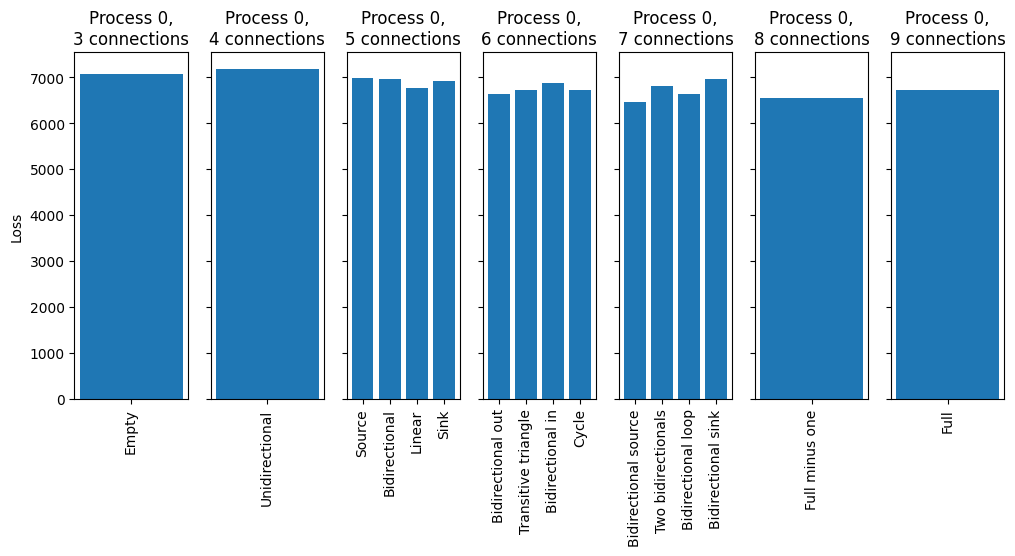

[{3: {'Empty': 7067.499996434812},
  4: {'Unidirectional': 7183.979522864547},
  5: {'Source': 6982.2636017156765,
   'Bidirectional': 6970.158108327436,
   'Linear': 6778.109753547213,
   'Sink': 6910.663540569627},
  6: {'Bidirectional out': 6635.653231707647,
   'Transitive triangle': 6724.158276161671,
   'Bidirectional in': 6887.451607754466,
   'Cycle': 6727.588976711963},
  7: {'Bidirectional source': 6457.452661128736,
   'Two bidirectionals': 6806.954827001015,
   'Bidirectional loop': 6633.1561434579535,
   'Bidirectional sink': 6972.997857178527},
  8: {'Full minus one': 6560.908870223511},
  9: {'Full': 6725.148557369996}}]

In [75]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7))),
           A=np.array([[0, 0.5, 0.4], [0.5, 0, 0.3], [0.4, 0.6, 0]]))

# Exploration 5

What if we start with a large neural network and prune down the edges which are least strong? Does the resulting network show patterns in neural connectivity?

In [27]:
def prune(proc, nn, num_vals=200, num_trials=500):
    eps_vals = np.linspace(0, 0.2, num_vals)
    prop_nonzeros = np.zeros(num_vals)
    losses = np.zeros(num_vals)
    simulations_xs = np.zeros((num_trials, proc.num_steps, proc.n))
    simulations_ys = np.zeros((num_trials, proc.num_steps, proc.m))
    
    for i in range(num_trials):
        _, xs, ys = proc.simulate()
        simulations_xs[i] = xs
        simulations_ys[i] = ys
    
    for i in tqdm.tqdm(range(num_vals)):
        pruned_nn = NeuralNet(nn.M * (np.abs(nn.M)>eps_vals[i]), nn.K, nn.W, proc.x0)
        prop_nonzeros[i] = np.mean(np.abs(nn.M)>eps_vals[i])
        
        Ls = np.zeros(num_trials)
        for j in range(num_trials):
            _, _, xhats = pruned_nn.forward(simulations_ys[j])
            Ls[j] = proc.calc_loss(simulations_xs[j], xhats)
        losses[i] = np.mean(Ls)

    return eps_vals, prop_nonzeros, losses

In [39]:
def logistic(x, L, k, x0, y0):
    return L/(1+np.exp(-k*(x-x0))) + y0

def plot_pruning(eps_vals, prop_nonzeros, losses):
    percent_nonzero = prop_nonzeros * 100
    
    plt.plot(eps_vals, percent_nonzero)
    plt.xlabel('Threshold')
    plt.ylabel('Percentage of entries nonzero')
    plt.title('Extent of pruning')
    plt.show()

    percent_zero = 100 - percent_nonzero
    
    log_loss = np.log10(losses)
    #popt, _ = scipy.optimize.curve_fit(logistic, percent_zero, log_loss, maxfev=5000)
    #_, _, prop0, _ = popt
    #logistic_fit = logistic(percent_zero, *popt)
    #eps0 = eps_vals[(percent_zero > prop0).nonzero()[0][0]]
    
    plt.plot(percent_zero, log_loss, label='Data')
    #plt.plot(percent_zero, logistic_fit, label='Logistic fit')
    #plt.plot(prop0, logistic(prop0, *popt), marker='o', label='Inflection point')
    plt.xlabel('Percentage of entries removed')
    plt.ylabel('Log Loss')
    plt.title('Log loss while pruning')
    plt.legend()
    plt.show()
    
    #print(f'Inflection point at {prop0}%, eps = {eps0}')

def get_pruned_M(M, eps0):
    return 1 * (np.abs(M)>eps0)

In [50]:
def count_two_neuron_configs(M):
    config_count = OrderedDict((k,0) for k in two_neuron_configs_all_loops)
    lookup_dict = {
        (0, 0): 'Empty',
        (0, 1): 'Unidirectional',
        (1, 0): 'Unidirectional',
        (1, 1): 'Bidirectional'
    }
    for i, j in itertools.combinations(range(M.shape[0]), 2):
        config_count[lookup_dict[M[i,j], M[j,i]]] += 1
    return config_count

def count_three_neuron_configs(M):
    config_count = OrderedDict((k,0) for k in three_neuron_configs_all_loops)
    lookup_dict = {
        (0, 0, 0, 0, 0, 0): 'Empty',
        (0, 0, 0, 0, 0, 1): 'Unidirectional',
        (0, 0, 0, 0, 1, 0): 'Unidirectional',
        (0, 0, 0, 0, 1, 1): 'Bidirectional',
        (0, 0, 0, 1, 0, 0): 'Unidirectional',
        (0, 0, 0, 1, 0, 1): 'Sink',
        (0, 0, 0, 1, 1, 0): 'Linear',
        (0, 0, 0, 1, 1, 1): 'Bidirectional in',
        (0, 0, 1, 0, 0, 0): 'Unidirectional',
        (0, 0, 1, 0, 0, 1): 'Linear',
        (0, 0, 1, 0, 1, 0): 'Source',
        (0, 0, 1, 0, 1, 1): 'Bidirectional out',
        (0, 0, 1, 1, 0, 0): 'Bidirectional',
        (0, 0, 1, 1, 0, 1): 'Bidirectional in',
        (0, 0, 1, 1, 1, 0): 'Bidirectional out',
        (0, 0, 1, 1, 1, 1): 'Two bidirectionals',
        (0, 1, 0, 0, 0, 0): 'Unidirectional',
        (0, 1, 0, 0, 0, 1): 'Linear',
        (0, 1, 0, 0, 1, 0): 'Sink',
        (0, 1, 0, 0, 1, 1): 'Bidirectional in',
        (0, 1, 0, 1, 0, 0): 'Source',
        (0, 1, 0, 1, 0, 1): 'Transitive triangle',
        (0, 1, 0, 1, 1, 0): 'Transitive triangle',
        (0, 1, 0, 1, 1, 1): 'Bidirectional sink',
        (0, 1, 1, 0, 0, 0): 'Linear',
        (0, 1, 1, 0, 0, 1): 'Cycle',
        (0, 1, 1, 0, 1, 0): 'Transitive triangle',
        (0, 1, 1, 0, 1, 1): 'Bidirectional loop',
        (0, 1, 1, 1, 0, 0): 'Bidirectional out',
        (0, 1, 1, 1, 0, 1): 'Bidirectional loop',
        (0, 1, 1, 1, 1, 0): 'Bidirectional source',
        (0, 1, 1, 1, 1, 1): 'Full minus one',
        (1, 0, 0, 0, 0, 0): 'Unidirectional',
        (1, 0, 0, 0, 0, 1): 'Source',
        (1, 0, 0, 0, 1, 0): 'Linear',
        (1, 0, 0, 0, 1, 1): 'Bidirectional out',
        (1, 0, 0, 1, 0, 0): 'Linear',
        (1, 0, 0, 1, 0, 1): 'Transitive triangle',
        (1, 0, 0, 1, 1, 0): 'Cycle',
        (1, 0, 0, 1, 1, 1): 'Bidirectional loop',
        (1, 0, 1, 0, 0, 0): 'Sink',
        (1, 0, 1, 0, 0, 1): 'Transitive triangle',
        (1, 0, 1, 0, 1, 0): 'Transitive triangle',
        (1, 0, 1, 0, 1, 1): 'Bidirectional source',
        (1, 0, 1, 1, 0, 0): 'Bidirectional in',
        (1, 0, 1, 1, 0, 1): 'Bidirectional sink',
        (1, 0, 1, 1, 1, 0): 'Bidirectional loop',
        (1, 0, 1, 1, 1, 1): 'Full minus one',
        (1, 1, 0, 0, 0, 0): 'Bidirectional',
        (1, 1, 0, 0, 0, 1): 'Bidirectional out',
        (1, 1, 0, 0, 1, 0): 'Bidirectional in',
        (1, 1, 0, 0, 1, 1): 'Two bidirectionals',
        (1, 1, 0, 1, 0, 0): 'Bidirectional out',
        (1, 1, 0, 1, 0, 1): 'Bidirectional source',
        (1, 1, 0, 1, 1, 0): 'Bidirectional loop',
        (1, 1, 0, 1, 1, 1): 'Full minus one',
        (1, 1, 1, 0, 0, 0): 'Bidirectional in',
        (1, 1, 1, 0, 0, 1): 'Bidirectional loop',
        (1, 1, 1, 0, 1, 0): 'Bidirectional sink',
        (1, 1, 1, 0, 1, 1): 'Full minus one',
        (1, 1, 1, 1, 0, 0): 'Two bidirectionals',
        (1, 1, 1, 1, 0, 1): 'Full minus one',
        (1, 1, 1, 1, 1, 0): 'Full minus one',
        (1, 1, 1, 1, 1, 1): 'Full'
    }
    for i, j, k in itertools.combinations(range(M.shape[0]), 3):
        config_count[lookup_dict[M[i,j], M[j,i], M[i,k], M[k,i], M[j,k], M[k,j]]] += 1
    return config_count

def generate_erdos_renyi_adj_matrix(rng, n, m):
    M = np.zeros(n**2)
    M[:m] = 1
    rng.shuffle(M)
    M = np.reshape(M, (n,n))
    return M

def plot_neuron_config_dist(pruned_M_supports):
    num_ER_trials_per = 20
    M_two_neuron_counts = []
    M_three_neuron_counts = []
    null_two_counts = []
    null_three_counts = []
    for M in pruned_M_supports:
        M_two_neuron_counts.append(list(count_two_neuron_configs(M).values()))
        M_three_neuron_counts.append(list(count_three_neuron_configs(M).values()))

        n = M.shape[0]
        m = np.count_nonzero(M)
        ER_two_neuron_counts = np.zeros((num_ER_trials_per, len(two_neuron_configs_all_loops)))
        ER_three_neuron_counts = np.zeros((num_ER_trials_per, len(three_neuron_configs_all_loops)))
        for i in range(num_ER_trials_per):
            ER_adj = generate_erdos_renyi_adj_matrix(rng, n, m)
            ER_two_neuron_counts[i] = list(count_two_neuron_configs(ER_adj).values())
            ER_three_neuron_counts[i] = list(count_three_neuron_configs(ER_adj).values())
        null_two_counts.append(ER_two_neuron_counts)
        null_three_counts.append(ER_three_neuron_counts)

    M_two_neuron_counts = np.vstack(M_two_neuron_counts)
    M_three_neuron_counts = np.vstack(M_three_neuron_counts)
    null_two_counts = np.vstack(null_two_counts)
    null_three_counts = np.vstack(null_three_counts)
    
    xticks = np.arange(len(two_neuron_configs_all_loops))+1
    plt.plot(np.tile(xticks, null_two_counts.shape[0]),
             null_two_counts.flatten(),
             alpha=0.3, marker='o', linestyle='none', label='Erdős–Rényi doublet counts')
    plt.plot(np.tile(xticks, M_two_neuron_counts.shape[0]),
             M_two_neuron_counts.flatten(),
             marker='o', linestyle='none', label='RNN doublet counts')
    plt.title('Pruned matrix doublet counts')
    plt.ylabel('Count')
    plt.xticks(xticks, two_neuron_configs_all_loops, rotation=90)
    plt.legend()
    plt.show()
    
    xticks = np.arange(len(three_neuron_configs_all_loops))+1
    plt.plot(np.tile(xticks, null_three_counts.shape[0]),
             null_three_counts.flatten(),
             alpha=0.3, marker='o', linestyle='none', label='Erdős–Rényi triplet counts')
    plt.plot(np.tile(xticks, M_three_neuron_counts.shape[0]),
             M_three_neuron_counts.flatten(),
             marker='o', linestyle='none', label='RNN triplet counts')
    plt.title('Pruned matrix triplet counts')
    plt.ylabel('Count')
    plt.xticks(xticks, three_neuron_configs_all_loops, rotation=90)
    plt.legend()
    plt.show()

def test_dynamics_matrix(rng, A_gen_fn, etas, n=50, batch_size=40, num_trials=5):
    As = []
    procs = []
    nns = []
    eps_vals = None
    props_nonzeros = []
    losses = []
    for i in range(num_trials):
        A = A_gen_fn(rng, n)
        proc = mk_nd_proc(rng, n, A=A)
        nn = NeuralNet(0.1*mk_rand_matrix(rng, n), 0.1*mk_rand_matrix(rng, n), np.eye(n), proc.x0)
        _ = nn.train(etas, batch_size, proc, print_loss=False, progress_bar=True)
        e_vals, prop_nonzeros, Ls = prune(proc, nn)
        plot_pruning(e_vals, prop_nonzeros, Ls)
        As.append(A)
        procs.append(proc)
        nns.append(nn)
        eps_vals = e_vals
        props_nonzeros.append(prop_nonzeros)
        losses.append(Ls)
    return As, procs, nns, eps_vals, props_nonzeros, losses

def plot_pruned_motif_dist(prop, eps_vals, props_nonzeros, nns):
    pruned_M_supports = []
    for prop_nonzeros, nn in zip(props_nonzeros, nns):
        eps = eps_vals[(prop_nonzeros < prop).nonzero()[0][0]]
        pruned_M_supports.append(get_pruned_M(nn.M, eps))
    plot_neuron_config_dist(pruned_M_supports)


100%|███████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.25it/s]


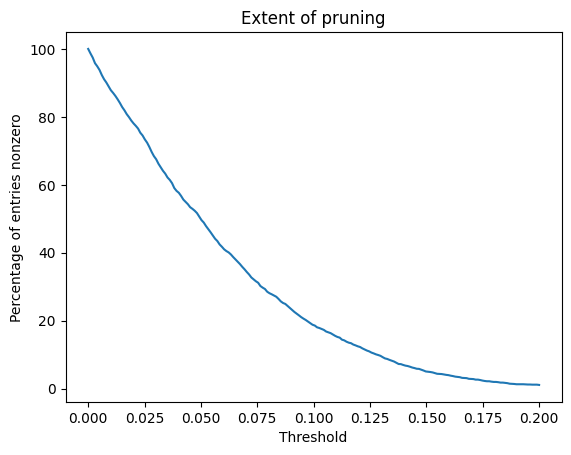

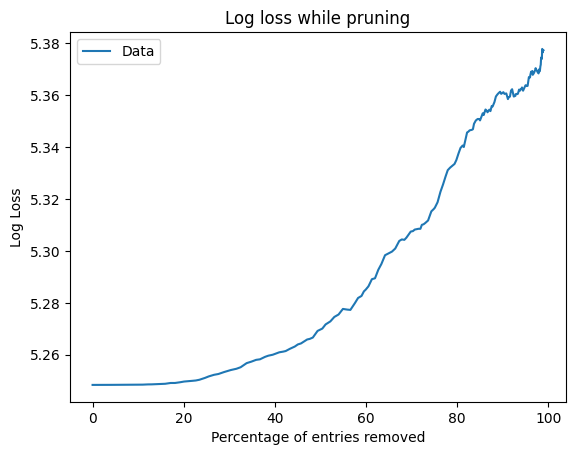

100%|███████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.35it/s]


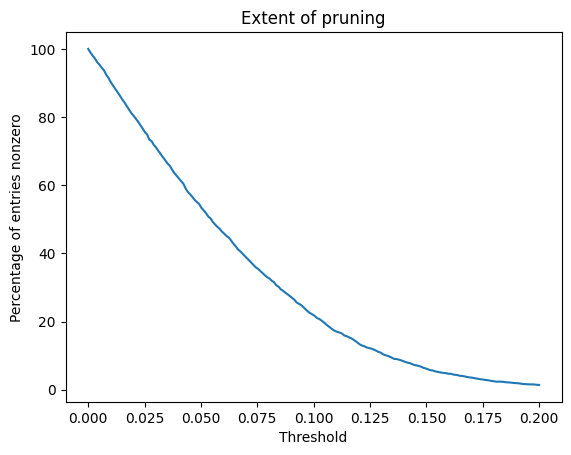

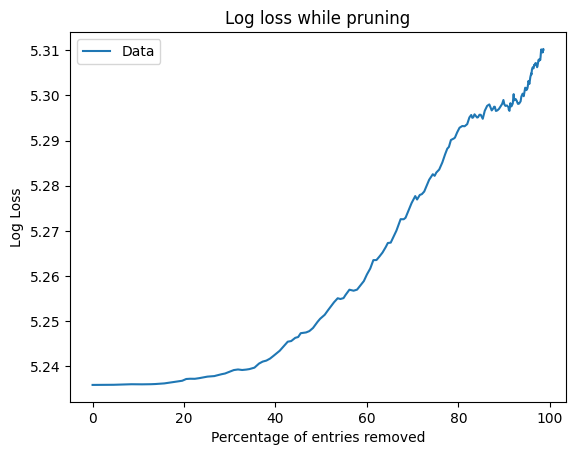

100%|███████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.85it/s]


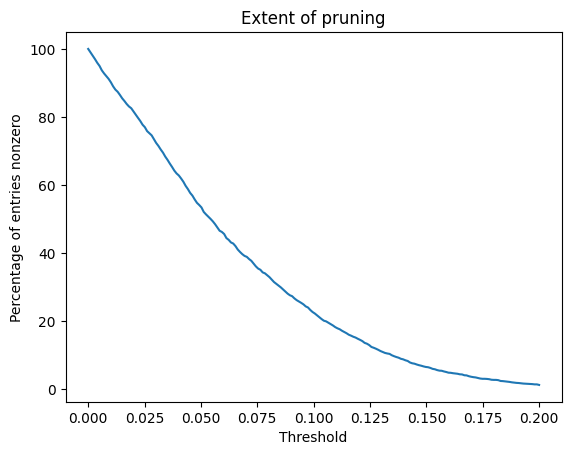

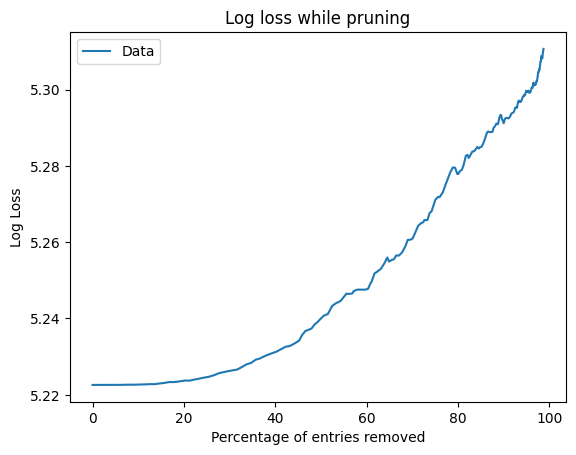

100%|███████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.83it/s]


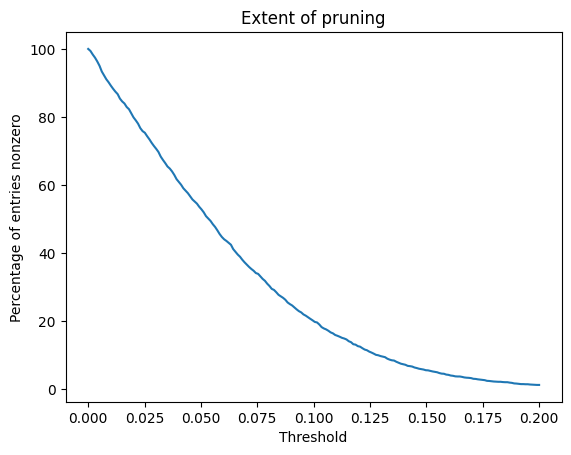

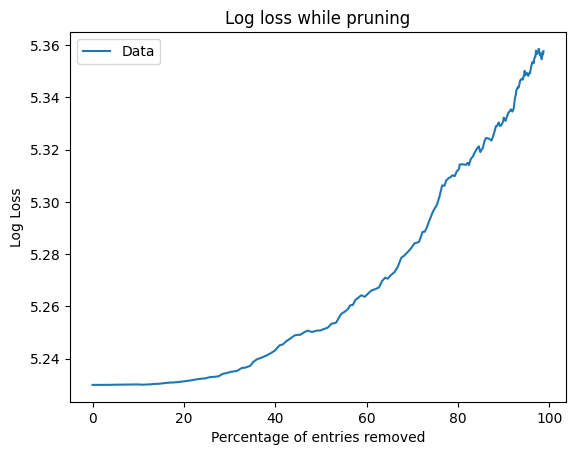

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.76it/s]


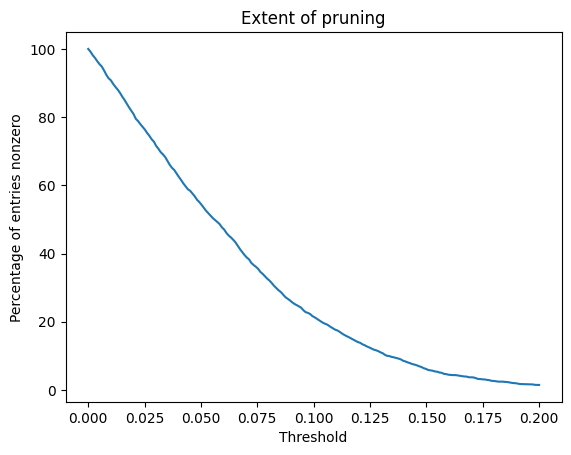

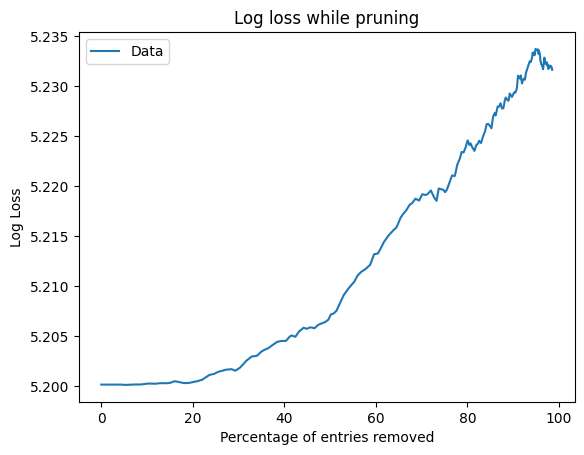

In [41]:
def gen_rand_dynamics_matrix(rng, n):
    A = mk_rand_matrix(rng, n)
    return A / (1.1*highest_eig(A))

As_rand, procs_rand, nns_rand, eps_vals_rand, props_nonzeros_rand, losses_rand = (
    test_dynamics_matrix(rng, gen_rand_dynamics_matrix,
                         np.concatenate((np.full(100, 3e-7), np.full(50, 1e-7)))))

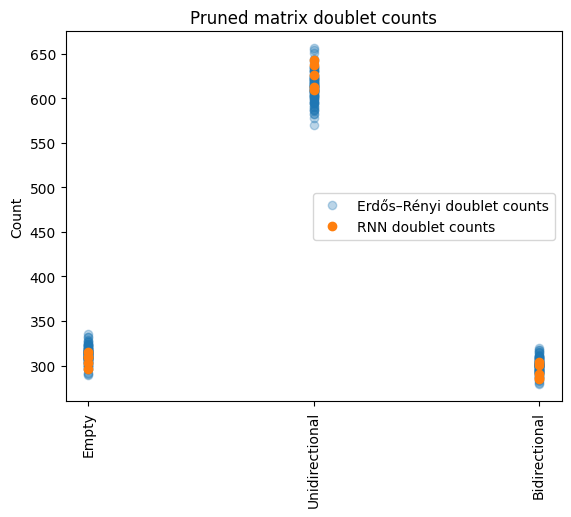

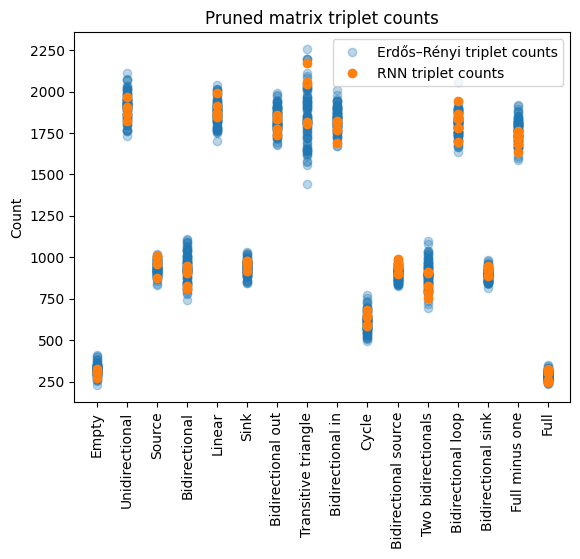

In [51]:
plot_pruned_motif_dist(0.5, eps_vals_rand, props_nonzeros_rand, nns_rand)

There are no discernible patterns in this network structure! It is not significantly different in its connectivity statistics for groups of two or three neurons from an Erdős–Rényi random graph.

What if instead of making the dynamics matrix a random matrix, we make it a diagonal matrix?

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.72it/s]


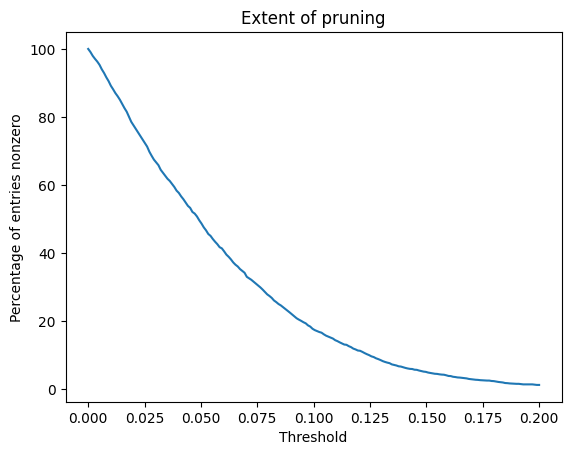

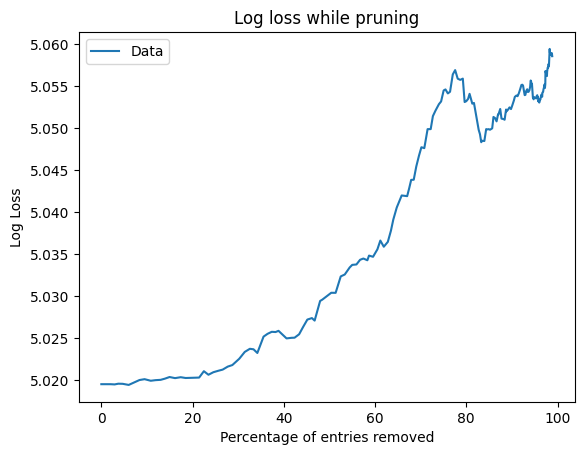

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.59it/s]


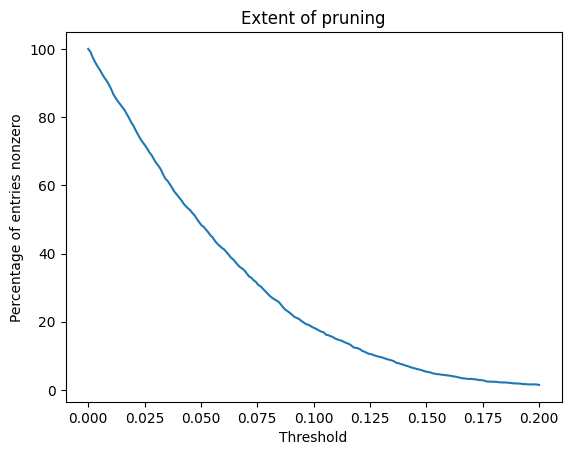

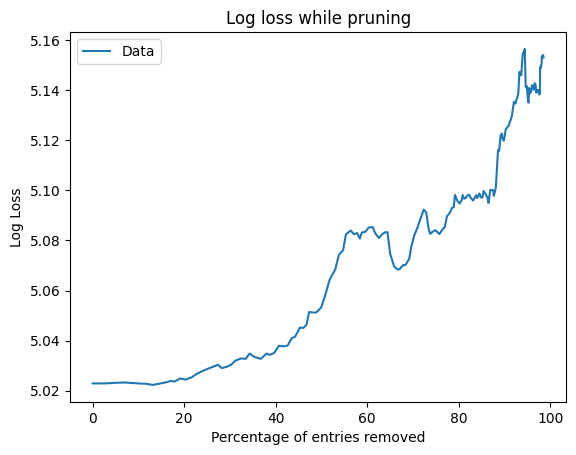

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.59it/s]


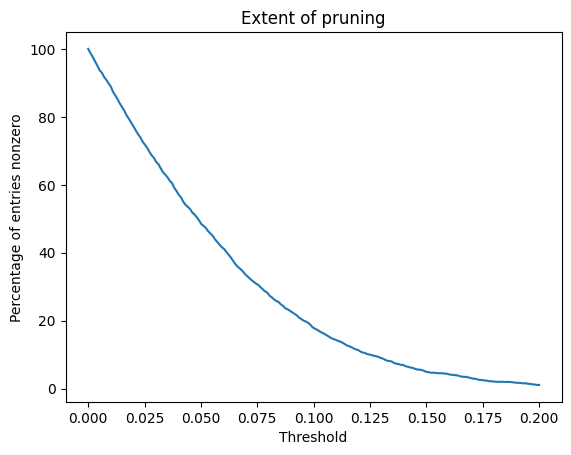

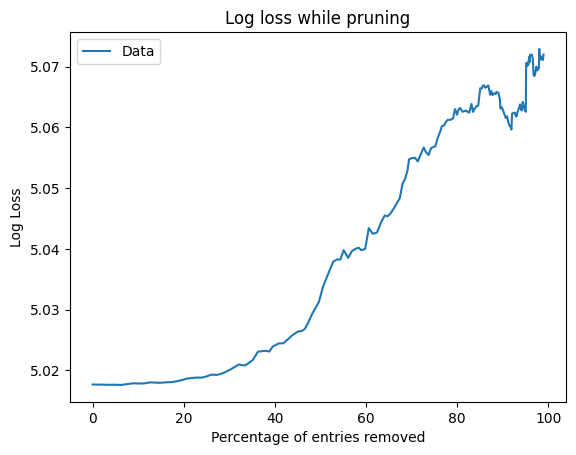

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.65it/s]


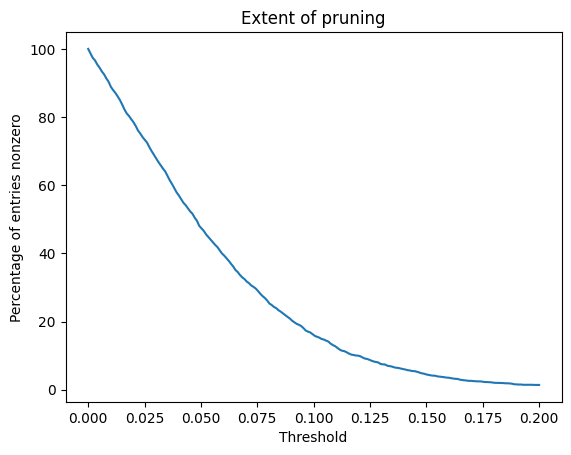

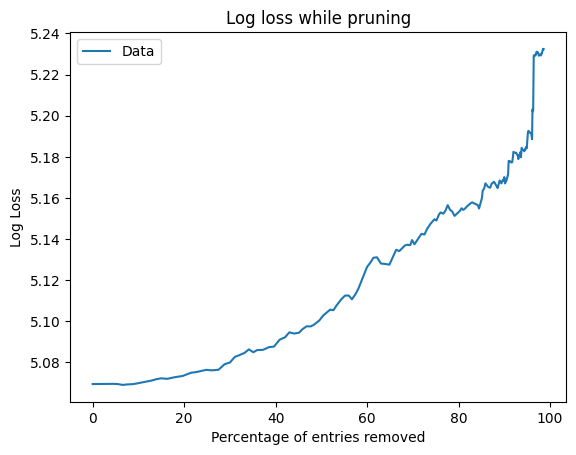

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.60it/s]


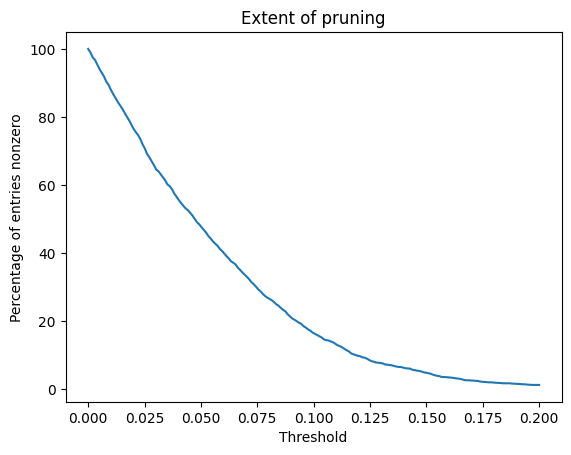

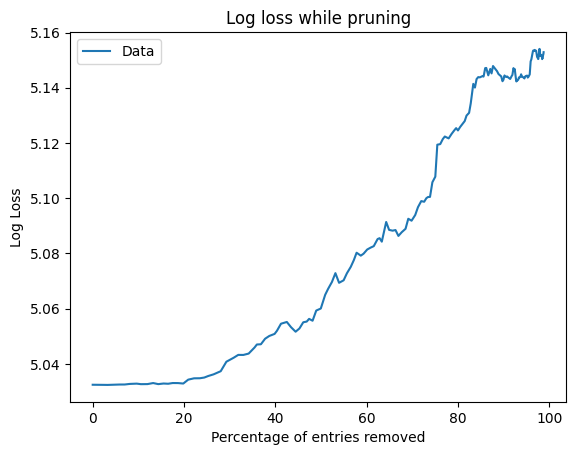

In [53]:
def gen_diag_dynamics_matrix(rng, n):
    return np.diag(rng.uniform(-1, 1, n))

As_diag, procs_diag, nns_diag, eps_vals_diag, props_nonzeros_diag, losses_diag = (
    test_dynamics_matrix(rng, gen_diag_dynamics_matrix,
                         np.full(500, 3e-7)))

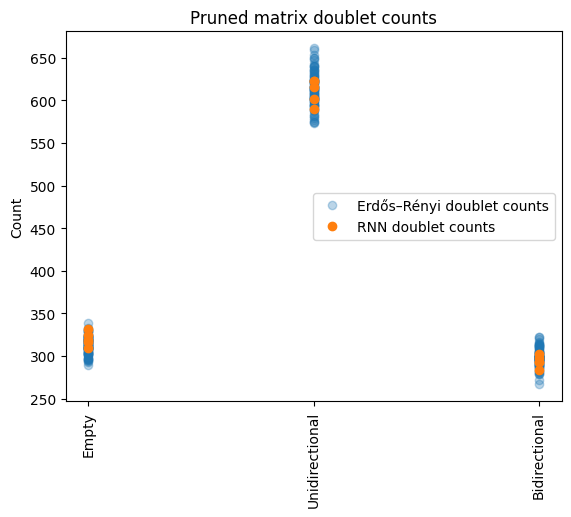

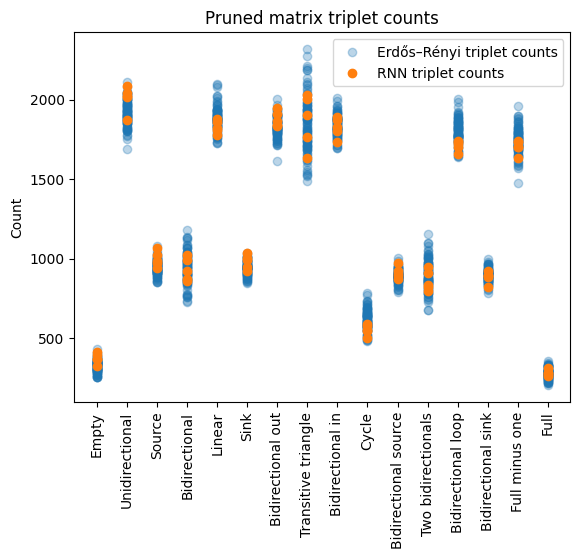

In [54]:
plot_pruned_motif_dist(0.5, eps_vals_diag, props_nonzeros_diag, nns_diag)

Also no discernible differences. What if we try a dynamics matrix consisting of a direct sum of 2x2 off-diagonal matrices?

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.70it/s]


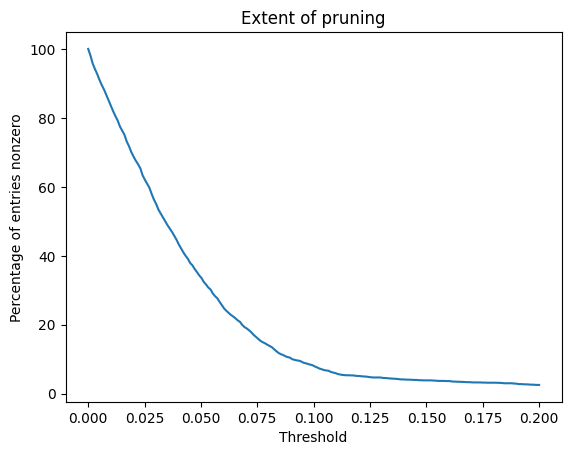

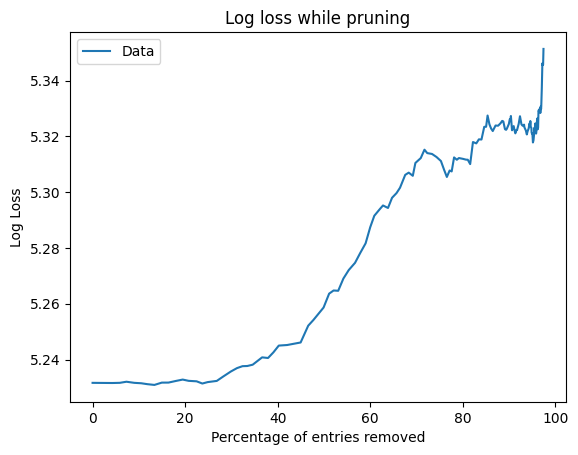

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


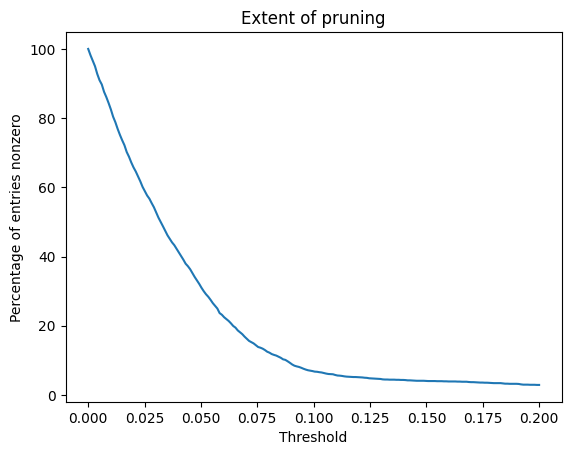

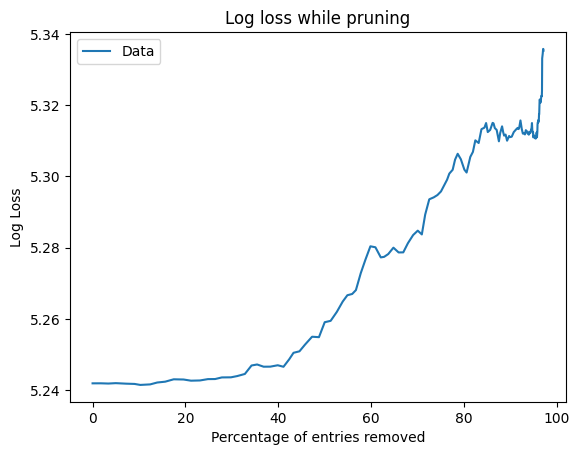

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.55it/s]


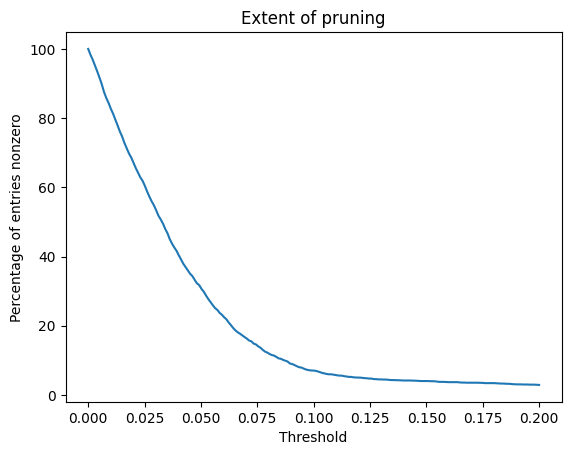

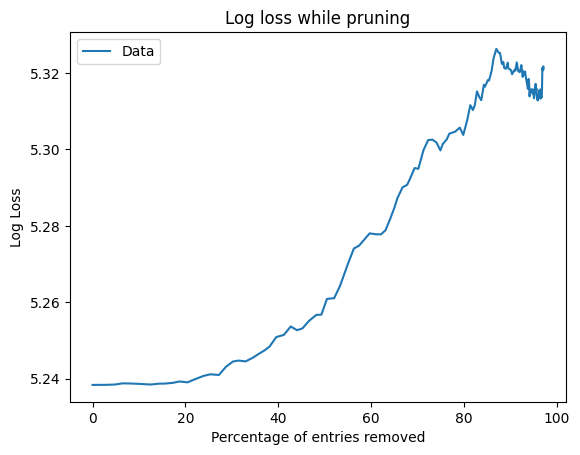

100%|███████████████████████████████████████████████████████████| 200/200 [00:44<00:00,  4.51it/s]


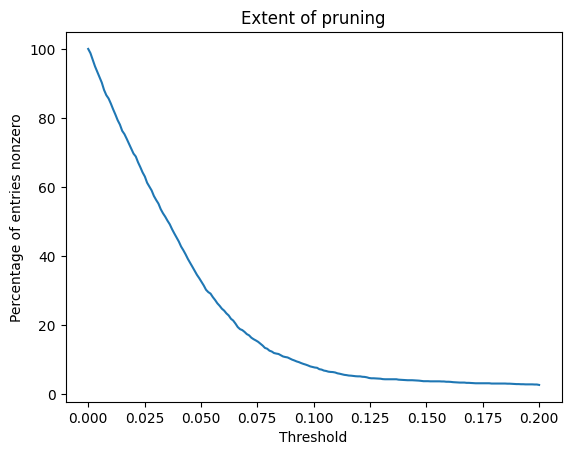

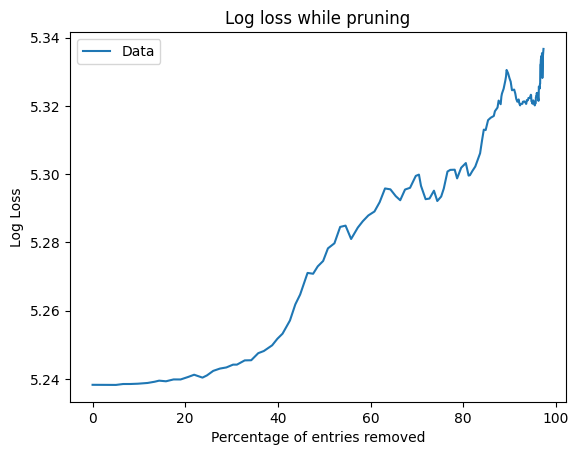

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.64it/s]


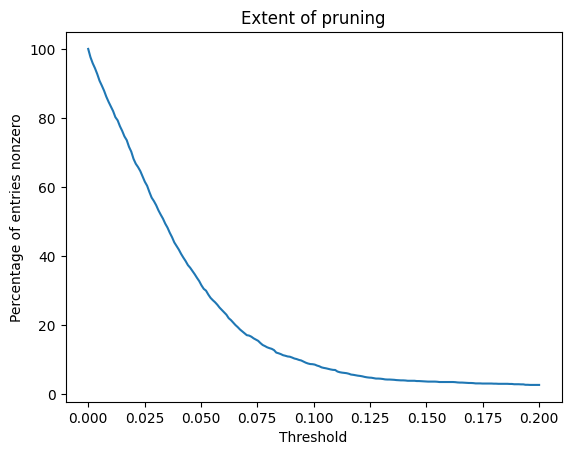

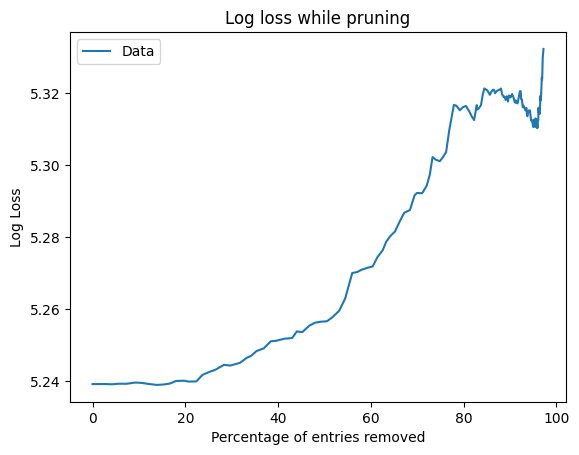

In [55]:
def gen_pairs_dynamics_matrix(rng, n):
    A = np.zeros((n,n))
    for i in range(1, n, 2):
        A[i,i-1] = 0.9
        A[i-1,i] = 0.9
    return A

As_pairs, procs_pairs, nns_pairs, eps_vals_pairs, props_nonzeros_pairs, losses_pairs = (
    test_dynamics_matrix(rng, gen_pairs_dynamics_matrix,
                         np.full(2000, 1e-7)))

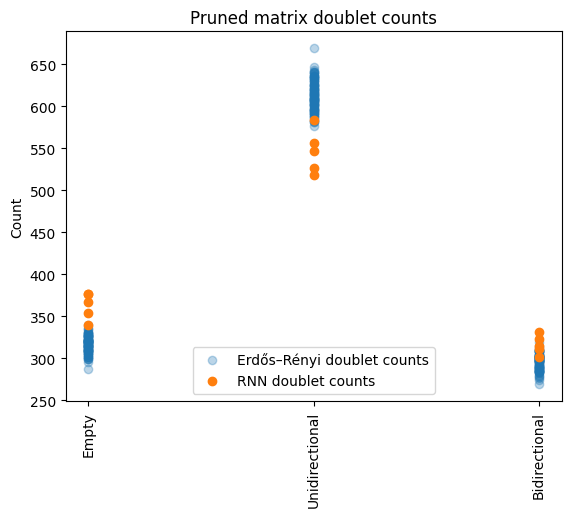

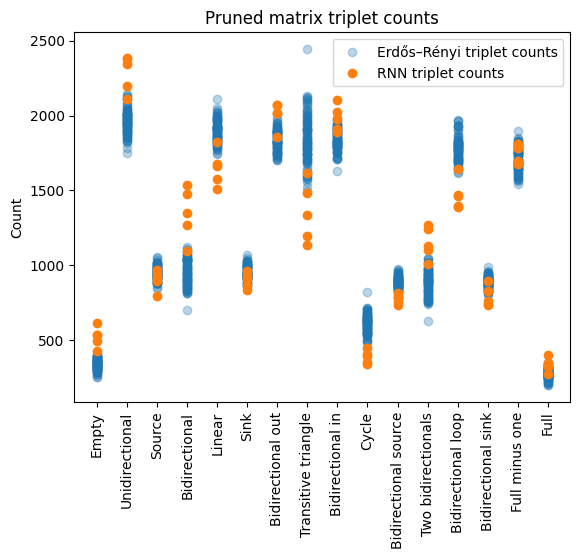

In [56]:
plot_pruned_motif_dist(0.5, eps_vals_pairs, props_nonzeros_pairs, nns_pairs)

What about a symmetric matrix?

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.55it/s]


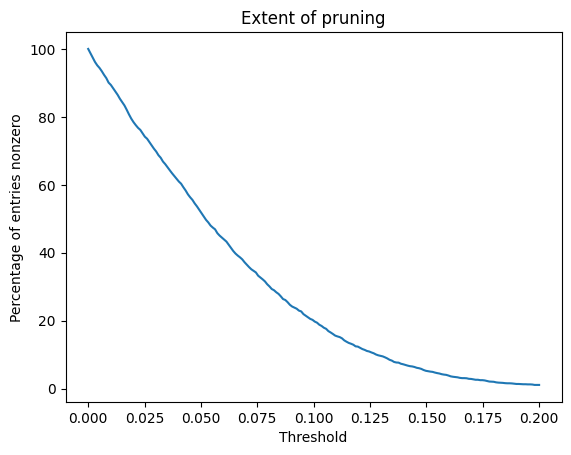

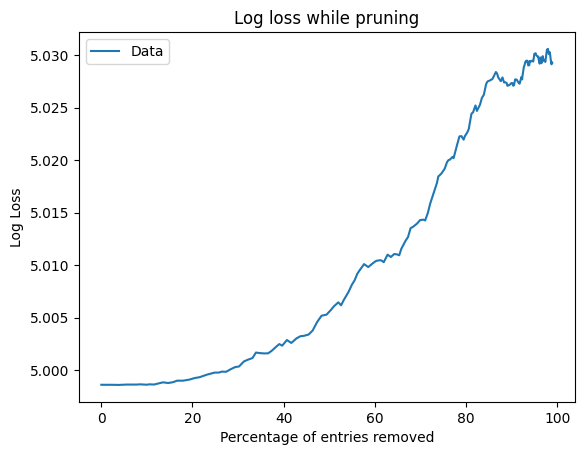

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


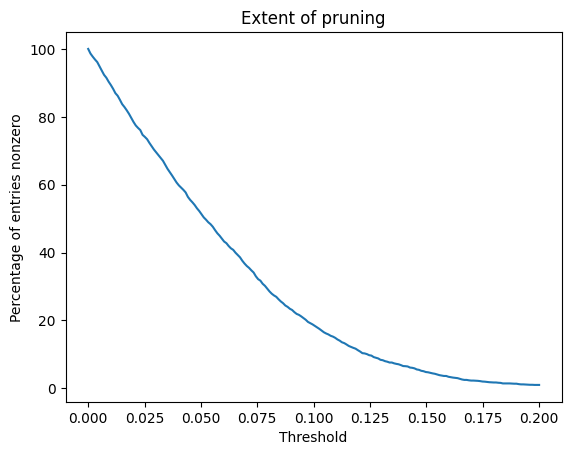

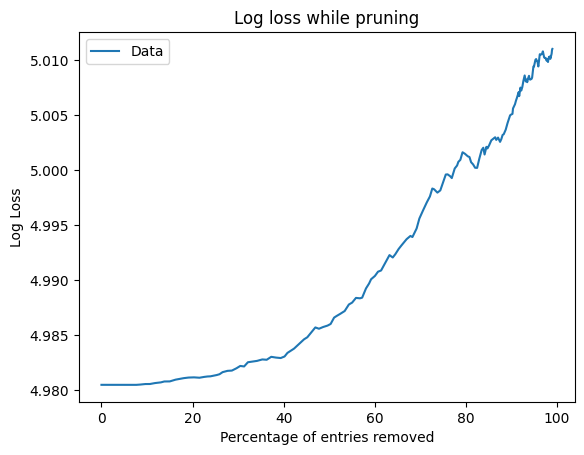

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


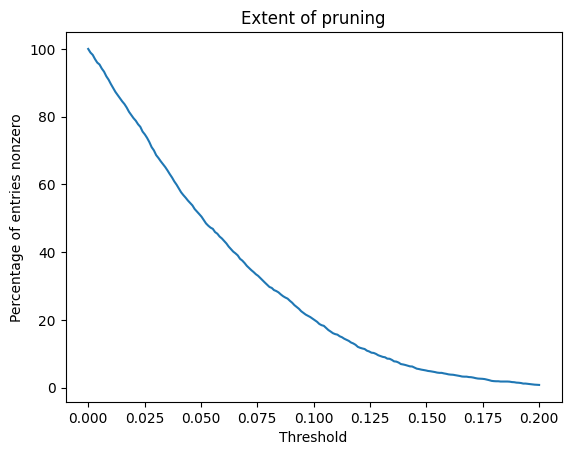

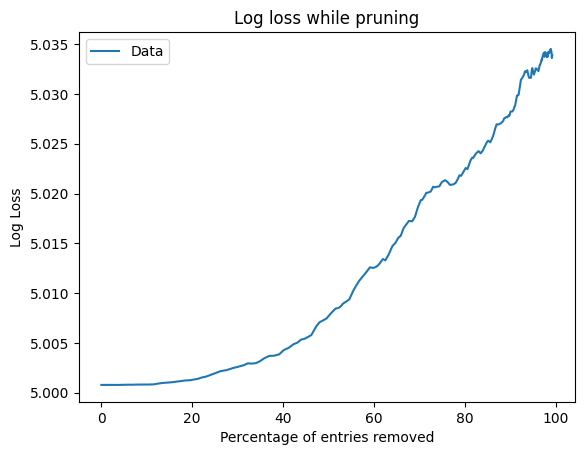

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


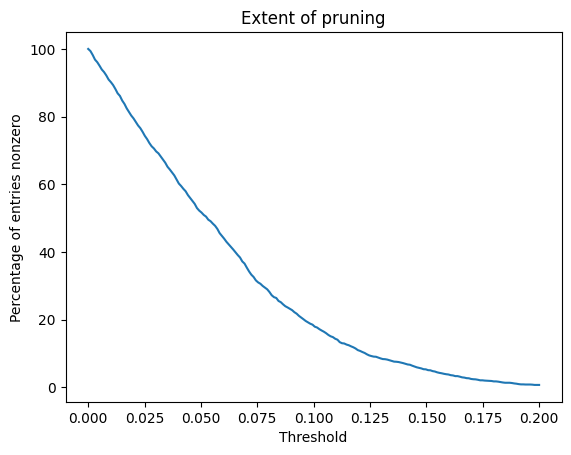

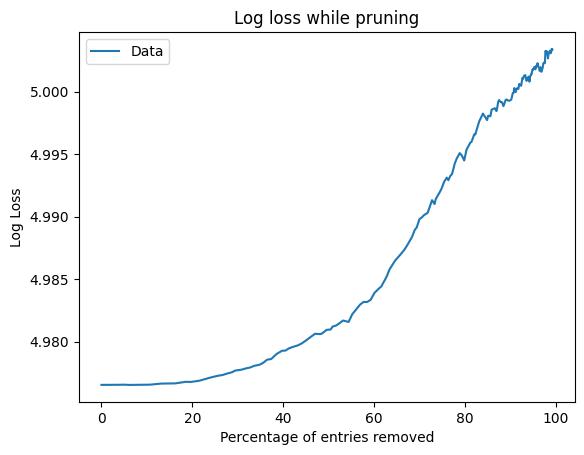

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.61it/s]


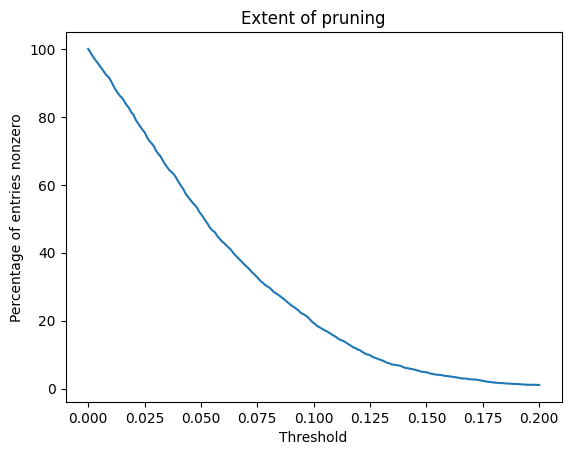

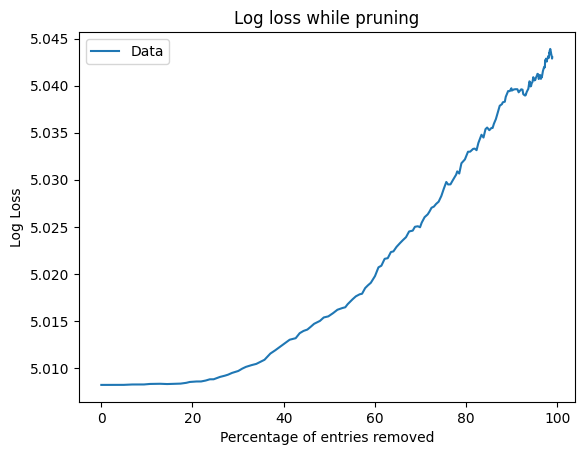

In [57]:
def gen_symm_dynamics_matrix(rng, n):
    A = mk_rand_matrix(rng, n)
    A += A.T
    return A / (1.1*highest_eig(A))

As_symm, procs_symm, nns_symm, eps_vals_symm, props_nonzeros_symm, losses_symm = (
    test_dynamics_matrix(rng, gen_symm_dynamics_matrix,
                         np.full(300, 5e-7)))

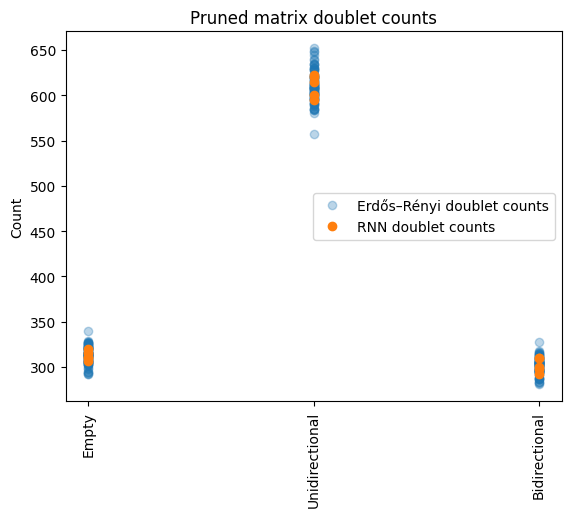

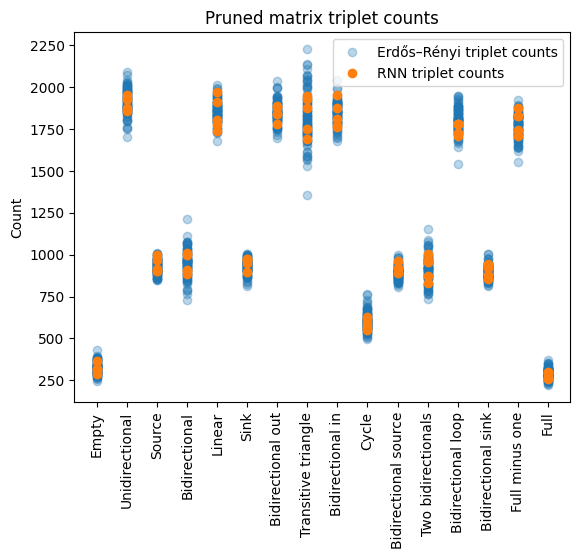

In [58]:
plot_pruned_motif_dist(0.5, eps_vals_symm, props_nonzeros_symm, nns_symm)

An antisymmetric matrix?

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.58it/s]


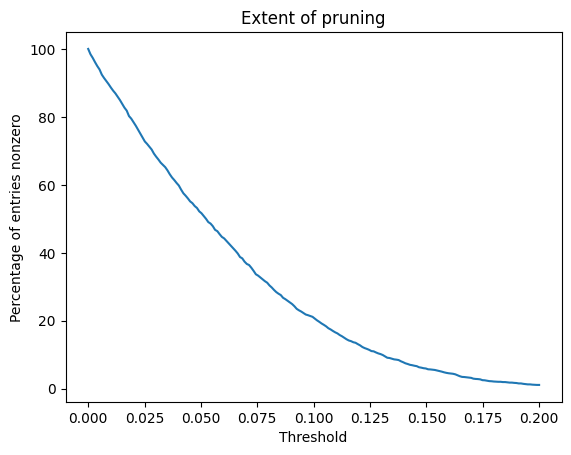

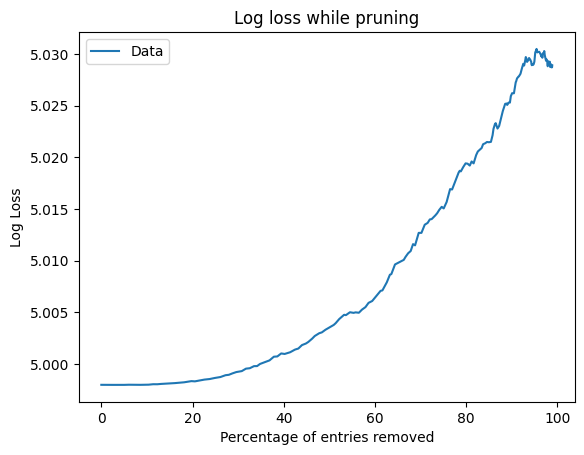

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


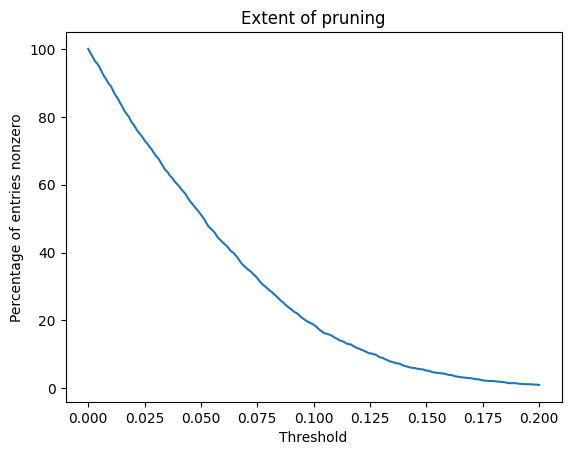

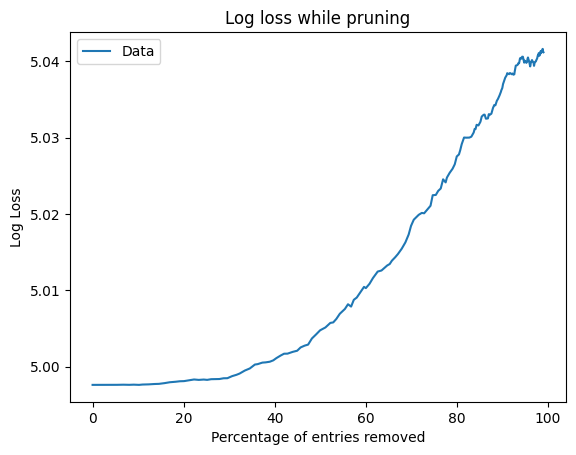

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.59it/s]


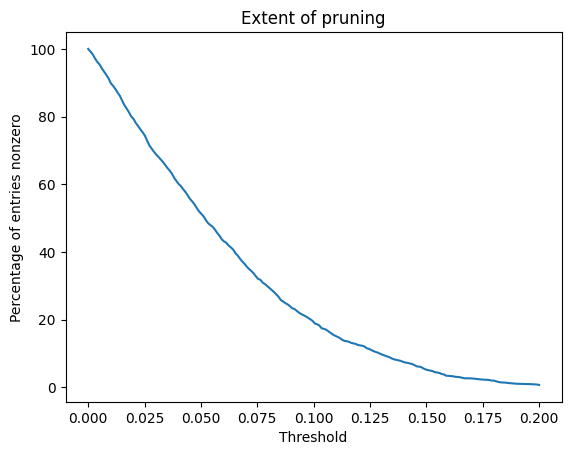

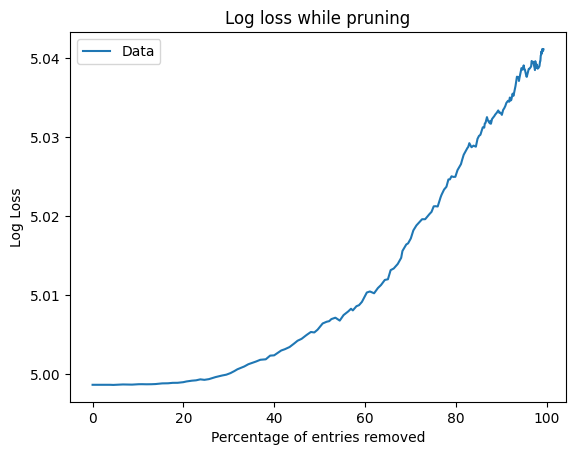

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


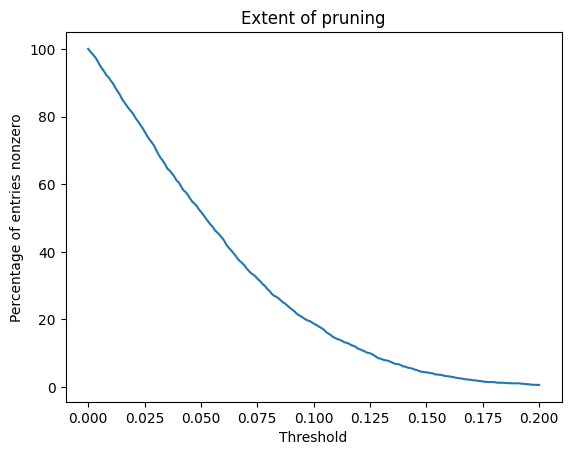

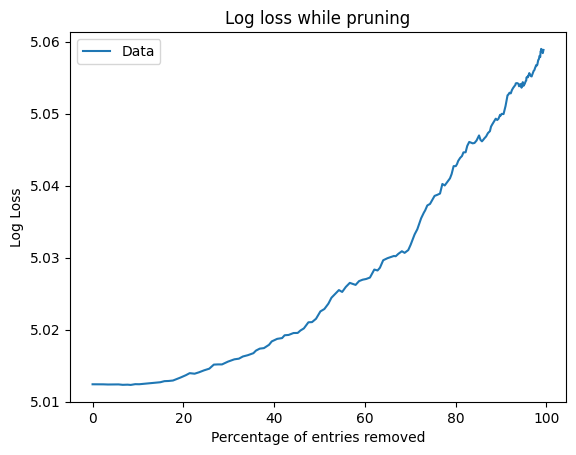

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


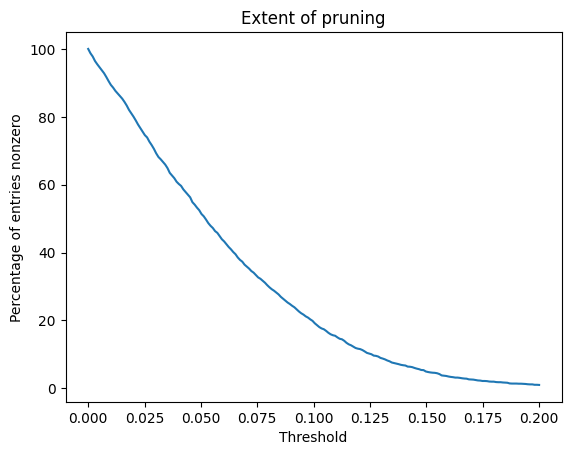

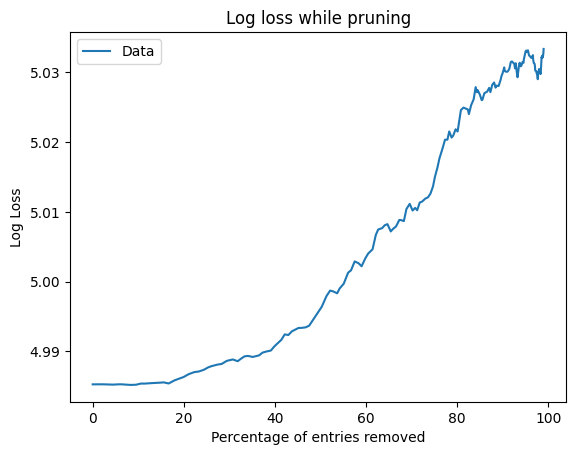

In [59]:
def gen_antisymm_dynamics_matrix(rng, n):
    A = mk_rand_matrix(rng, n)
    A -= A.T
    return A / (1.1*highest_eig(A))

As_antisymm, procs_antisymm, nns_antisymm, eps_vals_antisymm, props_nonzeros_antisymm, losses_antisymm = (
    test_dynamics_matrix(rng, gen_antisymm_dynamics_matrix,
                         np.full(300, 5e-7)))

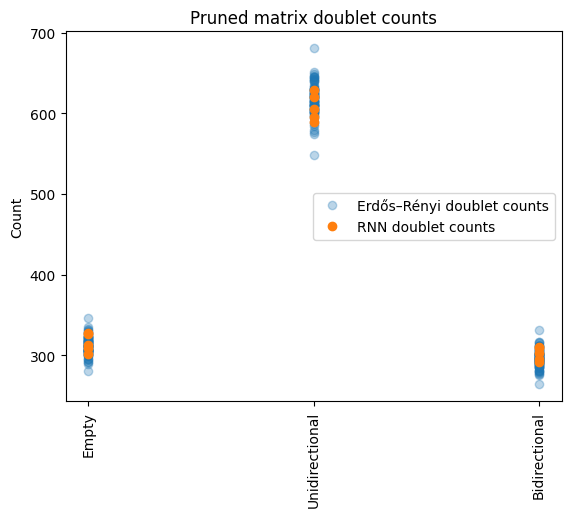

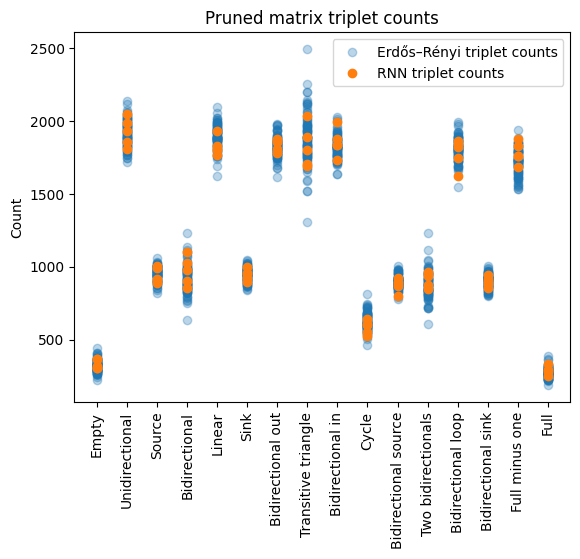

In [60]:
plot_pruned_motif_dist(0.5, eps_vals_antisymm, props_nonzeros_antisymm, nns_antisymm)

What about matrices with third-order correlations, like correlated 3-cycles, anticorrelated 3-cycles, and transitive triangles?

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


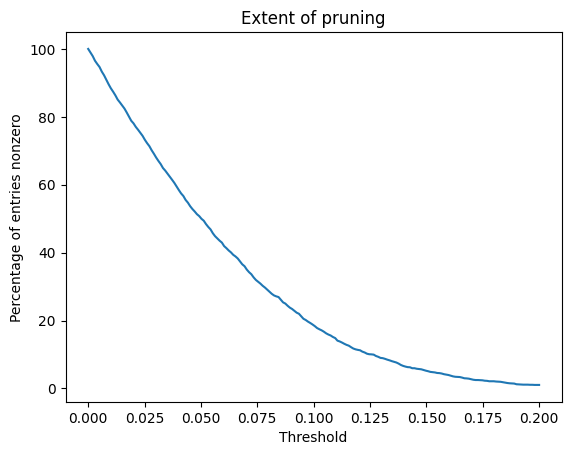

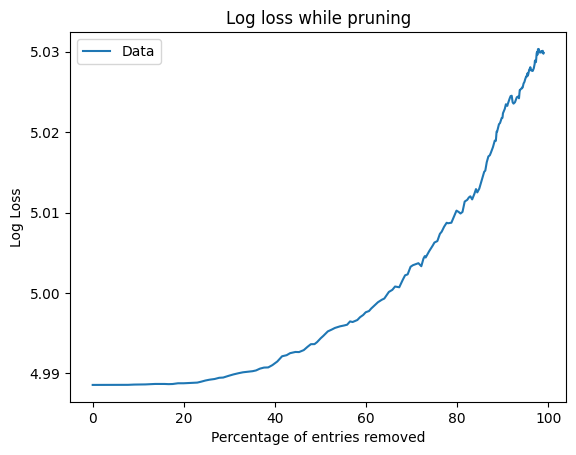

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


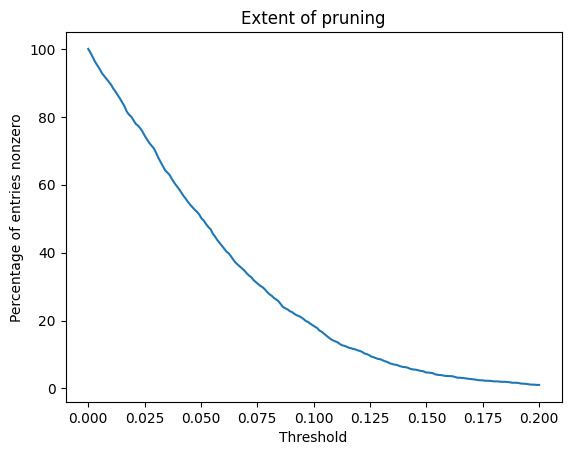

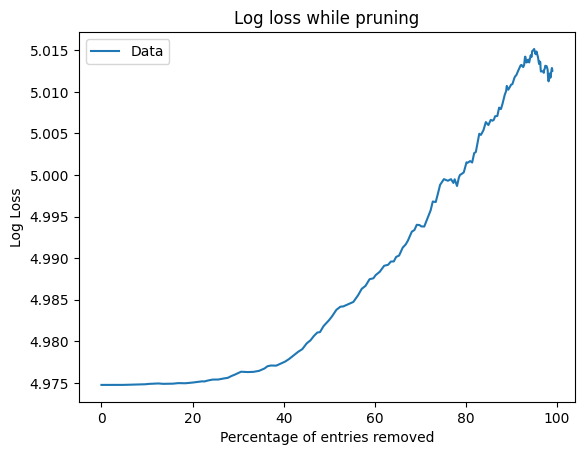

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


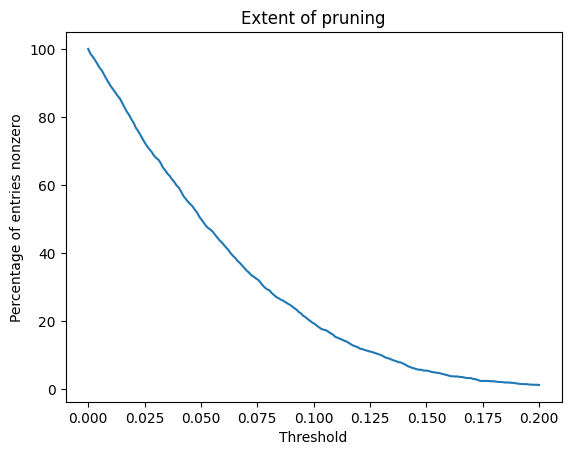

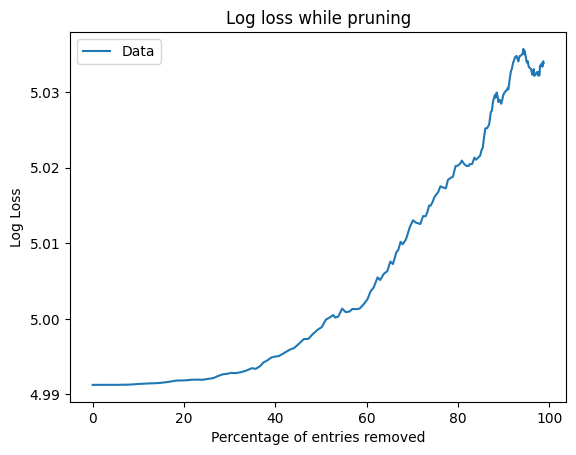

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.65it/s]


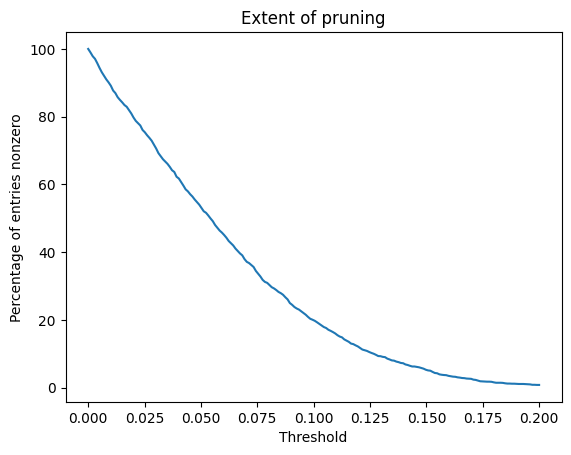

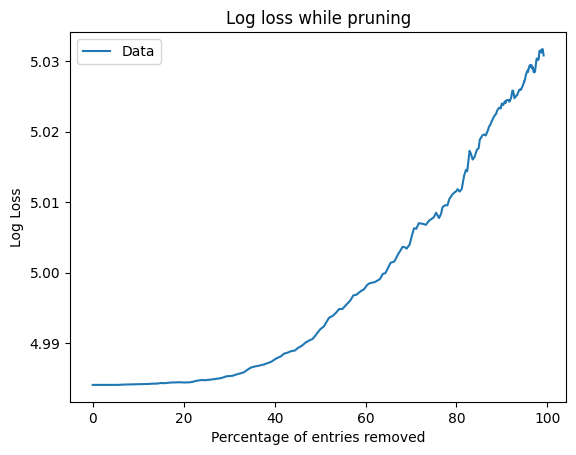

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


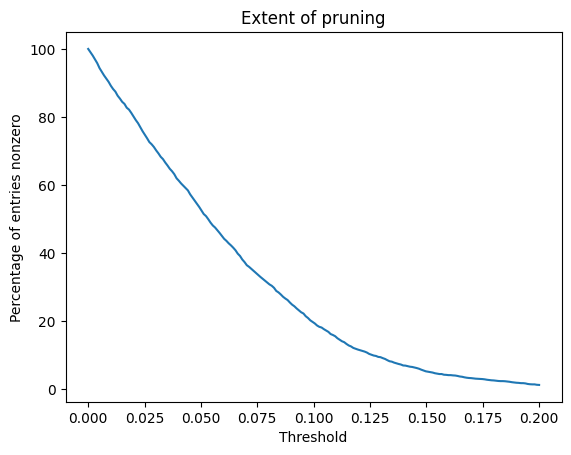

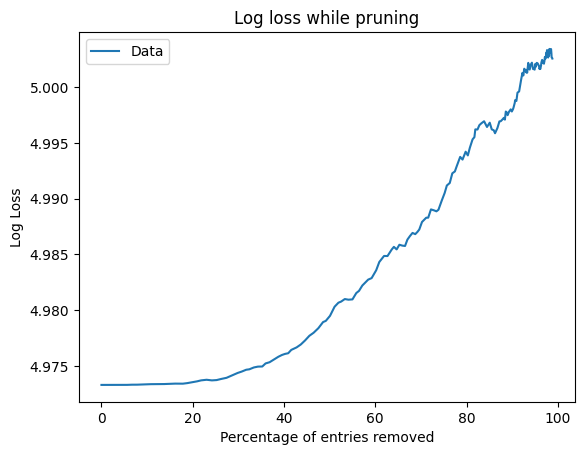

In [61]:
def gen_3cycl_dynamics_matrix(rng, n):
    A = mk_rand_matrix_3cycl(rng, n)
    return A / (1.1*highest_eig(A))

As_3cycl, procs_3cycl, nns_3cycl, eps_vals_3cycl, props_nonzeros_3cycl, losses_3cycl = (
    test_dynamics_matrix(rng, gen_3cycl_dynamics_matrix,
                         np.full(300, 5e-7)))

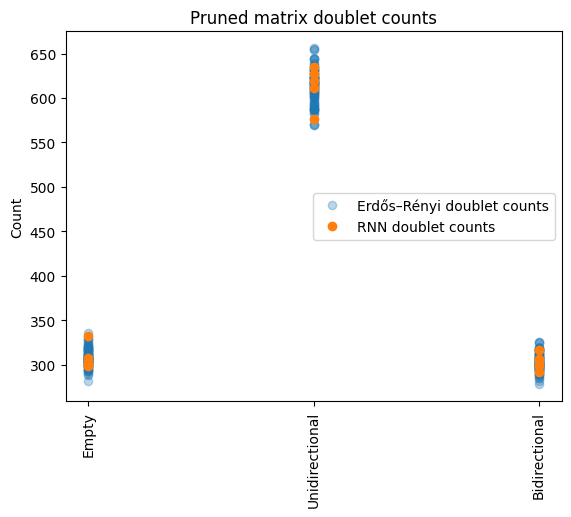

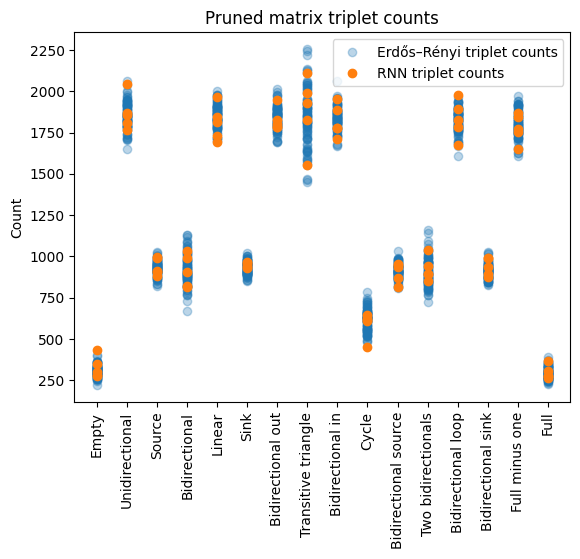

In [62]:
plot_pruned_motif_dist(0.5, eps_vals_3cycl, props_nonzeros_3cycl, nns_3cycl)

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.74it/s]


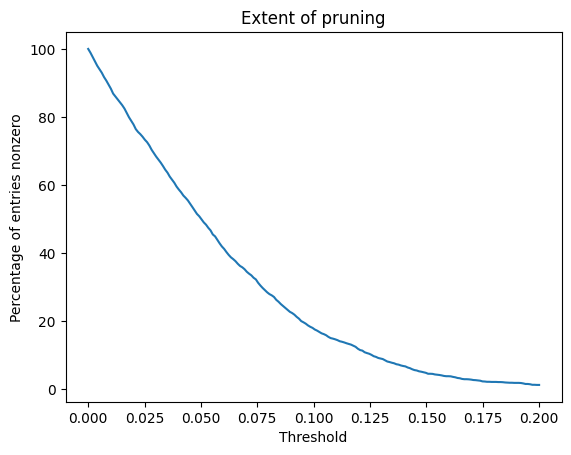

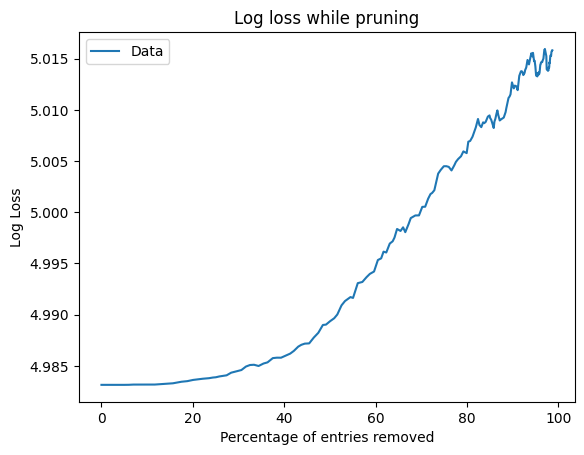

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.65it/s]


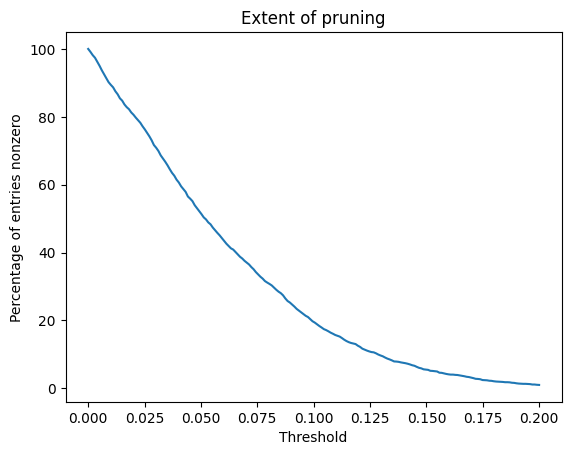

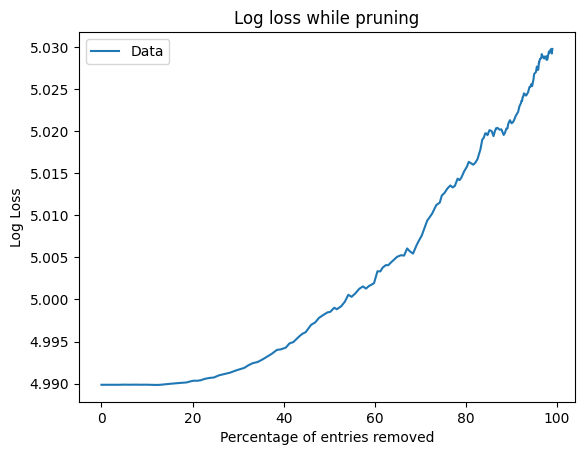

100%|███████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.62it/s]


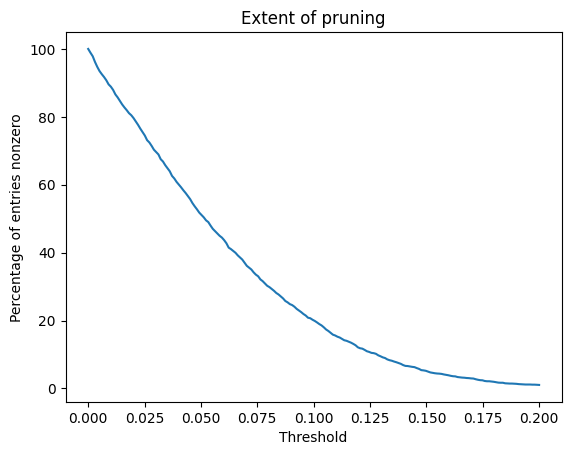

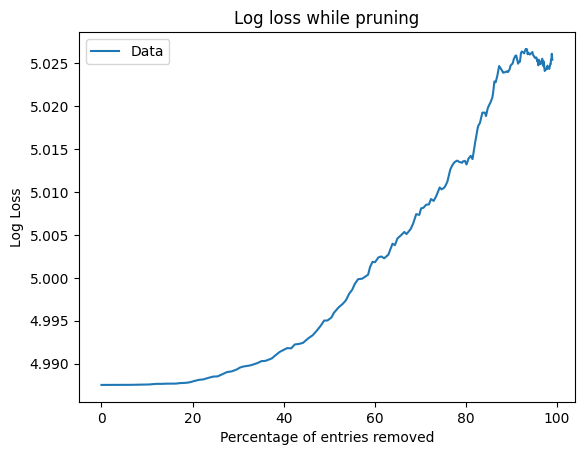

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.72it/s]


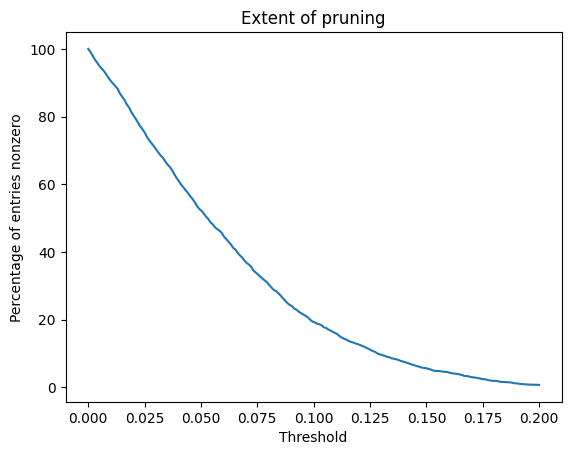

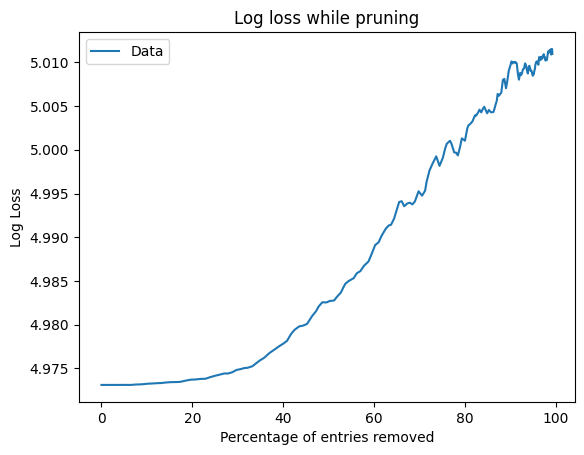

100%|███████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.64it/s]


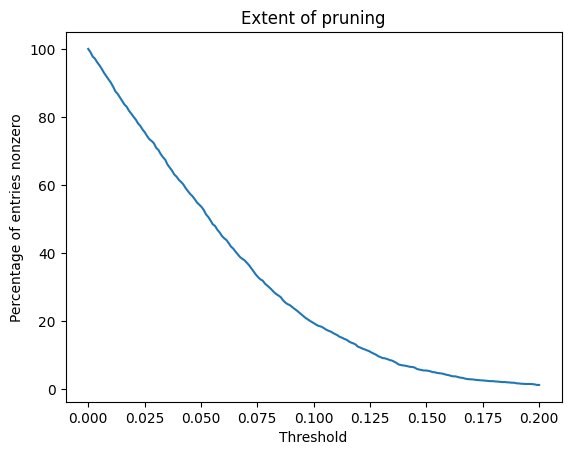

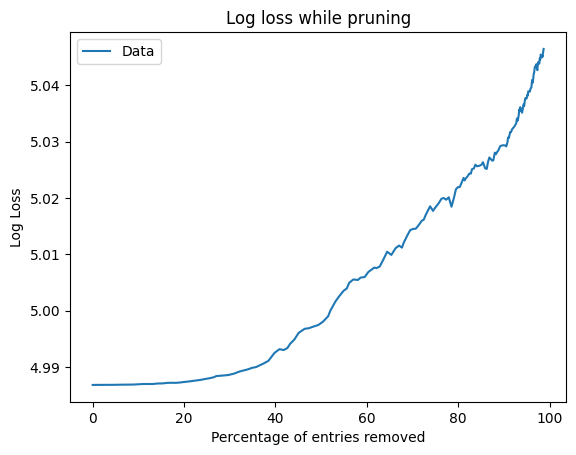

In [63]:
def gen_neg3cycl_dynamics_matrix(rng, n):
    A = mk_rand_matrix_3cycl(rng, n, rho=-1)
    return A / (1.1*highest_eig(A))

As_neg3cycl, procs_neg3cycl, nns_neg3cycl, eps_vals_neg3cycl, props_nonzeros_neg3cycl, losses_neg3cycl = (
    test_dynamics_matrix(rng, gen_neg3cycl_dynamics_matrix,
                         np.full(300, 5e-7)))

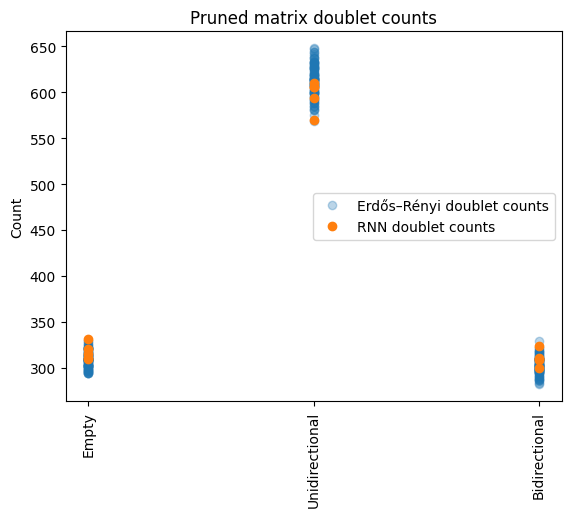

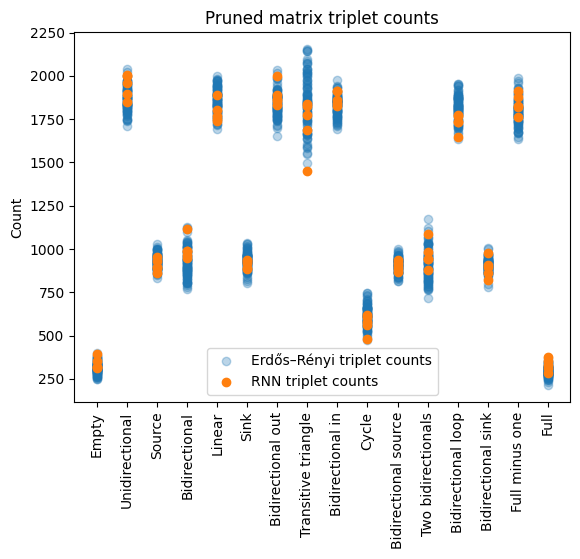

In [64]:
plot_pruned_motif_dist(0.5, eps_vals_neg3cycl, props_nonzeros_neg3cycl, nns_neg3cycl)

100%|███████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.13it/s]


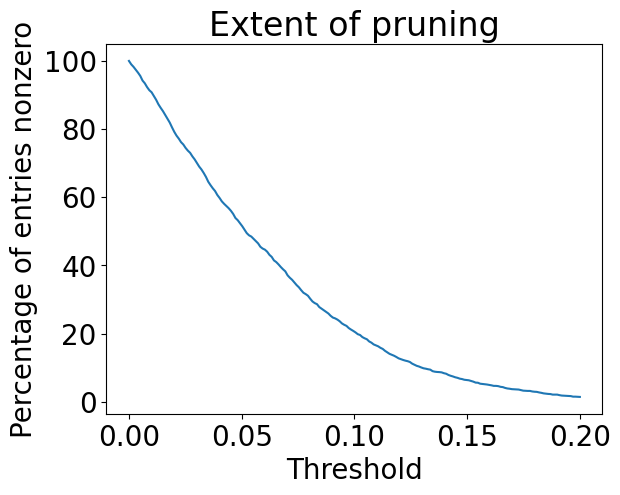

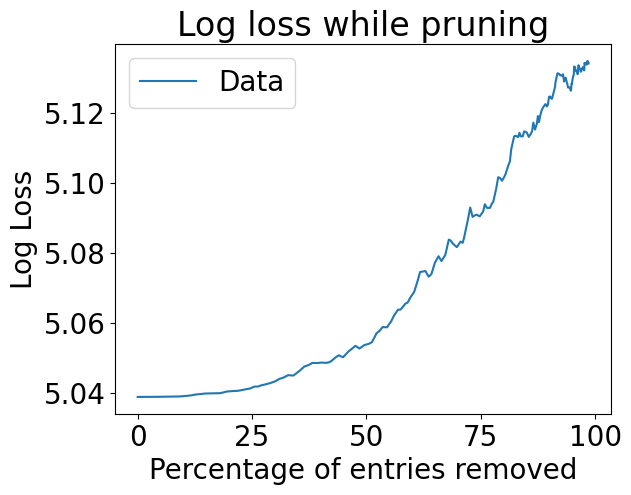

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.71it/s]


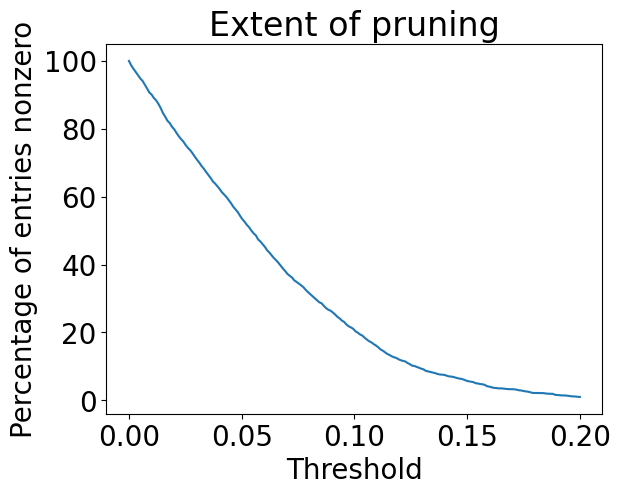

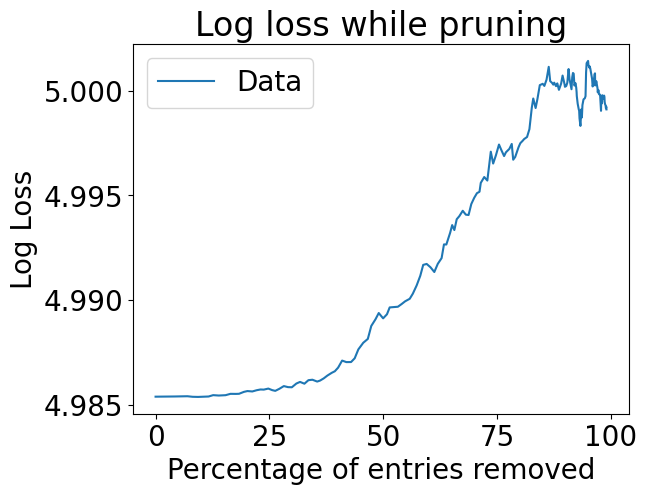

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


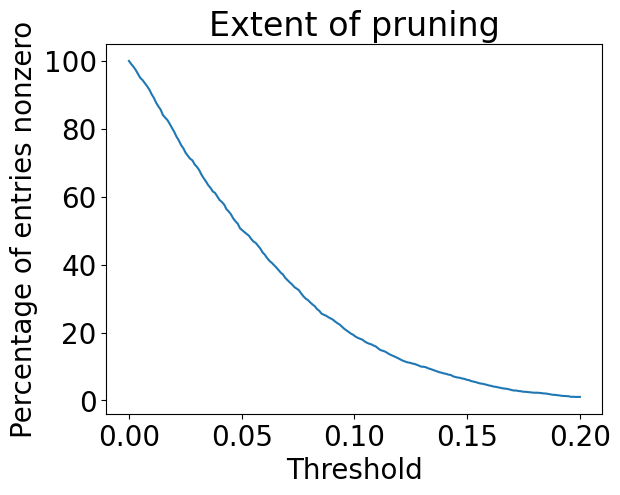

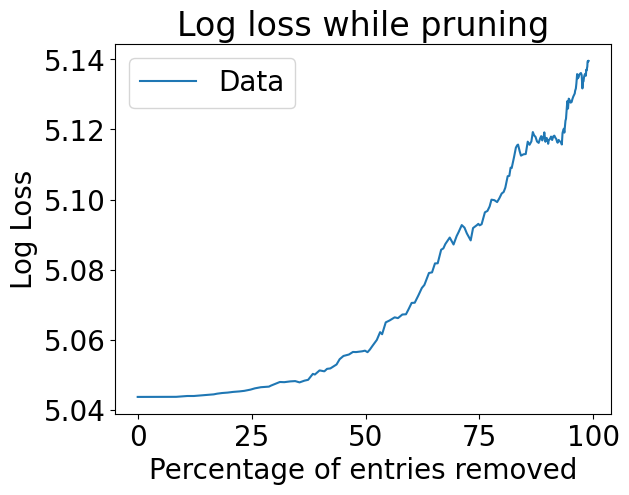

100%|███████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.76it/s]


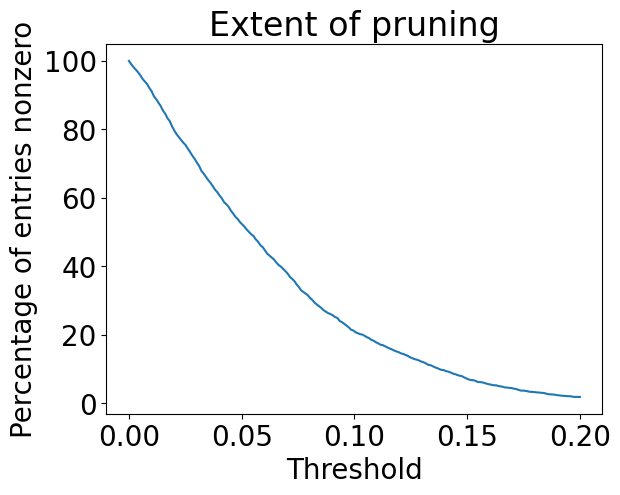

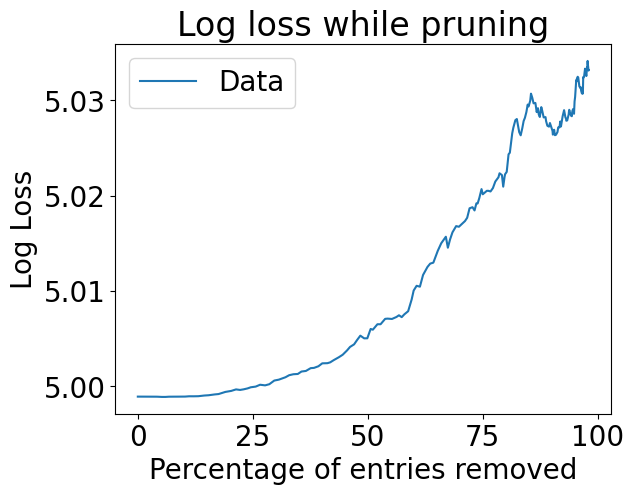

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.74it/s]


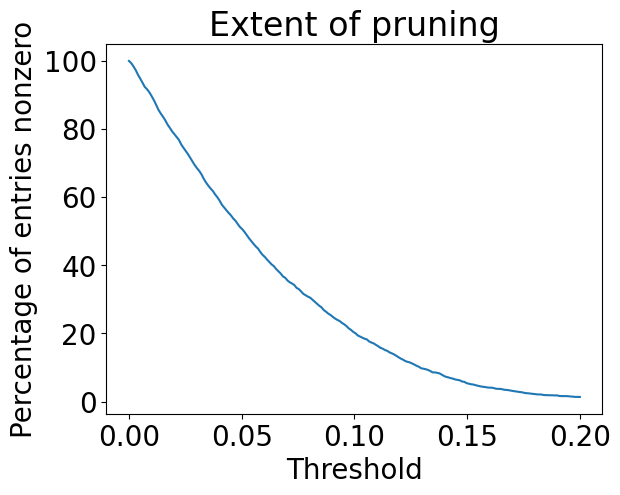

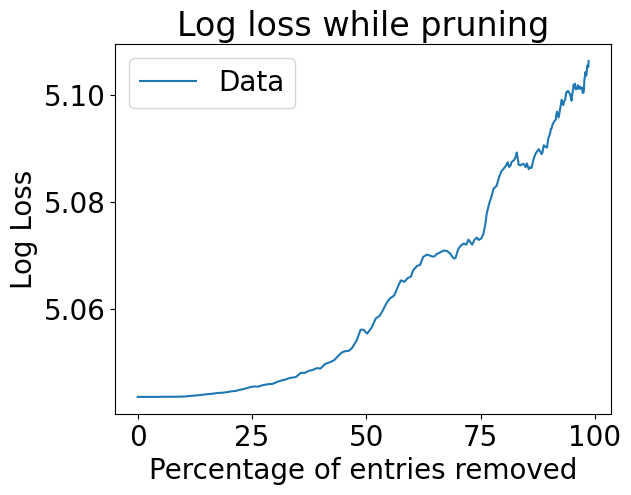

In [133]:
def gen_transtrngl_dynamics_matrix(rng, n):
    A = mk_rand_matrix_transtrngl(rng, n)
    return A / (1.1*highest_eig(A))

As_transtrngl, procs_transtrngl, nns_transtrngl, eps_vals_transtrngl, props_nonzeros_transtrngl, losses_transtrngl = (
    test_dynamics_matrix(rng, gen_transtrngl_dynamics_matrix,
                         np.full(500, 1e-7)))

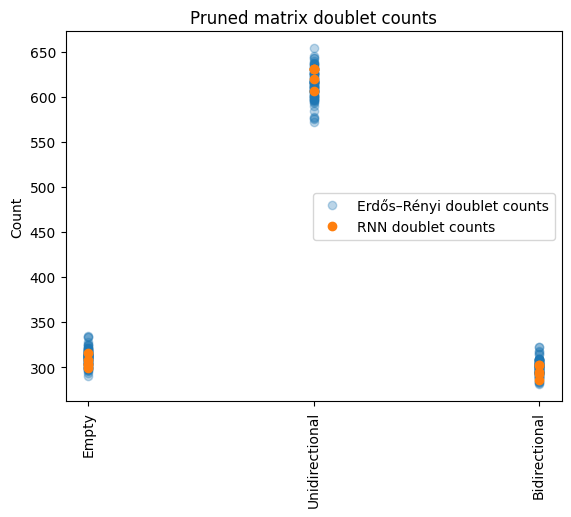

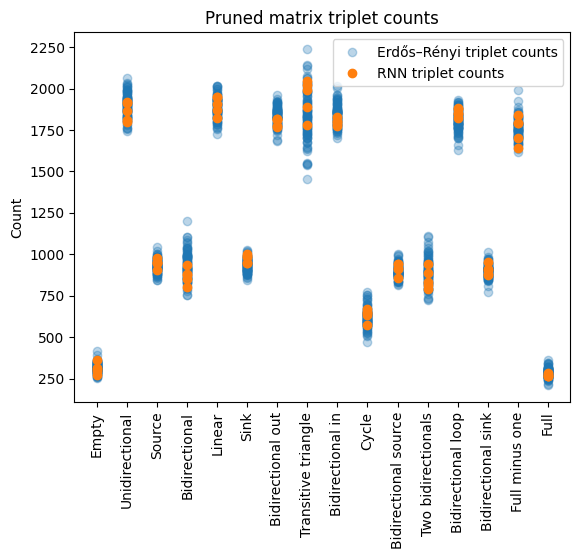

In [72]:
plot_pruned_motif_dist(0.5, eps_vals_transtrngl, props_nonzeros_transtrngl, nns_transtrngl)

100%|███████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


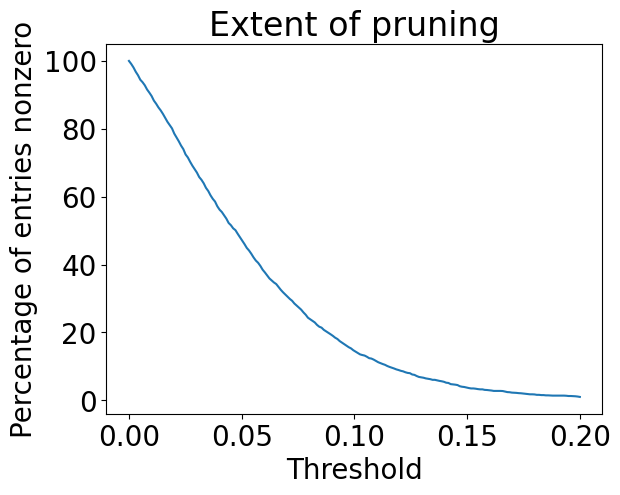

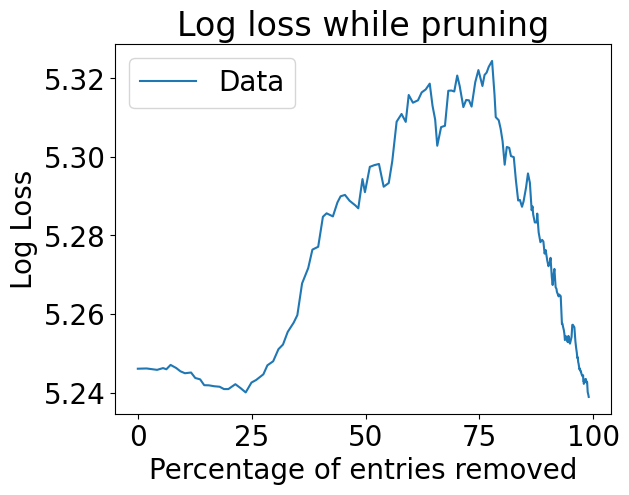

100%|███████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.51it/s]


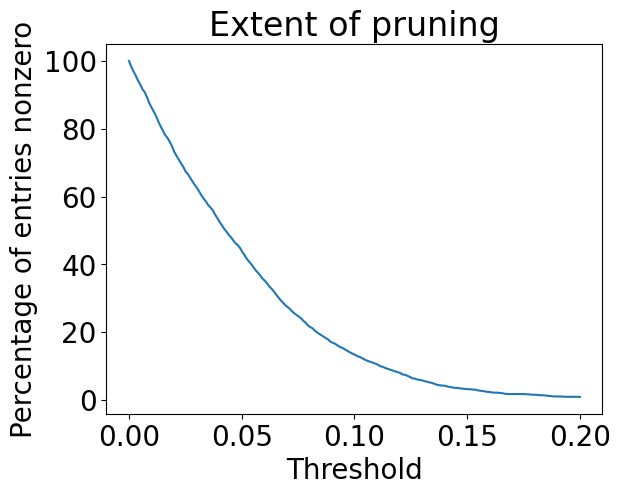

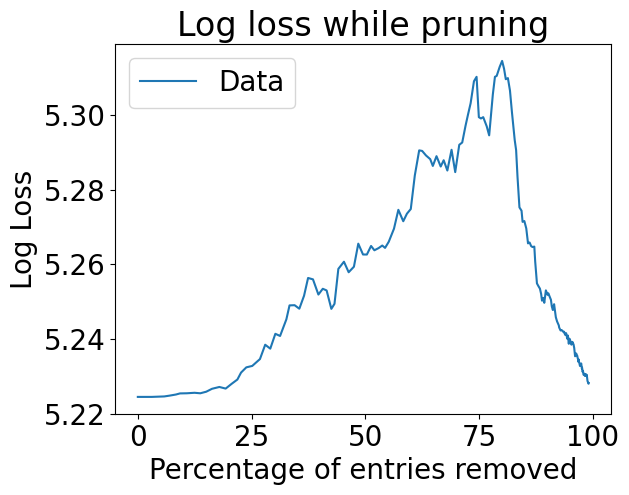

100%|███████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.59it/s]


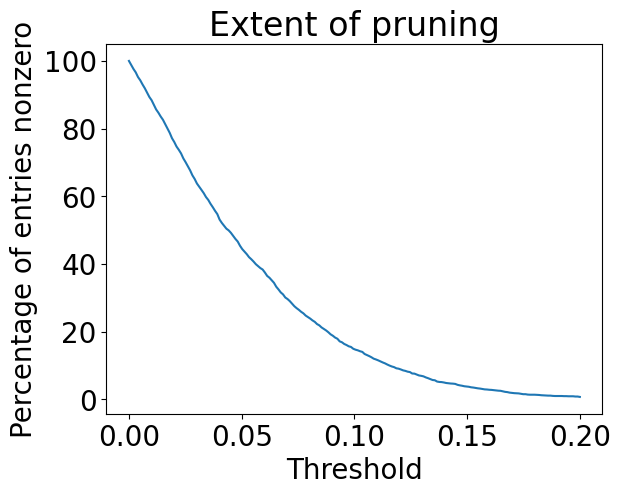

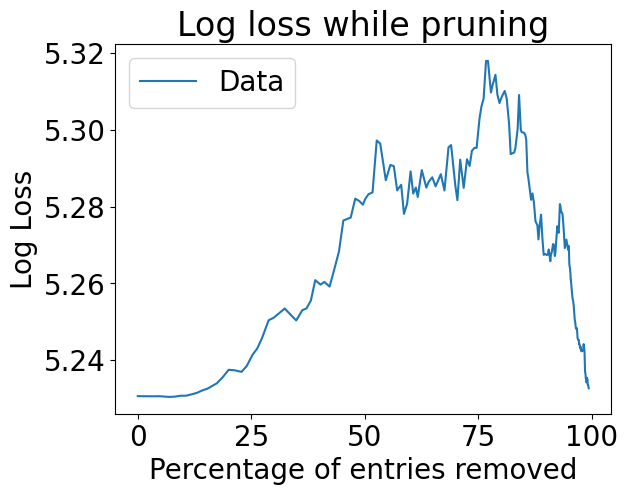

100%|███████████████████████████████████████████████████████████| 200/200 [00:54<00:00,  3.70it/s]


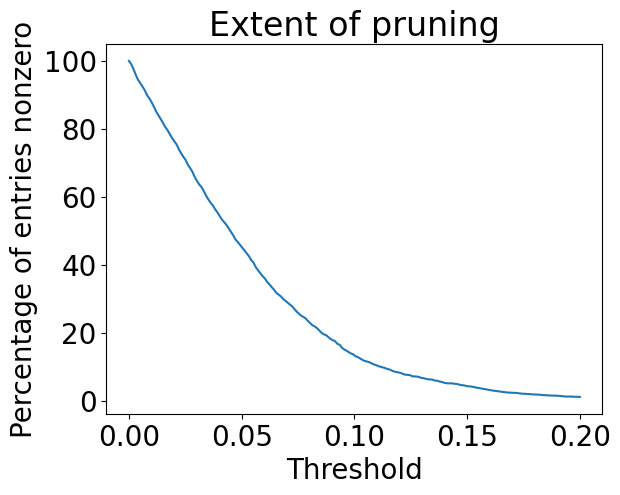

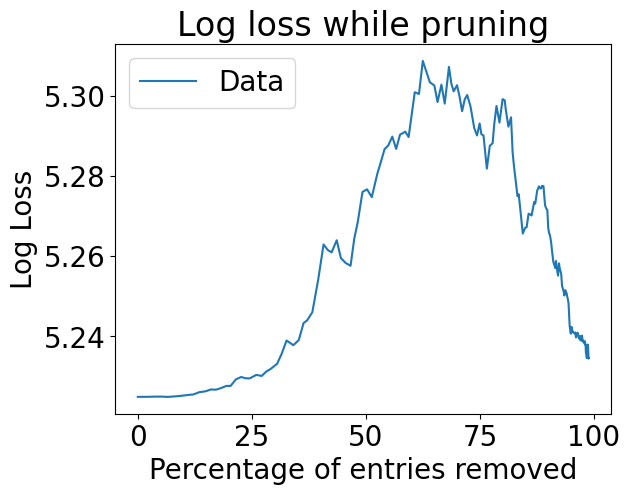

100%|███████████████████████████████████████████████████████████| 200/200 [01:36<00:00,  2.07it/s]


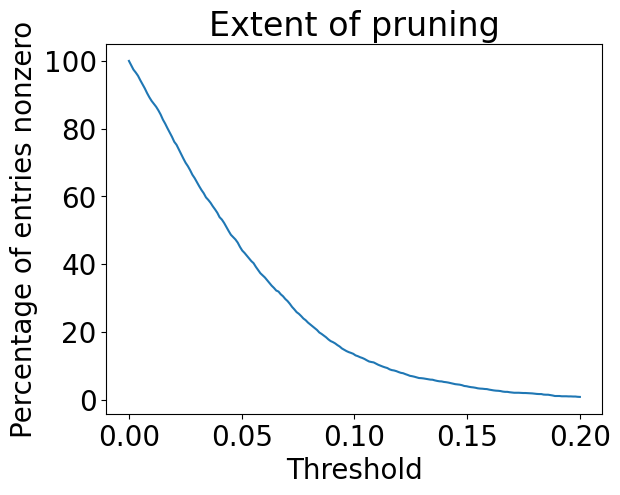

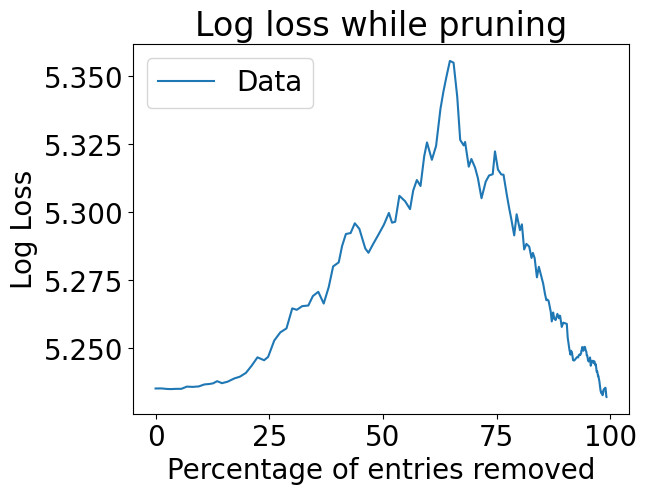

In [141]:
def gen_transtrnglsparse_dynamics_matrix(rng, n):
    A = np.zeros((n,n))
    for i in range(2, n, 3):
        A[i-1,i-2] = 0.9
        A[i,i-1] = 0.9
        A[i,i-2] = 0.9
    return A

As_transtrnglsparse, procs_transtrnglsparse, nns_transtrnglsparse, eps_vals_transtrnglsparse, props_nonzeros_transtrnglsparse, losses_transtrnglsparse = (
    test_dynamics_matrix(rng, gen_transtrnglsparse_dynamics_matrix,
                         np.concatenate((np.full(250, 5e-7), np.full(150, 1e-7))),
                         n=51))

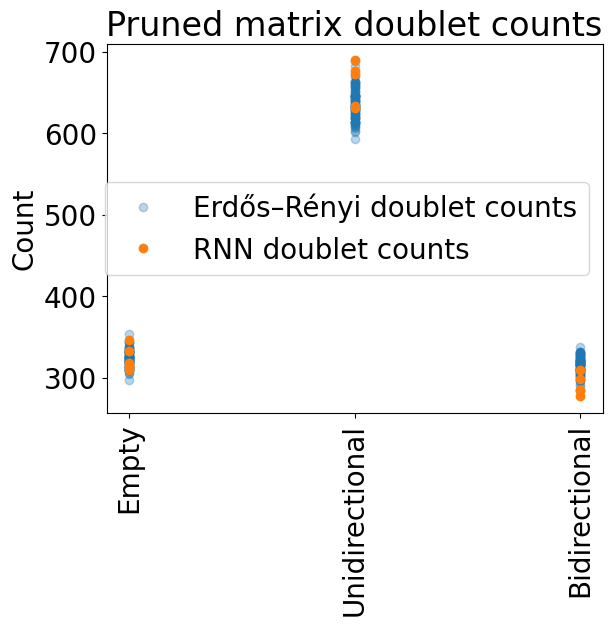

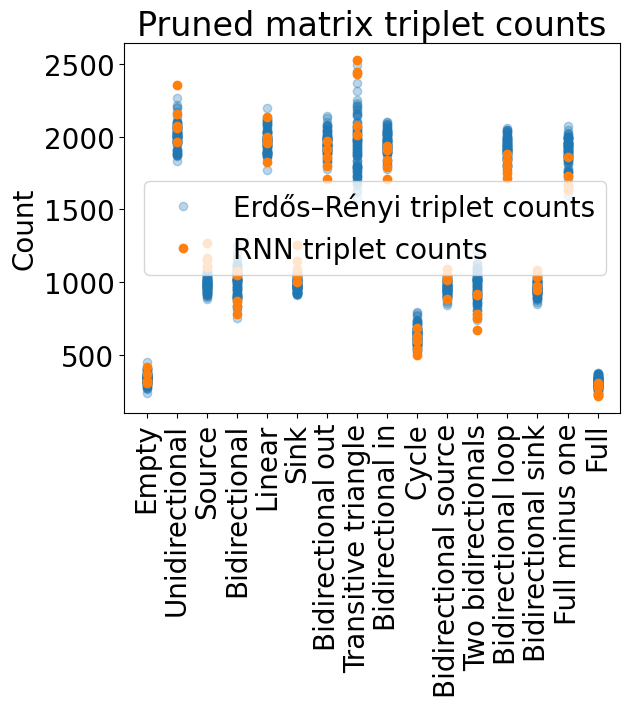

In [142]:
plot_pruned_motif_dist(0.5, eps_vals_transtrnglsparse, props_nonzeros_transtrnglsparse, nns_transtrnglsparse)

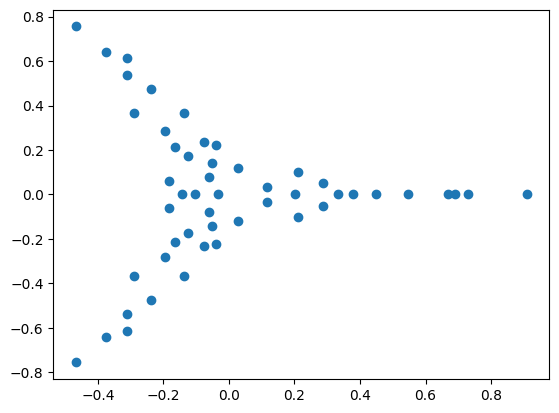

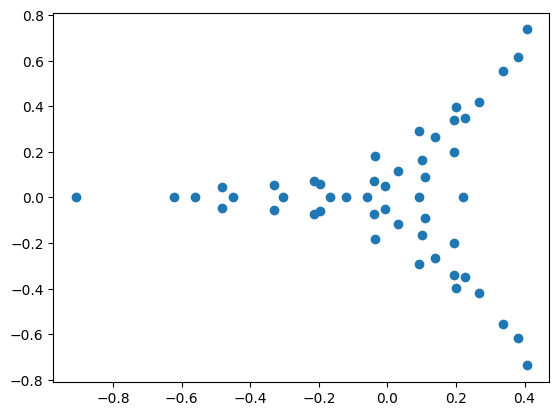

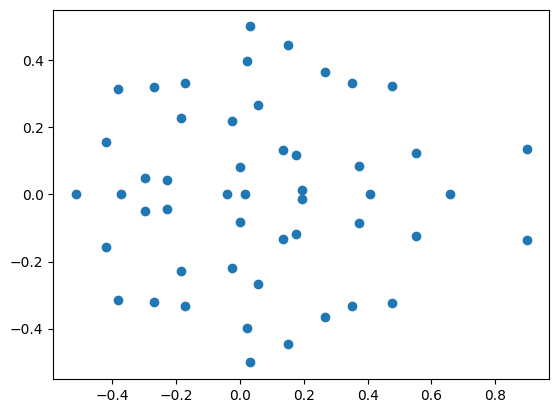

In [80]:
eigs = np.linalg.eig(As_3cycl[0]).eigenvalues
plt.scatter(np.real(eigs), np.imag(eigs))
plt.show()

eigs = np.linalg.eig(As_neg3cycl[0]).eigenvalues
plt.scatter(np.real(eigs), np.imag(eigs))
plt.show()

eigs = np.linalg.eig(As_transtrngl[0]).eigenvalues
plt.scatter(np.real(eigs), np.imag(eigs))
plt.show()

A = [[0.  0.  0.  ... 0.  0.  0. ]
 [0.9 0.  0.  ... 0.  0.  0. ]
 [0.9 0.9 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.9 0.  0. ]
 [0.  0.  0.  ... 0.9 0.9 0. ]]
Eigenvalues =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


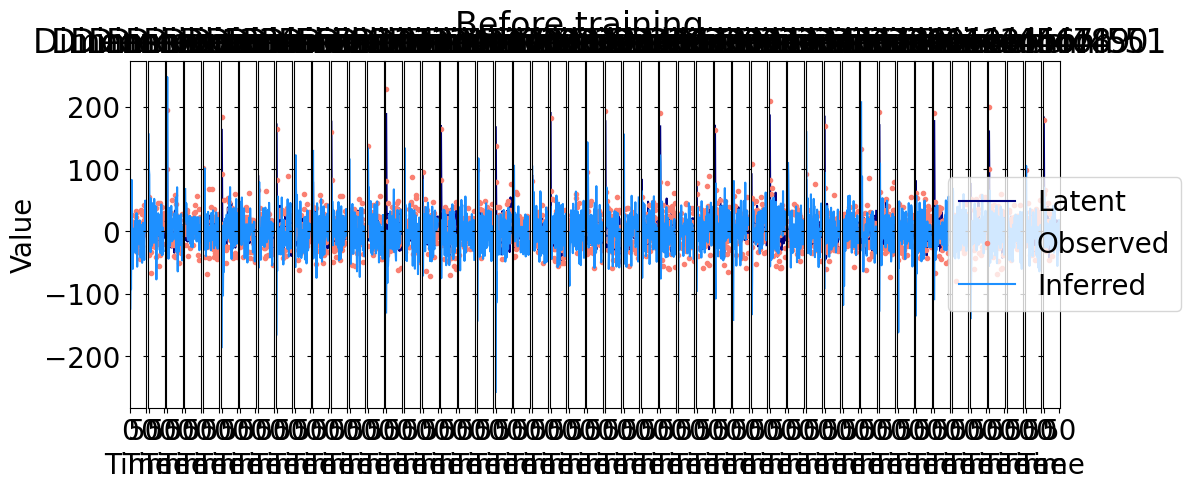

Loss 1109177.7062795456
M = [[-2.06375477e-02 -8.45505178e-02 -7.47438335e-03 ...  7.99616003e-02
  -5.98055446e-02 -1.42845025e-01]
 [-2.27338190e-01  8.74427634e-02  2.02663102e-02 ... -8.33172024e-02
  -5.22816030e-02  3.16763461e-02]
 [ 9.45602402e-02 -8.27879735e-02  7.83912332e-03 ... -5.39680610e-02
  -1.91000654e-01  1.52898220e-02]
 ...
 [ 1.63699116e-01  7.31708202e-02 -1.52668348e-01 ... -2.33972235e-01
  -4.00803169e-03 -4.01002018e-03]
 [ 8.16957234e-02  1.04998052e-01  8.96572416e-02 ... -1.68294641e-04
   1.29697881e-01  5.18886597e-02]
 [ 7.07454476e-02 -9.57431688e-02  1.80810244e-02 ...  9.35400545e-02
   9.65979475e-02 -8.86986535e-02]]
K = [[ 0.12588322  0.18692967  0.22417576 ... -0.04248664 -0.09016223
   0.19673847]
 [ 0.04642405 -0.1003795   0.01339903 ...  0.10361606  0.06950399
   0.07683153]
 [ 0.09086805 -0.018939   -0.04239325 ...  0.13891772  0.20585315
   0.00953064]
 ...
 [-0.03958398 -0.04458034  0.07283562 ...  0.01919586 -0.03046288
  -0.04495097]
 [ 

  0%|▏                                                            | 1/400 [00:08<55:56,  8.41s/it]

Mean loss 1159183.2053195655


  0%|▎                                                            | 2/400 [00:13<41:37,  6.28s/it]

Mean loss 1119412.0882957992


  1%|▍                                                            | 3/400 [00:16<34:01,  5.14s/it]

Mean loss 906074.046005187


  1%|▌                                                            | 4/400 [00:21<32:06,  4.87s/it]

Mean loss 788747.3603299636


  1%|▊                                                            | 5/400 [00:26<31:36,  4.80s/it]

Mean loss 668190.4341037318


  2%|▉                                                            | 6/400 [00:30<31:34,  4.81s/it]

Mean loss 623917.4361072632


  2%|█                                                            | 7/400 [00:35<31:36,  4.82s/it]

Mean loss 608057.8356068492


  2%|█▏                                                           | 8/400 [00:41<33:12,  5.08s/it]

Mean loss 535528.268854615


  2%|█▎                                                           | 9/400 [00:45<31:10,  4.78s/it]

Mean loss 504980.99689581076


  2%|█▌                                                          | 10/400 [00:50<30:46,  4.74s/it]

Mean loss 481820.2043668502


  3%|█▋                                                          | 11/400 [00:54<30:27,  4.70s/it]

Mean loss 474612.3398206534


  3%|█▊                                                          | 12/400 [00:59<30:53,  4.78s/it]

Mean loss 443850.2799526943


  3%|█▉                                                          | 13/400 [01:04<31:08,  4.83s/it]

Mean loss 422400.9185633678


  4%|██                                                          | 14/400 [01:10<32:18,  5.02s/it]

Mean loss 405488.285375337


  4%|██▎                                                         | 15/400 [01:15<33:09,  5.17s/it]

Mean loss 395913.45405477256


  4%|██▍                                                         | 16/400 [01:20<32:22,  5.06s/it]

Mean loss 390963.3021172007


  4%|██▌                                                         | 17/400 [01:25<31:49,  4.99s/it]

Mean loss 383355.67094508826


  4%|██▋                                                         | 18/400 [01:30<32:18,  5.07s/it]

Mean loss 372210.74655170704


  5%|██▊                                                         | 19/400 [01:35<32:20,  5.09s/it]

Mean loss 360310.096635885


  5%|███                                                         | 20/400 [01:40<31:33,  4.98s/it]

Mean loss 347537.1778202408


  5%|███▏                                                        | 21/400 [01:44<30:34,  4.84s/it]

Mean loss 337266.6616303922


  6%|███▎                                                        | 22/400 [01:49<30:23,  4.82s/it]

Mean loss 333970.4765151776


  6%|███▍                                                        | 23/400 [01:54<30:22,  4.83s/it]

Mean loss 324952.7165062443


  6%|███▌                                                        | 24/400 [01:59<30:01,  4.79s/it]

Mean loss 315868.7935747135


  6%|███▊                                                        | 25/400 [02:03<29:18,  4.69s/it]

Mean loss 311247.5456495479


  6%|███▉                                                        | 26/400 [02:08<29:43,  4.77s/it]

Mean loss 305173.65911321144


  7%|████                                                        | 27/400 [02:13<30:03,  4.83s/it]

Mean loss 305035.72509480687


  7%|████▏                                                       | 28/400 [02:18<29:59,  4.84s/it]

Mean loss 298520.7957589828


  7%|████▎                                                       | 29/400 [02:23<30:17,  4.90s/it]

Mean loss 296385.3014069841


  8%|████▌                                                       | 30/400 [02:28<30:57,  5.02s/it]

Mean loss 290259.51120478765


  8%|████▋                                                       | 31/400 [02:33<29:56,  4.87s/it]

Mean loss 283462.9820259913


  8%|████▊                                                       | 32/400 [02:38<30:25,  4.96s/it]

Mean loss 281641.7810585516


  8%|████▉                                                       | 33/400 [02:43<30:10,  4.93s/it]

Mean loss 275727.8372953038


  8%|█████                                                       | 34/400 [02:47<29:23,  4.82s/it]

Mean loss 271515.458535429


  9%|█████▎                                                      | 35/400 [02:52<28:27,  4.68s/it]

Mean loss 267732.9281486223


  9%|█████▍                                                      | 36/400 [02:56<28:14,  4.65s/it]

Mean loss 266806.42701783247


  9%|█████▌                                                      | 37/400 [03:01<28:28,  4.71s/it]

Mean loss 264339.9417802968


 10%|█████▋                                                      | 38/400 [03:06<28:06,  4.66s/it]

Mean loss 261232.19111933577


 10%|█████▊                                                      | 39/400 [03:12<30:00,  4.99s/it]

Mean loss 261235.7837546824


 10%|██████                                                      | 40/400 [03:17<31:10,  5.19s/it]

Mean loss 258546.55993315717


 10%|██████▏                                                     | 41/400 [03:22<30:03,  5.02s/it]

Mean loss 262574.659528695


 10%|██████▎                                                     | 42/400 [03:27<30:12,  5.06s/it]

Mean loss 253662.16220710534


 11%|██████▍                                                     | 43/400 [03:31<28:57,  4.87s/it]

Mean loss 259228.7272397221


 11%|██████▌                                                     | 44/400 [03:35<26:45,  4.51s/it]

Mean loss 251422.1360669376


 11%|██████▊                                                     | 45/400 [03:41<28:36,  4.84s/it]

Mean loss 249497.77849220406


 12%|██████▉                                                     | 46/400 [03:46<29:23,  4.98s/it]

Mean loss 242548.56052249623


 12%|███████                                                     | 47/400 [03:50<27:23,  4.66s/it]

Mean loss 238449.65061933213


 12%|███████▏                                                    | 48/400 [03:55<28:17,  4.82s/it]

Mean loss 236885.86656860512


 12%|███████▎                                                    | 49/400 [04:00<28:18,  4.84s/it]

Mean loss 235501.59822741128


 12%|███████▌                                                    | 50/400 [04:05<29:04,  4.98s/it]

Mean loss 234293.25424798188


 13%|███████▋                                                    | 51/400 [04:10<28:40,  4.93s/it]

Mean loss 232378.57498374488


 13%|███████▊                                                    | 52/400 [04:15<28:49,  4.97s/it]

Mean loss 228994.67223279047


 13%|███████▉                                                    | 53/400 [04:19<27:10,  4.70s/it]

Mean loss 230253.74793559607


 14%|████████                                                    | 54/400 [04:23<26:15,  4.55s/it]

Mean loss 230719.67575145102


 14%|████████▎                                                   | 55/400 [04:28<26:20,  4.58s/it]

Mean loss 239211.3258689831


 14%|████████▍                                                   | 56/400 [04:32<25:09,  4.39s/it]

Mean loss 249375.62633620072


 14%|████████▌                                                   | 57/400 [04:36<23:56,  4.19s/it]

Mean loss 257526.2151418102


 14%|████████▋                                                   | 58/400 [04:40<24:45,  4.34s/it]

Mean loss 240942.26522932985


 15%|████████▊                                                   | 59/400 [04:46<26:10,  4.60s/it]

Mean loss 224614.3583957331


 15%|█████████                                                   | 60/400 [04:50<26:07,  4.61s/it]

Mean loss 220750.72431012645


 15%|█████████▏                                                  | 61/400 [04:55<26:05,  4.62s/it]

Mean loss 219904.02567538922


 16%|█████████▎                                                  | 62/400 [05:00<26:14,  4.66s/it]

Mean loss 216954.39500486694


 16%|█████████▍                                                  | 63/400 [05:07<31:18,  5.57s/it]

Mean loss 217020.10621312735


 16%|█████████▌                                                  | 64/400 [05:13<31:32,  5.63s/it]

Mean loss 215105.29195931292


 16%|█████████▊                                                  | 65/400 [05:18<30:30,  5.46s/it]

Mean loss 221463.9600333251


 16%|█████████▉                                                  | 66/400 [05:23<28:23,  5.10s/it]

Mean loss 219028.34399032797


 17%|██████████                                                  | 67/400 [05:28<28:59,  5.22s/it]

Mean loss 225332.13719365402


 17%|██████████▏                                                 | 68/400 [05:33<27:54,  5.04s/it]

Mean loss 222759.40211559233


 17%|██████████▎                                                 | 69/400 [05:37<27:02,  4.90s/it]

Mean loss 227202.8301308141


 18%|██████████▌                                                 | 70/400 [05:42<26:11,  4.76s/it]

Mean loss 217012.18388306923


 18%|██████████▋                                                 | 71/400 [05:46<26:04,  4.75s/it]

Mean loss 214815.3296249287


 18%|██████████▊                                                 | 72/400 [05:52<27:05,  4.96s/it]

Mean loss 214583.6422986019


 18%|██████████▉                                                 | 73/400 [05:58<28:41,  5.27s/it]

Mean loss 218501.81582491955


 18%|███████████                                                 | 74/400 [06:03<29:01,  5.34s/it]

Mean loss 226544.18979833936


 19%|███████████▎                                                | 75/400 [06:09<28:43,  5.30s/it]

Mean loss 224124.07790817283


 19%|███████████▍                                                | 76/400 [06:14<28:26,  5.27s/it]

Mean loss 214815.946438134


 19%|███████████▌                                                | 77/400 [06:18<27:04,  5.03s/it]

Mean loss 209493.8898350736


 20%|███████████▋                                                | 78/400 [06:23<26:01,  4.85s/it]

Mean loss 207597.3686518277


 20%|███████████▊                                                | 79/400 [06:27<25:32,  4.77s/it]

Mean loss 212355.6301345531


 20%|████████████                                                | 80/400 [06:32<24:43,  4.64s/it]

Mean loss 221309.360325511


 20%|████████████▏                                               | 81/400 [06:37<25:36,  4.82s/it]

Mean loss 233358.57788973293


 20%|████████████▎                                               | 82/400 [06:42<26:23,  4.98s/it]

Mean loss 225217.47263215523


 21%|████████████▍                                               | 83/400 [06:47<26:37,  5.04s/it]

Mean loss 209359.4073354025


 21%|████████████▌                                               | 84/400 [06:52<25:24,  4.82s/it]

Mean loss 200256.93929430455


 21%|████████████▊                                               | 85/400 [06:56<24:22,  4.64s/it]

Mean loss 203870.20459696112


 22%|████████████▉                                               | 86/400 [07:01<24:20,  4.65s/it]

Mean loss 207147.16577089642


 22%|█████████████                                               | 87/400 [07:05<24:39,  4.73s/it]

Mean loss 219125.8709453877


 22%|█████████████▏                                              | 88/400 [07:12<28:11,  5.42s/it]

Mean loss 231704.02806378048


 22%|█████████████▎                                              | 89/400 [07:19<29:57,  5.78s/it]

Mean loss 228388.9458784842


 22%|█████████████▌                                              | 90/400 [07:24<28:16,  5.47s/it]

Mean loss 211732.17343180225


 23%|█████████████▋                                              | 91/400 [07:29<27:17,  5.30s/it]

Mean loss 203792.05785206734


 23%|█████████████▊                                              | 92/400 [07:34<26:33,  5.17s/it]

Mean loss 203040.60636306065


 23%|█████████████▉                                              | 93/400 [07:39<26:06,  5.10s/it]

Mean loss 202064.27768353667


 24%|██████████████                                              | 94/400 [07:44<26:17,  5.15s/it]

Mean loss 202627.75434823247


 24%|██████████████▎                                             | 95/400 [07:49<26:31,  5.22s/it]

Mean loss 204273.88462584058


 24%|██████████████▍                                             | 96/400 [07:54<26:16,  5.19s/it]

Mean loss 205142.90755651708


 24%|██████████████▌                                             | 97/400 [08:00<26:14,  5.20s/it]

Mean loss 211906.51754782596


 24%|██████████████▋                                             | 98/400 [08:05<26:25,  5.25s/it]

Mean loss 217446.6808651046


 25%|██████████████▊                                             | 99/400 [08:10<25:48,  5.14s/it]

Mean loss 226459.84364689043


 25%|██████████████▊                                            | 100/400 [08:14<24:43,  4.95s/it]

Mean loss 215737.17035048967


 25%|██████████████▉                                            | 101/400 [08:19<24:30,  4.92s/it]

Mean loss 205265.46905663892


 26%|███████████████                                            | 102/400 [08:24<24:04,  4.85s/it]

Mean loss 196764.48626466485


 26%|███████████████▏                                           | 103/400 [08:28<23:35,  4.77s/it]

Mean loss 194550.57394872728


 26%|███████████████▎                                           | 104/400 [08:33<23:04,  4.68s/it]

Mean loss 193446.459104389


 26%|███████████████▍                                           | 105/400 [08:38<23:42,  4.82s/it]

Mean loss 204880.58905565424


 26%|███████████████▋                                           | 106/400 [08:42<23:04,  4.71s/it]

Mean loss 209413.2664620775


 27%|███████████████▊                                           | 107/400 [08:49<25:42,  5.27s/it]

Mean loss 216525.1080109138


 27%|███████████████▉                                           | 108/400 [08:55<26:03,  5.35s/it]

Mean loss 203422.90722950146


 27%|████████████████                                           | 109/400 [08:59<25:17,  5.21s/it]

Mean loss 191992.8934463001


 28%|████████████████▏                                          | 110/400 [09:04<23:44,  4.91s/it]

Mean loss 191368.09061237404


 28%|████████████████▎                                          | 111/400 [09:09<24:54,  5.17s/it]

Mean loss 188388.88638412935


 28%|████████████████▌                                          | 112/400 [09:15<25:14,  5.26s/it]

Mean loss 196922.2970875112


 28%|████████████████▋                                          | 113/400 [09:20<25:00,  5.23s/it]

Mean loss 195927.53735893505


 28%|████████████████▊                                          | 114/400 [09:26<25:16,  5.30s/it]

Mean loss 209153.25595800887


 29%|████████████████▉                                          | 115/400 [09:30<24:16,  5.11s/it]

Mean loss 208836.49638836615


 29%|█████████████████                                          | 116/400 [09:35<23:31,  4.97s/it]

Mean loss 212244.05788204158


 29%|█████████████████▎                                         | 117/400 [09:41<24:45,  5.25s/it]

Mean loss 213135.4013056118


 30%|█████████████████▍                                         | 118/400 [09:45<23:43,  5.05s/it]

Mean loss 201851.70526274334


 30%|█████████████████▌                                         | 119/400 [09:50<23:13,  4.96s/it]

Mean loss 195982.86696293618


 30%|█████████████████▋                                         | 120/400 [09:55<22:38,  4.85s/it]

Mean loss 189416.3099219096


 30%|█████████████████▊                                         | 121/400 [09:59<21:12,  4.56s/it]

Mean loss 186935.22022000622


 30%|█████████████████▉                                         | 122/400 [10:05<24:00,  5.18s/it]

Mean loss 188285.61487430488


 31%|██████████████████▏                                        | 123/400 [10:10<24:00,  5.20s/it]

Mean loss 189599.04557127095


 31%|██████████████████▎                                        | 124/400 [10:16<24:07,  5.25s/it]

Mean loss 194364.55528048397


 31%|██████████████████▍                                        | 125/400 [10:20<22:25,  4.89s/it]

Mean loss 204494.1936852545


 32%|██████████████████▌                                        | 126/400 [10:24<21:43,  4.76s/it]

Mean loss 203460.39719230536


 32%|██████████████████▋                                        | 127/400 [10:29<21:30,  4.73s/it]

Mean loss 194457.41930217584


 32%|██████████████████▉                                        | 128/400 [10:33<20:51,  4.60s/it]

Mean loss 190937.40263985255


 32%|███████████████████                                        | 129/400 [10:38<21:02,  4.66s/it]

Mean loss 189142.3069446142


 32%|███████████████████▏                                       | 130/400 [10:44<22:24,  4.98s/it]

Mean loss 192527.64848871483


 33%|███████████████████▎                                       | 131/400 [10:48<21:17,  4.75s/it]

Mean loss 192839.4830220495


 33%|███████████████████▍                                       | 132/400 [10:52<20:43,  4.64s/it]

Mean loss 196648.9313057856


 33%|███████████████████▌                                       | 133/400 [10:57<20:25,  4.59s/it]

Mean loss 192979.66579074768


 34%|███████████████████▊                                       | 134/400 [11:03<22:30,  5.08s/it]

Mean loss 195300.63141195668


 34%|███████████████████▉                                       | 135/400 [11:12<27:31,  6.23s/it]

Mean loss 192549.52171725742


 34%|████████████████████                                       | 136/400 [11:20<30:12,  6.86s/it]

Mean loss 191930.34355223714


 34%|████████████████████▏                                      | 137/400 [11:25<26:32,  6.05s/it]

Mean loss 186142.64119588895


 34%|████████████████████▎                                      | 138/400 [11:29<24:40,  5.65s/it]

Mean loss 186600.93678554805


 35%|████████████████████▌                                      | 139/400 [11:34<22:57,  5.28s/it]

Mean loss 186295.2061511179


 35%|████████████████████▋                                      | 140/400 [11:38<22:17,  5.15s/it]

Mean loss 191445.556120321


 35%|████████████████████▊                                      | 141/400 [11:44<22:39,  5.25s/it]

Mean loss 200258.0848913149


 36%|████████████████████▉                                      | 142/400 [11:49<22:46,  5.30s/it]

Mean loss 206341.7516083051


 36%|█████████████████████                                      | 143/400 [11:56<24:44,  5.78s/it]

Mean loss 204508.9335750755


 36%|█████████████████████▏                                     | 144/400 [12:01<22:44,  5.33s/it]

Mean loss 192856.57779206848


 36%|█████████████████████▍                                     | 145/400 [12:05<21:01,  4.95s/it]

Mean loss 184764.9223814478


 36%|█████████████████████▌                                     | 146/400 [12:09<20:06,  4.75s/it]

Mean loss 182866.87838043072


 37%|█████████████████████▋                                     | 147/400 [12:12<17:27,  4.14s/it]

Mean loss 186149.3130525959


 37%|█████████████████████▊                                     | 148/400 [12:14<15:40,  3.73s/it]

Mean loss 186558.2717553564


 37%|█████████████████████▉                                     | 149/400 [12:17<14:37,  3.50s/it]

Mean loss 195867.71292900335


 38%|██████████████████████▏                                    | 150/400 [12:21<14:16,  3.42s/it]

Mean loss 197059.65132787646


 38%|██████████████████████▎                                    | 151/400 [12:24<14:13,  3.43s/it]

Mean loss 193170.4982539468


 38%|██████████████████████▍                                    | 152/400 [12:28<14:22,  3.48s/it]

Mean loss 185337.85343264788


 38%|██████████████████████▌                                    | 153/400 [12:31<14:19,  3.48s/it]

Mean loss 183370.09822425913


 38%|██████████████████████▋                                    | 154/400 [12:34<13:34,  3.31s/it]

Mean loss 185001.24035198562


 39%|██████████████████████▊                                    | 155/400 [12:38<13:51,  3.39s/it]

Mean loss 185462.86233307672


 39%|███████████████████████                                    | 156/400 [12:41<13:33,  3.34s/it]

Mean loss 195261.59504710618


 39%|███████████████████████▏                                   | 157/400 [12:44<13:15,  3.27s/it]

Mean loss 195841.32151807597


 40%|███████████████████████▎                                   | 158/400 [12:47<13:02,  3.23s/it]

Mean loss 191317.62175159022


 40%|███████████████████████▍                                   | 159/400 [12:50<12:37,  3.14s/it]

Mean loss 183738.88174088477


 40%|███████████████████████▌                                   | 160/400 [12:53<12:27,  3.12s/it]

Mean loss 178904.73077828647


 40%|███████████████████████▋                                   | 161/400 [12:56<12:26,  3.12s/it]

Mean loss 182875.66956394343


 40%|███████████████████████▉                                   | 162/400 [12:59<12:31,  3.16s/it]

Mean loss 185067.29628374337


 41%|████████████████████████                                   | 163/400 [13:02<12:18,  3.12s/it]

Mean loss 192469.07432653382


 41%|████████████████████████▏                                  | 164/400 [13:06<12:14,  3.11s/it]

Mean loss 196217.39134966477


 41%|████████████████████████▎                                  | 165/400 [13:09<12:14,  3.12s/it]

Mean loss 197414.80140736263


 42%|████████████████████████▍                                  | 166/400 [13:12<11:58,  3.07s/it]

Mean loss 190607.94188924573


 42%|████████████████████████▋                                  | 167/400 [13:15<12:16,  3.16s/it]

Mean loss 184427.47327853795


 42%|████████████████████████▊                                  | 168/400 [13:19<12:41,  3.28s/it]

Mean loss 186446.4623245083


 42%|████████████████████████▉                                  | 169/400 [13:22<12:17,  3.19s/it]

Mean loss 183288.37923765503


 42%|█████████████████████████                                  | 170/400 [13:25<12:12,  3.19s/it]

Mean loss 180102.447104379


 43%|█████████████████████████▏                                 | 171/400 [13:28<12:24,  3.25s/it]

Mean loss 180661.22930599662


 43%|█████████████████████████▎                                 | 172/400 [13:31<12:26,  3.27s/it]

Mean loss 182647.69855059692


 43%|█████████████████████████▌                                 | 173/400 [13:35<12:15,  3.24s/it]

Mean loss 178481.16958218106


 44%|█████████████████████████▋                                 | 174/400 [13:38<12:12,  3.24s/it]

Mean loss 186849.35339895144


 44%|█████████████████████████▊                                 | 175/400 [13:41<12:12,  3.26s/it]

Mean loss 191114.4431802839


 44%|█████████████████████████▉                                 | 176/400 [13:44<12:05,  3.24s/it]

Mean loss 195625.6767419363


 44%|██████████████████████████                                 | 177/400 [13:48<12:22,  3.33s/it]

Mean loss 188546.17448331247


 44%|██████████████████████████▎                                | 178/400 [13:51<11:56,  3.23s/it]

Mean loss 180185.76312005505


 45%|██████████████████████████▍                                | 179/400 [13:54<11:38,  3.16s/it]

Mean loss 176696.20881956845


 45%|██████████████████████████▌                                | 180/400 [13:57<11:29,  3.13s/it]

Mean loss 177795.7627105916


 45%|██████████████████████████▋                                | 181/400 [14:00<11:28,  3.14s/it]

Mean loss 184499.6234812054


 46%|██████████████████████████▊                                | 182/400 [14:03<11:30,  3.17s/it]

Mean loss 192160.10014484957


 46%|██████████████████████████▉                                | 183/400 [14:07<11:36,  3.21s/it]

Mean loss 202669.3023765188


 46%|███████████████████████████▏                               | 184/400 [14:10<11:33,  3.21s/it]

Mean loss 195899.13248016406


 46%|███████████████████████████▎                               | 185/400 [14:13<11:13,  3.13s/it]

Mean loss 185349.8616102468


 46%|███████████████████████████▍                               | 186/400 [14:16<11:04,  3.11s/it]

Mean loss 179768.86886773765


 47%|███████████████████████████▌                               | 187/400 [14:19<11:07,  3.13s/it]

Mean loss 179781.80777956982


 47%|███████████████████████████▋                               | 188/400 [14:22<10:57,  3.10s/it]

Mean loss 179964.3449125096


 47%|███████████████████████████▉                               | 189/400 [14:25<10:42,  3.04s/it]

Mean loss 182926.64056424313


 48%|████████████████████████████                               | 190/400 [14:28<10:31,  3.01s/it]

Mean loss 182170.7732842511


 48%|████████████████████████████▏                              | 191/400 [14:31<10:35,  3.04s/it]

Mean loss 185455.3242844807


 48%|████████████████████████████▎                              | 192/400 [14:34<10:49,  3.12s/it]

Mean loss 182852.22761941742


 48%|████████████████████████████▍                              | 193/400 [14:38<10:56,  3.17s/it]

Mean loss 179629.11500337895


 48%|████████████████████████████▌                              | 194/400 [14:42<11:46,  3.43s/it]

Mean loss 176090.1003684118


 49%|████████████████████████████▊                              | 195/400 [14:45<11:37,  3.40s/it]

Mean loss 179288.8463674399


 49%|████████████████████████████▉                              | 196/400 [14:48<11:22,  3.34s/it]

Mean loss 180869.70088739958


 49%|█████████████████████████████                              | 197/400 [14:51<11:00,  3.25s/it]

Mean loss 186088.4222566138


 50%|█████████████████████████████▏                             | 198/400 [14:54<10:41,  3.18s/it]

Mean loss 194178.60686912347


 50%|█████████████████████████████▎                             | 199/400 [14:57<10:33,  3.15s/it]

Mean loss 193056.7466238738


 50%|█████████████████████████████▌                             | 200/400 [15:01<10:29,  3.15s/it]

Mean loss 188491.44946862842


 50%|█████████████████████████████▋                             | 201/400 [15:04<10:22,  3.13s/it]

Mean loss 183830.16615686688


 50%|█████████████████████████████▊                             | 202/400 [15:07<10:22,  3.14s/it]

Mean loss 179659.37991337467


 51%|█████████████████████████████▉                             | 203/400 [15:10<10:22,  3.16s/it]

Mean loss 178474.53760768406


 51%|██████████████████████████████                             | 204/400 [15:13<10:21,  3.17s/it]

Mean loss 174363.70462138418


 51%|██████████████████████████████▏                            | 205/400 [15:17<10:54,  3.36s/it]

Mean loss 178573.52346958086


 52%|██████████████████████████████▍                            | 206/400 [15:20<10:27,  3.23s/it]

Mean loss 181073.85776983734


 52%|██████████████████████████████▌                            | 207/400 [15:23<10:10,  3.17s/it]

Mean loss 191224.54592218326


 52%|██████████████████████████████▋                            | 208/400 [15:26<10:07,  3.17s/it]

Mean loss 197217.55360370703


 52%|██████████████████████████████▊                            | 209/400 [15:29<10:08,  3.18s/it]

Mean loss 194656.5392458261


 52%|██████████████████████████████▉                            | 210/400 [15:32<10:00,  3.16s/it]

Mean loss 177350.40169313812


 53%|███████████████████████████████                            | 211/400 [15:36<10:11,  3.23s/it]

Mean loss 173901.65520491073


 53%|███████████████████████████████▎                           | 212/400 [15:39<10:18,  3.29s/it]

Mean loss 171876.8266790958


 53%|███████████████████████████████▍                           | 213/400 [15:43<10:14,  3.28s/it]

Mean loss 173962.22392849004


 54%|███████████████████████████████▌                           | 214/400 [15:45<09:51,  3.18s/it]

Mean loss 175926.44820897753


 54%|███████████████████████████████▋                           | 215/400 [15:49<09:57,  3.23s/it]

Mean loss 181658.87802176873


 54%|███████████████████████████████▊                           | 216/400 [15:52<09:40,  3.15s/it]

Mean loss 196029.7494660154


 54%|████████████████████████████████                           | 217/400 [15:54<09:12,  3.02s/it]

Mean loss 196829.95234055148


 55%|████████████████████████████████▏                          | 218/400 [15:58<09:13,  3.04s/it]

Mean loss 186652.62482319237


 55%|████████████████████████████████▎                          | 219/400 [16:01<09:10,  3.04s/it]

Mean loss 175947.8518815867


 55%|████████████████████████████████▍                          | 220/400 [16:03<08:57,  2.99s/it]

Mean loss 176556.81462167026


 55%|████████████████████████████████▌                          | 221/400 [16:07<08:59,  3.01s/it]

Mean loss 176903.31036316237


 56%|████████████████████████████████▋                          | 222/400 [16:10<09:16,  3.13s/it]

Mean loss 175979.80078897075


 56%|████████████████████████████████▉                          | 223/400 [16:13<09:18,  3.16s/it]

Mean loss 178021.74607926878


 56%|█████████████████████████████████                          | 224/400 [16:16<09:09,  3.12s/it]

Mean loss 179247.25249447196


 56%|█████████████████████████████████▏                         | 225/400 [16:20<09:18,  3.19s/it]

Mean loss 180175.96081026574


 56%|█████████████████████████████████▎                         | 226/400 [16:23<09:15,  3.19s/it]

Mean loss 179633.09225860104


 57%|█████████████████████████████████▍                         | 227/400 [16:26<09:03,  3.14s/it]

Mean loss 177655.21208588863


 57%|█████████████████████████████████▋                         | 228/400 [16:29<08:47,  3.07s/it]

Mean loss 179358.59928822092


 57%|█████████████████████████████████▊                         | 229/400 [16:32<08:38,  3.03s/it]

Mean loss 182232.03831485915


 57%|█████████████████████████████████▉                         | 230/400 [16:35<08:50,  3.12s/it]

Mean loss 186452.41381123575


 58%|██████████████████████████████████                         | 231/400 [16:38<09:07,  3.24s/it]

Mean loss 183992.76831128643


 58%|██████████████████████████████████▏                        | 232/400 [16:42<09:18,  3.33s/it]

Mean loss 185734.90928839546


 58%|██████████████████████████████████▎                        | 233/400 [16:45<08:57,  3.22s/it]

Mean loss 179346.07537113634


 58%|██████████████████████████████████▌                        | 234/400 [16:48<08:59,  3.25s/it]

Mean loss 176556.3370526699


 59%|██████████████████████████████████▋                        | 235/400 [16:51<08:53,  3.23s/it]

Mean loss 176812.1320906446


 59%|██████████████████████████████████▊                        | 236/400 [16:55<08:44,  3.20s/it]

Mean loss 179113.84159866767


 59%|██████████████████████████████████▉                        | 237/400 [16:58<08:35,  3.16s/it]

Mean loss 179093.15426864094


 60%|███████████████████████████████████                        | 238/400 [17:01<08:27,  3.13s/it]

Mean loss 182705.41909531987


 60%|███████████████████████████████████▎                       | 239/400 [17:04<08:14,  3.07s/it]

Mean loss 180162.54351494467


 60%|███████████████████████████████████▍                       | 240/400 [17:07<08:21,  3.14s/it]

Mean loss 179377.59596244214


 60%|███████████████████████████████████▌                       | 241/400 [17:11<09:05,  3.43s/it]

Mean loss 176527.14482690228


 60%|███████████████████████████████████▋                       | 242/400 [17:14<08:44,  3.32s/it]

Mean loss 177120.31737734677


 61%|███████████████████████████████████▊                       | 243/400 [17:18<08:59,  3.43s/it]

Mean loss 175529.4760677911


 61%|███████████████████████████████████▉                       | 244/400 [17:21<08:31,  3.28s/it]

Mean loss 178977.33027646606


 61%|████████████████████████████████████▏                      | 245/400 [17:24<08:24,  3.26s/it]

Mean loss 179277.67752910158


 62%|████████████████████████████████████▎                      | 246/400 [17:27<08:17,  3.23s/it]

Mean loss 181656.6869321983


 62%|████████████████████████████████████▍                      | 247/400 [17:30<08:01,  3.14s/it]

Mean loss 179022.24454572974


 62%|████████████████████████████████████▌                      | 248/400 [17:33<07:46,  3.07s/it]

Mean loss 178024.96425419208


 62%|████████████████████████████████████▋                      | 249/400 [17:36<07:36,  3.02s/it]

Mean loss 174169.68072518884


 62%|████████████████████████████████████▉                      | 250/400 [17:39<07:44,  3.10s/it]

Mean loss 172443.34308377095


 63%|█████████████████████████████████████                      | 251/400 [17:43<08:01,  3.23s/it]

Mean loss 173807.7336967811


 63%|█████████████████████████████████████▏                     | 252/400 [17:46<07:58,  3.24s/it]

Mean loss 170253.67643455876


 63%|█████████████████████████████████████▎                     | 253/400 [17:49<08:02,  3.28s/it]

Mean loss 167255.5185499017


 64%|█████████████████████████████████████▍                     | 254/400 [17:52<07:46,  3.20s/it]

Mean loss 168234.64689771543


 64%|█████████████████████████████████████▌                     | 255/400 [17:55<07:29,  3.10s/it]

Mean loss 167245.63020244398


 64%|█████████████████████████████████████▊                     | 256/400 [17:58<07:20,  3.06s/it]

Mean loss 167902.35823787755


 64%|█████████████████████████████████████▉                     | 257/400 [18:01<07:14,  3.04s/it]

Mean loss 167152.96960400714


 64%|██████████████████████████████████████                     | 258/400 [18:04<07:17,  3.08s/it]

Mean loss 168212.67819801188


 65%|██████████████████████████████████████▏                    | 259/400 [18:07<07:12,  3.07s/it]

Mean loss 168008.6422288118


 65%|██████████████████████████████████████▎                    | 260/400 [18:11<07:20,  3.14s/it]

Mean loss 167898.21850968347


 65%|██████████████████████████████████████▍                    | 261/400 [18:14<07:17,  3.15s/it]

Mean loss 166322.16688662308


 66%|██████████████████████████████████████▋                    | 262/400 [18:17<07:12,  3.13s/it]

Mean loss 166315.01836954898


 66%|██████████████████████████████████████▊                    | 263/400 [18:20<07:22,  3.23s/it]

Mean loss 168769.68372097198


 66%|██████████████████████████████████████▉                    | 264/400 [18:24<07:20,  3.24s/it]

Mean loss 169948.20622352813


 66%|███████████████████████████████████████                    | 265/400 [18:27<07:10,  3.19s/it]

Mean loss 167170.15262801823


 66%|███████████████████████████████████████▏                   | 266/400 [18:30<07:11,  3.22s/it]

Mean loss 167461.83378903408


 67%|███████████████████████████████████████▍                   | 267/400 [18:33<07:02,  3.17s/it]

Mean loss 168521.59789229484


 67%|███████████████████████████████████████▌                   | 268/400 [18:36<06:51,  3.12s/it]

Mean loss 168134.05365824944


 67%|███████████████████████████████████████▋                   | 269/400 [18:40<07:02,  3.23s/it]

Mean loss 166514.8730283215


 68%|███████████████████████████████████████▊                   | 270/400 [18:43<07:00,  3.23s/it]

Mean loss 166467.8411955603


 68%|███████████████████████████████████████▉                   | 271/400 [18:46<06:54,  3.21s/it]

Mean loss 169127.03347897207


 68%|████████████████████████████████████████                   | 272/400 [18:49<06:58,  3.27s/it]

Mean loss 167731.65023162655


 68%|████████████████████████████████████████▎                  | 273/400 [18:53<06:56,  3.28s/it]

Mean loss 167414.01942480836


 68%|████████████████████████████████████████▍                  | 274/400 [18:56<06:44,  3.21s/it]

Mean loss 167615.19368742066


 69%|████████████████████████████████████████▌                  | 275/400 [18:59<06:33,  3.15s/it]

Mean loss 169464.5574688853


 69%|████████████████████████████████████████▋                  | 276/400 [19:02<06:27,  3.13s/it]

Mean loss 166849.1982240186


 69%|████████████████████████████████████████▊                  | 277/400 [19:05<06:25,  3.14s/it]

Mean loss 168240.40359670142


 70%|█████████████████████████████████████████                  | 278/400 [19:08<06:30,  3.20s/it]

Mean loss 167561.07835501604


 70%|█████████████████████████████████████████▏                 | 279/400 [19:12<06:32,  3.24s/it]

Mean loss 169961.69642889444


 70%|█████████████████████████████████████████▎                 | 280/400 [19:15<06:17,  3.15s/it]

Mean loss 167169.28192971027


 70%|█████████████████████████████████████████▍                 | 281/400 [19:18<06:15,  3.15s/it]

Mean loss 169169.05769403343


 70%|█████████████████████████████████████████▌                 | 282/400 [19:21<06:30,  3.31s/it]

Mean loss 168394.82298234664


 71%|█████████████████████████████████████████▋                 | 283/400 [19:25<06:30,  3.34s/it]

Mean loss 167446.90395605884


 71%|█████████████████████████████████████████▉                 | 284/400 [19:28<06:21,  3.29s/it]

Mean loss 166840.99187645628


 71%|██████████████████████████████████████████                 | 285/400 [19:31<06:20,  3.31s/it]

Mean loss 168645.3483872104


 72%|██████████████████████████████████████████▏                | 286/400 [19:35<06:15,  3.29s/it]

Mean loss 170141.9588978372


 72%|██████████████████████████████████████████▎                | 287/400 [19:38<06:07,  3.25s/it]

Mean loss 168538.3145285878


 72%|██████████████████████████████████████████▍                | 288/400 [19:41<06:18,  3.38s/it]

Mean loss 167401.2102064502


 72%|██████████████████████████████████████████▋                | 289/400 [19:44<06:03,  3.28s/it]

Mean loss 166568.87250619516


 72%|██████████████████████████████████████████▊                | 290/400 [19:48<05:56,  3.24s/it]

Mean loss 167036.45996263303


 73%|██████████████████████████████████████████▉                | 291/400 [19:51<05:53,  3.24s/it]

Mean loss 168834.29359850317


 73%|███████████████████████████████████████████                | 292/400 [19:54<05:47,  3.22s/it]

Mean loss 170268.92546523717


 73%|███████████████████████████████████████████▏               | 293/400 [19:57<05:39,  3.17s/it]

Mean loss 168304.2248208045


 74%|███████████████████████████████████████████▎               | 294/400 [20:01<05:45,  3.26s/it]

Mean loss 168272.70954222107


 74%|███████████████████████████████████████████▌               | 295/400 [20:04<05:39,  3.23s/it]

Mean loss 169236.18080931564


 74%|███████████████████████████████████████████▋               | 296/400 [20:07<05:24,  3.12s/it]

Mean loss 166989.51401786786


 74%|███████████████████████████████████████████▊               | 297/400 [20:10<05:28,  3.19s/it]

Mean loss 168284.37177616468


 74%|███████████████████████████████████████████▉               | 298/400 [20:13<05:14,  3.08s/it]

Mean loss 169071.16441423685


 75%|████████████████████████████████████████████               | 299/400 [20:16<05:11,  3.09s/it]

Mean loss 169095.9005607659


 75%|████████████████████████████████████████████▎              | 300/400 [20:19<05:08,  3.09s/it]

Mean loss 169350.91087167923


 75%|████████████████████████████████████████████▍              | 301/400 [20:22<05:05,  3.09s/it]

Mean loss 168775.23919957216


 76%|████████████████████████████████████████████▌              | 302/400 [20:25<05:03,  3.10s/it]

Mean loss 167021.84822429568


 76%|████████████████████████████████████████████▋              | 303/400 [20:28<04:59,  3.09s/it]

Mean loss 165865.8498733908


 76%|████████████████████████████████████████████▊              | 304/400 [20:31<04:50,  3.03s/it]

Mean loss 168926.11332752535


 76%|████████████████████████████████████████████▉              | 305/400 [20:34<04:46,  3.01s/it]

Mean loss 168253.6460398818


 76%|█████████████████████████████████████████████▏             | 306/400 [20:37<04:37,  2.96s/it]

Mean loss 168010.94296508026


 77%|█████████████████████████████████████████████▎             | 307/400 [20:41<04:53,  3.15s/it]

Mean loss 168722.95476476304


 77%|█████████████████████████████████████████████▍             | 308/400 [20:44<04:58,  3.24s/it]

Mean loss 167559.63704399706


 77%|█████████████████████████████████████████████▌             | 309/400 [20:47<04:47,  3.16s/it]

Mean loss 167915.92549298238


 78%|█████████████████████████████████████████████▋             | 310/400 [20:50<04:39,  3.10s/it]

Mean loss 168931.7764472526


 78%|█████████████████████████████████████████████▊             | 311/400 [20:53<04:41,  3.16s/it]

Mean loss 167875.7139289275


 78%|██████████████████████████████████████████████             | 312/400 [20:56<04:29,  3.07s/it]

Mean loss 167143.0377344834


 78%|██████████████████████████████████████████████▏            | 313/400 [20:59<04:30,  3.11s/it]

Mean loss 167161.63185047565


 78%|██████████████████████████████████████████████▎            | 314/400 [21:03<04:30,  3.14s/it]

Mean loss 167368.54446601943


 79%|██████████████████████████████████████████████▍            | 315/400 [21:06<04:37,  3.26s/it]

Mean loss 169243.1228606597


 79%|██████████████████████████████████████████████▌            | 316/400 [21:09<04:31,  3.23s/it]

Mean loss 167804.67301550056


 79%|██████████████████████████████████████████████▊            | 317/400 [21:12<04:24,  3.19s/it]

Mean loss 167989.92756063706


 80%|██████████████████████████████████████████████▉            | 318/400 [21:15<04:16,  3.13s/it]

Mean loss 168940.7018698341


 80%|███████████████████████████████████████████████            | 319/400 [21:18<04:10,  3.09s/it]

Mean loss 167740.62195975834


 80%|███████████████████████████████████████████████▏           | 320/400 [21:22<04:15,  3.19s/it]

Mean loss 167751.10771014867


 80%|███████████████████████████████████████████████▎           | 321/400 [21:25<04:03,  3.09s/it]

Mean loss 166350.99884130977


 80%|███████████████████████████████████████████████▍           | 322/400 [21:28<04:02,  3.10s/it]

Mean loss 168679.4911293636


 81%|███████████████████████████████████████████████▋           | 323/400 [21:31<04:03,  3.16s/it]

Mean loss 166025.0866131824


 81%|███████████████████████████████████████████████▊           | 324/400 [21:34<03:58,  3.14s/it]

Mean loss 167553.6819047165


 81%|███████████████████████████████████████████████▉           | 325/400 [21:37<03:51,  3.08s/it]

Mean loss 167206.49678974226


 82%|████████████████████████████████████████████████           | 326/400 [21:40<03:55,  3.18s/it]

Mean loss 167550.50641292727


 82%|████████████████████████████████████████████████▏          | 327/400 [21:44<04:03,  3.33s/it]

Mean loss 165582.23357837118


 82%|████████████████████████████████████████████████▍          | 328/400 [21:47<03:50,  3.20s/it]

Mean loss 167558.89262345852


 82%|████████████████████████████████████████████████▌          | 329/400 [21:50<03:41,  3.13s/it]

Mean loss 168318.03022450203


 82%|████████████████████████████████████████████████▋          | 330/400 [21:53<03:38,  3.12s/it]

Mean loss 169540.51074134163


 83%|████████████████████████████████████████████████▊          | 331/400 [21:56<03:37,  3.15s/it]

Mean loss 168001.05558741753


 83%|████████████████████████████████████████████████▉          | 332/400 [21:59<03:31,  3.10s/it]

Mean loss 168549.473566797


 83%|█████████████████████████████████████████████████          | 333/400 [22:02<03:27,  3.10s/it]

Mean loss 167598.75458941382


 84%|█████████████████████████████████████████████████▎         | 334/400 [22:06<03:27,  3.14s/it]

Mean loss 167173.51890176494


 84%|█████████████████████████████████████████████████▍         | 335/400 [22:09<03:38,  3.36s/it]

Mean loss 167381.43180560312


 84%|█████████████████████████████████████████████████▌         | 336/400 [22:12<03:16,  3.08s/it]

Mean loss 167931.44070605334


 84%|█████████████████████████████████████████████████▋         | 337/400 [22:14<02:59,  2.84s/it]

Mean loss 166559.27743100506


 84%|█████████████████████████████████████████████████▊         | 338/400 [22:16<02:43,  2.64s/it]

Mean loss 166633.55388750305


 85%|██████████████████████████████████████████████████         | 339/400 [22:19<02:37,  2.57s/it]

Mean loss 168039.79040482815


 85%|██████████████████████████████████████████████████▏        | 340/400 [22:21<02:25,  2.43s/it]

Mean loss 168443.9191468687


 85%|██████████████████████████████████████████████████▎        | 341/400 [22:23<02:20,  2.38s/it]

Mean loss 166832.26514142362


 86%|██████████████████████████████████████████████████▍        | 342/400 [22:25<02:12,  2.28s/it]

Mean loss 166918.11860795313


 86%|██████████████████████████████████████████████████▌        | 343/400 [22:28<02:14,  2.37s/it]

Mean loss 168223.4635361413


 86%|██████████████████████████████████████████████████▋        | 344/400 [22:30<02:08,  2.29s/it]

Mean loss 166714.45331258373


 86%|██████████████████████████████████████████████████▉        | 345/400 [22:32<02:03,  2.24s/it]

Mean loss 168032.20297803302


 86%|███████████████████████████████████████████████████        | 346/400 [22:34<01:59,  2.21s/it]

Mean loss 167118.0822151687


 87%|███████████████████████████████████████████████████▏       | 347/400 [22:36<01:54,  2.17s/it]

Mean loss 167901.89984526212


 87%|███████████████████████████████████████████████████▎       | 348/400 [22:38<01:51,  2.14s/it]

Mean loss 167941.73530846866


 87%|███████████████████████████████████████████████████▍       | 349/400 [22:40<01:50,  2.16s/it]

Mean loss 166782.88882960487


 88%|███████████████████████████████████████████████████▋       | 350/400 [22:43<01:51,  2.23s/it]

Mean loss 168415.3289307552


 88%|███████████████████████████████████████████████████▊       | 351/400 [22:45<01:47,  2.19s/it]

Mean loss 169437.7318364087


 88%|███████████████████████████████████████████████████▉       | 352/400 [22:47<01:43,  2.15s/it]

Mean loss 168917.96549846098


 88%|████████████████████████████████████████████████████       | 353/400 [22:49<01:41,  2.15s/it]

Mean loss 168389.1851931271


 88%|████████████████████████████████████████████████████▏      | 354/400 [22:51<01:38,  2.14s/it]

Mean loss 168056.80085551995


 89%|████████████████████████████████████████████████████▎      | 355/400 [22:53<01:36,  2.14s/it]

Mean loss 168960.5931891014


 89%|████████████████████████████████████████████████████▌      | 356/400 [22:55<01:33,  2.12s/it]

Mean loss 169523.0331646229


 89%|████████████████████████████████████████████████████▋      | 357/400 [22:58<01:31,  2.12s/it]

Mean loss 172018.46292084528


 90%|████████████████████████████████████████████████████▊      | 358/400 [23:00<01:29,  2.13s/it]

Mean loss 167928.17123934705


 90%|████████████████████████████████████████████████████▉      | 359/400 [23:02<01:27,  2.13s/it]

Mean loss 168679.12970609235


 90%|█████████████████████████████████████████████████████      | 360/400 [23:04<01:25,  2.14s/it]

Mean loss 169953.84750025085


 90%|█████████████████████████████████████████████████████▏     | 361/400 [23:06<01:22,  2.13s/it]

Mean loss 169066.26174507453


 90%|█████████████████████████████████████████████████████▍     | 362/400 [23:08<01:22,  2.18s/it]

Mean loss 169824.49000255563


 91%|█████████████████████████████████████████████████████▌     | 363/400 [23:11<01:20,  2.17s/it]

Mean loss 171134.11905309343


 91%|█████████████████████████████████████████████████████▋     | 364/400 [23:13<01:17,  2.16s/it]

Mean loss 169471.7721592811


 91%|█████████████████████████████████████████████████████▊     | 365/400 [23:15<01:16,  2.18s/it]

Mean loss 170182.21622336534


 92%|█████████████████████████████████████████████████████▉     | 366/400 [23:17<01:14,  2.19s/it]

Mean loss 168657.48241071653


 92%|██████████████████████████████████████████████████████▏    | 367/400 [23:19<01:11,  2.17s/it]

Mean loss 170639.4460928889


 92%|██████████████████████████████████████████████████████▎    | 368/400 [23:22<01:10,  2.20s/it]

Mean loss 170255.22744323305


 92%|██████████████████████████████████████████████████████▍    | 369/400 [23:24<01:09,  2.24s/it]

Mean loss 170001.9188737216


 92%|██████████████████████████████████████████████████████▌    | 370/400 [23:26<01:06,  2.20s/it]

Mean loss 170583.20999065952


 93%|██████████████████████████████████████████████████████▋    | 371/400 [23:28<01:03,  2.21s/it]

Mean loss 167604.2026727942


 93%|██████████████████████████████████████████████████████▊    | 372/400 [23:30<01:01,  2.21s/it]

Mean loss 171151.80119986273


 93%|███████████████████████████████████████████████████████    | 373/400 [23:33<00:59,  2.20s/it]

Mean loss 172344.25760300402


 94%|███████████████████████████████████████████████████████▏   | 374/400 [23:35<00:56,  2.16s/it]

Mean loss 169137.06838799999


 94%|███████████████████████████████████████████████████████▎   | 375/400 [23:37<00:53,  2.14s/it]

Mean loss 168520.86467719392


 94%|███████████████████████████████████████████████████████▍   | 376/400 [23:39<00:51,  2.14s/it]

Mean loss 170948.24609449584


 94%|███████████████████████████████████████████████████████▌   | 377/400 [23:41<00:52,  2.26s/it]

Mean loss 171570.99735111097


 94%|███████████████████████████████████████████████████████▊   | 378/400 [23:44<00:49,  2.27s/it]

Mean loss 168776.40046455842


 95%|███████████████████████████████████████████████████████▉   | 379/400 [23:46<00:46,  2.22s/it]

Mean loss 171970.73099781983


 95%|████████████████████████████████████████████████████████   | 380/400 [23:48<00:44,  2.20s/it]

Mean loss 171283.81745322963


 95%|████████████████████████████████████████████████████████▏  | 381/400 [23:50<00:41,  2.19s/it]

Mean loss 172793.10723625688


 96%|████████████████████████████████████████████████████████▎  | 382/400 [23:52<00:38,  2.16s/it]

Mean loss 173772.32640643316


 96%|████████████████████████████████████████████████████████▍  | 383/400 [23:54<00:36,  2.15s/it]

Mean loss 175873.37660151787


 96%|████████████████████████████████████████████████████████▋  | 384/400 [23:57<00:34,  2.19s/it]

Mean loss 174559.0259804971


 96%|████████████████████████████████████████████████████████▊  | 385/400 [23:59<00:32,  2.15s/it]

Mean loss 175544.18458013266


 96%|████████████████████████████████████████████████████████▉  | 386/400 [24:01<00:30,  2.14s/it]

Mean loss 175521.63802044402


 97%|█████████████████████████████████████████████████████████  | 387/400 [24:03<00:27,  2.14s/it]

Mean loss 179072.77807196096


 97%|█████████████████████████████████████████████████████████▏ | 388/400 [24:05<00:25,  2.14s/it]

Mean loss 176835.51423315864


 97%|█████████████████████████████████████████████████████████▍ | 389/400 [24:07<00:23,  2.14s/it]

Mean loss 178847.09082088718


 98%|█████████████████████████████████████████████████████████▌ | 390/400 [24:09<00:21,  2.15s/it]

Mean loss 176375.90516006452


 98%|█████████████████████████████████████████████████████████▋ | 391/400 [24:12<00:20,  2.27s/it]

Mean loss 176730.27400634598


 98%|█████████████████████████████████████████████████████████▊ | 392/400 [24:14<00:18,  2.27s/it]

Mean loss 174337.8258947057


 98%|█████████████████████████████████████████████████████████▉ | 393/400 [24:16<00:15,  2.22s/it]

Mean loss 175250.21682211262


 98%|██████████████████████████████████████████████████████████ | 394/400 [24:19<00:13,  2.27s/it]

Mean loss 175264.62185030468


 99%|██████████████████████████████████████████████████████████▎| 395/400 [24:21<00:11,  2.25s/it]

Mean loss 174434.37851232826


 99%|██████████████████████████████████████████████████████████▍| 396/400 [24:23<00:08,  2.23s/it]

Mean loss 171801.33945992956


 99%|██████████████████████████████████████████████████████████▌| 397/400 [24:25<00:06,  2.21s/it]

Mean loss 172557.3084870124


100%|██████████████████████████████████████████████████████████▋| 398/400 [24:28<00:04,  2.27s/it]

Mean loss 172126.99648558075


100%|██████████████████████████████████████████████████████████▊| 399/400 [24:30<00:02,  2.21s/it]

Mean loss 174244.13051159546


100%|███████████████████████████████████████████████████████████| 400/400 [24:32<00:00,  3.68s/it]

Mean loss 174129.56562993195


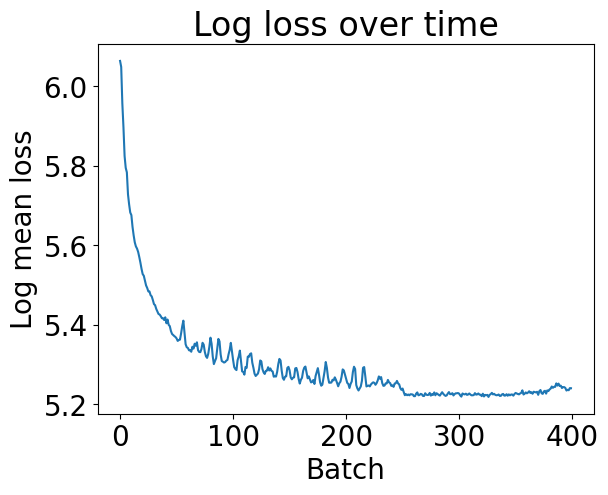

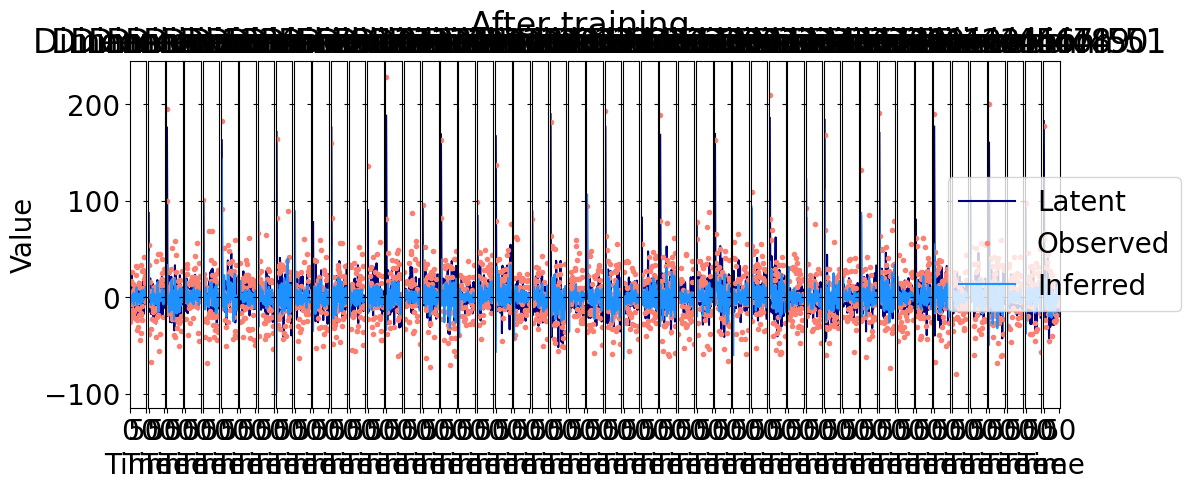

Loss 173216.82607042853
M = [[-0.15413332 -0.01502281 -0.06584852 ...  0.05866146 -0.04575847
  -0.07931126]
 [ 0.04713777 -0.03478682  0.04829366 ...  0.0193793   0.02086477
   0.03006516]
 [ 0.18531302  0.02563354 -0.09200843 ... -0.01738577  0.00435667
  -0.00522935]
 ...
 [ 0.07883839  0.04226484 -0.02312546 ... -0.2350312  -0.01221553
   0.05207553]
 [ 0.09018576  0.03649414 -0.00403348 ...  0.03242386 -0.17518097
  -0.00531896]
 [ 0.03038226  0.01029588 -0.05560943 ...  0.07493446  0.08246958
  -0.22594177]]
K = [[ 0.23583232  0.09676681  0.10880152 ...  0.01166433 -0.01984606
   0.03965518]
 [ 0.00902869  0.3453779   0.28244697 ...  0.09703684  0.11095854
   0.20530568]
 [-0.00091788  0.11419208  0.42512239 ...  0.05567382  0.05138588
   0.00115444]
 ...
 [-0.02502674 -0.00320132  0.03652321 ...  0.21606387  0.01733511
   0.02342316]
 [ 0.01236018  0.02983819  0.07649936 ... -0.03515516  0.28486268
   0.0292388 ]
 [-0.0962385  -0.00431701 -0.07493113 ... -0.04709558 -0.01339868


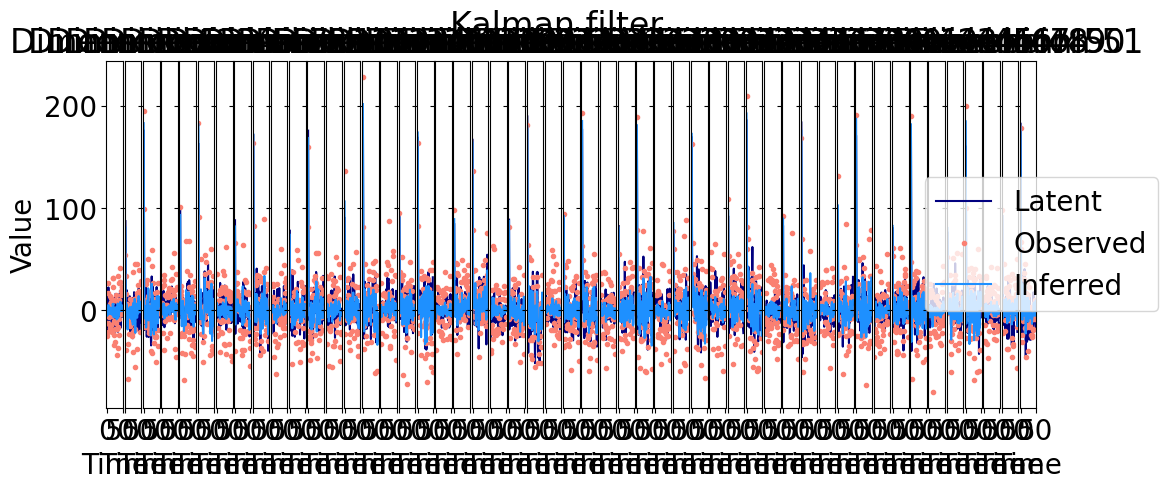

Loss 145170.1471870059
M = [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.58107818 -0.06361409  0.         ...  0.          0.
   0.        ]
 [ 0.49084946  0.55446355  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.58107818 -0.06361409
   0.        ]
 [ 0.          0.          0.         ...  0.49084946  0.55446355
   0.        ]]
K = [[0.2        0.         0.         ... 0.         0.         0.        ]
 [0.         0.28367526 0.07068232 ... 0.         0.         0.        ]
 [0.         0.07068232 0.38392939 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2        0.         0.        ]
 [0.         0.         0.         ... 0.         0.28367526 0.07068232]
 [0.         0.         0.         ... 0.         0.07068232 0.38392939]]
W = [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. 

In [138]:
proc = mk_nd_proc(rng, 51,
                 A=gen_transtrnglsparse_dynamics_matrix(rng, 51))
compare_nn_kalman(rng, proc, np.concatenate((np.full(250, 5e-7), np.full(150, 1e-7))))

# End-of-summer poster figures

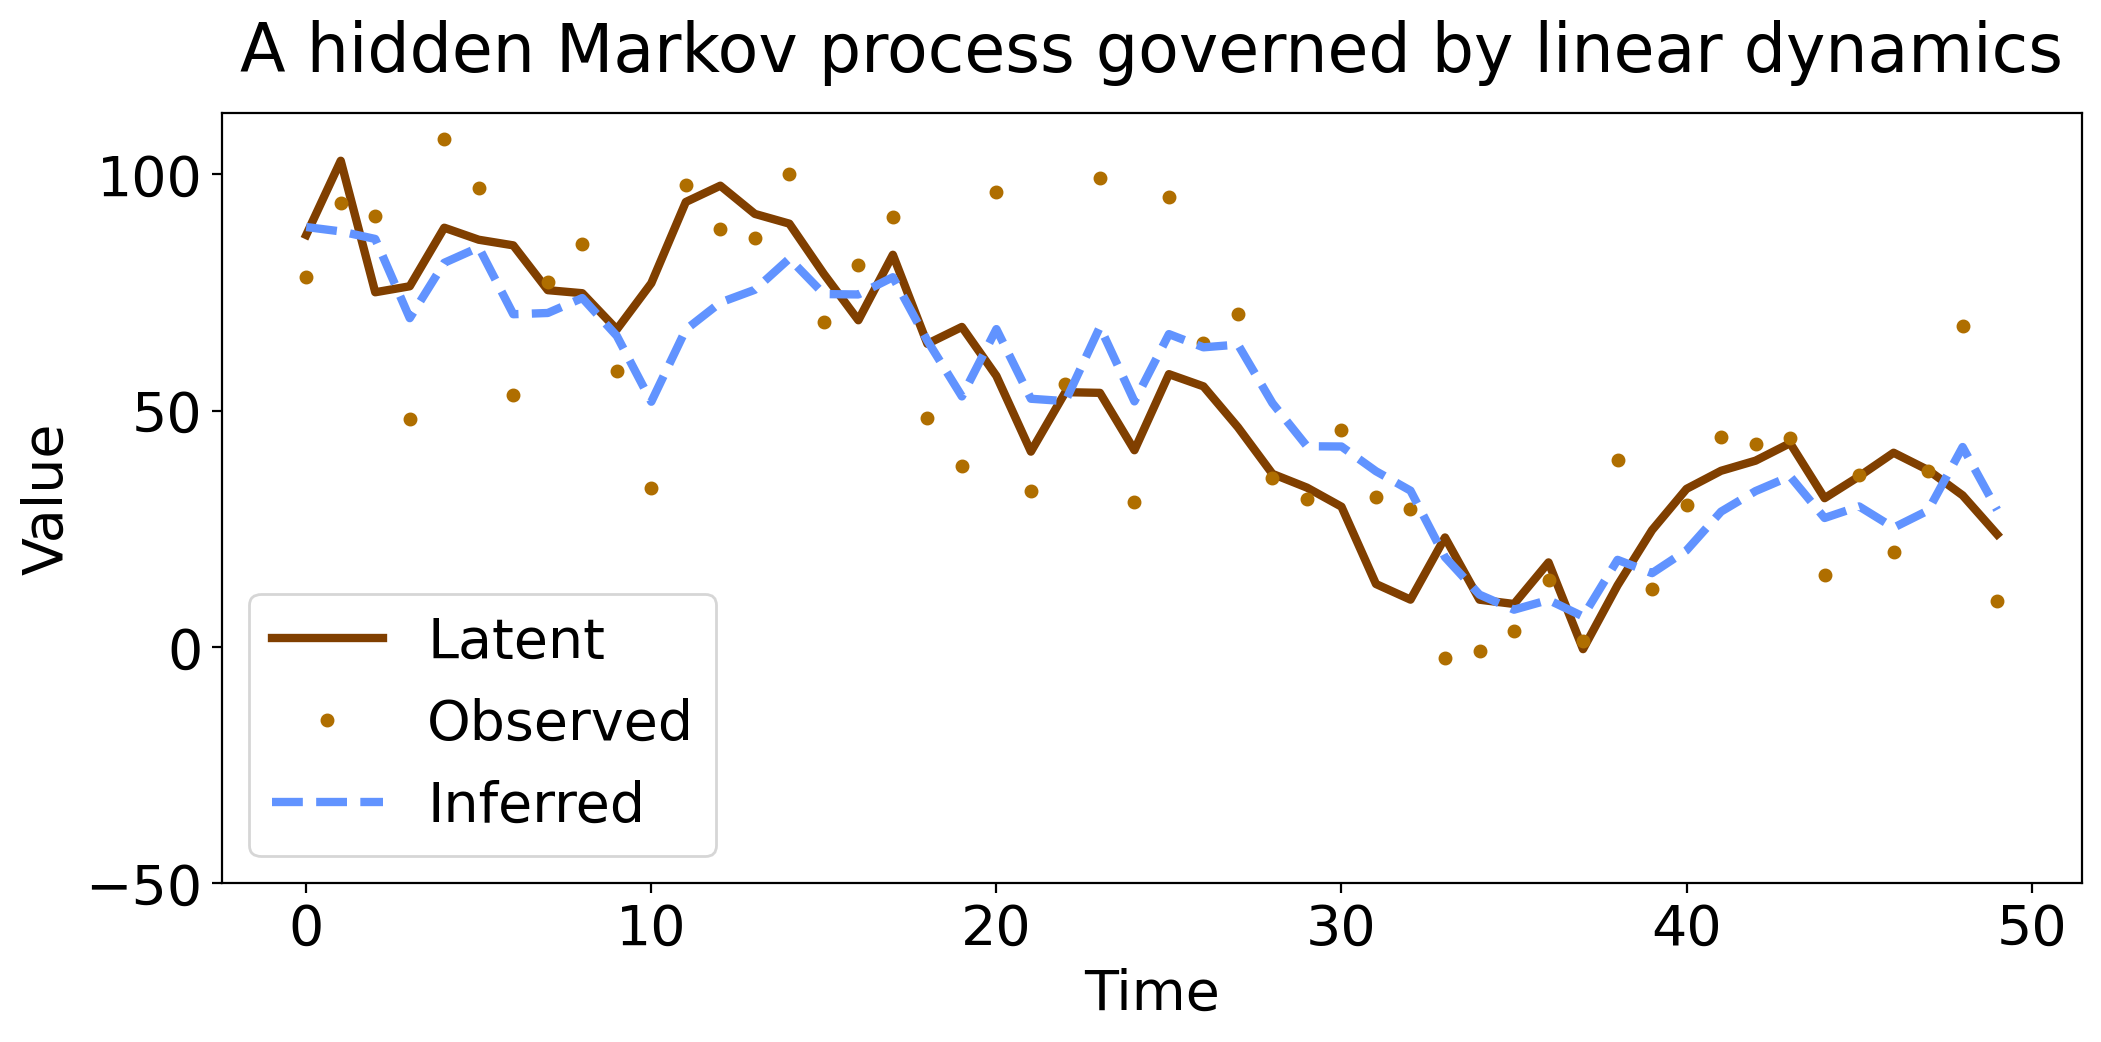

In [132]:
proc = create_1d_process(rng, np.array([[0.95]]))
kf = SteadyStateKalmanFilter(proc)
ts, xs, ys = proc.simulate()
xhats = kf.infer(ys)

plt.rc('font', size=20)
fig = plt.figure(figsize=(12,5), dpi=200)
plt.plot(ts, xs, linestyle='-', color='#803f00', linewidth=3, label='Latent')
plt.plot(ts, ys, linestyle='', marker='.', color='#af6e00', markersize=8, label='Observed')
plt.plot(ts, xhats, linestyle='--', color='#6193ff', linewidth=3, label='Inferred')
plt.xlabel('Time')
plt.xticks(np.arange(0, 60, 10))
plt.ylabel('Value')
plt.yticks(np.arange(-50, 150, 50))
plt.legend()
plt.title('A hidden Markov process governed by linear dynamics', pad=15)
plt.show()

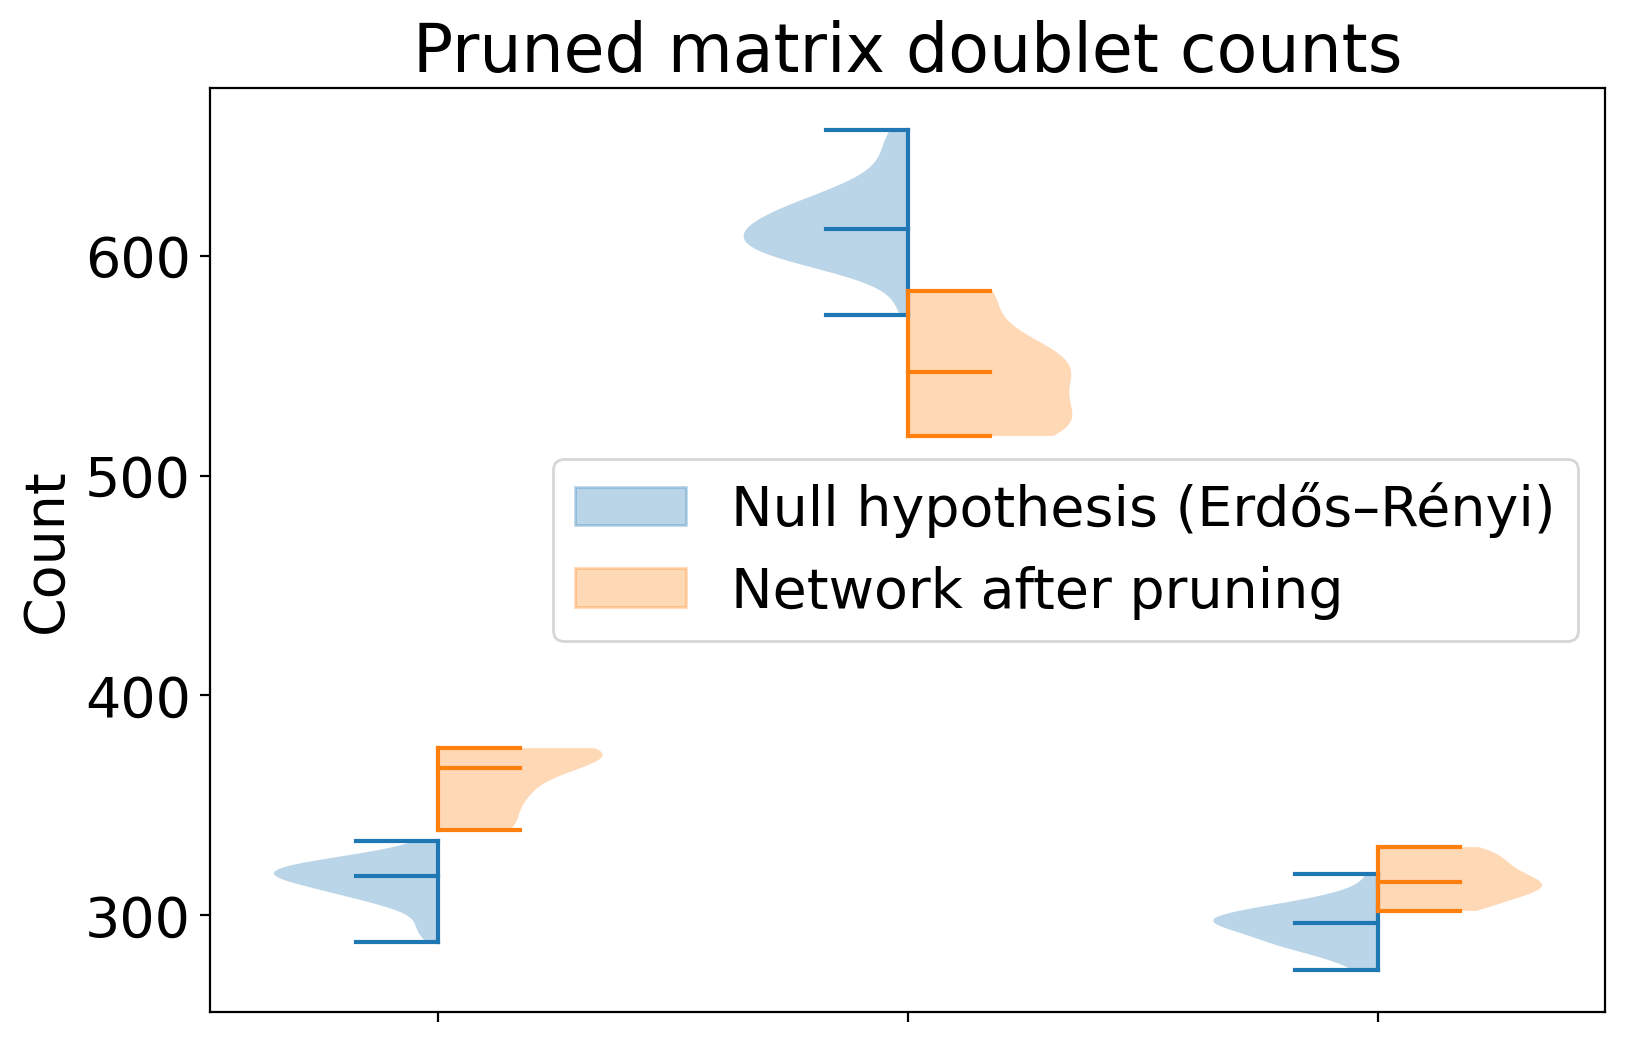

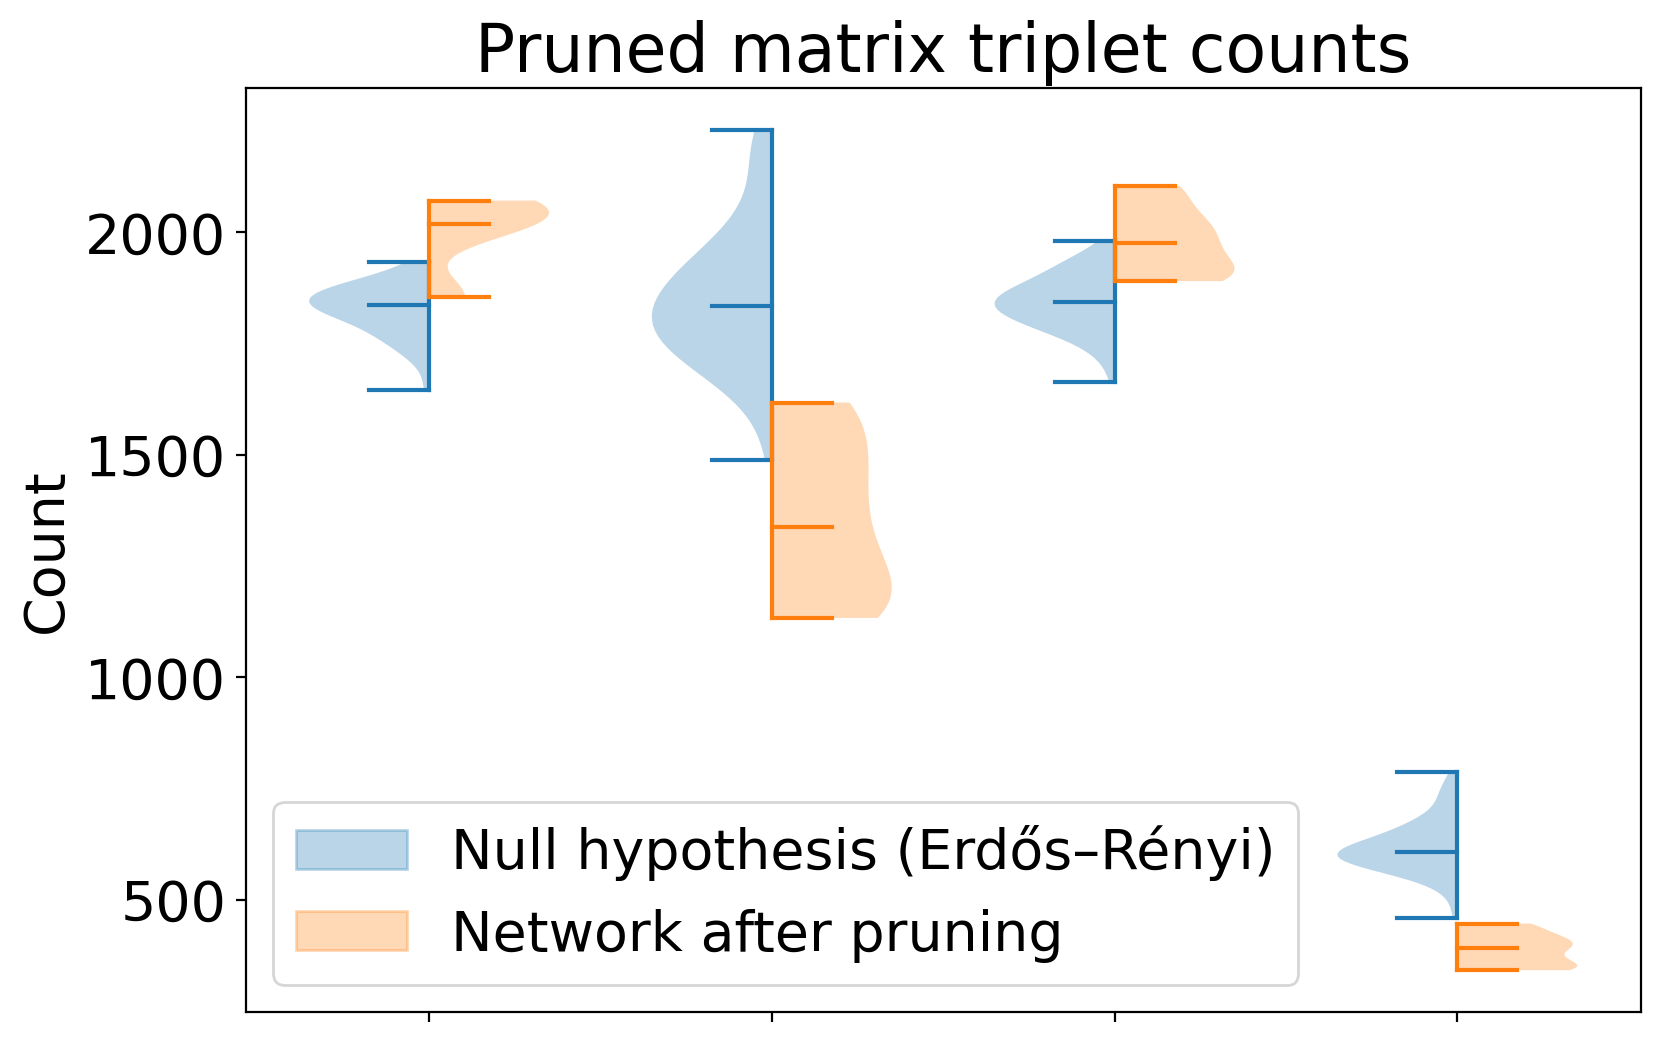

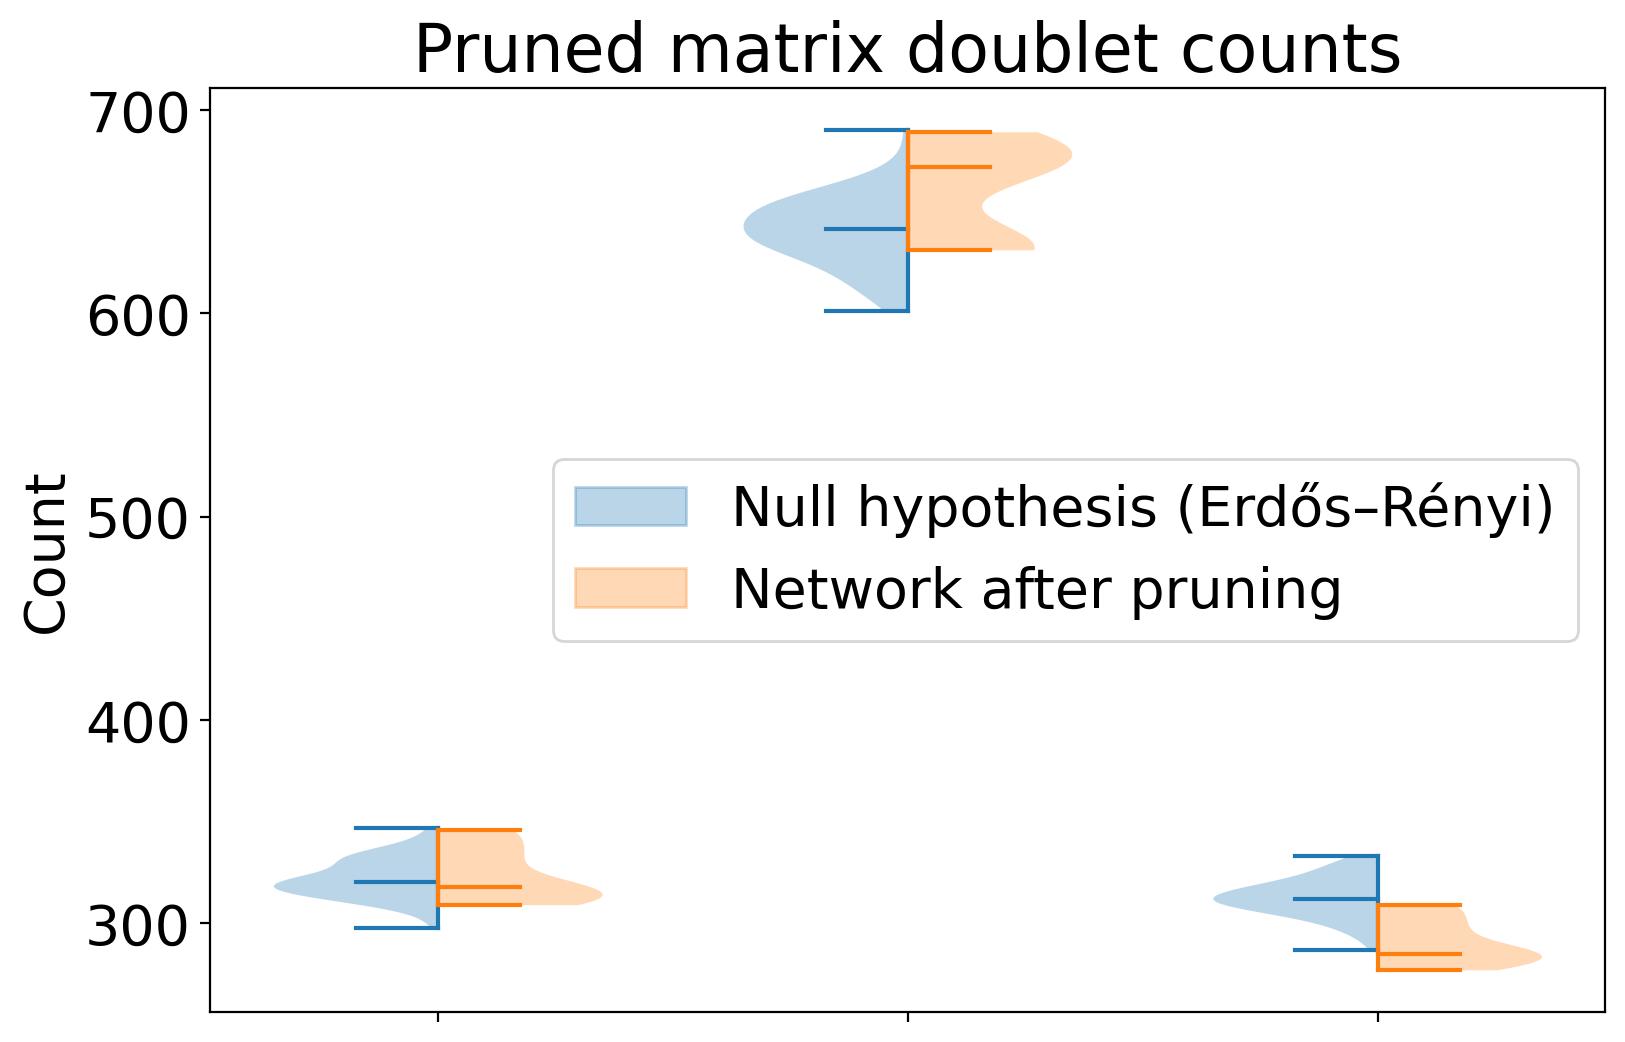

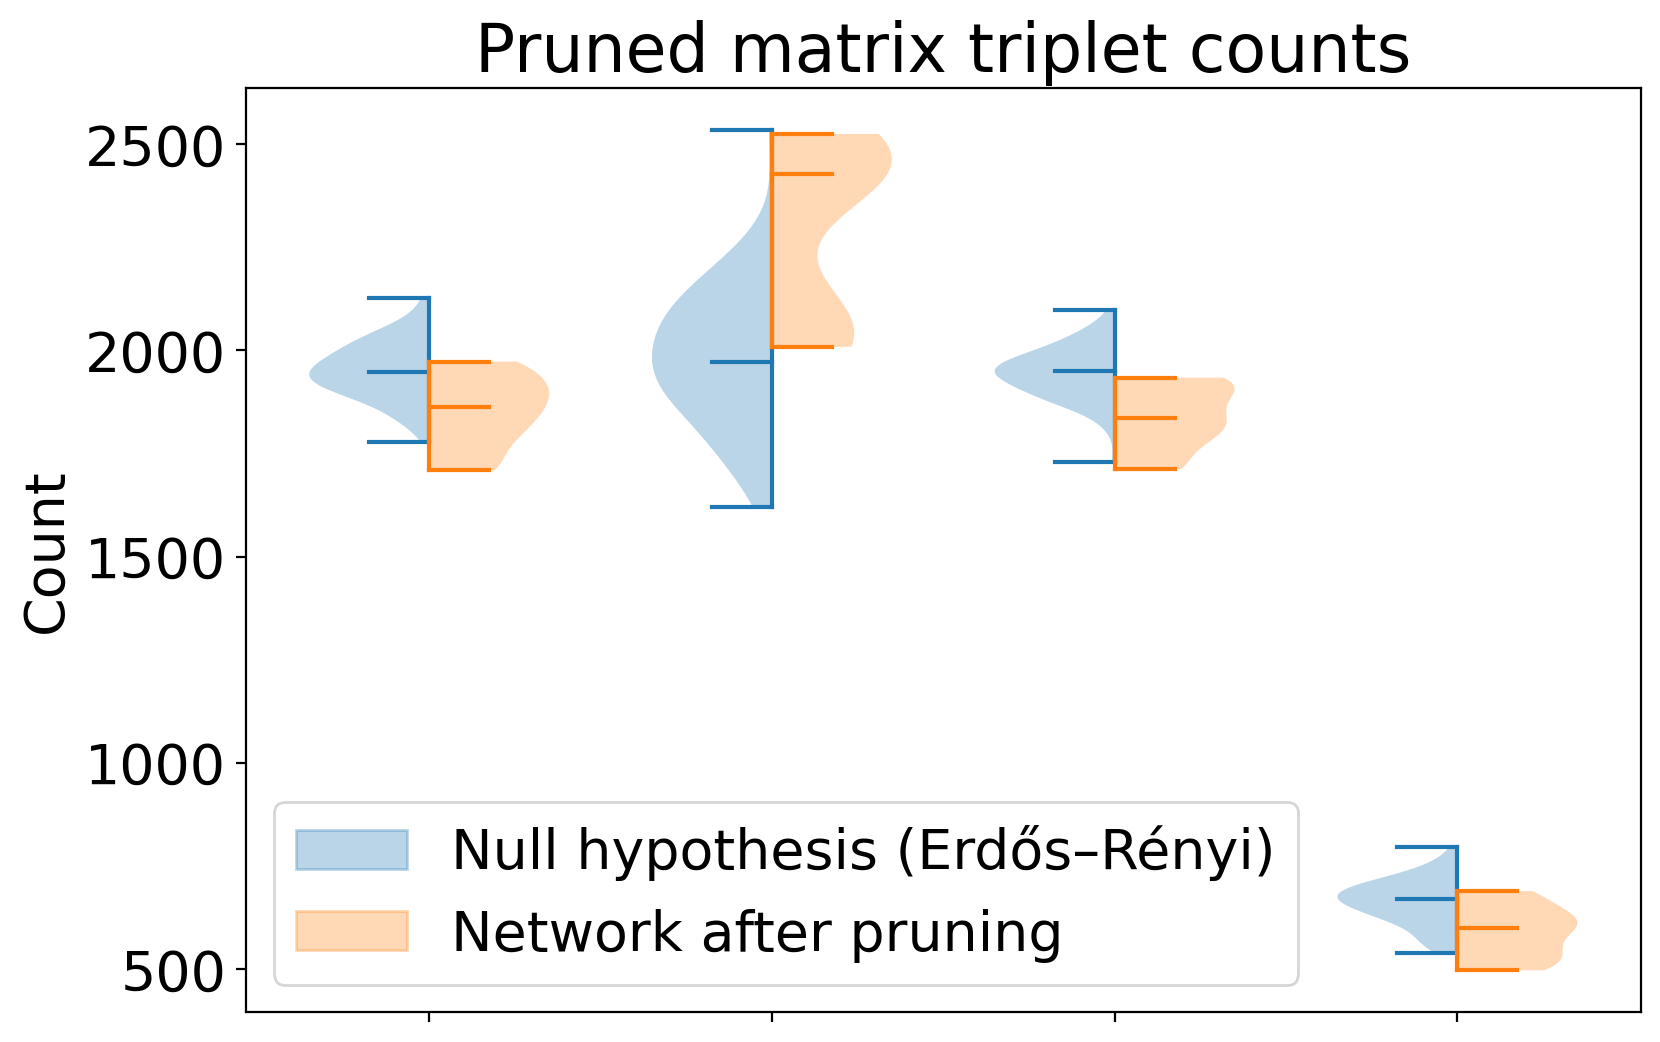

In [152]:
# Credit: https://stackoverflow.com/questions/33864578/matplotlib-making-labels-for-violin-plots
def mk_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    return (matplotlib.patches.Patch(color=color), label)

def violin_figure(prop, eps_vals, props_nonzeros, nns):
    pruned_M_supports = []
    for prop_nonzeros, nn in zip(props_nonzeros, nns):
        eps = eps_vals[(prop_nonzeros < prop).nonzero()[0][0]]
        pruned_M_supports.append(get_pruned_M(nn.M, eps))

    num_ER_trials_per = 20
    M_two_neuron_counts = []
    M_three_neuron_counts = []
    null_two_counts = []
    null_three_counts = []
    for M in pruned_M_supports:
        config2 = count_two_neuron_configs(M)
        M_two_neuron_counts.append([config2['Empty'],
                                    config2['Unidirectional'],
                                    config2['Bidirectional']])
        config3 = count_three_neuron_configs(M)
        M_three_neuron_counts.append([config3['Bidirectional out'],
                                      config3['Transitive triangle'],
                                      config3['Bidirectional in'],
                                      config3['Cycle']])

        n = M.shape[0]
        m = np.count_nonzero(M)
        ER_two_neuron_counts = np.zeros((num_ER_trials_per, 3))
        ER_three_neuron_counts = np.zeros((num_ER_trials_per, 4))
        for i in range(num_ER_trials_per):
            ER_adj = generate_erdos_renyi_adj_matrix(rng, n, m)
            ER_config2 = count_two_neuron_configs(ER_adj)
            ER_config3 = count_three_neuron_configs(ER_adj)
            ER_two_neuron_counts[i] = [
                ER_config2['Empty'],
                ER_config2['Unidirectional'],
                ER_config2['Bidirectional']
            ]
            ER_three_neuron_counts[i] = [
                ER_config3['Bidirectional out'],
                ER_config3['Transitive triangle'],
                ER_config3['Bidirectional in'],
                ER_config3['Cycle']
            ]
        null_two_counts.append(ER_two_neuron_counts)
        null_three_counts.append(ER_three_neuron_counts)

    M_two_neuron_counts = np.vstack(M_two_neuron_counts)
    M_three_neuron_counts = np.vstack(M_three_neuron_counts)
    null_two_counts = np.vstack(null_two_counts)
    null_three_counts = np.vstack(null_three_counts)

    fig = plt.figure(figsize=(9,6), dpi=200)
    xticks = [0,1,2]
    labels = []
    v = plt.violinplot(null_two_counts, xticks, points=60, widths=0.7,
                       showmedians=True, bw_method=0.5, side='low')
    labels.append(mk_label(v, 'Null hypothesis (Erdős–Rényi)'))
    v = plt.violinplot(M_two_neuron_counts, xticks, points=60, widths=0.7,
                       showmedians=True, bw_method=0.5, side='high')
    labels.append(mk_label(v, 'Network after pruning'))
    plt.title('Pruned matrix doublet counts')
    plt.ylabel('Count')
    plt.xticks([0,1,2], ['','',''])
    plt.legend(*zip(*labels))
    plt.show()

    fig = plt.figure(figsize=(9,6), dpi=200)
    xticks = [0,1,2,3]
    labels = []
    v = plt.violinplot(null_three_counts, xticks, points=60, widths=0.7,
                       showmedians=True, bw_method=0.5, side='low')
    labels.append(mk_label(v, 'Null hypothesis (Erdős–Rényi)'))
    v = plt.violinplot(M_three_neuron_counts, xticks, points=60, widths=0.7,
                       showmedians=True, bw_method=0.5, side='high')
    labels.append(mk_label(v, 'Network after pruning'))
    plt.title('Pruned matrix triplet counts')
    plt.ylabel('Count')
    plt.xticks([0,1,2,3], ['','','',''])
    plt.legend(*zip(*labels))
    plt.show()

violin_figure(0.5, eps_vals_pairs, props_nonzeros_pairs, nns_pairs)
violin_figure(0.5, eps_vals_transtrnglsparse, props_nonzeros_transtrnglsparse, nns_transtrnglsparse)

In [168]:
masks_fig1 = {
    'Empty': np.array([
        [0, 0],
        [0, 0]
    ]),
    'Two loops': np.array([
        [1, 0],
        [0, 1]
    ]),
    'Loop pointing outward': np.array([
        [1, 0],
        [1, 0]
    ]),
    'Loop pointing inward': np.array([
        [1, 1],
        [0, 0]
    ]),
    'Reciprocal': np.array([
        [0, 1],
        [1, 0]
    ]),
    'Full': np.array([
        [1, 1],
        [1, 1]
    ])
}
masks_fig2 = {
    'Bidirectional out': np.array([
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0]
    ]),
    'Transitive triangle': np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0]
    ]),
    'Bidirectional in': np.array([
        [0, 1, 1],
        [1, 0, 0],
        [0, 0, 0]
    ]),
    'Cycle': np.array([
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]
    ])
}

def test_masks_fig(rng, n, masks, etas, title, envals=None, A=None, nonlin=Nonlinearity.ID):
    num_processes = 1
    num_nns = 5
    batch_size = 40
    processes = []
    data = [] # loss indexed by process number, then pattern
    std_devs = [] # same
    for process_num in range(num_processes):
        data_this_rep = dict()
        std_devs_this_rep = dict()
        proc = mk_nd_proc(rng, n, envals=envals, A=A)
    
        print('Process dynamics:', proc.A)
        print('Eigenvalues:', np.linalg.eig(proc.A).eigenvalues)
        kf = SteadyStateKalmanFilter(proc)
        print('Kalman filter M:', kf.M_infty)
        print('Kalman filter K:', kf.K_infty)
        nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(n), proc.x0)
        Ls = nn.batch_test(batch_size, proc)
        print('Kalman filter loss:', np.mean(Ls))

        max_val_A = np.max(np.abs(proc.A))

        for name, mask in tqdm.tqdm(masks.items()):
            losses = []
            trial_num = 1
            while True:
                if trial_num > 100:
                    raise FloatingPointError(f'Gradient descent of {num_nns} networks unsuccessful after 100 attempts')
                try:
                    print(f'Testing {name}, Trial {trial_num}')
                    nn = NeuralNet(0.1*max_val_A*mk_rand_matrix(rng, n), 0.1*max_val_A*mk_rand_matrix(rng, n),
                                   np.eye(n), proc.x0, mask=mask, nonlin=nonlin)
                    Ls, _, _, _ = nn.train(etas, batch_size, proc,
                                           print_loss=False, progress_bar=False)
                    loss = Ls[-1]
                    losses.append(loss)
                    print('NN M:', nn.M)
                    print('NN K:', nn.K)
                    print('NN W:', nn.W)
                    print('Loss:', loss)
                    if len(losses) >= num_nns:
                        break
                    trial_num += 1
                except FloatingPointError:
                    trial_num += 1
            mean_loss = np.mean(losses)
            std_dev_loss = np.std(losses, ddof=1)
            data_this_rep[name] = mean_loss
            std_devs_this_rep[name] = std_dev_loss
        processes.append(proc)
        data.append(data_this_rep)
        std_devs.append(std_devs_this_rep)

        fig = plt.figure(figsize=(9,6), dpi=200)
        xticks = np.arange(len(data_this_rep))
        plt.bar(xticks, data_this_rep.values(), yerr=std_devs_this_rep.values())
        plt.xticks(xticks, ['']*len(data_this_rep))
        plt.title(title, pad=10)
        plt.ylabel('Loss')
        plt.show()

    return data

Process dynamics: [[0.  0.9]
 [0.9 0. ]]
Eigenvalues: [ 0.9 -0.9]
Kalman filter M: [[0.         0.58788979]
 [0.58788979 0.        ]]
Kalman filter K: [[0.34678913 0.        ]
 [0.         0.34678913]]
Kalman filter loss: 5137.765795197566


  0%|                                                                       | 0/6 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.36670202 0.87420515]
 [0.93440807 1.36573829]]
NN W: [[ 0.7290988  -0.43272131]
 [-0.46559295  0.73264016]]
Loss: 8850.42053671591
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.34816078 0.84276143]
 [0.87920357 1.36338938]]
NN W: [[ 0.70469146 -0.3995996 ]
 [-0.42034486  0.69868153]]
Loss: 9226.706047106698
Testing Empty, Trial 3
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.37098495 0.89738249]
 [0.93559726 1.41016216]]
NN W: [[ 0.73011976 -0.43007264]
 [-0.45068023  0.71302933]]
Loss: 9303.127781994368
Testing Empty, Trial 4
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.3879778  0.84965545]
 [0.87595578 1.43286823]]
NN W: [[ 0.65511288 -0.35501381]
 [-0.36497459  0.63285864]]
Loss: 8843.14413672599
Testing Empty, Trial 5


 17%|██████████▎                                                   | 1/6 [03:57<19:45, 237.01s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.34069082 0.8377646 ]
 [0.89768108 1.39616459]]
NN W: [[ 0.70659785 -0.38915089]
 [-0.41447     0.67178869]]
Loss: 9471.272215527442
Testing Two loops, Trial 1
NN M: [[0.26272805 0.        ]
 [0.         0.40355491]]
NN K: [[0.81269163 0.18896976]
 [0.33764149 0.63224907]]
NN W: [[ 0.76948177 -0.12778239]
 [-0.3957836   0.87301379]]
Loss: 9813.590770023246
Testing Two loops, Trial 2
NN M: [[0.49225833 0.        ]
 [0.         0.31853078]]
NN K: [[0.56511448 0.32570549]
 [0.07610228 0.67652404]]
NN W: [[ 0.7624506  -0.40154267]
 [-0.0256838   0.81483281]]
Loss: 8416.284592407812
Testing Two loops, Trial 3
NN M: [[0.48946052 0.        ]
 [0.         0.40714079]]
NN K: [[0.69907353 0.36513256]
 [0.17462122 0.66568984]]
NN W: [[ 0.70595012 -0.41104545]
 [-0.15860608  0.83534844]]
Loss: 8537.268626882691
Testing Two loops, Trial 4
NN M: [[0.39680672 0.        ]
 [0.         0.51415375]]
NN K: [[0.67073574 0.14231359]
 [0.30706182 0.61405673]]
NN W: [[ 0.790

 33%|████████████████████▋                                         | 2/6 [07:54<15:49, 237.37s/it]

NN M: [[0.37742507 0.        ]
 [0.         0.49812331]]
NN K: [[0.74338451 0.13543271]
 [0.26758087 0.50880364]]
NN W: [[ 0.71773701 -0.0982705 ]
 [-0.32332221  0.86683618]]
Loss: 8009.209254688614
Testing Loop pointing outward, Trial 1
NN M: [[0.54541836 0.        ]
 [0.50579847 0.        ]]
NN K: [[0.79317022 0.36005463]
 [0.1875774  0.63082387]]
NN W: [[ 0.74902962 -0.48741183]
 [-0.33565281  0.83308936]]
Loss: 7170.924332711487
Testing Loop pointing outward, Trial 2
NN M: [[0.55793759 0.        ]
 [0.43708077 0.        ]]
NN K: [[0.74268854 0.39135223]
 [0.08314212 0.59495497]]
NN W: [[ 0.7186003  -0.53647385]
 [-0.24758139  0.85340071]]
Loss: 7360.763876522146
Testing Loop pointing outward, Trial 3
NN M: [[0.56741482 0.        ]
 [0.5295651  0.        ]]
NN K: [[0.53780314 0.24164221]
 [0.01446568 0.57252831]]
NN W: [[ 0.88175216 -0.45851895]
 [-0.21874447  0.84264235]]
Loss: 6808.180951663929
Testing Loop pointing outward, Trial 4
NN M: [[0.53828019 0.        ]
 [0.41125589 0.  

 50%|███████████████████████████████                               | 3/6 [10:23<09:50, 196.92s/it]

NN M: [[0.55046182 0.        ]
 [0.3815012  0.        ]]
NN K: [[0.74751683 0.37775376]
 [0.0710984  0.58115904]]
NN W: [[ 0.70632948 -0.54695171]
 [-0.21747712  0.89928073]]
Loss: 7231.586902022316
Testing Loop pointing inward, Trial 1
NN M: [[0.31830523 0.26057432]
 [0.         0.        ]]
NN K: [[0.41323282 0.21974775]
 [0.16519574 1.06311455]]
NN W: [[ 0.90537101 -0.30102654]
 [ 0.02394449  0.58806582]]
Loss: 8781.015352789951
Testing Loop pointing inward, Trial 2
NN M: [[0.05150361 0.28898027]
 [0.         0.        ]]
NN K: [[0.61657591 0.24216485]
 [0.4679543  1.32983427]]
NN W: [[ 0.82565472 -0.19346603]
 [-0.12849273  0.4792167 ]]
Loss: 7986.688959839358
Testing Loop pointing inward, Trial 3
NN M: [[0.22862581 0.38925247]
 [0.         0.        ]]
NN K: [[0.65904302 0.40799152]
 [0.20770645 1.07863863]]
NN W: [[ 0.65935463 -0.35680016]
 [-0.01180108  0.58867548]]
Loss: 8292.79985346771
Testing Loop pointing inward, Trial 4
NN M: [[0.08852919 0.28965346]
 [0.         0.       

 67%|█████████████████████████████████████████▎                    | 4/6 [12:53<05:56, 178.36s/it]

NN M: [[0.22528476 0.37166718]
 [0.         0.        ]]
NN K: [[0.51326807 0.23929891]
 [0.21617033 1.04925847]]
NN W: [[ 0.78464521 -0.28195473]
 [-0.0180643   0.60990868]]
Loss: 8433.09869898748
Testing Reciprocal, Trial 1
NN M: [[0.         0.61633434]
 [0.58104445 0.        ]]
NN K: [[0.60299199 0.3112018 ]
 [0.28482074 0.61913949]]
NN W: [[ 0.73909402 -0.36223539]
 [-0.33975969  0.74451196]]
Loss: 5281.177930971739
Testing Reciprocal, Trial 2
NN M: [[0.         0.55231611]
 [0.59372006 0.        ]]
NN K: [[0.56984841 0.20954801]
 [0.23091973 0.59752783]]
NN W: [[ 0.74806949 -0.25013987]
 [-0.26595782  0.72031837]]
Loss: 5110.338540994301
Testing Reciprocal, Trial 3
NN M: [[0.         0.50627896]
 [0.5985073  0.        ]]
NN K: [[0.56727215 0.13747281]
 [0.11476359 0.54651932]]
NN W: [[ 0.74883988 -0.14646856]
 [-0.14129004  0.71073327]]
Loss: 5503.328797539439
Testing Reciprocal, Trial 4
NN M: [[0.         0.49748711]
 [0.64883193 0.        ]]
NN K: [[0.63916511 0.21670551]
 [0.2

 83%|███████████████████████████████████████████████████▋          | 5/6 [15:20<02:47, 167.18s/it]

NN M: [[0.         0.59424201]
 [0.62432024 0.        ]]
NN K: [[0.61789123 0.30830607]
 [0.32117275 0.62329076]]
NN W: [[ 0.74408476 -0.36277925]
 [-0.36886462  0.7250985 ]]
Loss: 5146.2478497484535
Testing Full, Trial 1
NN M: [[0.1954496  0.51563229]
 [0.48711466 0.0285333 ]]
NN K: [[0.63105325 0.33149682]
 [0.20950709 0.61348067]]
NN W: [[ 0.78095186 -0.52286412]
 [-0.3741162   0.86974609]]
Loss: 5546.406554819111
Testing Full, Trial 2
NN M: [[0.15950404 0.41185609]
 [0.55650801 0.06916087]]
NN K: [[0.63939405 0.22835237]
 [0.27142008 0.66075485]]
NN W: [[ 0.8143193  -0.37446294]
 [-0.4041836   0.77056258]]
Loss: 5918.042638375884
Testing Full, Trial 3
NN M: [[0.30386049 0.35765931]
 [0.43072332 0.13650134]]
NN K: [[0.70552866 0.28871885]
 [0.2132066  0.70909352]]
NN W: [[ 0.73771755 -0.4446727 ]
 [-0.36236424  0.77576005]]
Loss: 6184.320485901021
Testing Full, Trial 4
NN M: [[0.10987751 0.48490403]
 [0.40153046 0.19619969]]
NN K: [[0.66392152 0.23339208]
 [0.24892051 0.59797353]]
N

100%|██████████████████████████████████████████████████████████████| 6/6 [17:40<00:00, 176.74s/it]

NN M: [[ 0.28238941  0.4343226 ]
 [ 0.56082946 -0.07397311]]
NN K: [[0.71285869 0.42401081]
 [0.24094342 0.68560925]]
NN W: [[ 0.7030232  -0.51596872]
 [-0.33933649  0.78467545]]
Loss: 5646.438651309452


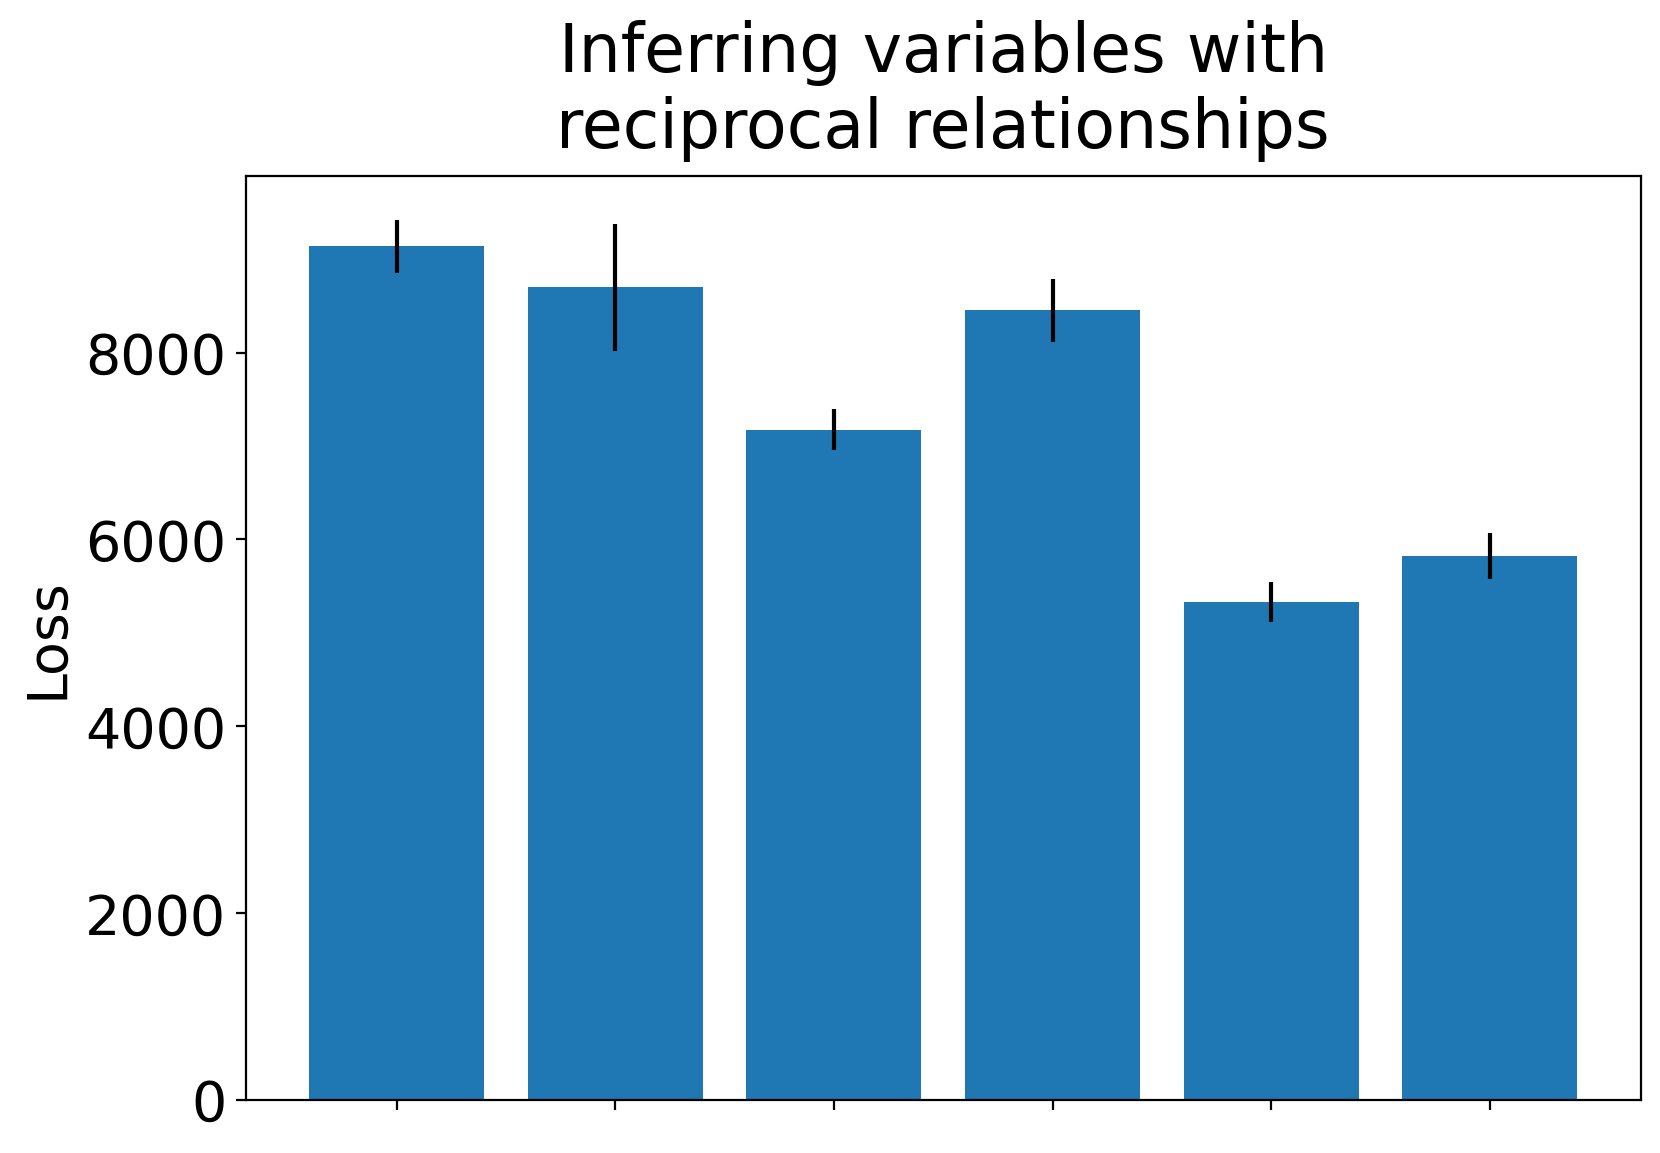

[{'Empty': 9138.934143614082,
  'Two loops': 8698.286789900043,
  'Loop pointing outward': 7176.3140197150515,
  'Loop pointing inward': 8452.972377726284,
  'Reciprocal': 5328.554937803632,
  'Full': 5822.587980917267}]

In [169]:
test_masks_fig(rng, 2, masks_fig1, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
               'Inferring variables with\nreciprocal relationships', A=np.array([[0, 0.9], [0.9, 0]]))

Process dynamics: [[0.  0.  0. ]
 [0.9 0.  0. ]
 [0.9 0.9 0. ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.58107818 -0.06361409  0.        ]
 [ 0.49084946  0.55446355  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.28367526 0.07068232]
 [0.         0.07068232 0.38392939]]
Kalman filter loss: 8048.920977738936


  0%|                                                                       | 0/4 [00:00<?, ?it/s]

Testing Bidirectional out, Trial 1
NN M: [[0.         0.05344345 0.        ]
 [0.37121092 0.         0.        ]
 [0.96143983 0.         0.        ]]
NN K: [[0.21919288 0.15972363 0.2147883 ]
 [0.00731235 0.47528914 0.37208829]
 [0.02516677 0.44873591 1.20850514]]
NN W: [[ 0.9450204  -0.10881681 -0.13378838]
 [-0.01936448  0.87376388 -0.20910764]
 [-0.09734992 -0.26524978  0.46691132]]
Loss: 8921.31384175233
Testing Bidirectional out, Trial 2
NN M: [[0.         0.0563287  0.        ]
 [0.41185873 0.         0.        ]
 [0.9853622  0.         0.        ]]
NN K: [[0.21196319 0.18019057 0.20804637]
 [0.00879534 0.52588731 0.45977378]
 [0.01560665 0.39741208 1.10392959]]
NN W: [[ 0.95118426 -0.16067942 -0.11444193]
 [-0.03611507  0.82576602 -0.26571819]
 [-0.08637599 -0.25945447  0.52574897]]
Loss: 8874.022708858614
Testing Bidirectional out, Trial 3
NN M: [[0.         0.02686698 0.        ]
 [0.42354919 0.         0.        ]
 [0.9242484  0.         0.        ]]
NN K: [[0.21927041 0.1122

 25%|███████████████▌                                              | 1/4 [02:33<07:41, 153.77s/it]

NN M: [[0.         0.03386574 0.        ]
 [0.36109505 0.         0.        ]
 [0.97084839 0.         0.        ]]
NN K: [[0.21988172 0.11225454 0.14751985]
 [0.00389874 0.37114517 0.11124242]
 [0.02343277 0.43595239 1.27227692]]
NN W: [[ 0.97852686 -0.08809032 -0.10572921]
 [-0.01984697  0.91068453 -0.04059537]
 [-0.09877486 -0.20796565  0.3888627 ]]
Loss: 8570.860980492465
Testing Transitive triangle, Trial 1
NN M: [[0.         0.         0.        ]
 [0.54903851 0.         0.        ]
 [0.58599507 0.44131583 0.        ]]
NN K: [[ 0.21408227 -0.00877016 -0.04262503]
 [-0.00209346  0.45711254  0.35377237]
 [-0.00594119  0.19615649  0.60823203]]
NN W: [[ 9.96456295e-01  8.84567125e-03  3.52737027e-02]
 [ 2.22639851e-04  7.78455328e-01 -2.50896418e-01]
 [ 1.55703848e-02 -1.11928247e-01  7.47292653e-01]]
Loss: 8591.873574677205
Testing Transitive triangle, Trial 2
NN M: [[0.         0.         0.        ]
 [0.52758364 0.         0.        ]
 [0.55715414 0.5370048  0.        ]]
NN K: [[ 0

 50%|███████████████████████████████                               | 2/4 [05:10<05:10, 155.49s/it]

NN M: [[0.         0.         0.        ]
 [0.53632822 0.         0.        ]
 [0.51762789 0.53687156 0.        ]]
NN K: [[ 0.21163798 -0.0184409  -0.04772389]
 [ 0.00497364  0.37458205  0.23926218]
 [ 0.00111008  0.1721213   0.56795068]]
NN W: [[ 0.99711271  0.02244865  0.04372971]
 [ 0.00571743  0.88878    -0.18156808]
 [ 0.01144093 -0.09809763  0.77825866]]
Loss: 8484.49054653737
Testing Bidirectional in, Trial 1
NN M: [[ 0.00000000e+00 -1.88284145e-03 -5.46380569e-05]
 [ 2.84104033e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
NN K: [[ 0.20814754 -0.04326784 -0.06761812]
 [ 0.00208872  0.36885435  0.18046388]
 [-0.00188368  0.67515469  1.75201549]]
NN W: [[ 0.99457024  0.00892959  0.03960609]
 [-0.00716289  0.93133062 -0.062443  ]
 [ 0.00365583 -0.30026106  0.29349976]]
Loss: 8478.085871793573
Testing Bidirectional in, Trial 2
NN M: [[ 0.         -0.02355777  0.00411456]
 [ 0.33998538  0.          0.        ]
 [ 0.          0.          0. 

 75%|██████████████████████████████████████████████▌               | 3/4 [07:46<02:35, 155.95s/it]

NN M: [[0.         0.00254365 0.00042547]
 [0.3951743  0.         0.        ]
 [0.         0.         0.        ]]
NN K: [[ 2.08431400e-01 -4.65283183e-02 -7.82202427e-02]
 [ 1.63951671e-03  3.06303968e-01  9.76299527e-02]
 [ 2.38081764e-03  6.01599760e-01  1.71929268e+00]]
NN W: [[ 0.99557599  0.01965372  0.04549134]
 [ 0.01029307  0.98480078 -0.01653299]
 [ 0.00879957 -0.18449403  0.27175157]]
Loss: 8814.8948447513
Testing Cycle, Trial 1
NN M: [[0.         0.         0.00384281]
 [0.43036881 0.         0.        ]
 [0.         0.82029517 0.        ]]
NN K: [[0.20597253 0.01125181 0.02830318]
 [0.04177797 0.41124555 0.28913567]
 [0.01277904 0.43942766 1.07109596]]
NN W: [[ 0.99266592 -0.00559477 -0.01580981]
 [-0.03036195  0.88012406 -0.15236461]
 [ 0.03632436 -0.20612027  0.44379473]]
Loss: 8744.000109273882
Testing Cycle, Trial 2
NN M: [[ 0.00000000e+00  0.00000000e+00 -7.87528354e-04]
 [ 4.62419591e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.33509802e-01  0.00000000e+

100%|██████████████████████████████████████████████████████████████| 4/4 [10:18<00:00, 154.67s/it]

NN M: [[0.         0.         0.00533941]
 [0.45726409 0.         0.        ]
 [0.         0.91251436 0.        ]]
NN K: [[0.21020465 0.00698074 0.02217373]
 [0.03507559 0.37126263 0.20542066]
 [0.02473112 0.44166579 1.07035324]]
NN W: [[ 0.99341616  0.00296468 -0.01997171]
 [-0.01203353  0.93301916 -0.10925169]
 [-0.02951767 -0.20141115  0.43346373]]
Loss: 8783.028235668207


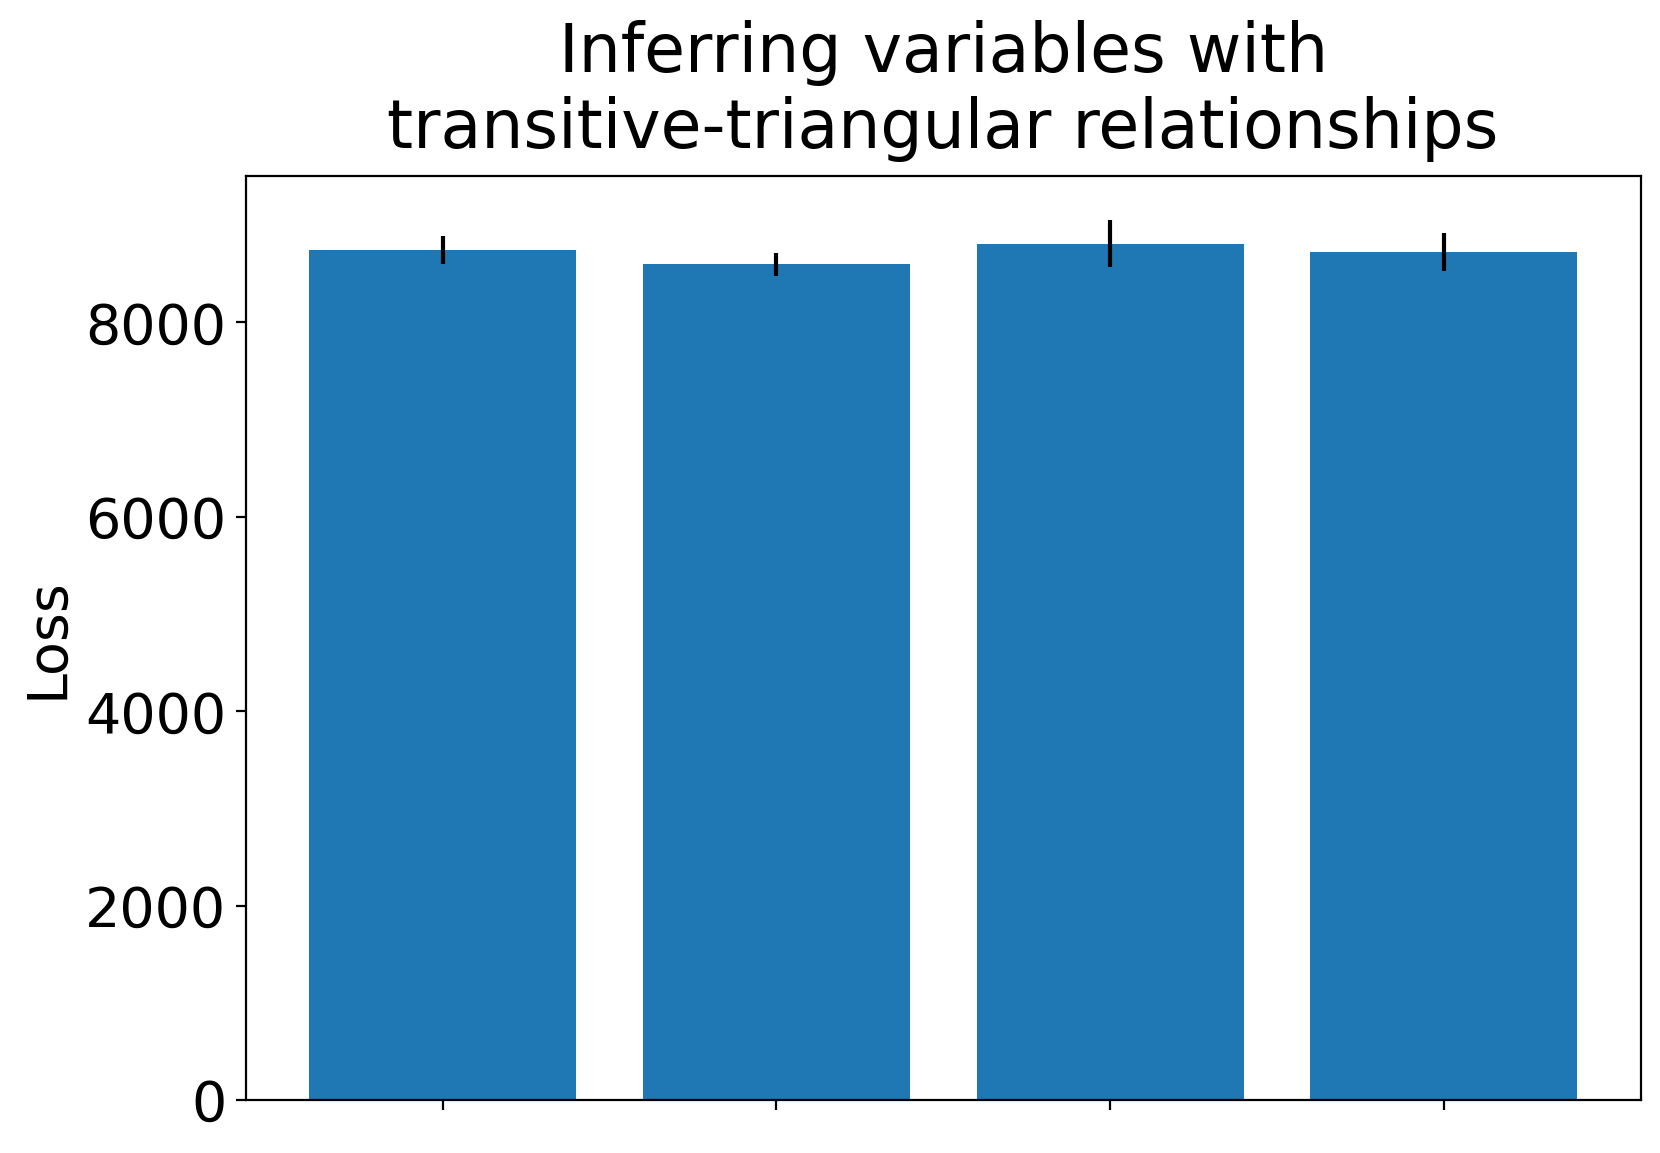

[{'Bidirectional out': 8747.859460372103,
  'Transitive triangle': 8598.516236426343,
  'Bidirectional in': 8810.527345599266,
  'Cycle': 8727.70485110589}]

In [170]:
test_masks_fig(rng, 3, masks_fig2, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
               'Inferring variables with\ntransitive-triangular relationships', A=np.array([[0, 0, 0], [0.9, 0, 0], [0.9, 0.9, 0]]))